In [1]:
import sys
import os
sys.path.append("../src/")
import combat
import numpy as np
import scipy.stats as stats
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import sklearn
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sb
import pickle as pkl
from sklearn.linear_model import LogisticRegression, Lasso, Ridge, ElasticNet
import random as rd
import matplotlib
matplotlib.rcParams['figure.dpi'] = 500
from sklearn.preprocessing import quantile_transform,binarize
from sklearn.model_selection import LeaveOneOut,KFold
from sklearn.metrics import r2_score
from statsmodels.stats.multitest import multipletests
from sklearn.cross_decomposition import PLSRegression as PLS
import warnings
warnings.simplefilter("ignore")
from multiprocessing import Process,Queue,Pool
import time 
import helper
from multiprocessing import set_start_method
#set_start_method("spawn")
from DecoID.DecoID import flatten
from sklearn.cross_decomposition import PLSRegression
from sklearn.svm import SVC
import importlib
import helper#import the module here, so that it can be reloaded.
importlib.reload(helper)
from statsmodels.stats.anova import AnovaRM
from statsmodels.stats.multitest import multipletests


In [2]:
var_imp = pd.read_csv("../data/var_importance.csv",index_col=0)
var_imp
print(len(var_imp))

34


In [9]:
#load in metadata and peak areas and associate

#read in peak data
datafilename = "../data/QTof-B1-9_pHILIC_HSS_pos-neg_normalized.csv"
data = pd.read_csv(datafilename)

#get area columns
areaCols = data.columns.values[10:]

#get molecule names
mol_names = data["Compound Name"].values

#extract area data and transpose
areaData = data[areaCols].transpose()

#get batch information
batchInfo = [int(x.split("_")[0][1]) for x in list(areaData.index.values)]

areaData = areaData.to_numpy()
areaData = areaData.astype(np.float)

#get index of blanks
blankSamp = [x for x in range(len(areaCols)) if "Blank" in areaCols[x] and not "equil" in areaCols[x]]
print(len(blankSamp)," blanks")

#get index of qc
qcSamp = [x for x in range(len(areaCols)) if "NIST" in areaCols[x] and not "equil" in areaCols[x] ]
print(len(qcSamp)," qc samples")

#get index of wu350 samples
samp = [x for x in range(len(areaCols)) if "WU350" in areaCols[x] and not "equil" in areaCols[x]]
print(len(samp), "research samples")

#load in metadata
metadatafn = "../data/Experiment-Parameters_b1-9.csv"
metadata = pd.read_csv(metadatafn)

#extact sample names for d0_yes samples
metadata_rel = metadata[metadata["day-COVID"] == "d0_Yes"]
print(len(metadata_rel)," d0 Covid+ Samples")

metadata_val = metadata[metadata["day-COVID"] == "d0_No"]
print(len(metadata_val), "d0 Covid- Samples")

val_samples = []
for index,row in metadata_val.iterrows():
    val_samples.append(row["Sample General Name"])
    
val_cols = []
for val_s in val_samples:
    for col in range(len(areaCols)):
        if areaCols[col] == val_s:
            val_cols.append(col)
            break
            
#create sample name, ventilator status linkage
vent_dict = {}
metadata_dict = {}
for index,row in metadata_rel.iterrows():
    val = str(row["ICU"])
    sampName = row["Sample General Name"]
    if "es" in val:
        val = 1
    elif "o" in val:
        val = 0
    vent_dict[sampName] = val
    metadata_dict[sampName] = row

print(np.sum(list(vent_dict.values()))," ICU+ samples")
print(len(vent_dict) - np.sum(list(vent_dict.values())),"ICU- samples")

#link vent status to sample in peak data
vent_status = []
metadata_for_samples = []
patient_ids = []
for s in np.array(areaCols)[samp]:
    tmp = s
    if tmp in vent_dict:
        vent_status.append(vent_dict[tmp])
        metadata_for_samples.append(metadata_dict[tmp])
        patient_ids.append(metadata_dict[tmp]["WU-350"])
    else:
        vent_status.append(-1)
        metadata_for_samples.append(-1)
print("found vent info for",len([x for x in vent_status if x != -1]),"covid_ d0 samples")
samplesOfInterest = [x for x in range(len(vent_status)) if vent_status[x] != -1]

sampleInfoDict = {}
for index,row in metadata.iterrows():
    if row["WU-350"] in patient_ids:
        val = str(row["ICU"])
        if "es" in val:
            val = 1
        elif "o" in val:
            val = 0
        
        sampleInfoDict[row["Sample General Name"]] = {"patient":row["WU-350"],"ICU":val,
                                                      "Day_to_ICU":row["Epic: Time from symptom onset to ICU (days)"],
                                                     "sample_day":row["WU350-Symptom onset"],
                                                      "death":row["Mortality Status"]}

index = 0
samplesOfInterest = []
for s in np.array(areaCols)[samp]:
    tmp = s
    if tmp in sampleInfoDict:
        samplesOfInterest.append(index)
        sampleInfoDict[tmp]["index"] = index
    index += 1
    
sampleInfoDict = {key:val for key,val in sampleInfoDict.items() if "index" in val}
sampleInfoDict = pd.DataFrame.from_dict(sampleInfoDict,orient="index")
print("found logitudinal info for: ",len(sampleInfoDict))

tmp = sampleInfoDict[sampleInfoDict["ICU"] == 1]
tmp = tmp[tmp["Day_to_ICU"] == "None"]
sampleInfoDict = sampleInfoDict.drop(tmp.index.values,axis=0)


#create sample matrix
samp_int = np.log2(areaData[samp])

val_int = np.log2(areaData[val_cols])
val_vent = np.array([0 for _ in val_int])

print(len(val_int))


vars_of_interest = []
for x in var_imp.index.values:
    index = 0
    for y in mol_names:
        if x == y:
            vars_of_interest.append(index)
            break
        index += 1 
        
samp_int = samp_int[:,vars_of_interest]
val_int = val_int[:,vars_of_interest]
print(val_int.shape)
print(samp_int.shape)

0  blanks
0  qc samples
704 research samples
264  d0 Covid+ Samples
59 d0 Covid- Samples
123  ICU+ samples
141 ICU- samples
found vent info for 263 covid_ d0 samples
found logitudinal info for:  603
59
(59, 34)
(704, 34)


In [22]:
uniquePatients = list(set([x for x in sampleInfoDict["patient"]]))
goodPatients = [x for x in uniquePatients if len([y for y in sampleInfoDict["patient"].values if y == x]) > 1]
pvals = []
alpha = 0.05
plot_dfs = []
for met in range(len(var_imp)):
    starts = []
    icus = []
    ends = []
    for pat in goodPatients:
        subset = sampleInfoDict[sampleInfoDict["patient"] == pat]
        relsamples = subset["index"].values
        times = subset["sample_day"].values
        ICU = subset["ICU"].values[0]
        mort = subset["death"].values[0]
        if ICU and mort == "Alive":
            ICU_day = float(subset["Day_to_ICU"].values[0])
            tmp = samp_int[relsamples,met]
            order = list(range(len(times)))
            order.sort(key=lambda x:times[x])
            tmp = tmp[order]
            #tmp = tmp - tmp[0]
            times = [times[x] for x in order]
            #if times[-1] > 25:
            ends.append(tmp[-1])
    df = dict()
    ind = 0
    ps = 0
    for e in ends:
        df[ind] = {"time":"end","val":e}
        ind += 1
        
    for v in val_int[:,met]:
        df[ind] = {"time":"COVID-","val":v}
        ind += 1

    df = pd.DataFrame.from_dict(df,orient="index")
    plot_dfs.append(df)
    _,p = stats.ttest_ind(df[df["time"] == "end"]["val"].values,df[df["time"] == "COVID-"]["val"].values,equal_var=False)
    pvals.append(p)


HSSneg_LPC 16:0/0:0@5.185 0.037984023797289414
HSSneg_LPC 18:0/0:0@7.599 0.021447280990741703
HSSneg_LPC 18:2/0:0@4.227 0.009674627198122216
HSSpos_Cer_NS d18:1_16:0_17.788 0.01353700603747417
HSSpos_LPC 0:0/14:0_3.126 2.4033403671724877e-05
HSSpos_LPC 0:0/16:0_4.715 0.009674627198122216
HSSpos_LPC 0:0/18:0_6.997 0.005072905417533167
HSSpos_LPC 14:0/0:0_3.387 1.6399425642577557e-05
HSSpos_LPC 15:0/0:0_4.164 0.001621201245673908
HSSpos_LPC 16:0/0:0_5.147 0.01685592283289486
HSSpos_LPC 16:1/0:0_3.734 0.00013647825290677353
HSSpos_LPC 18:0/0:0_7.547 0.009674627198122216
HSSpos_LPC 18:1/0:0_5.589 0.032334583968151503
HSSpos_LPC 18:2/0:0_4.195 0.004786815945217004
HSSpos_LPC 20:2/0:0_6.105 3.448001135111469e-05
HSSpos_LPC 20:3/0:0_4.813 0.00013647825290677353
HSSpos_PC 18:2_22:6_15.427 0.003885810755616656
HSSpos_PC 20:4_20:4_15.512 0.0029656427300906894
HSSpos_PC 38:6_15.829 0.004912686859180905
HSSpos_PE 16:0_18:2_16.83 0.003591298403296269
HSSpos_PE 16:0_20:4_16.641 1.6399425642577557e-0

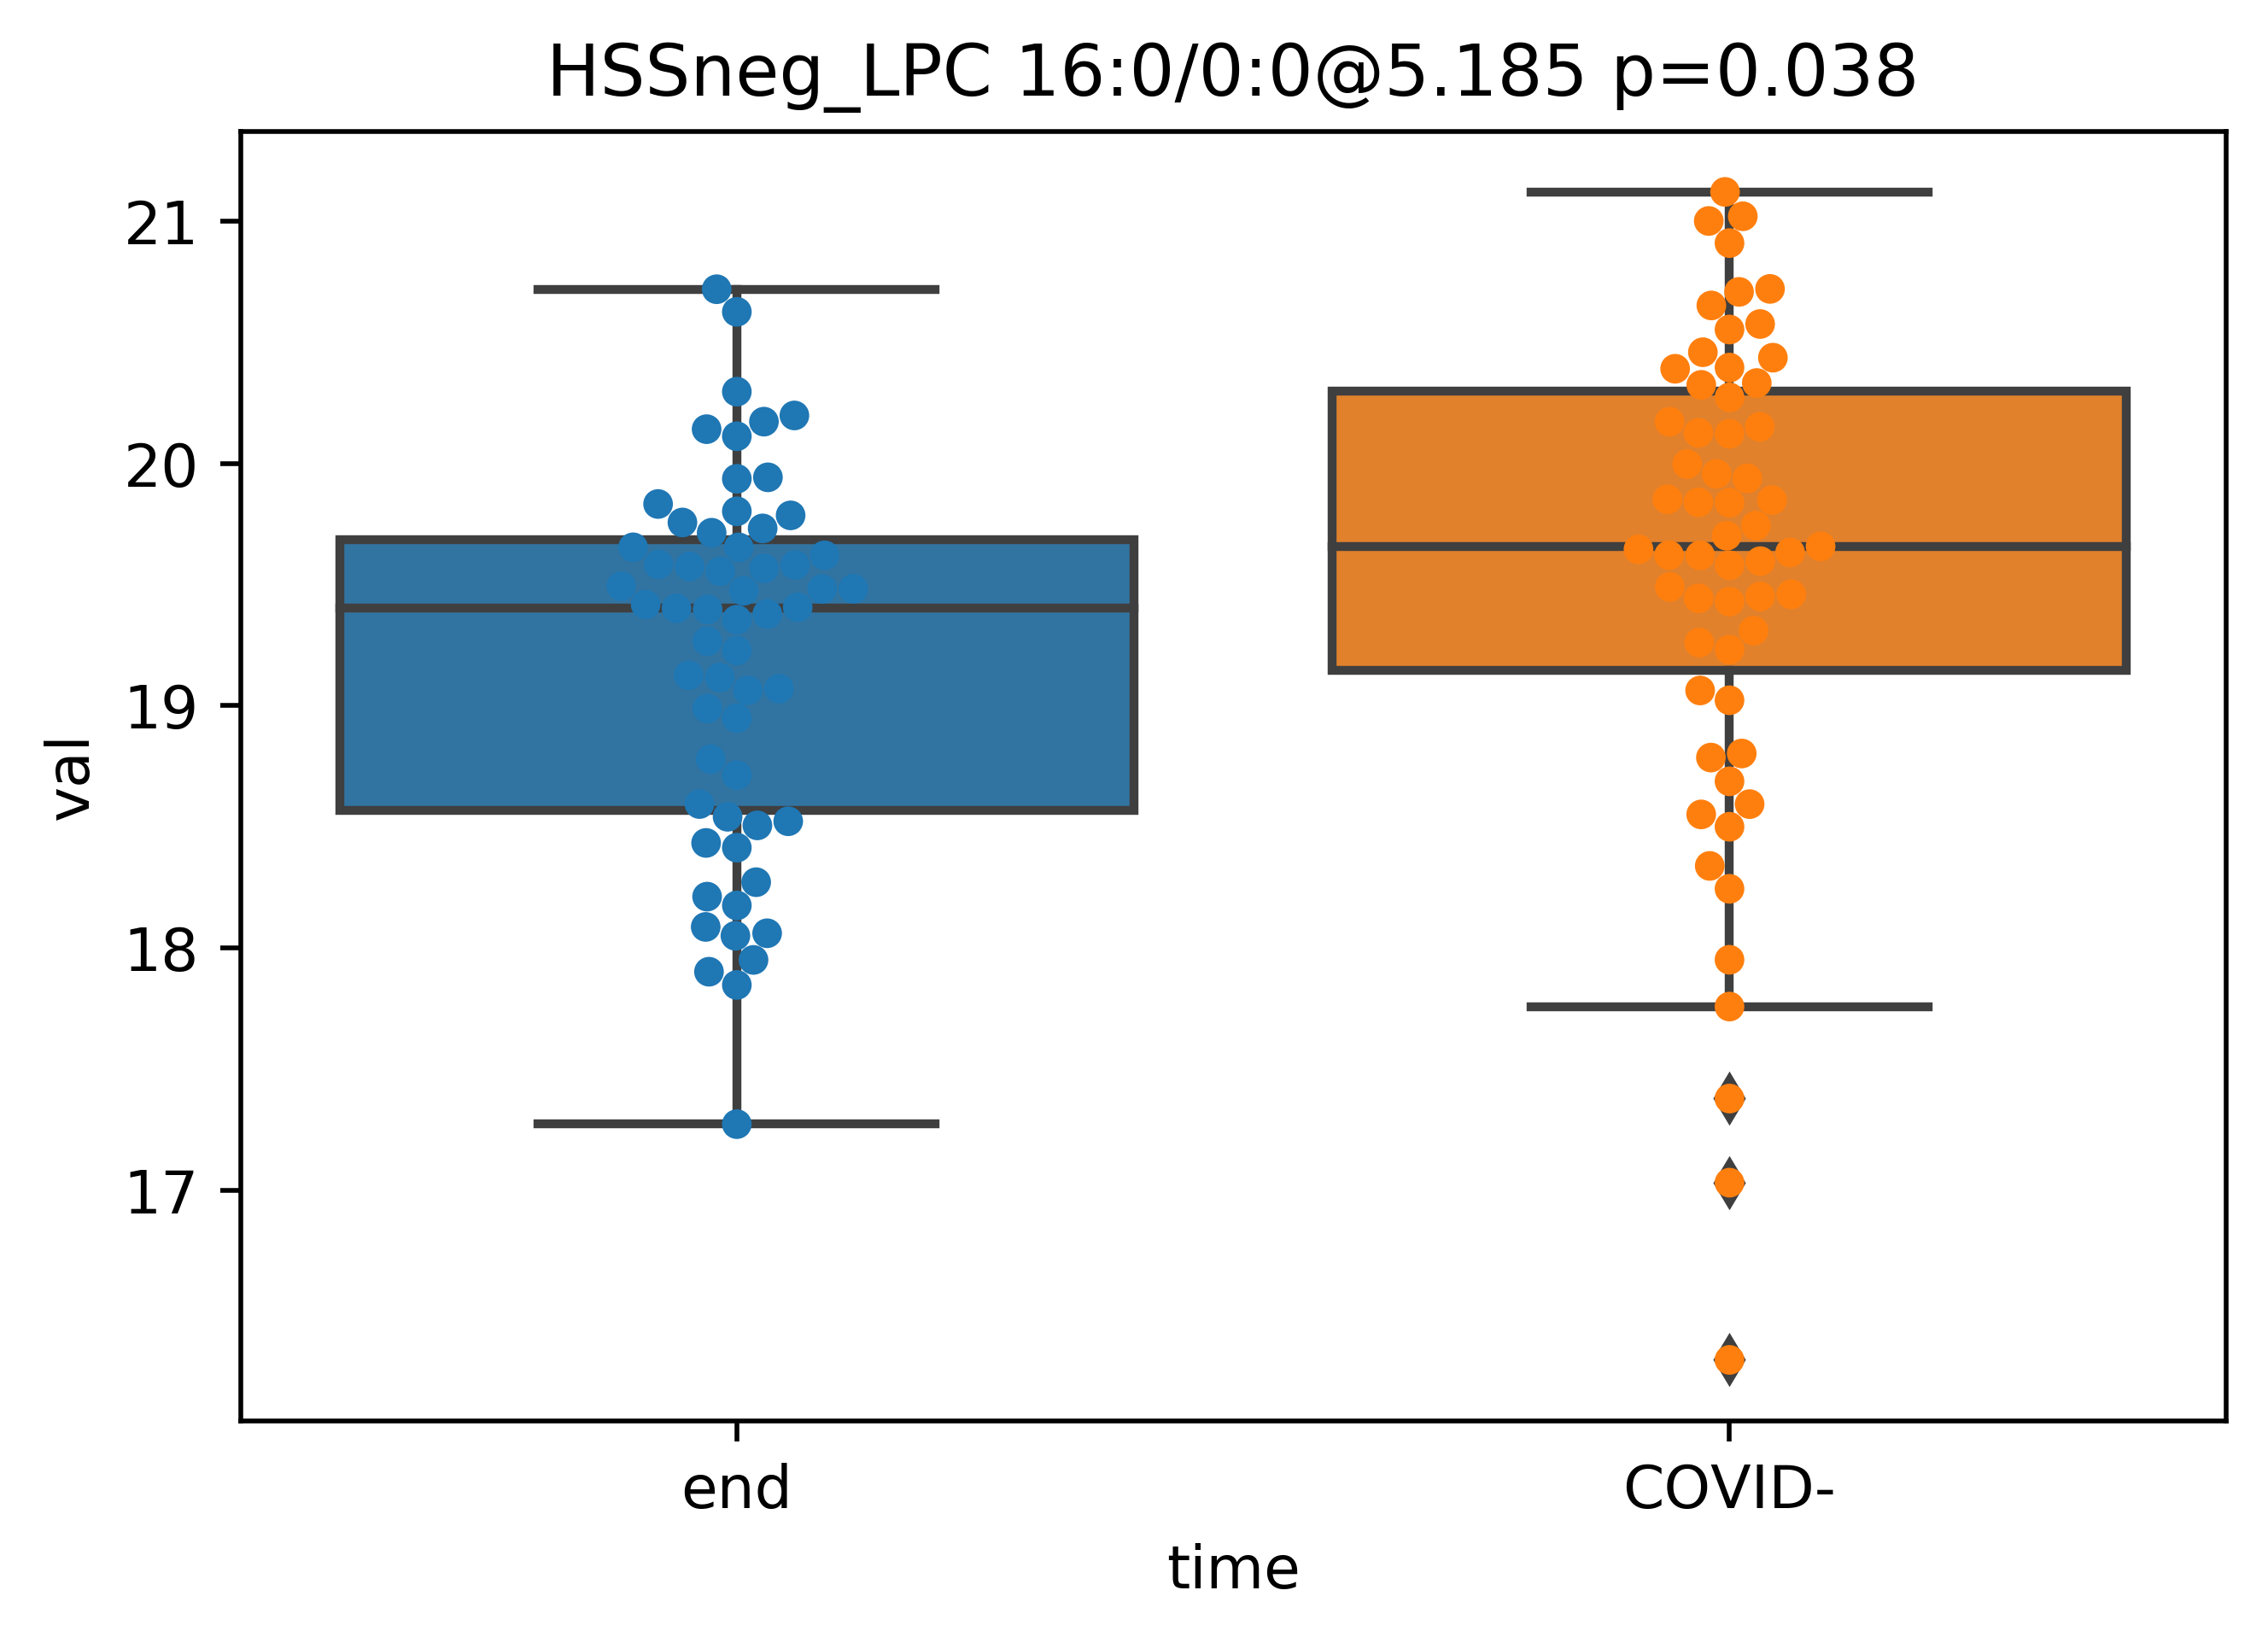

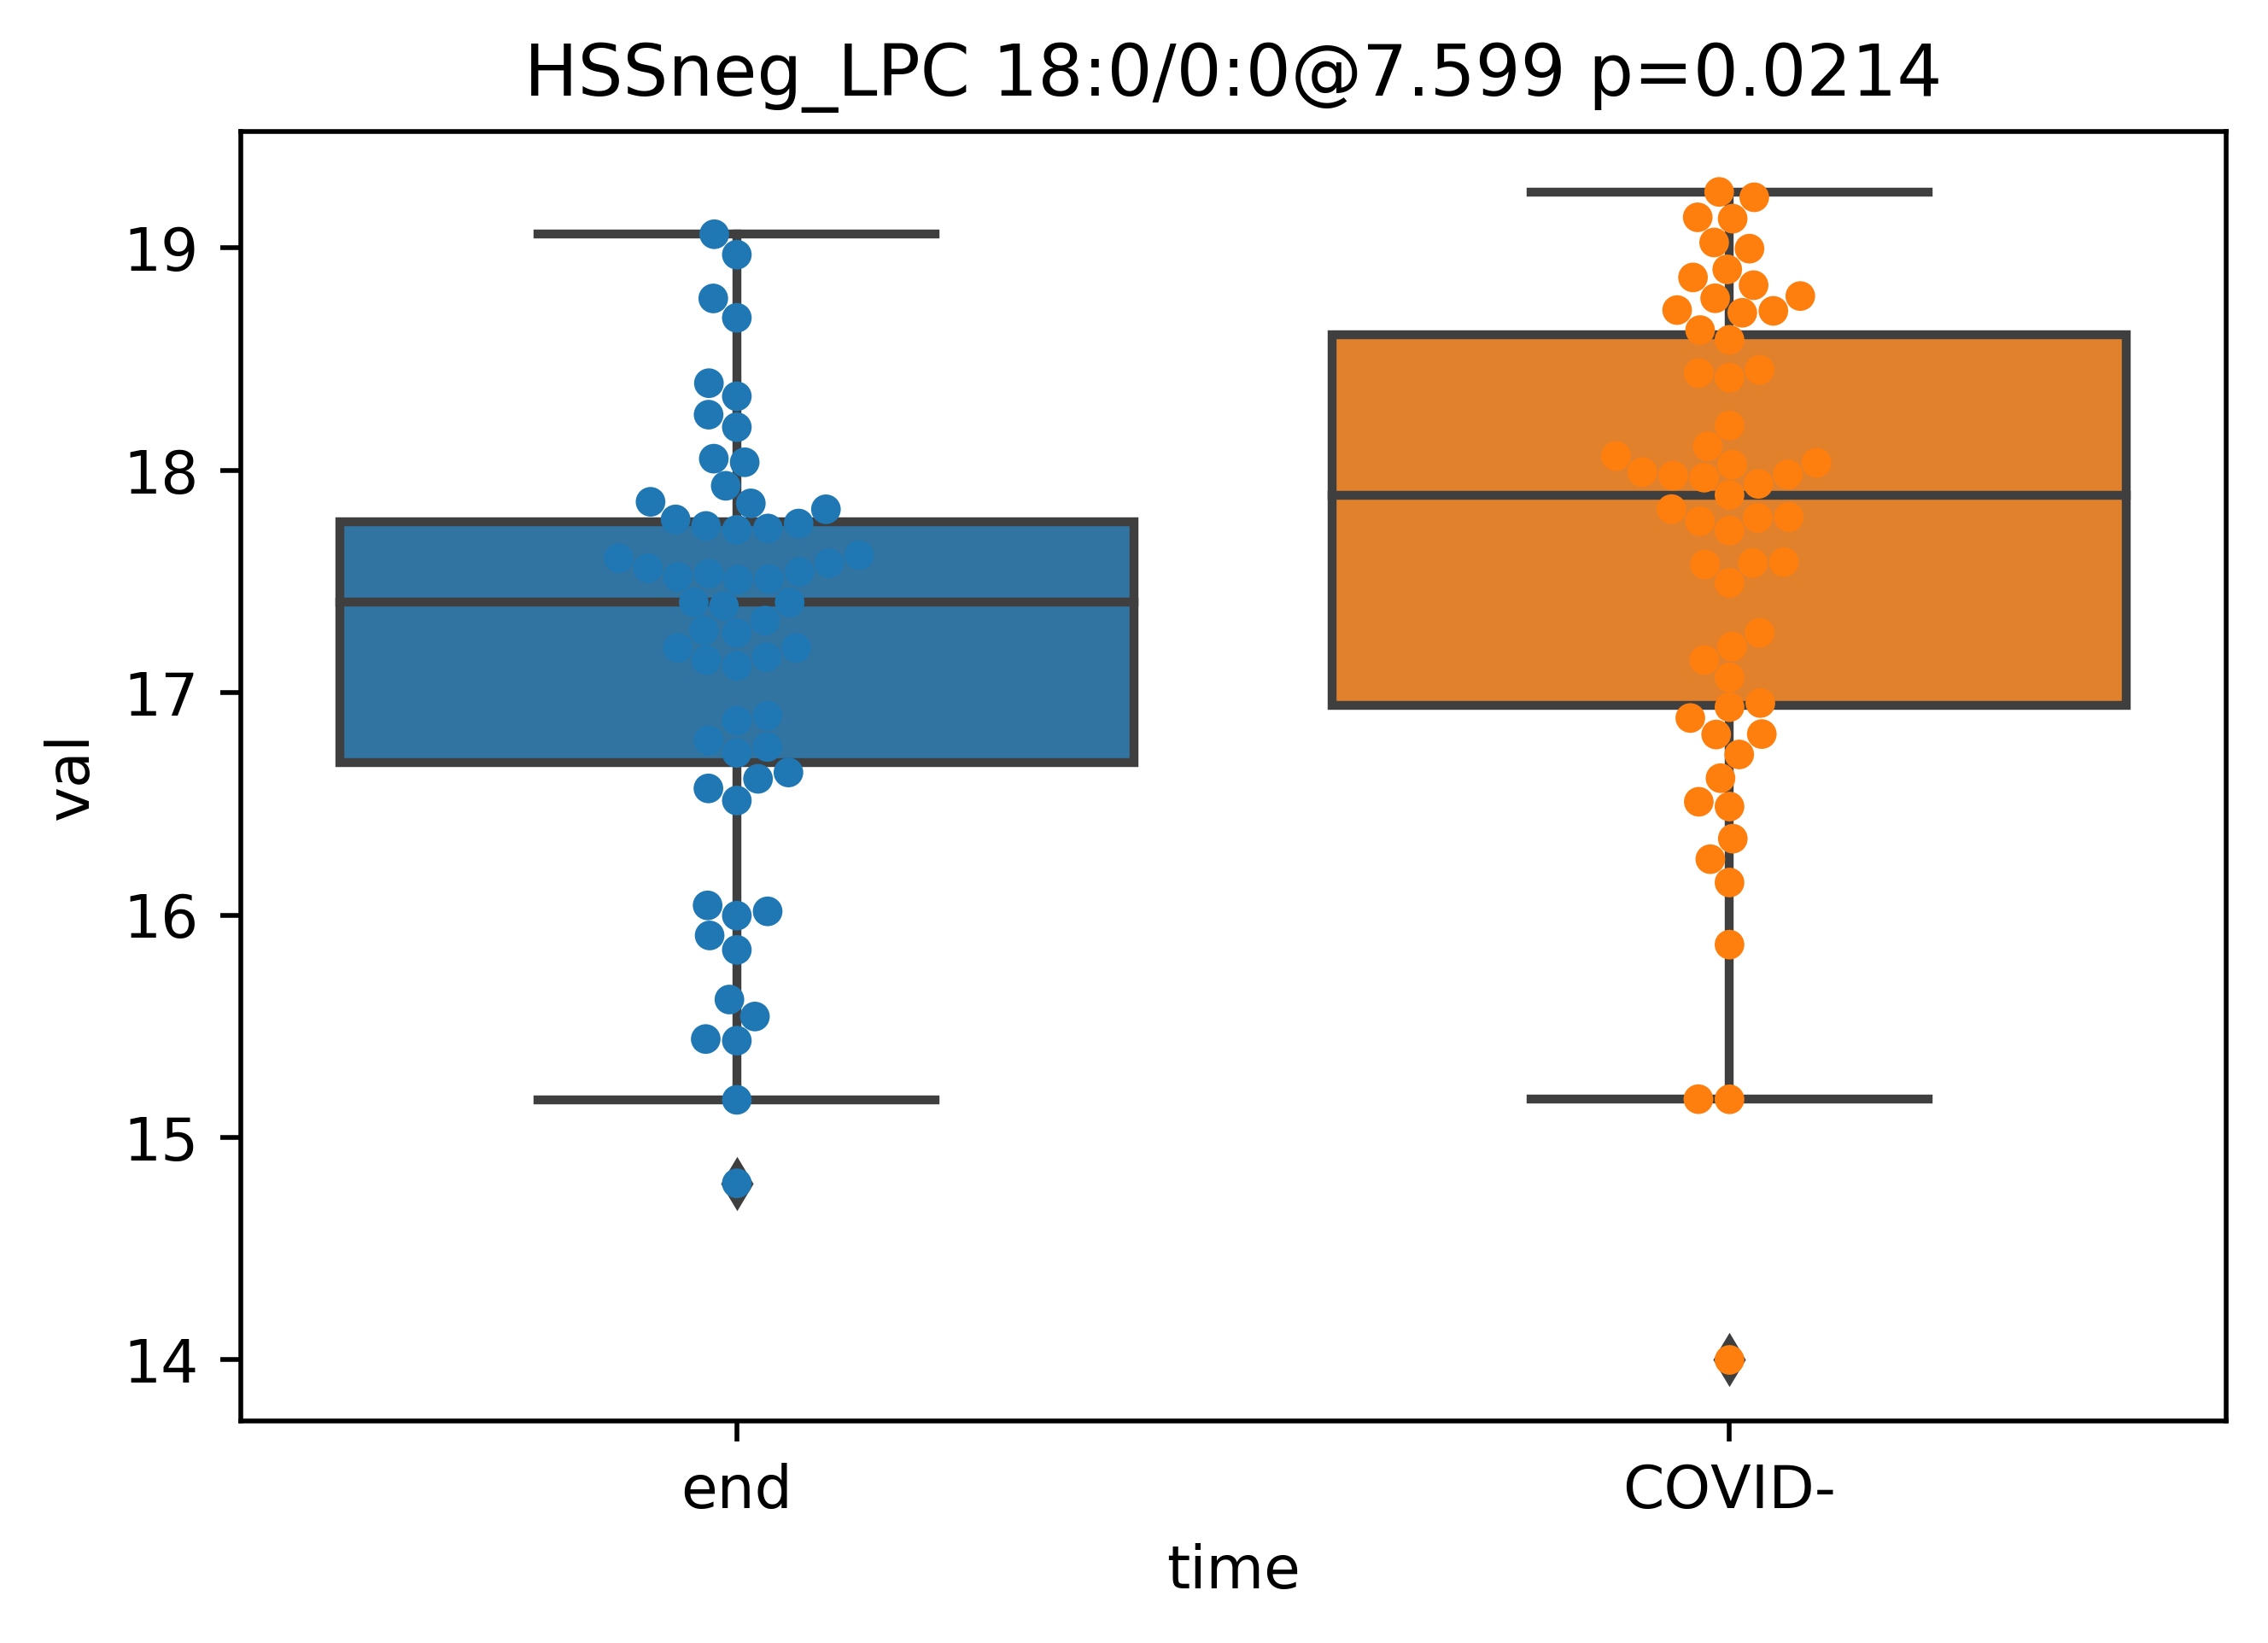

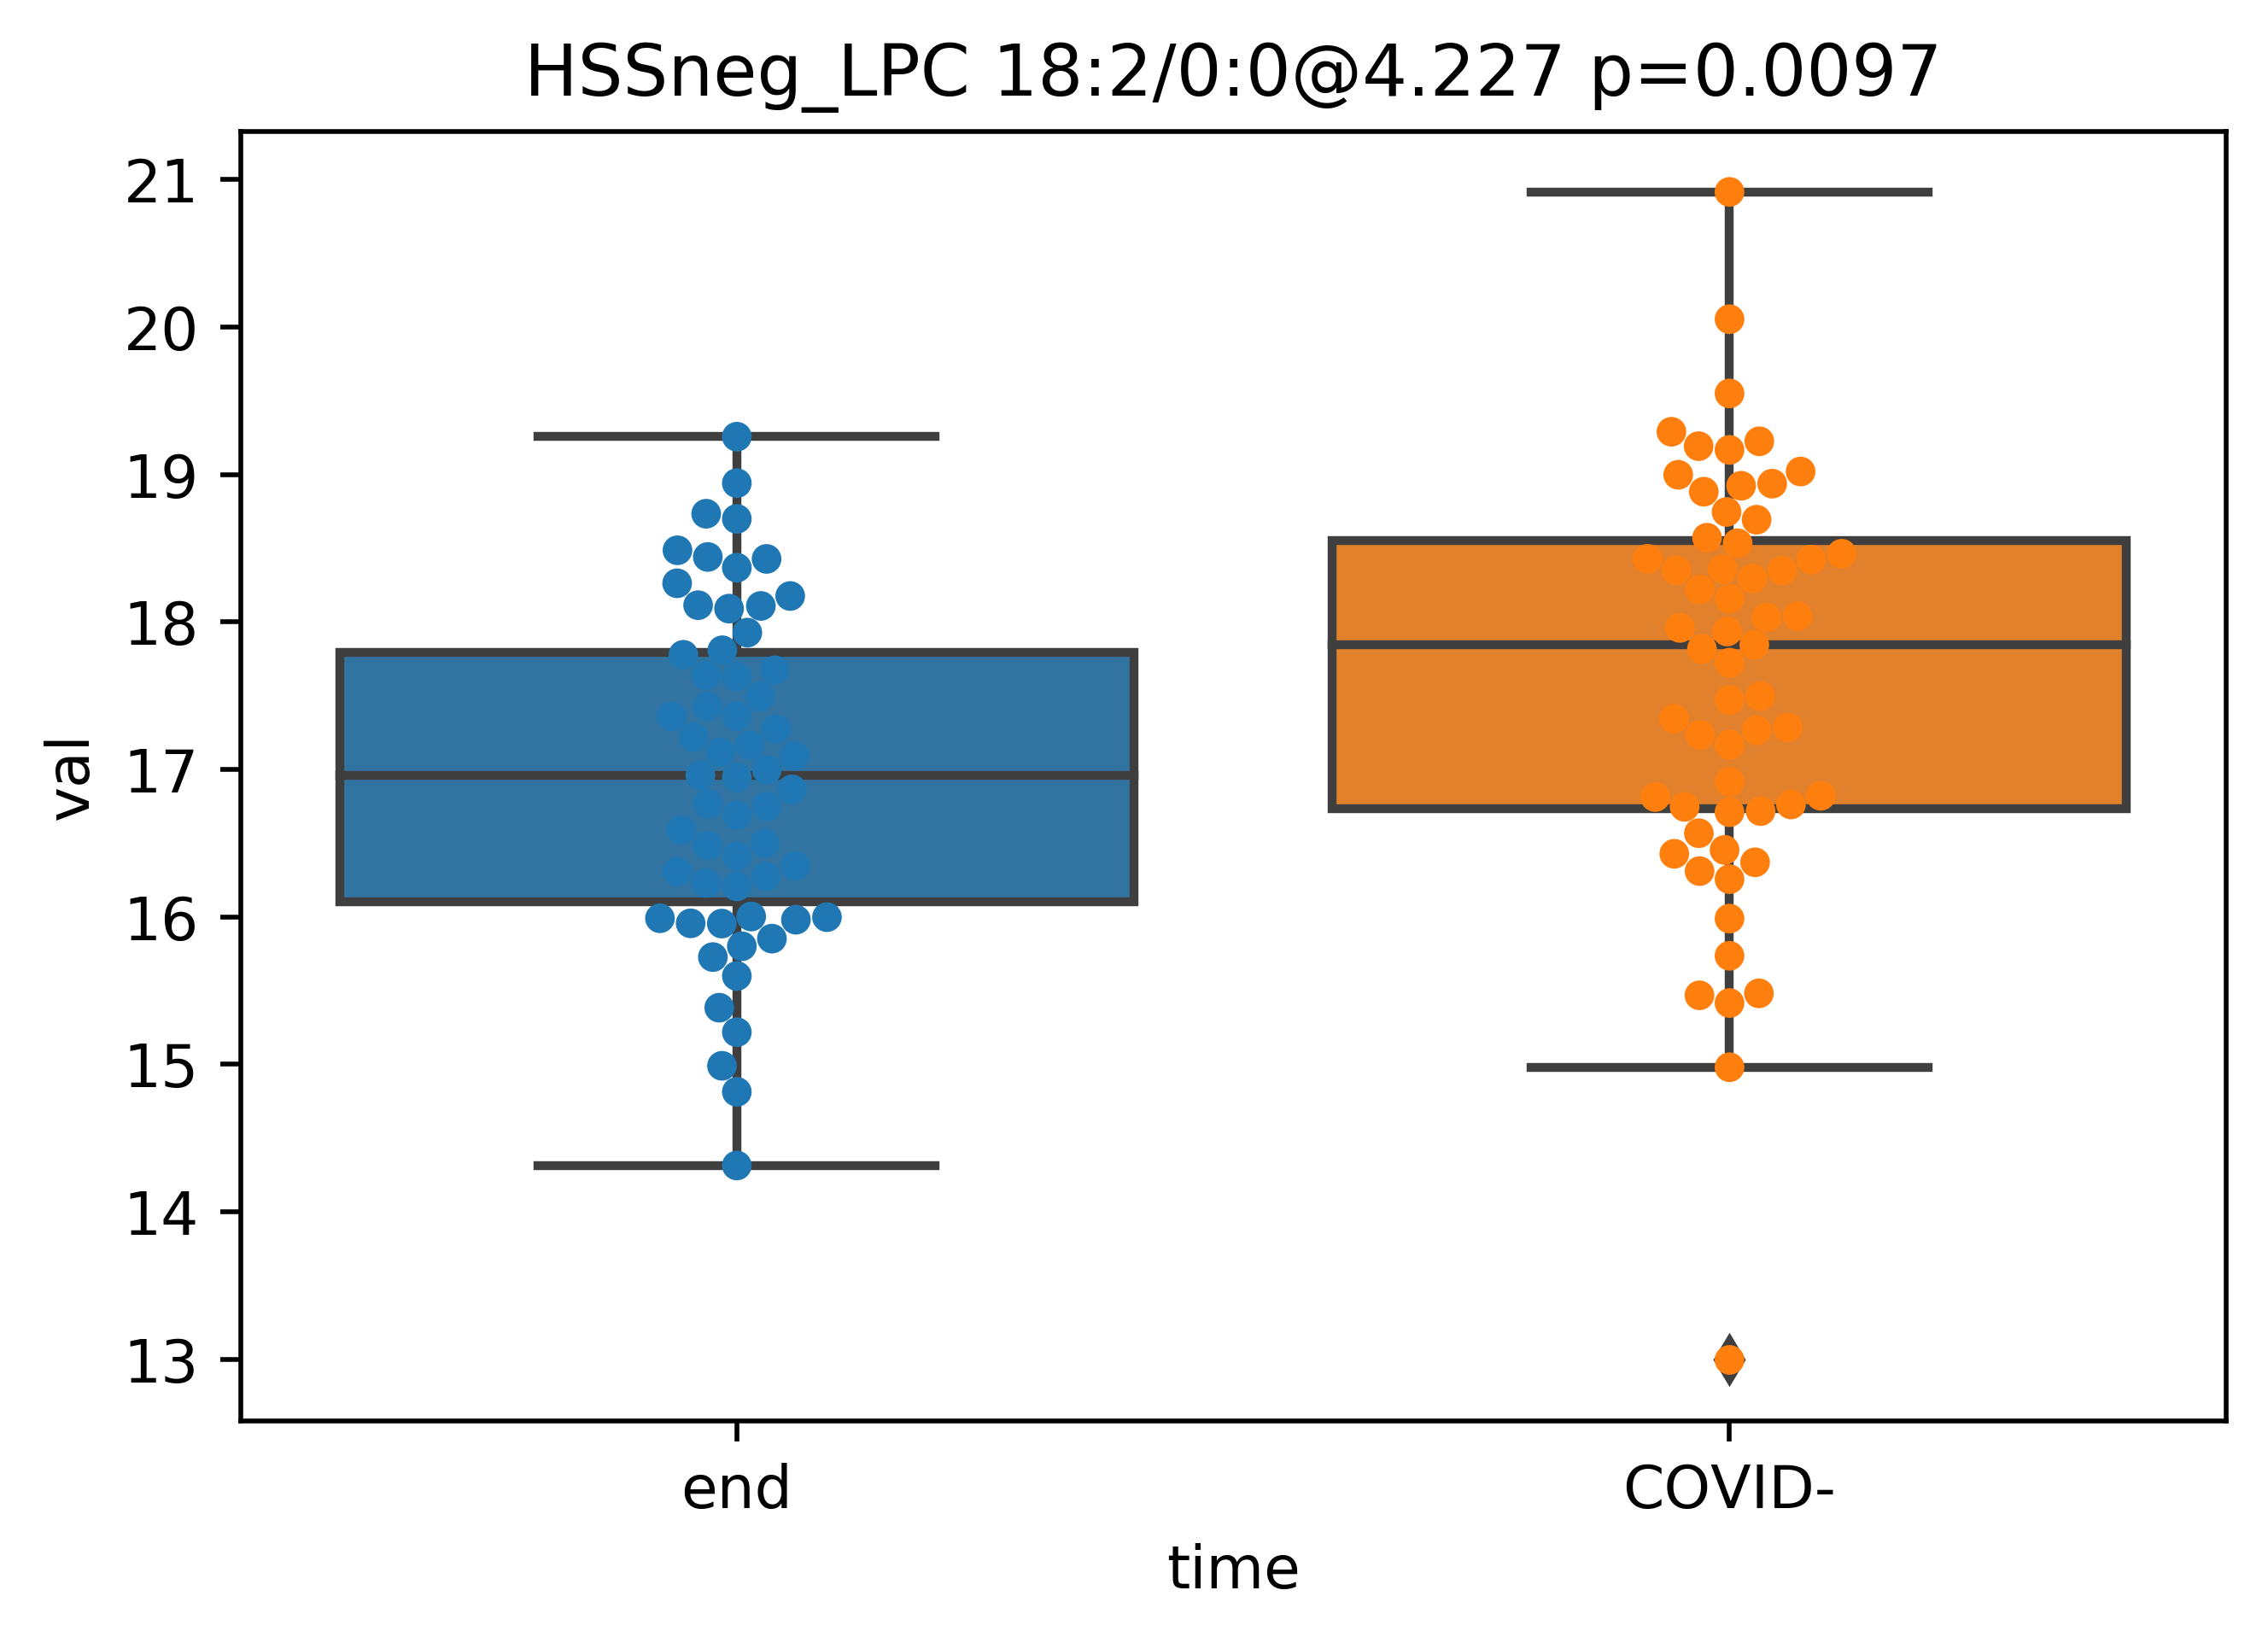

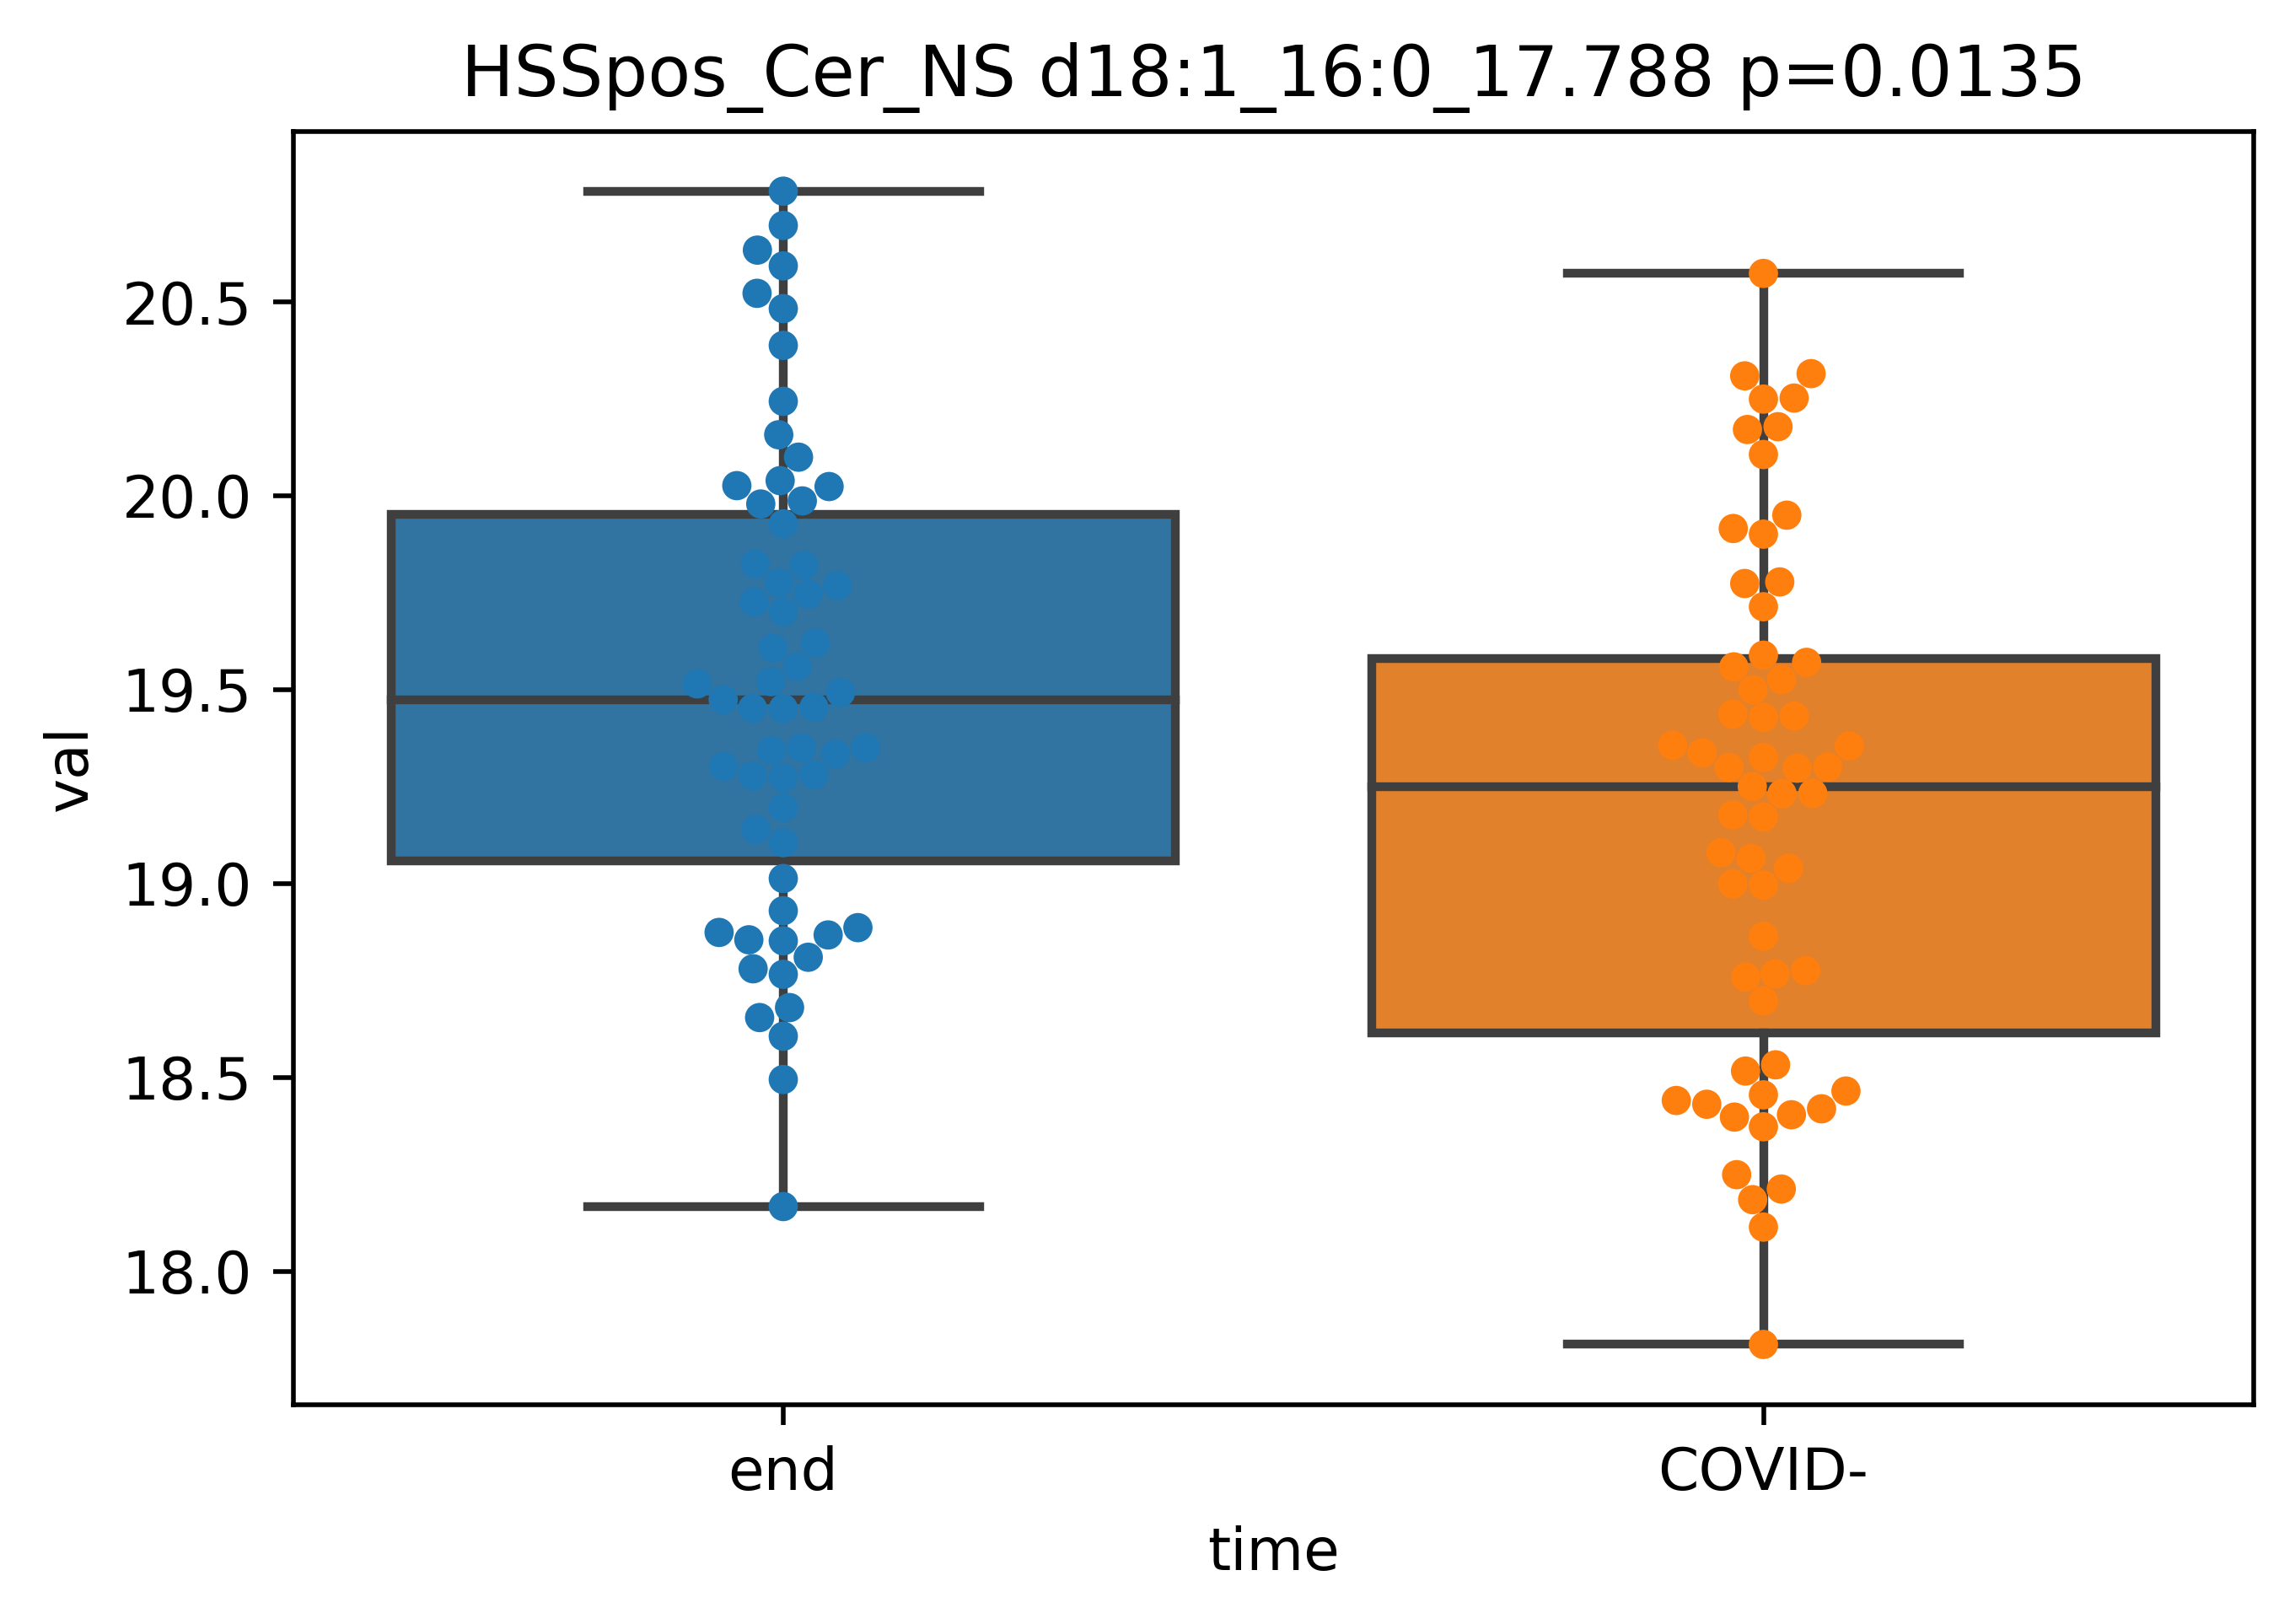

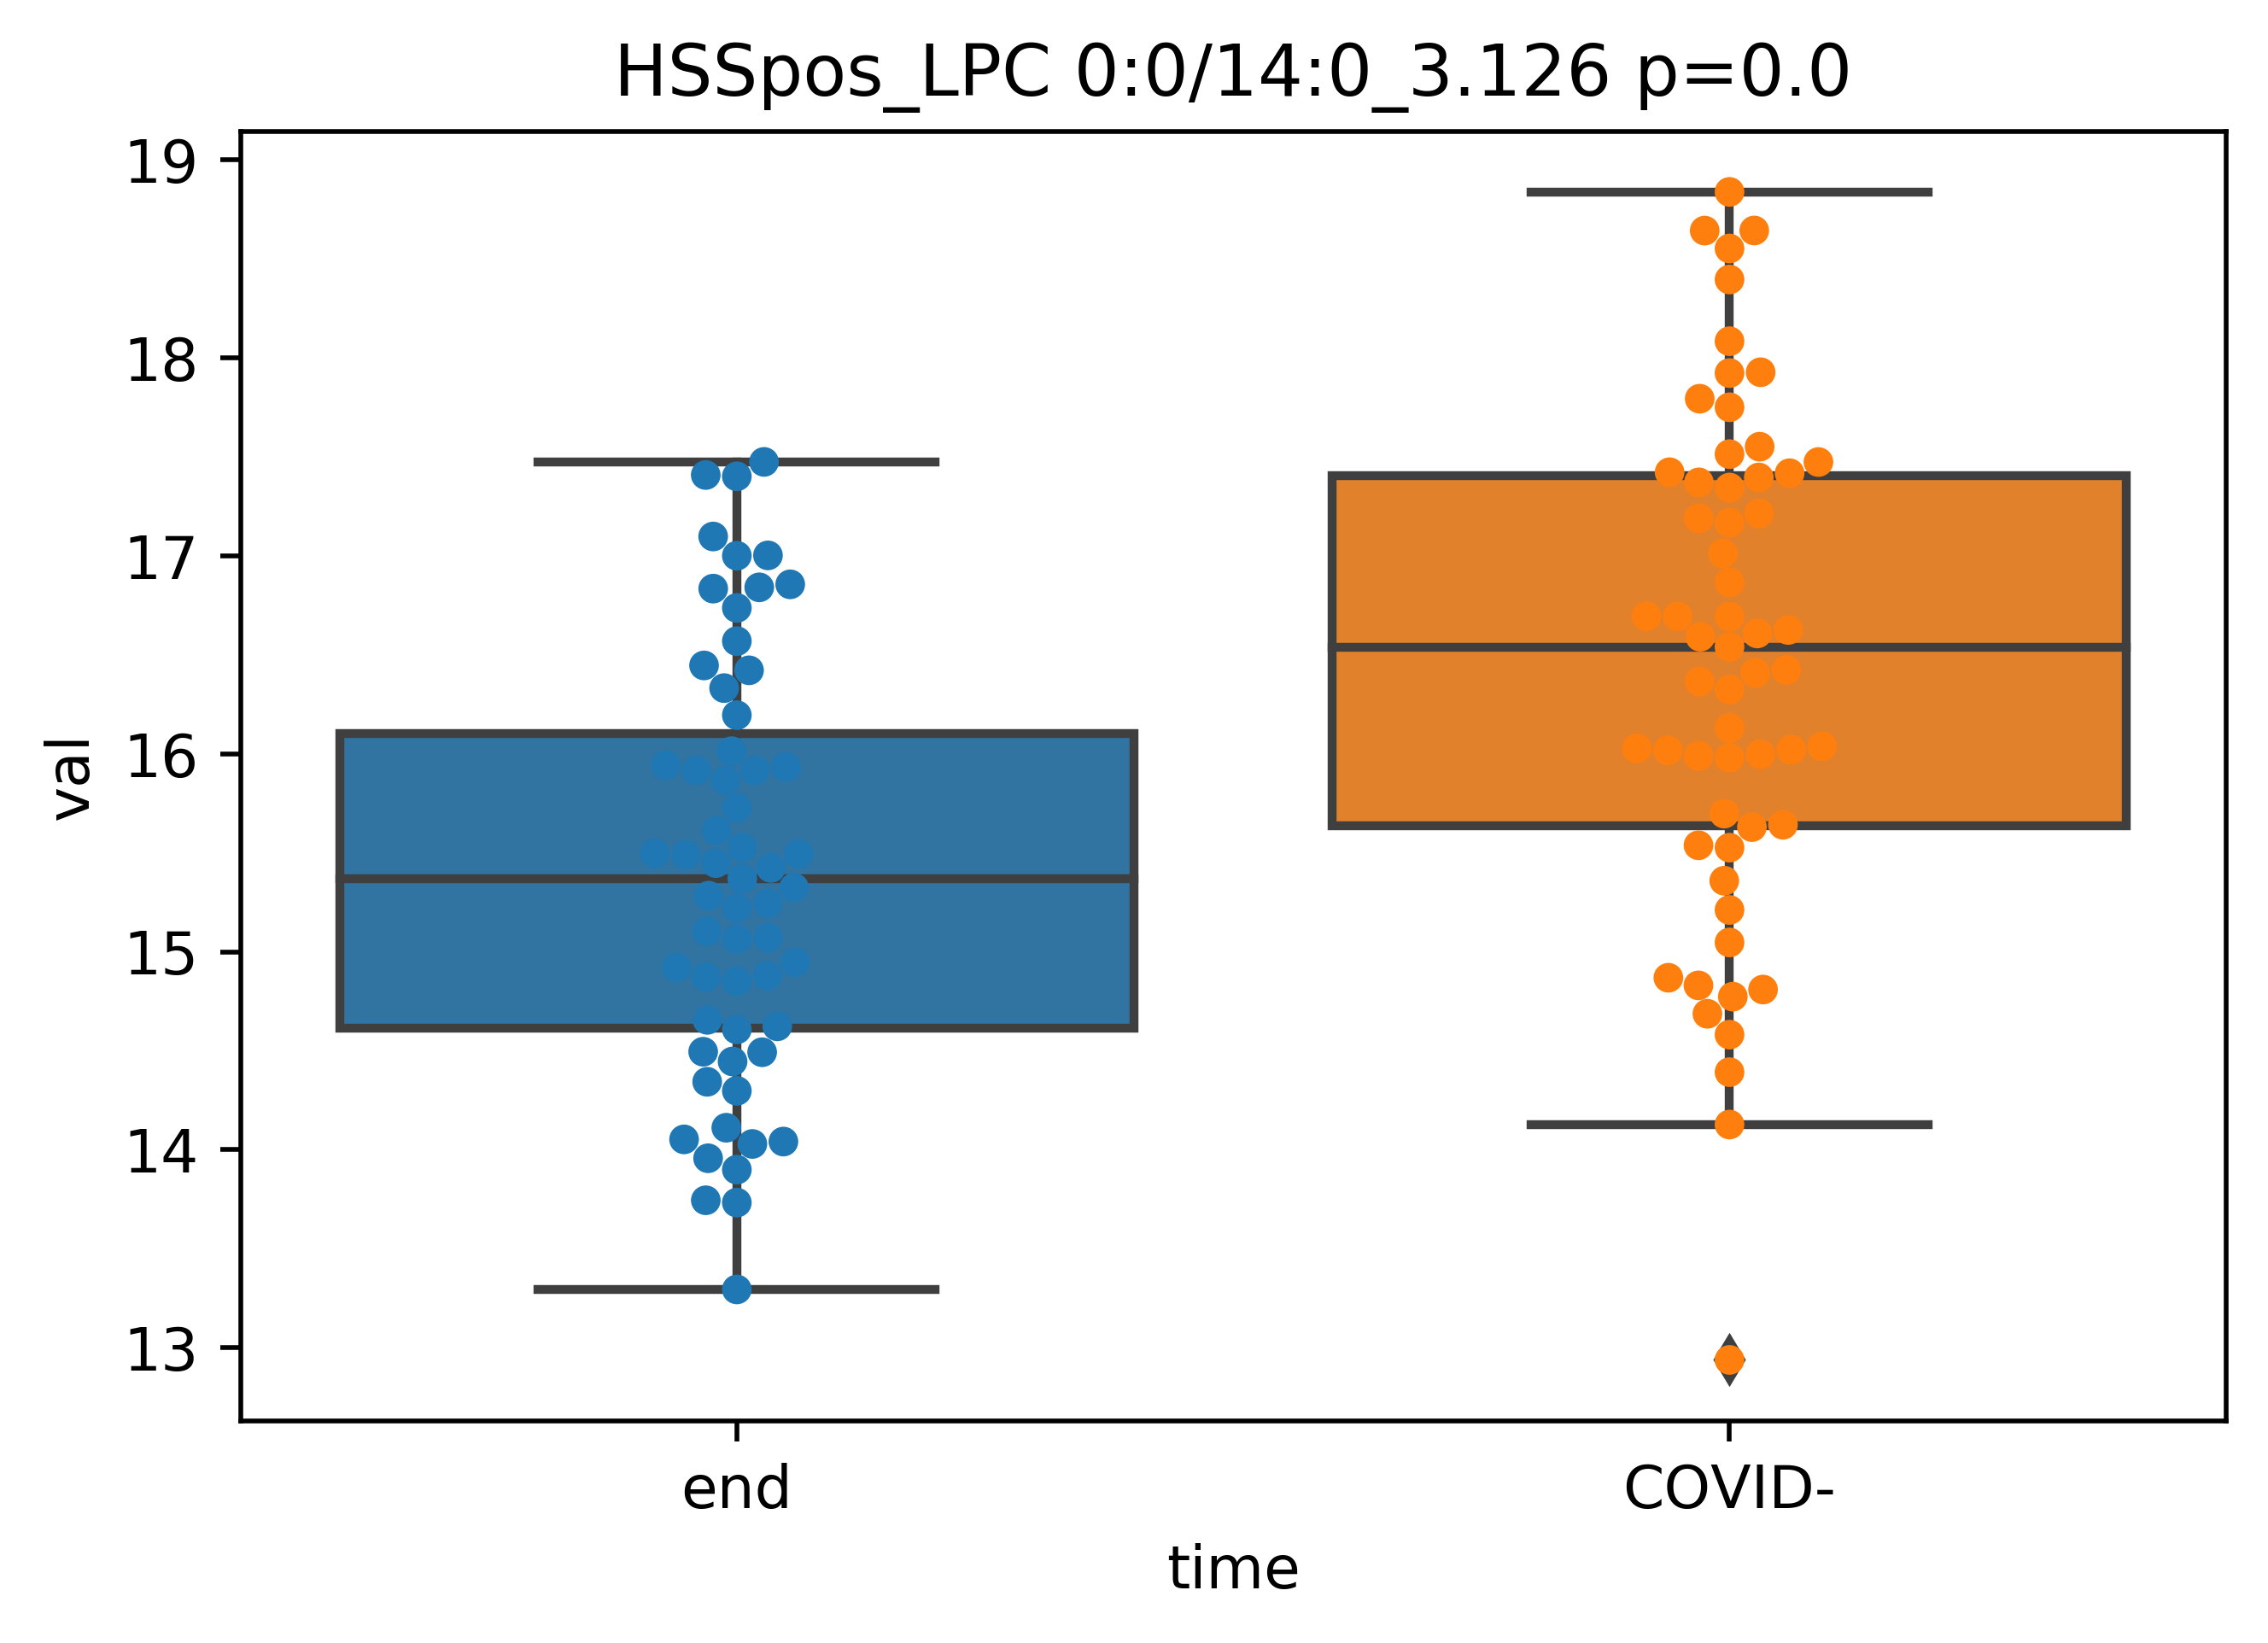

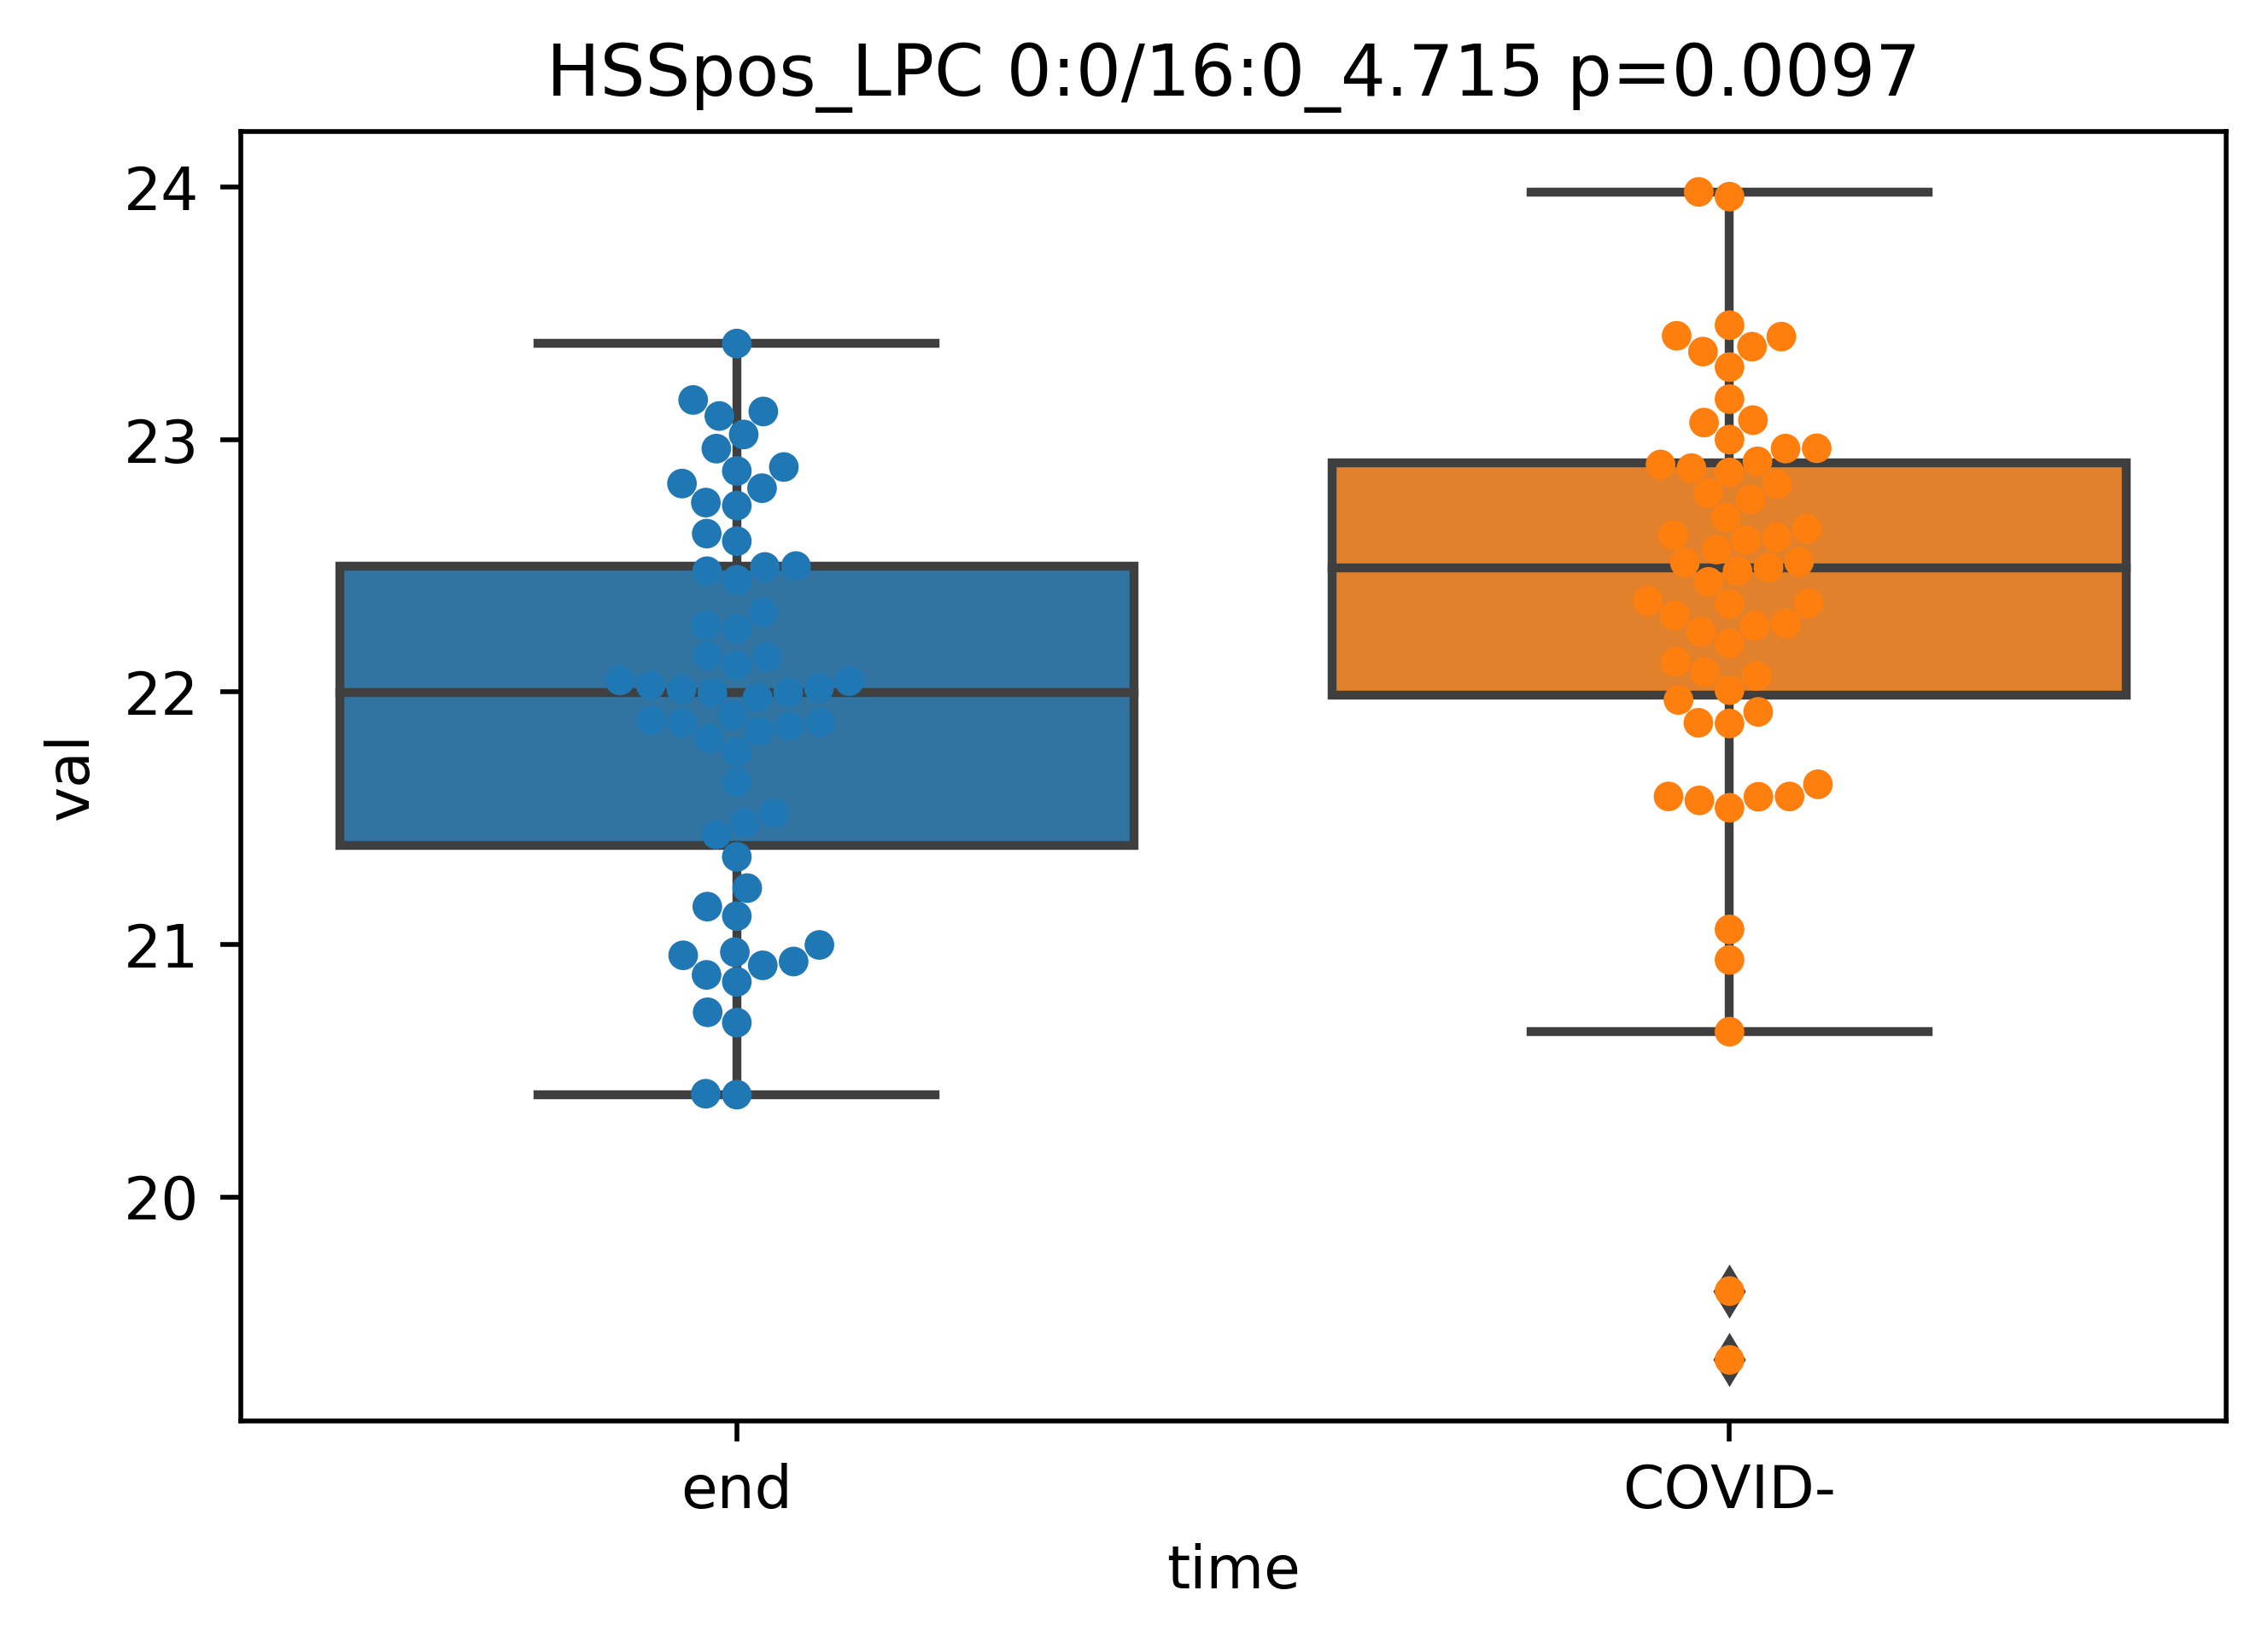

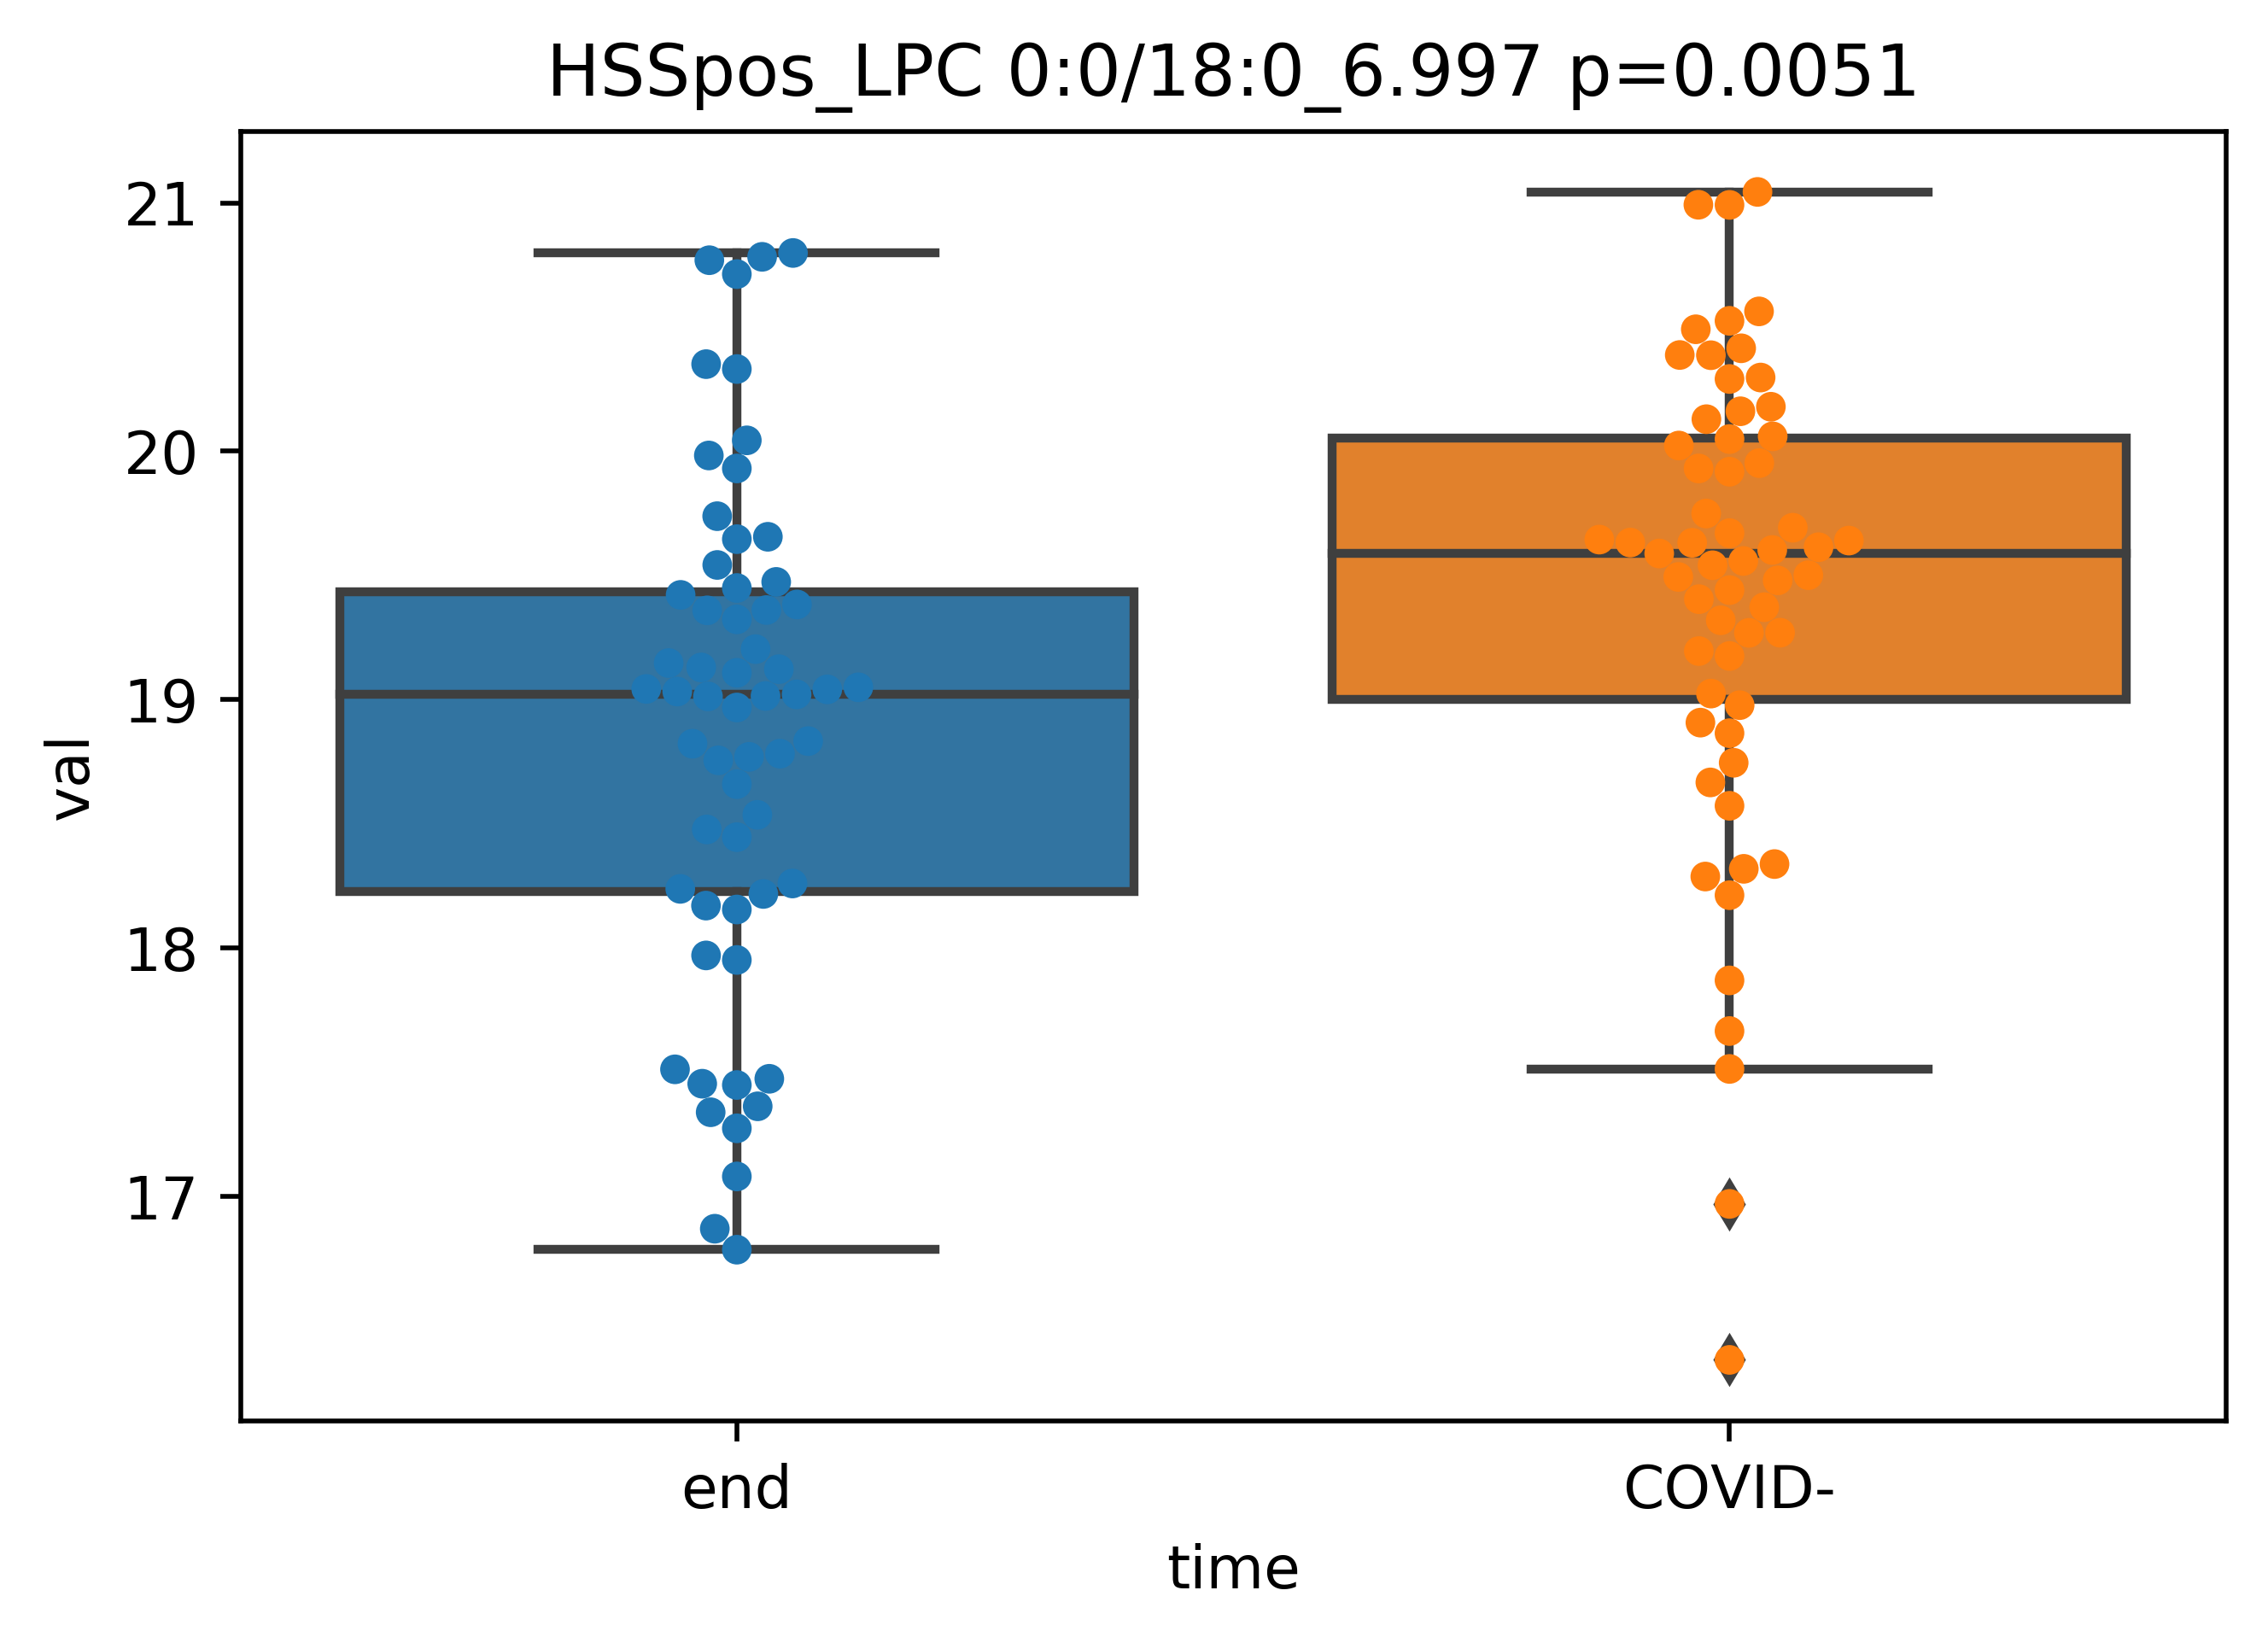

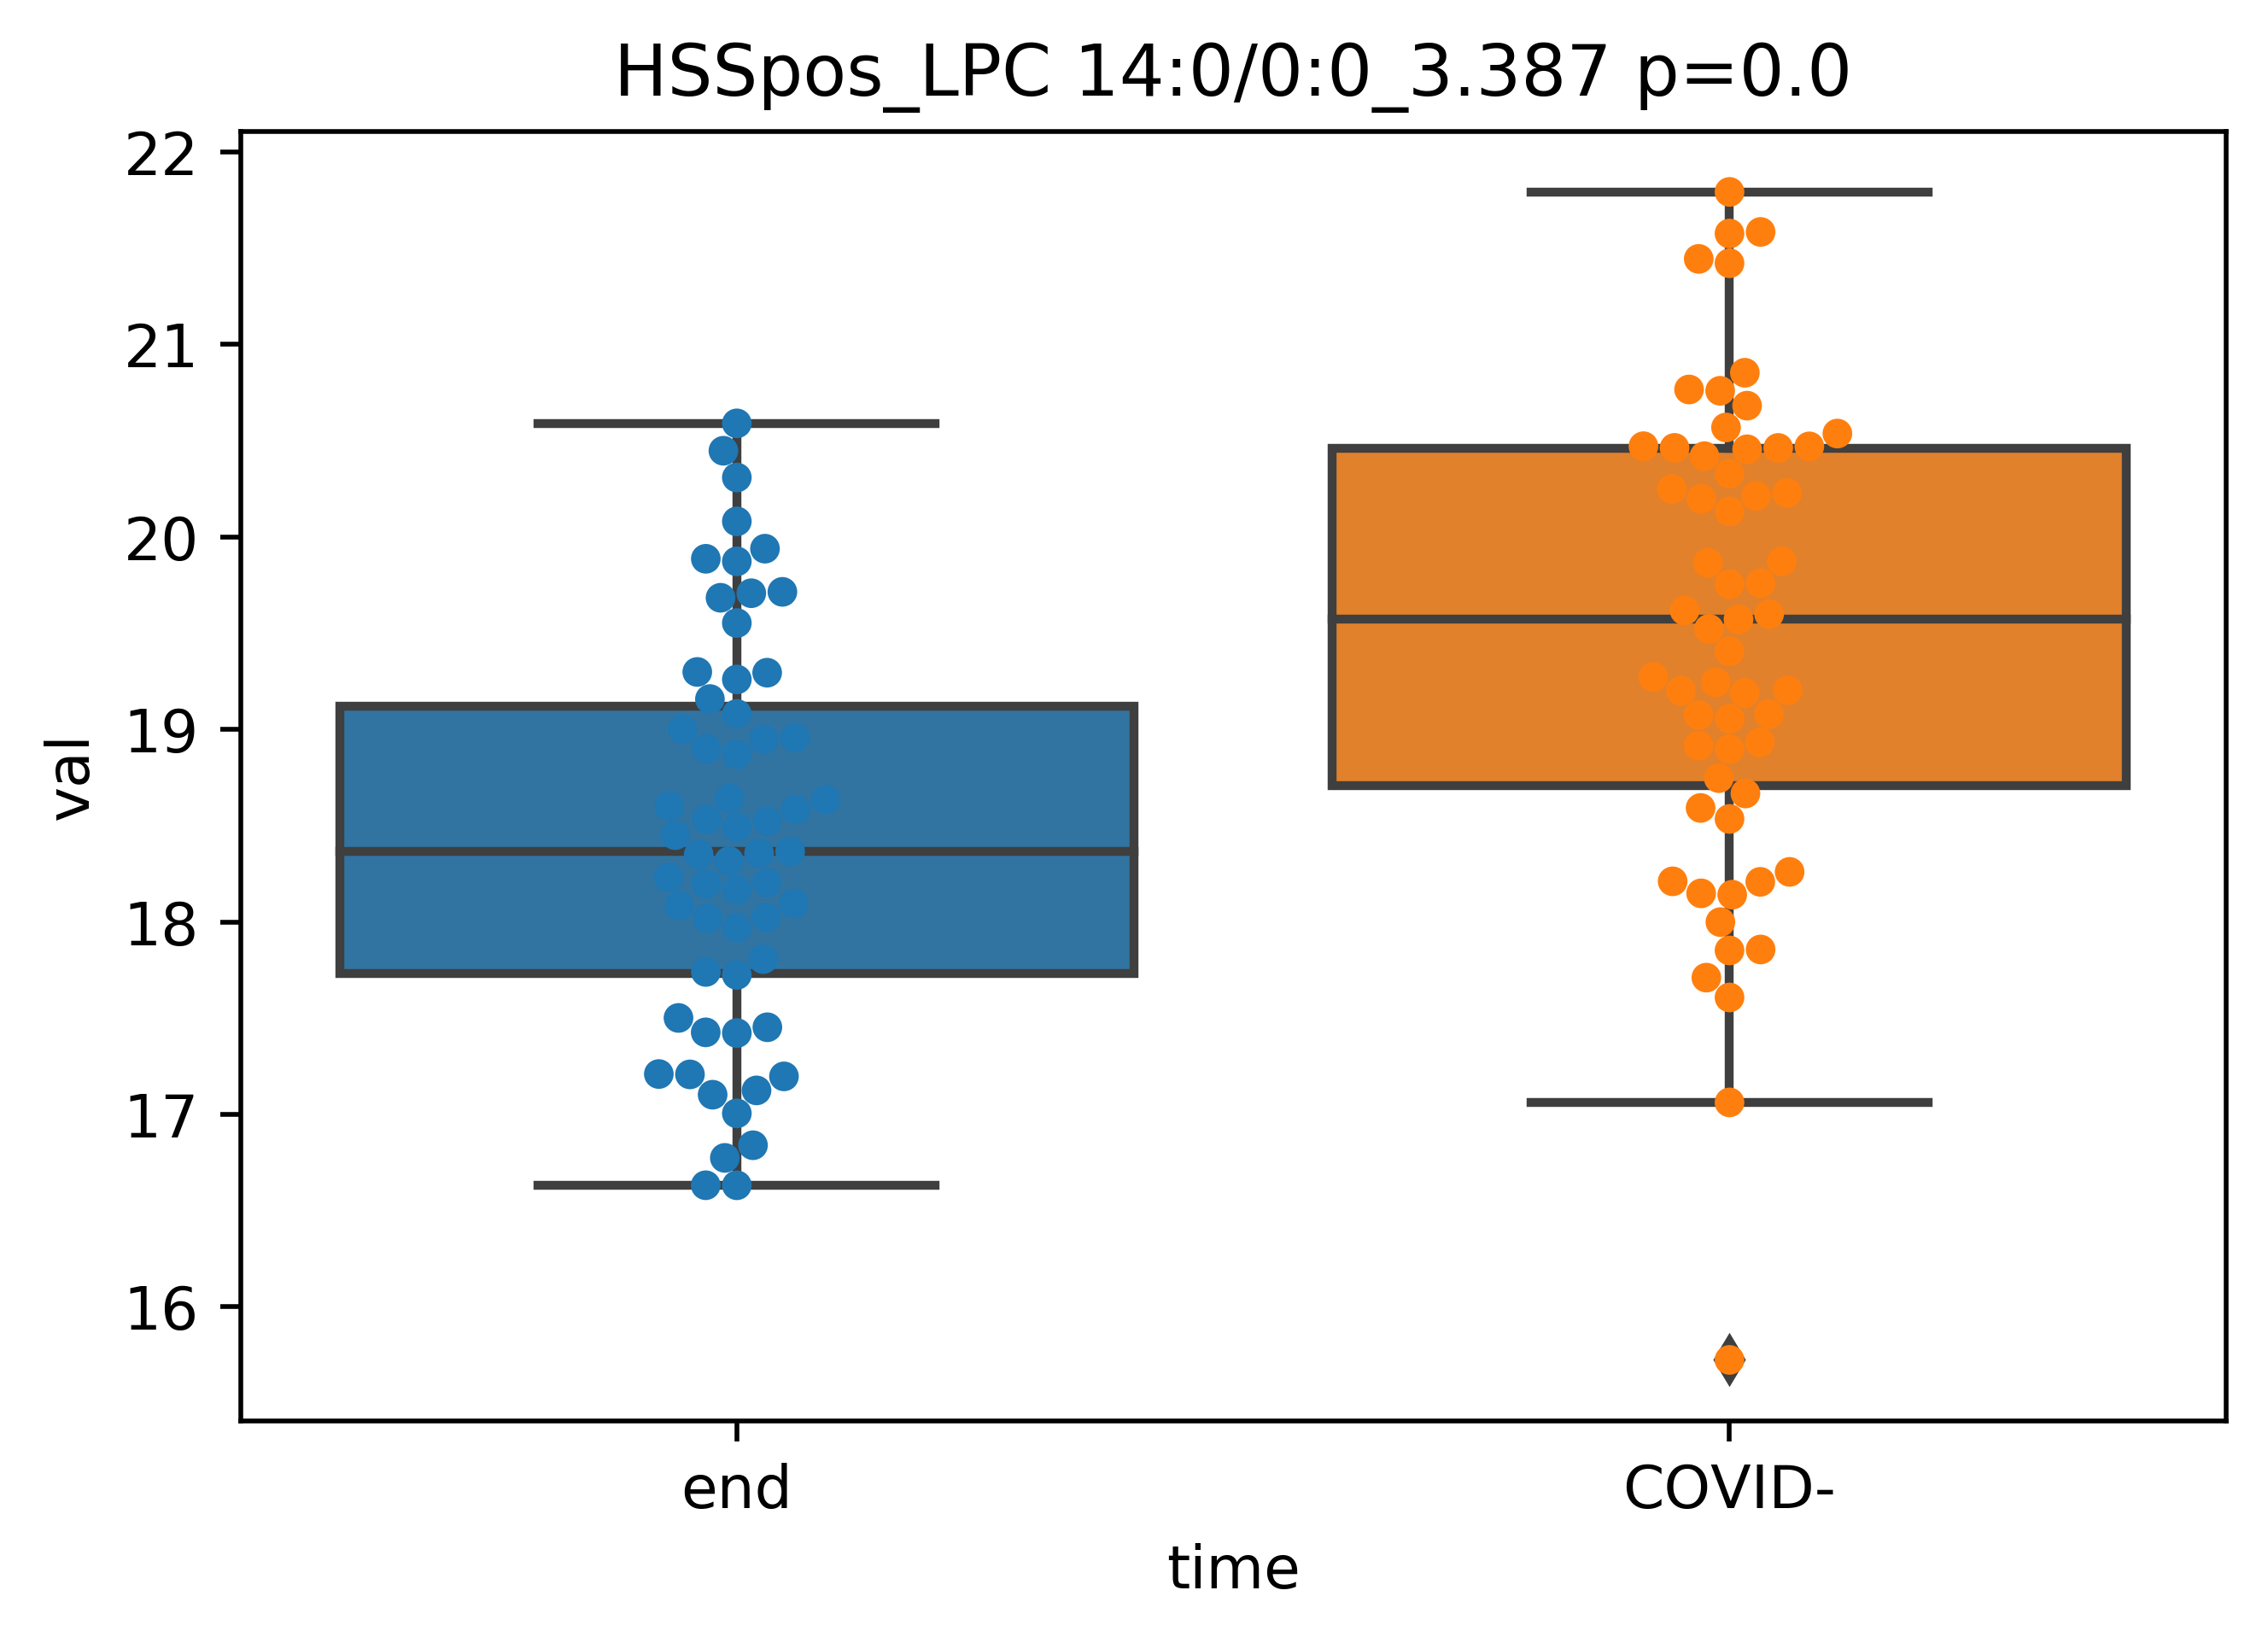

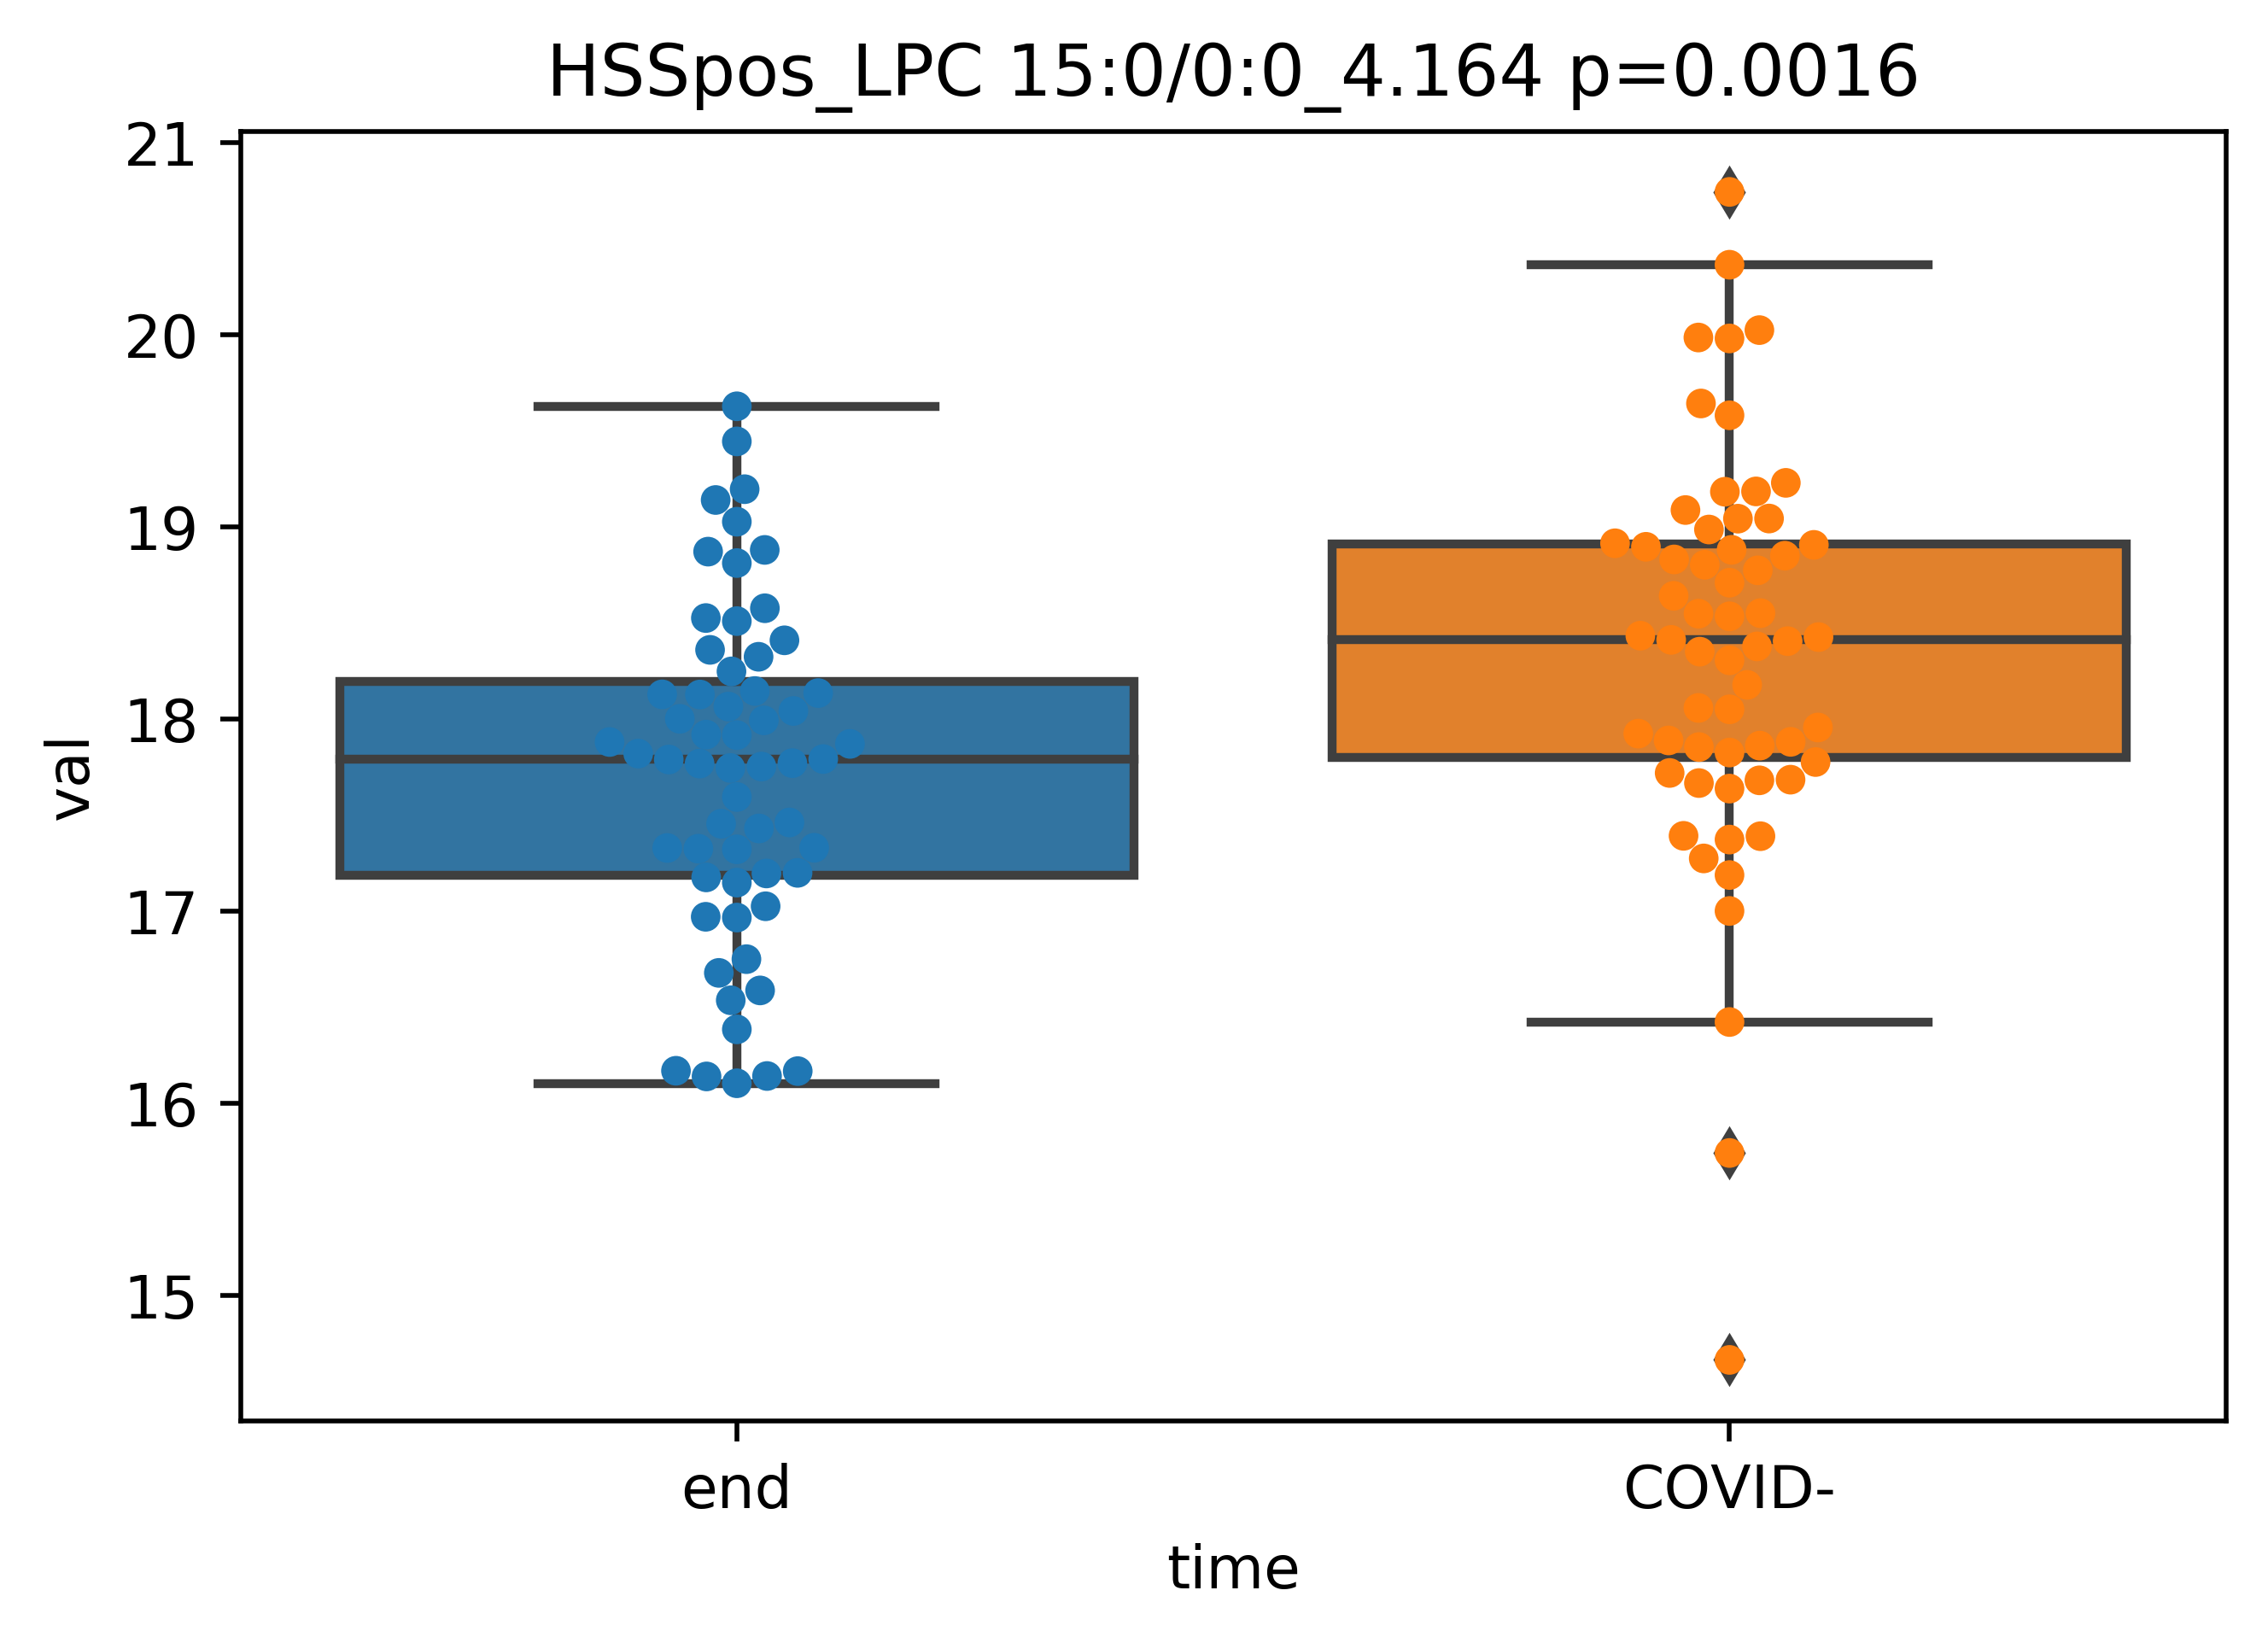

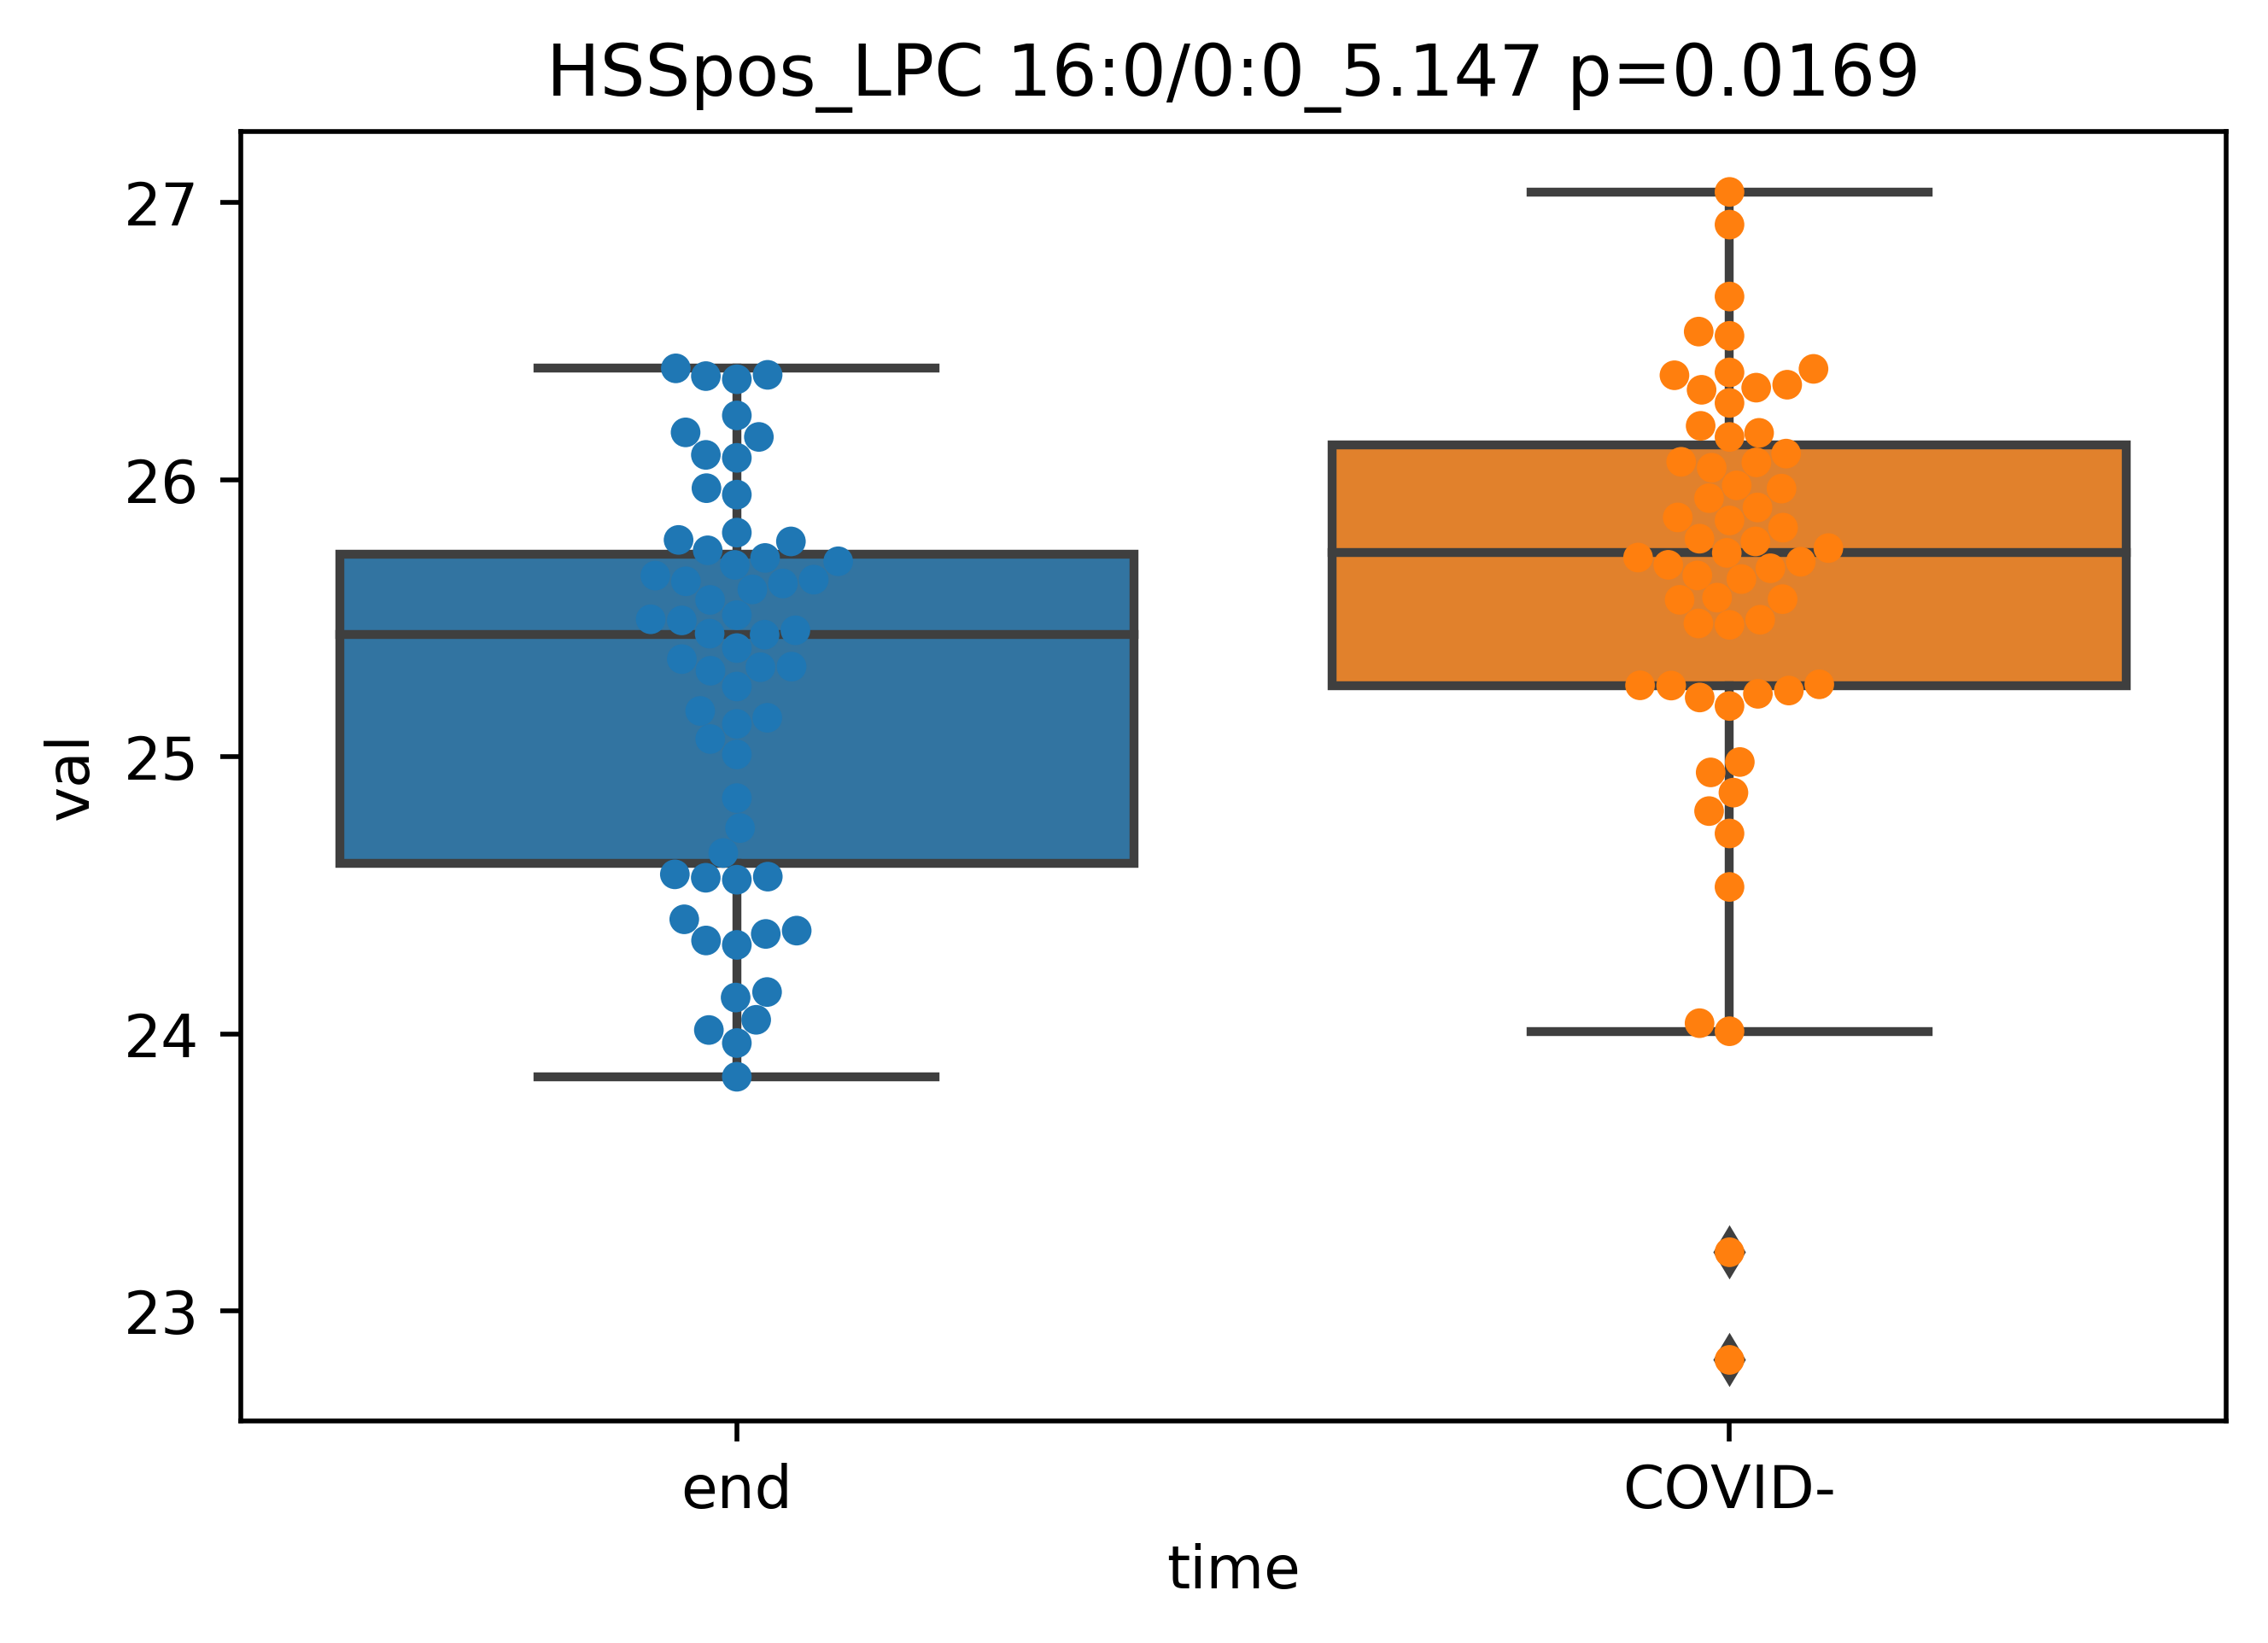

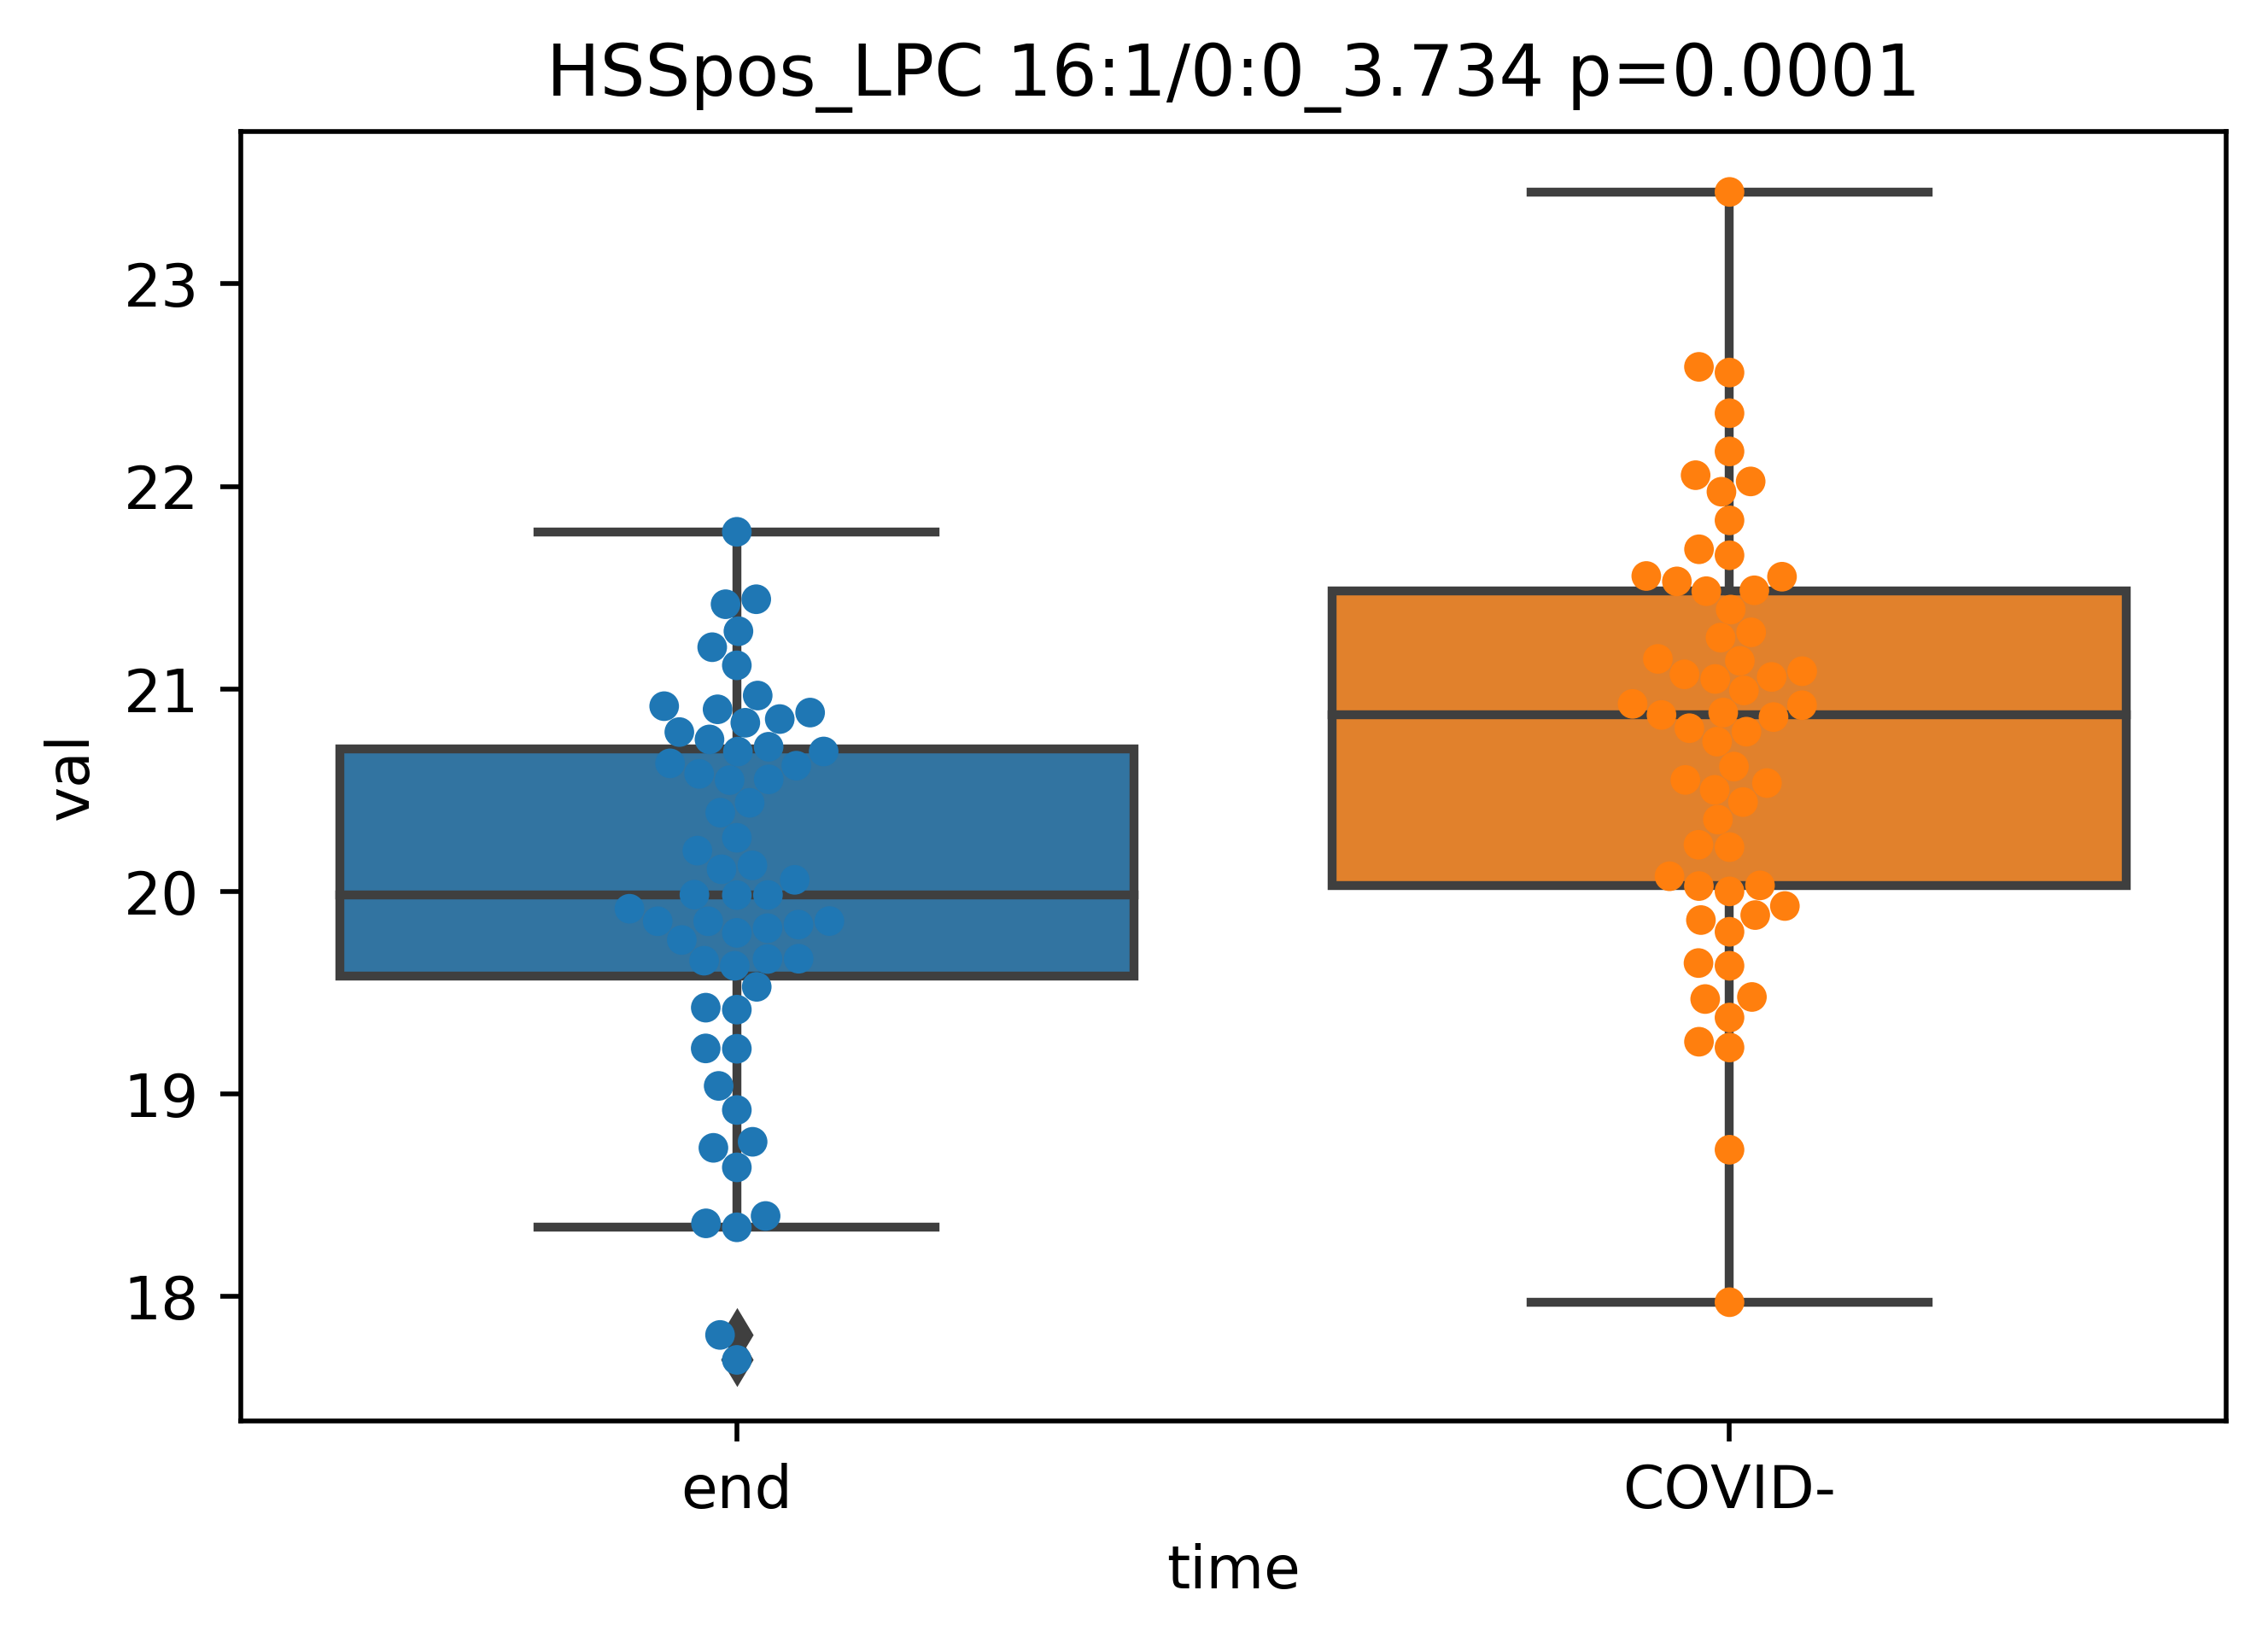

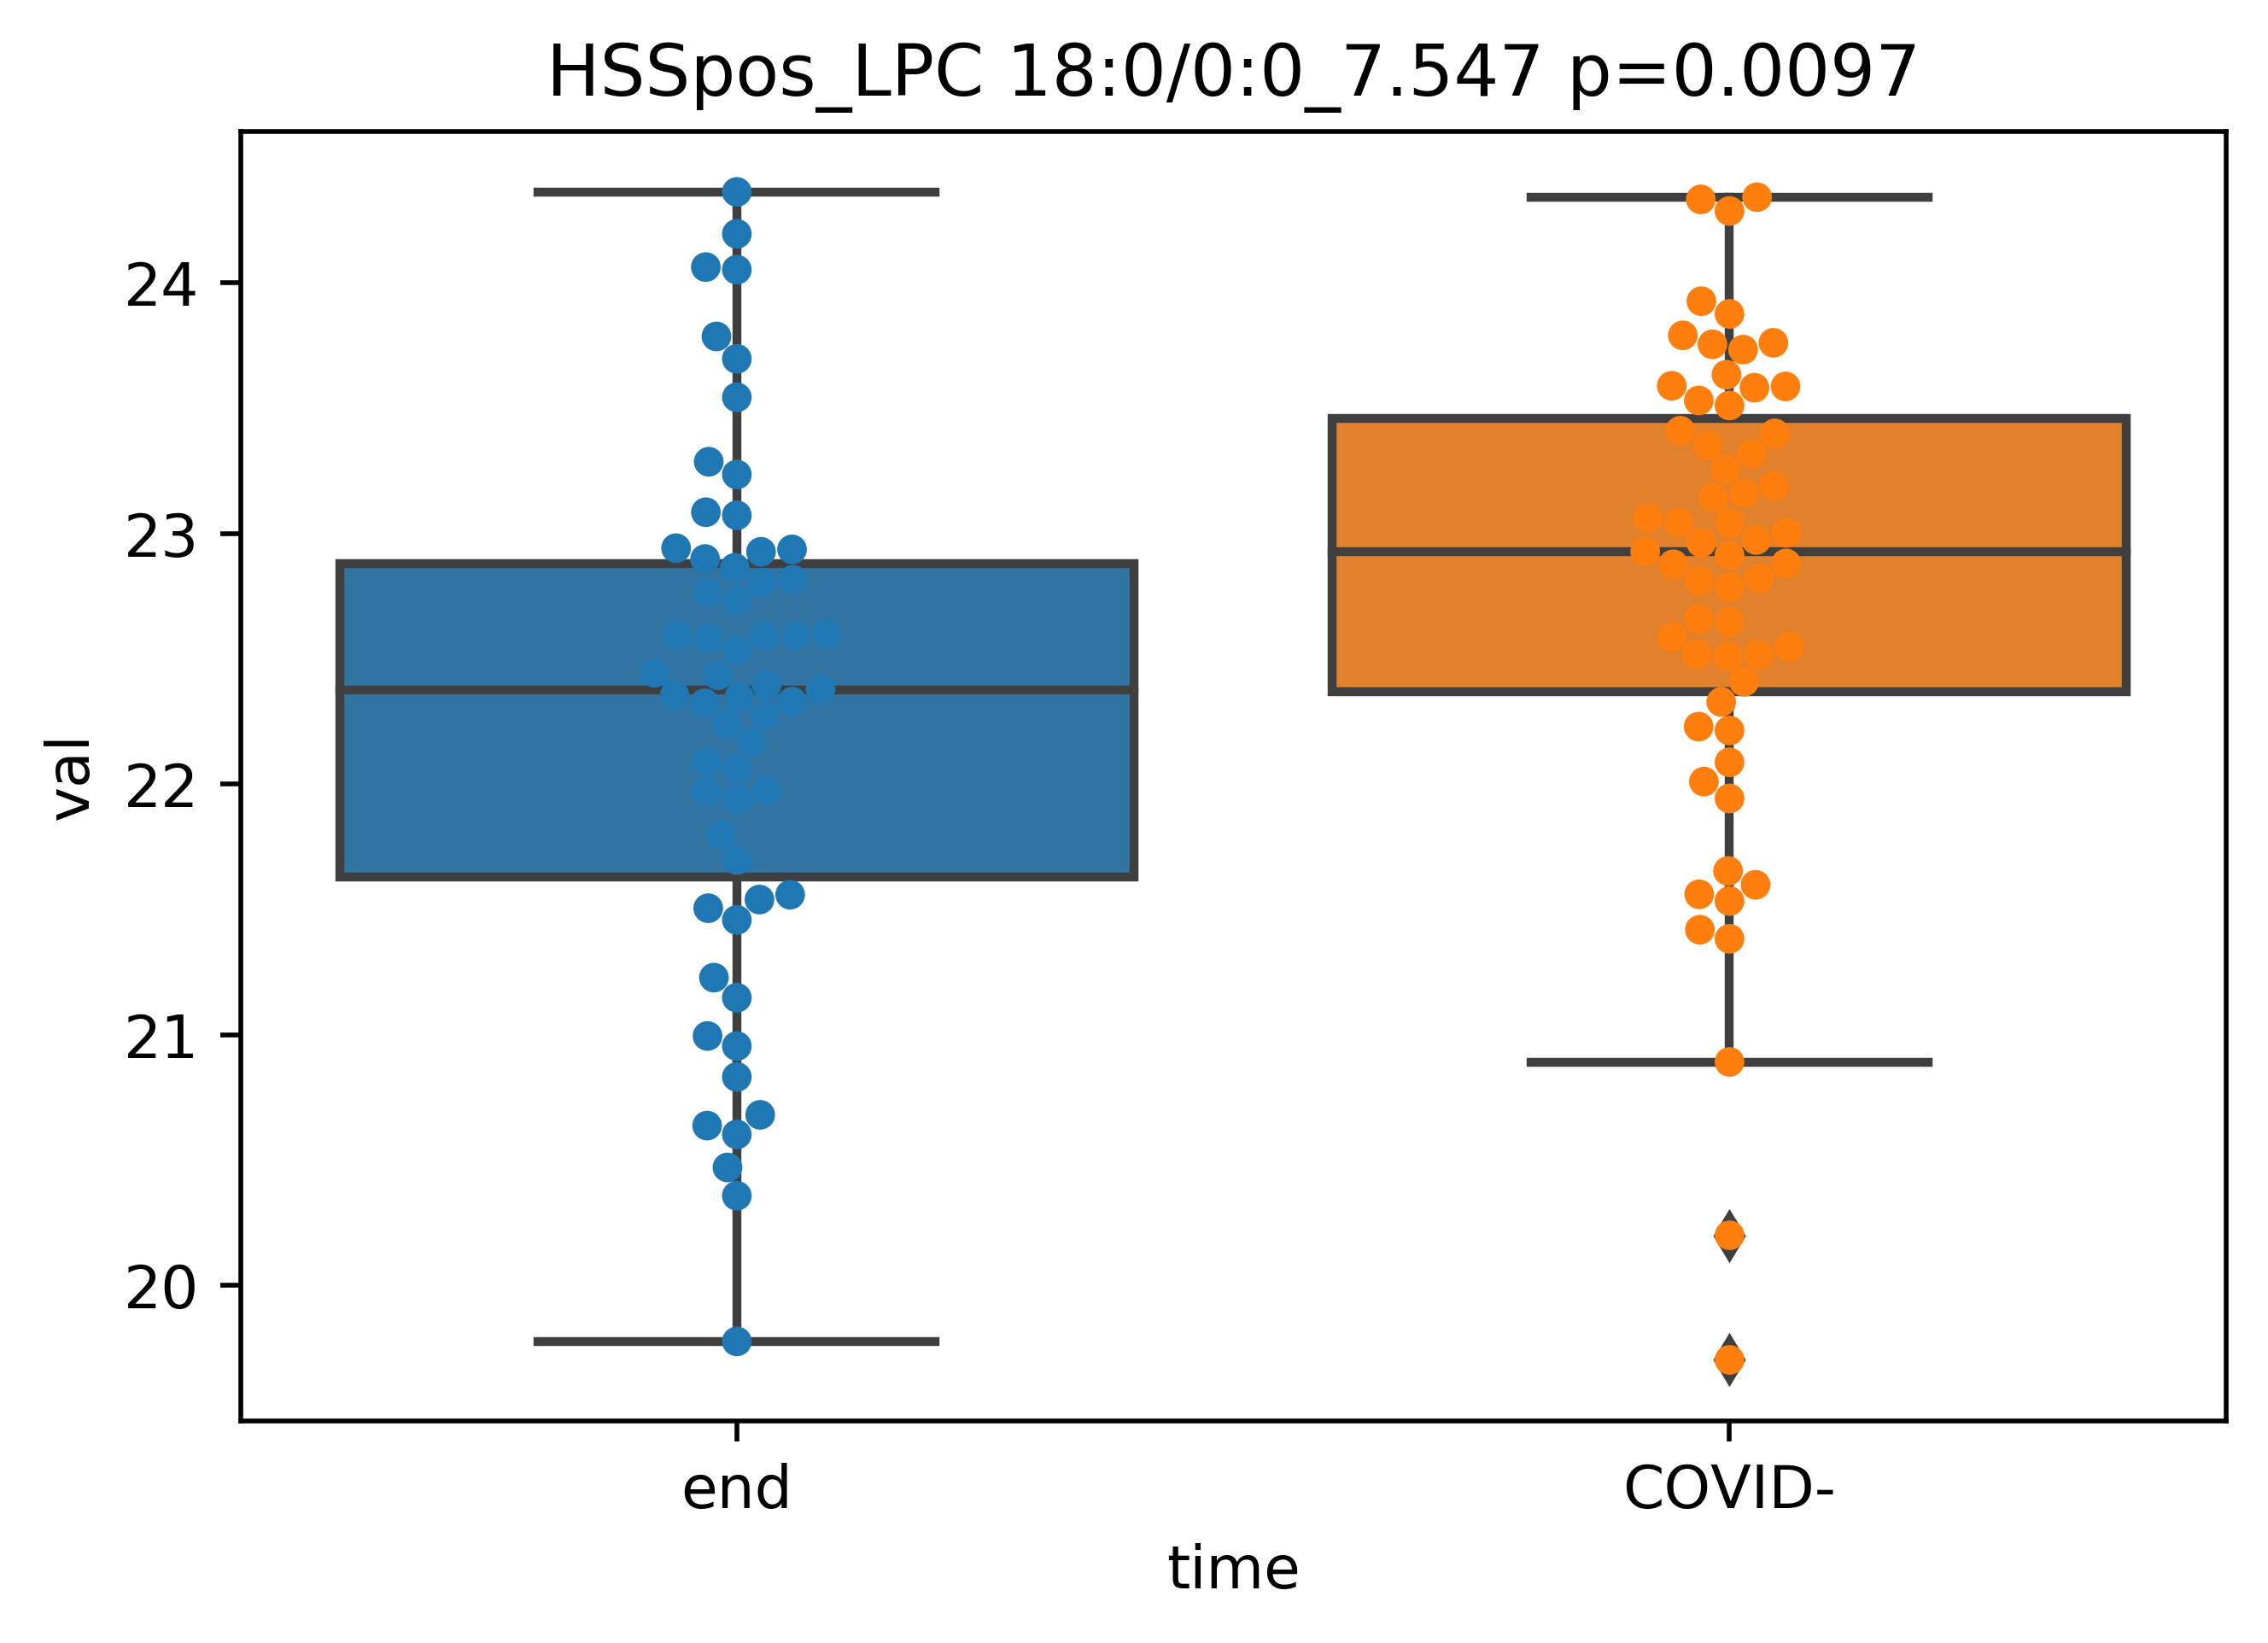

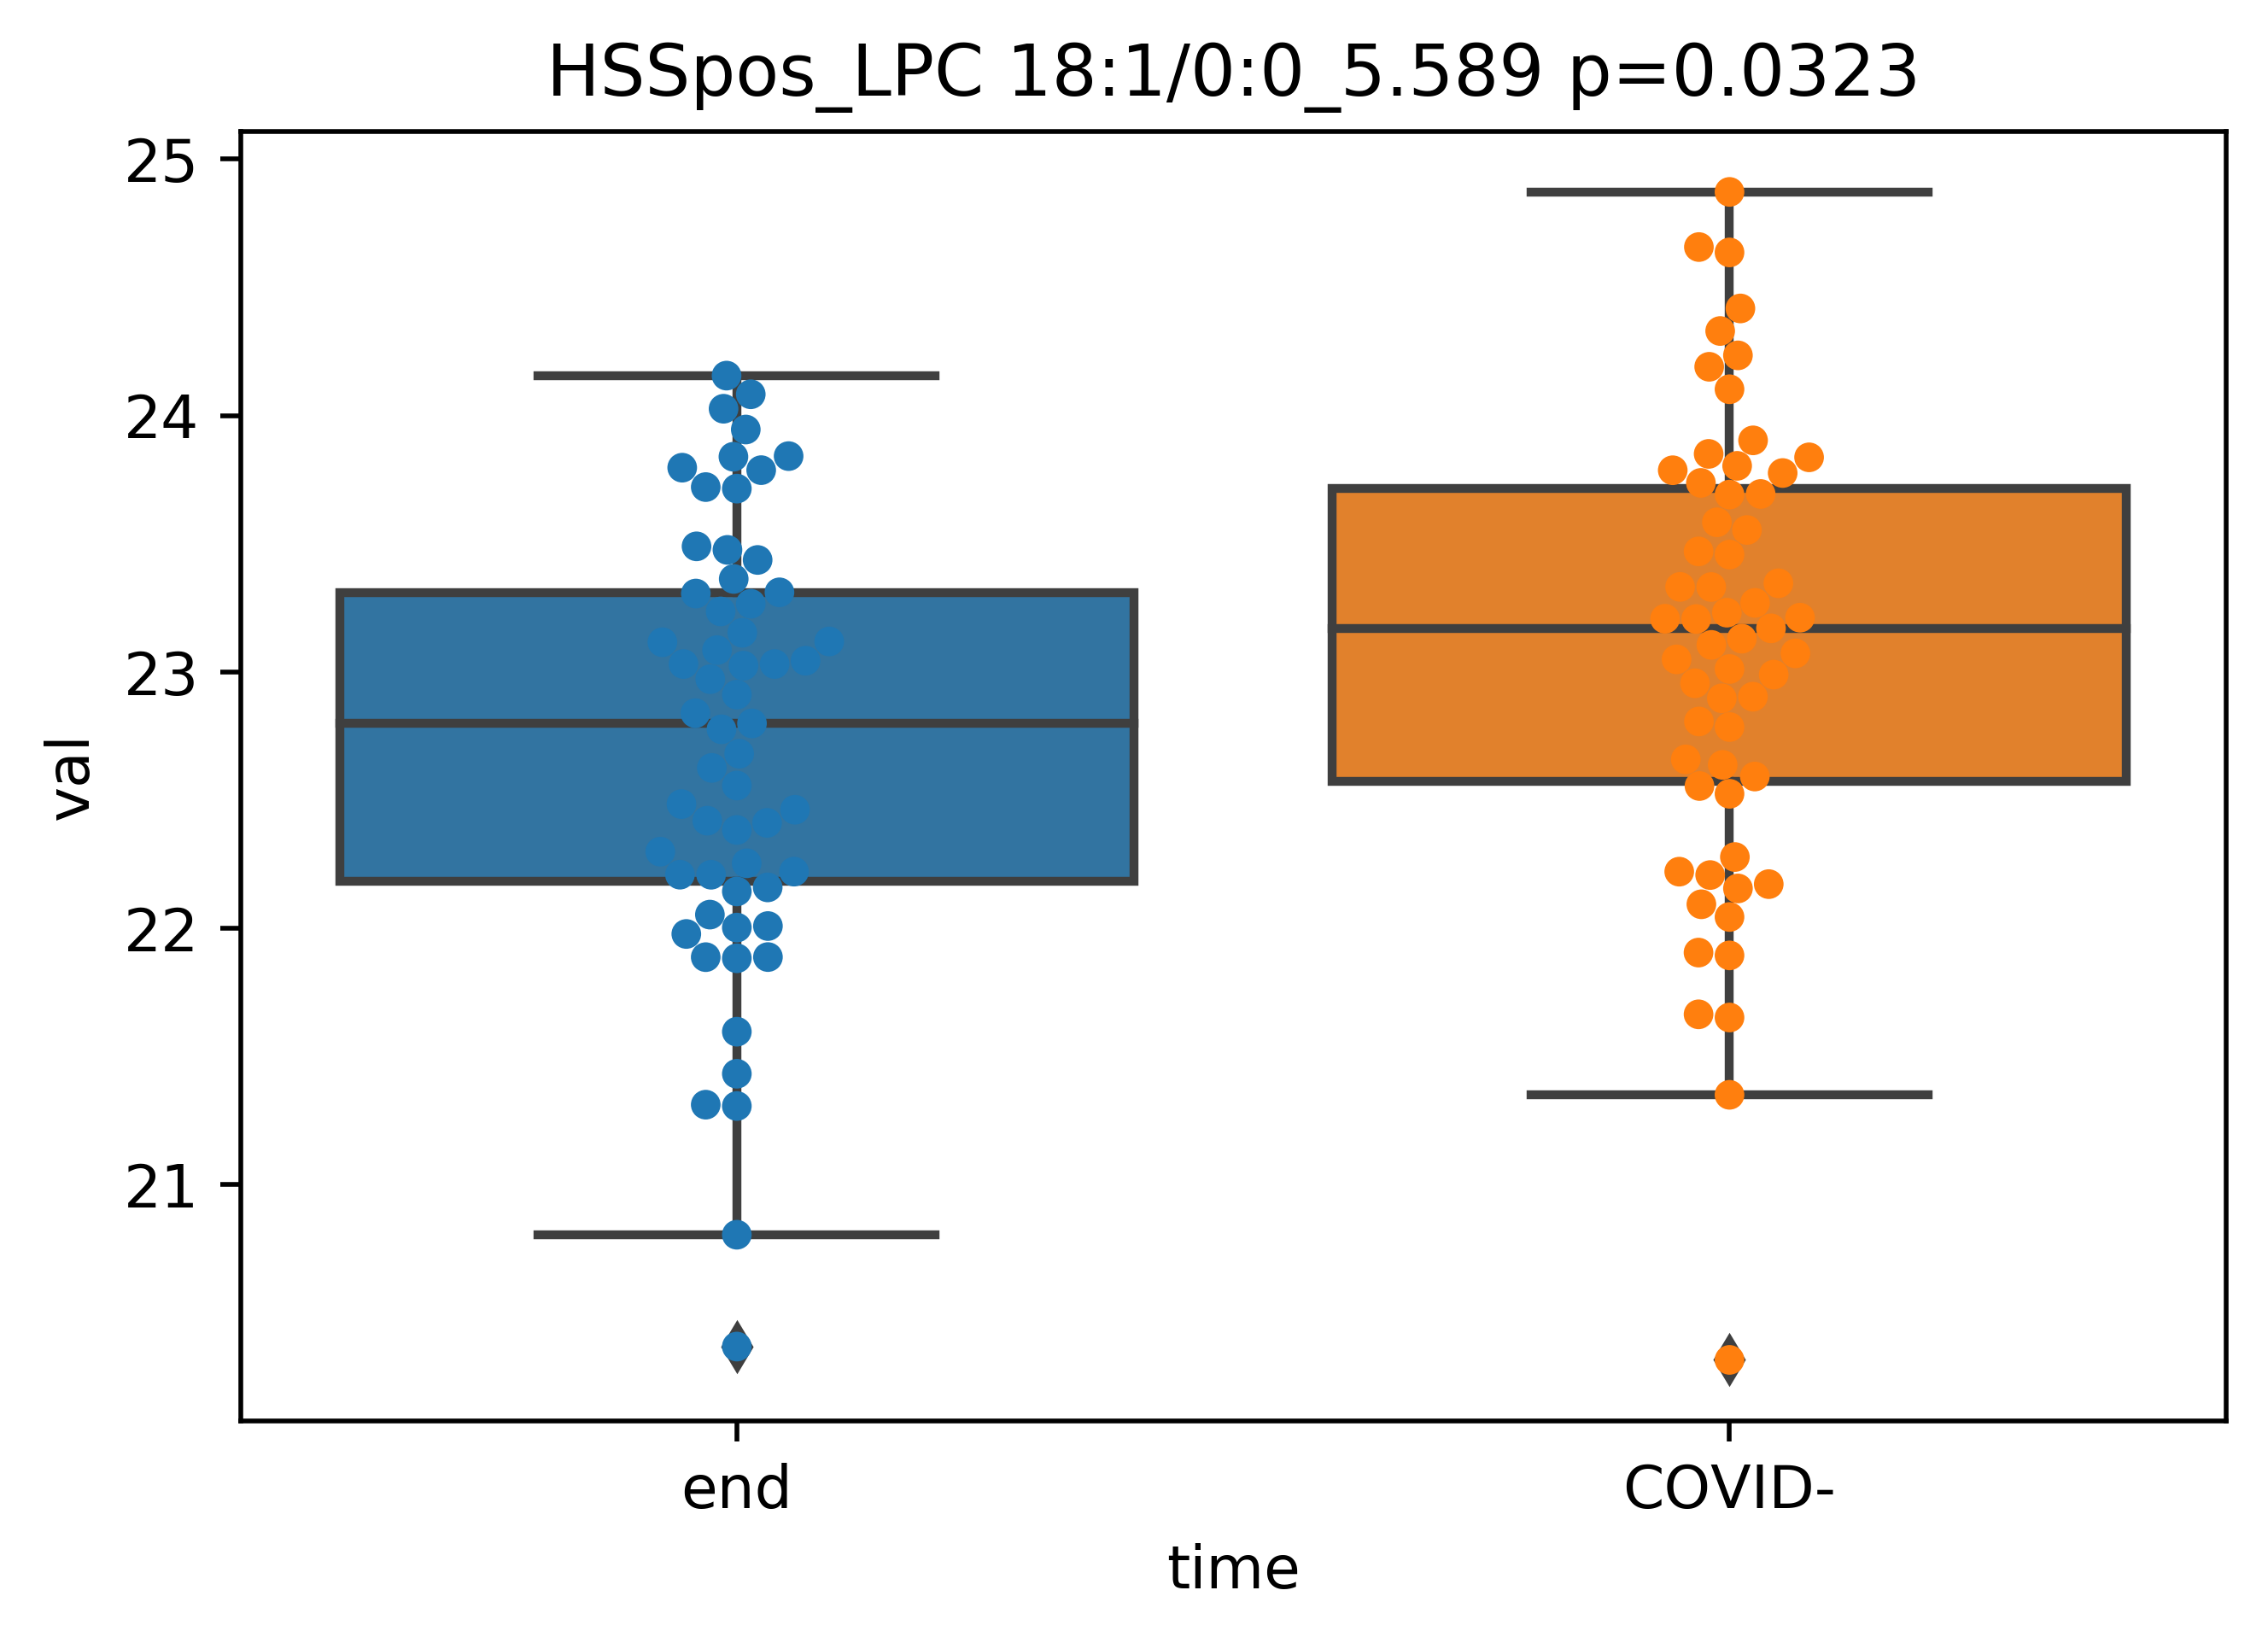

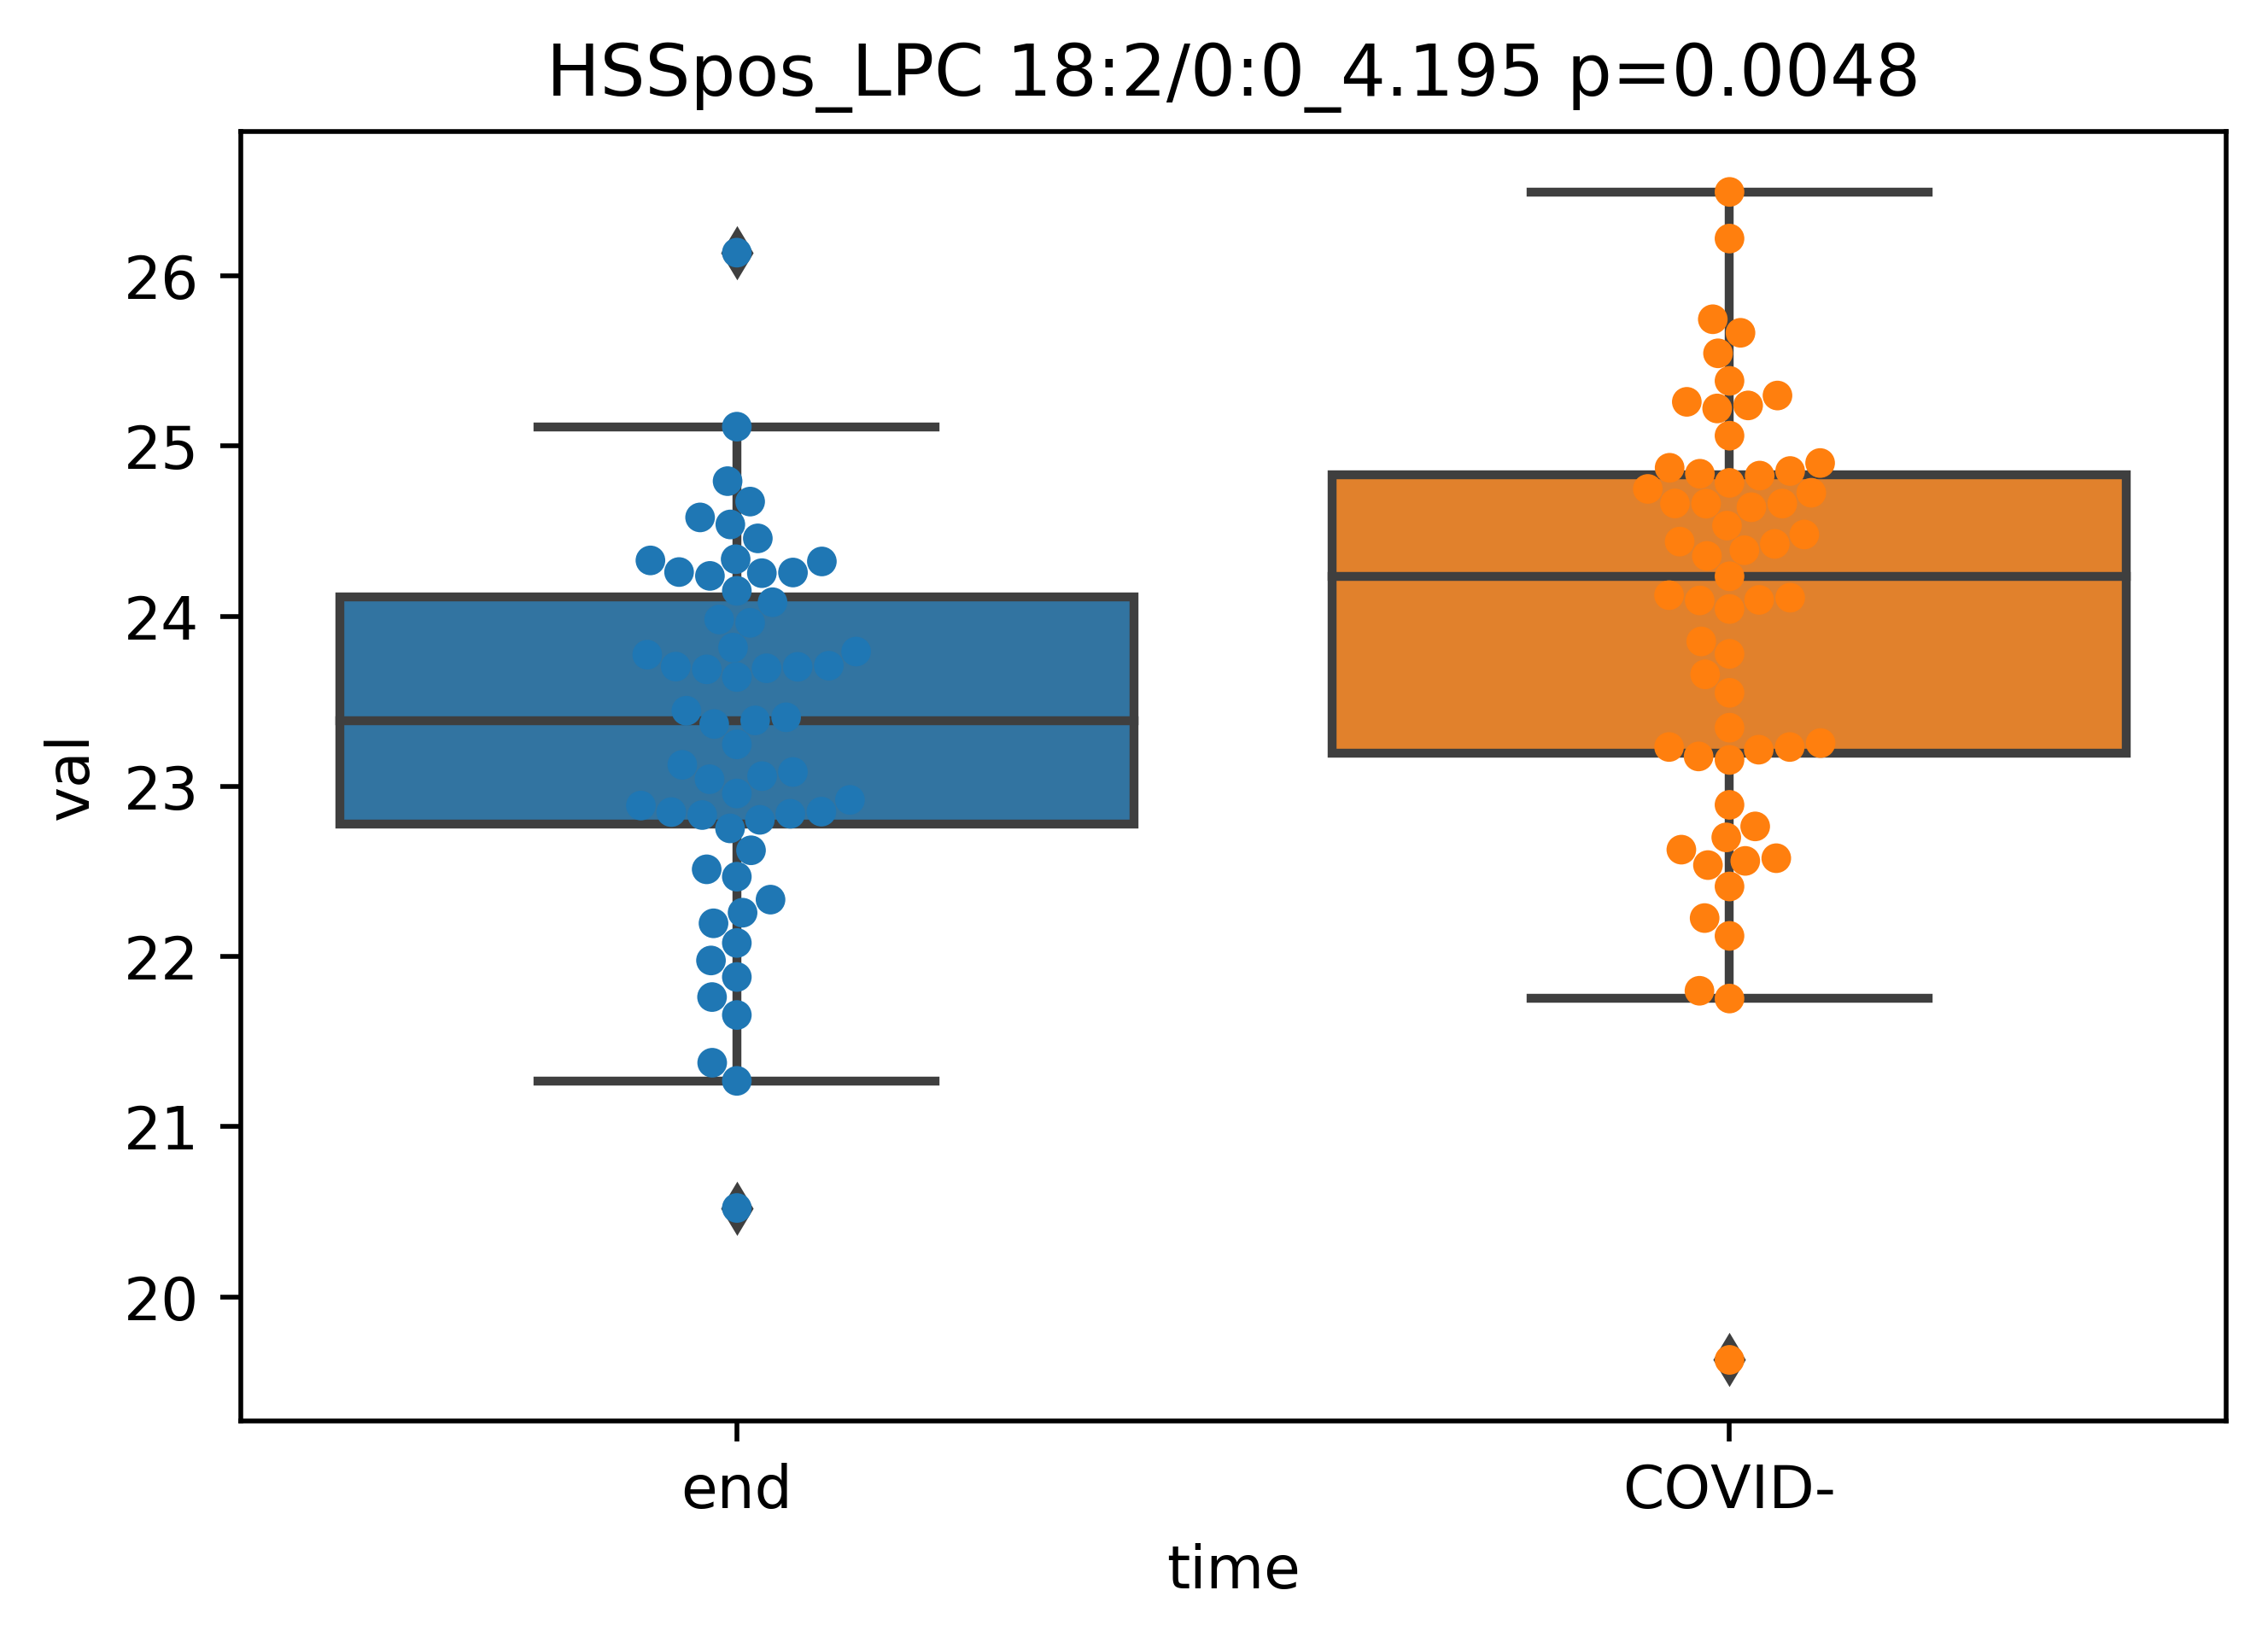

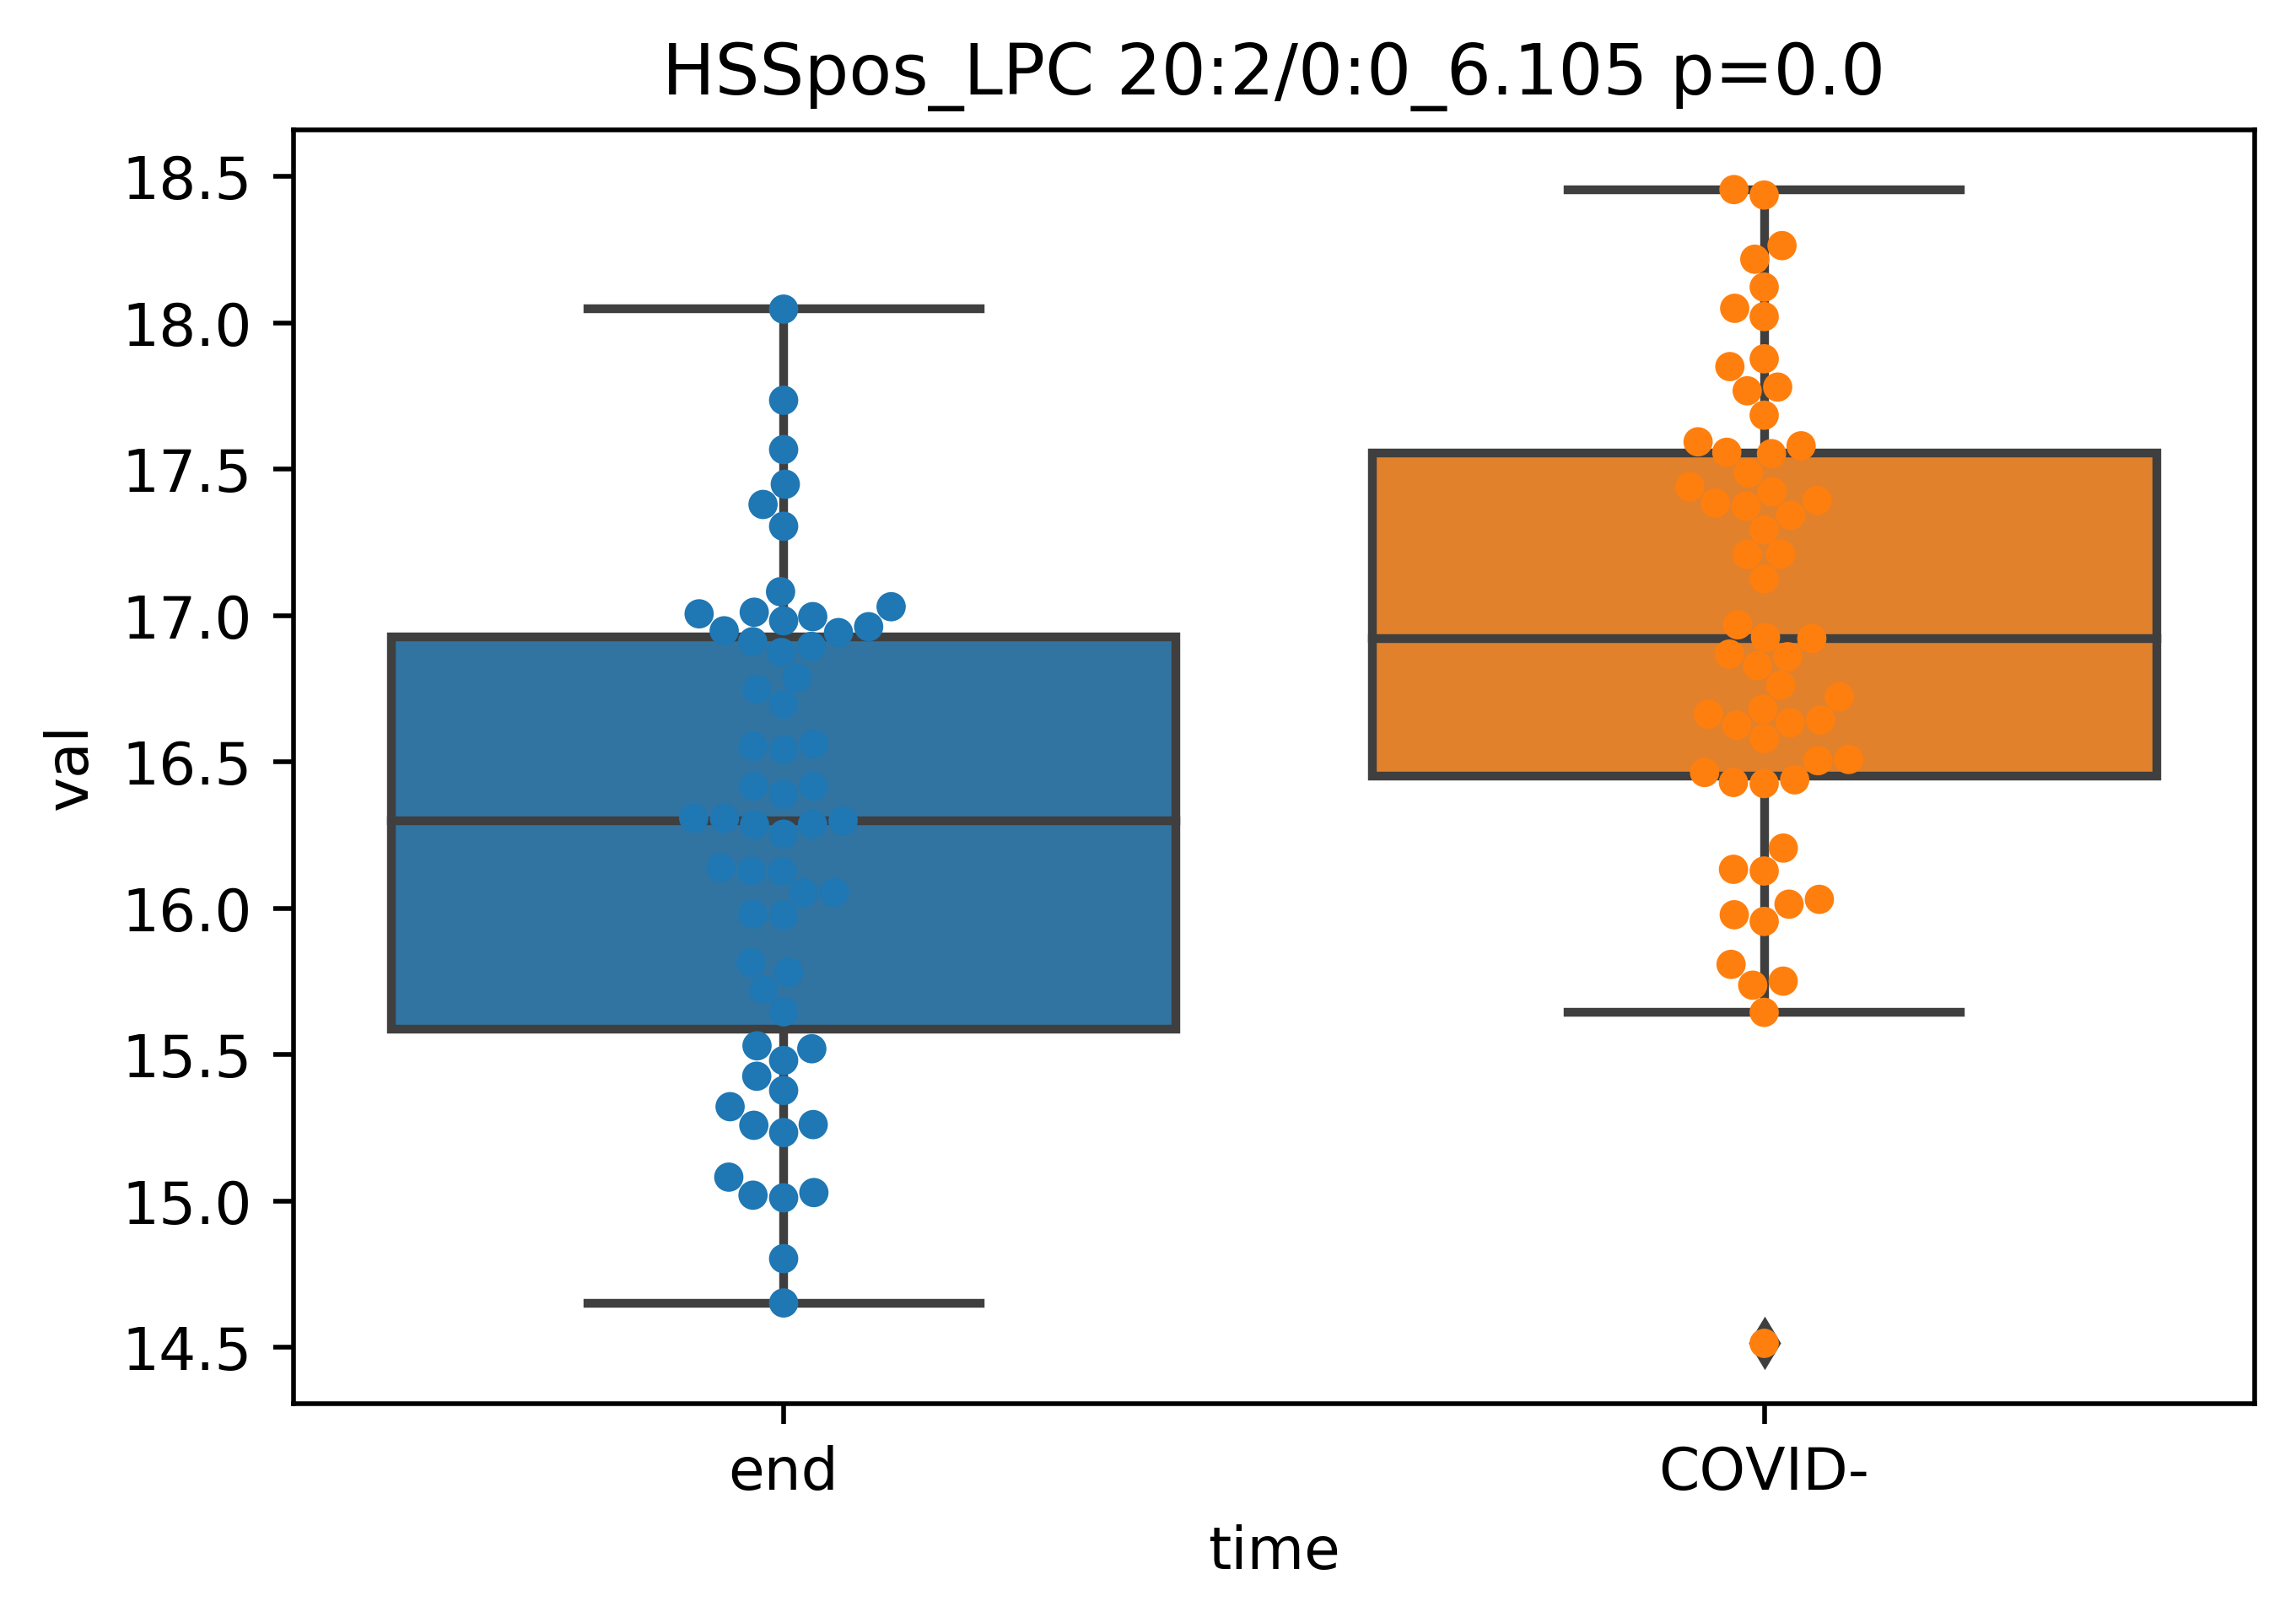

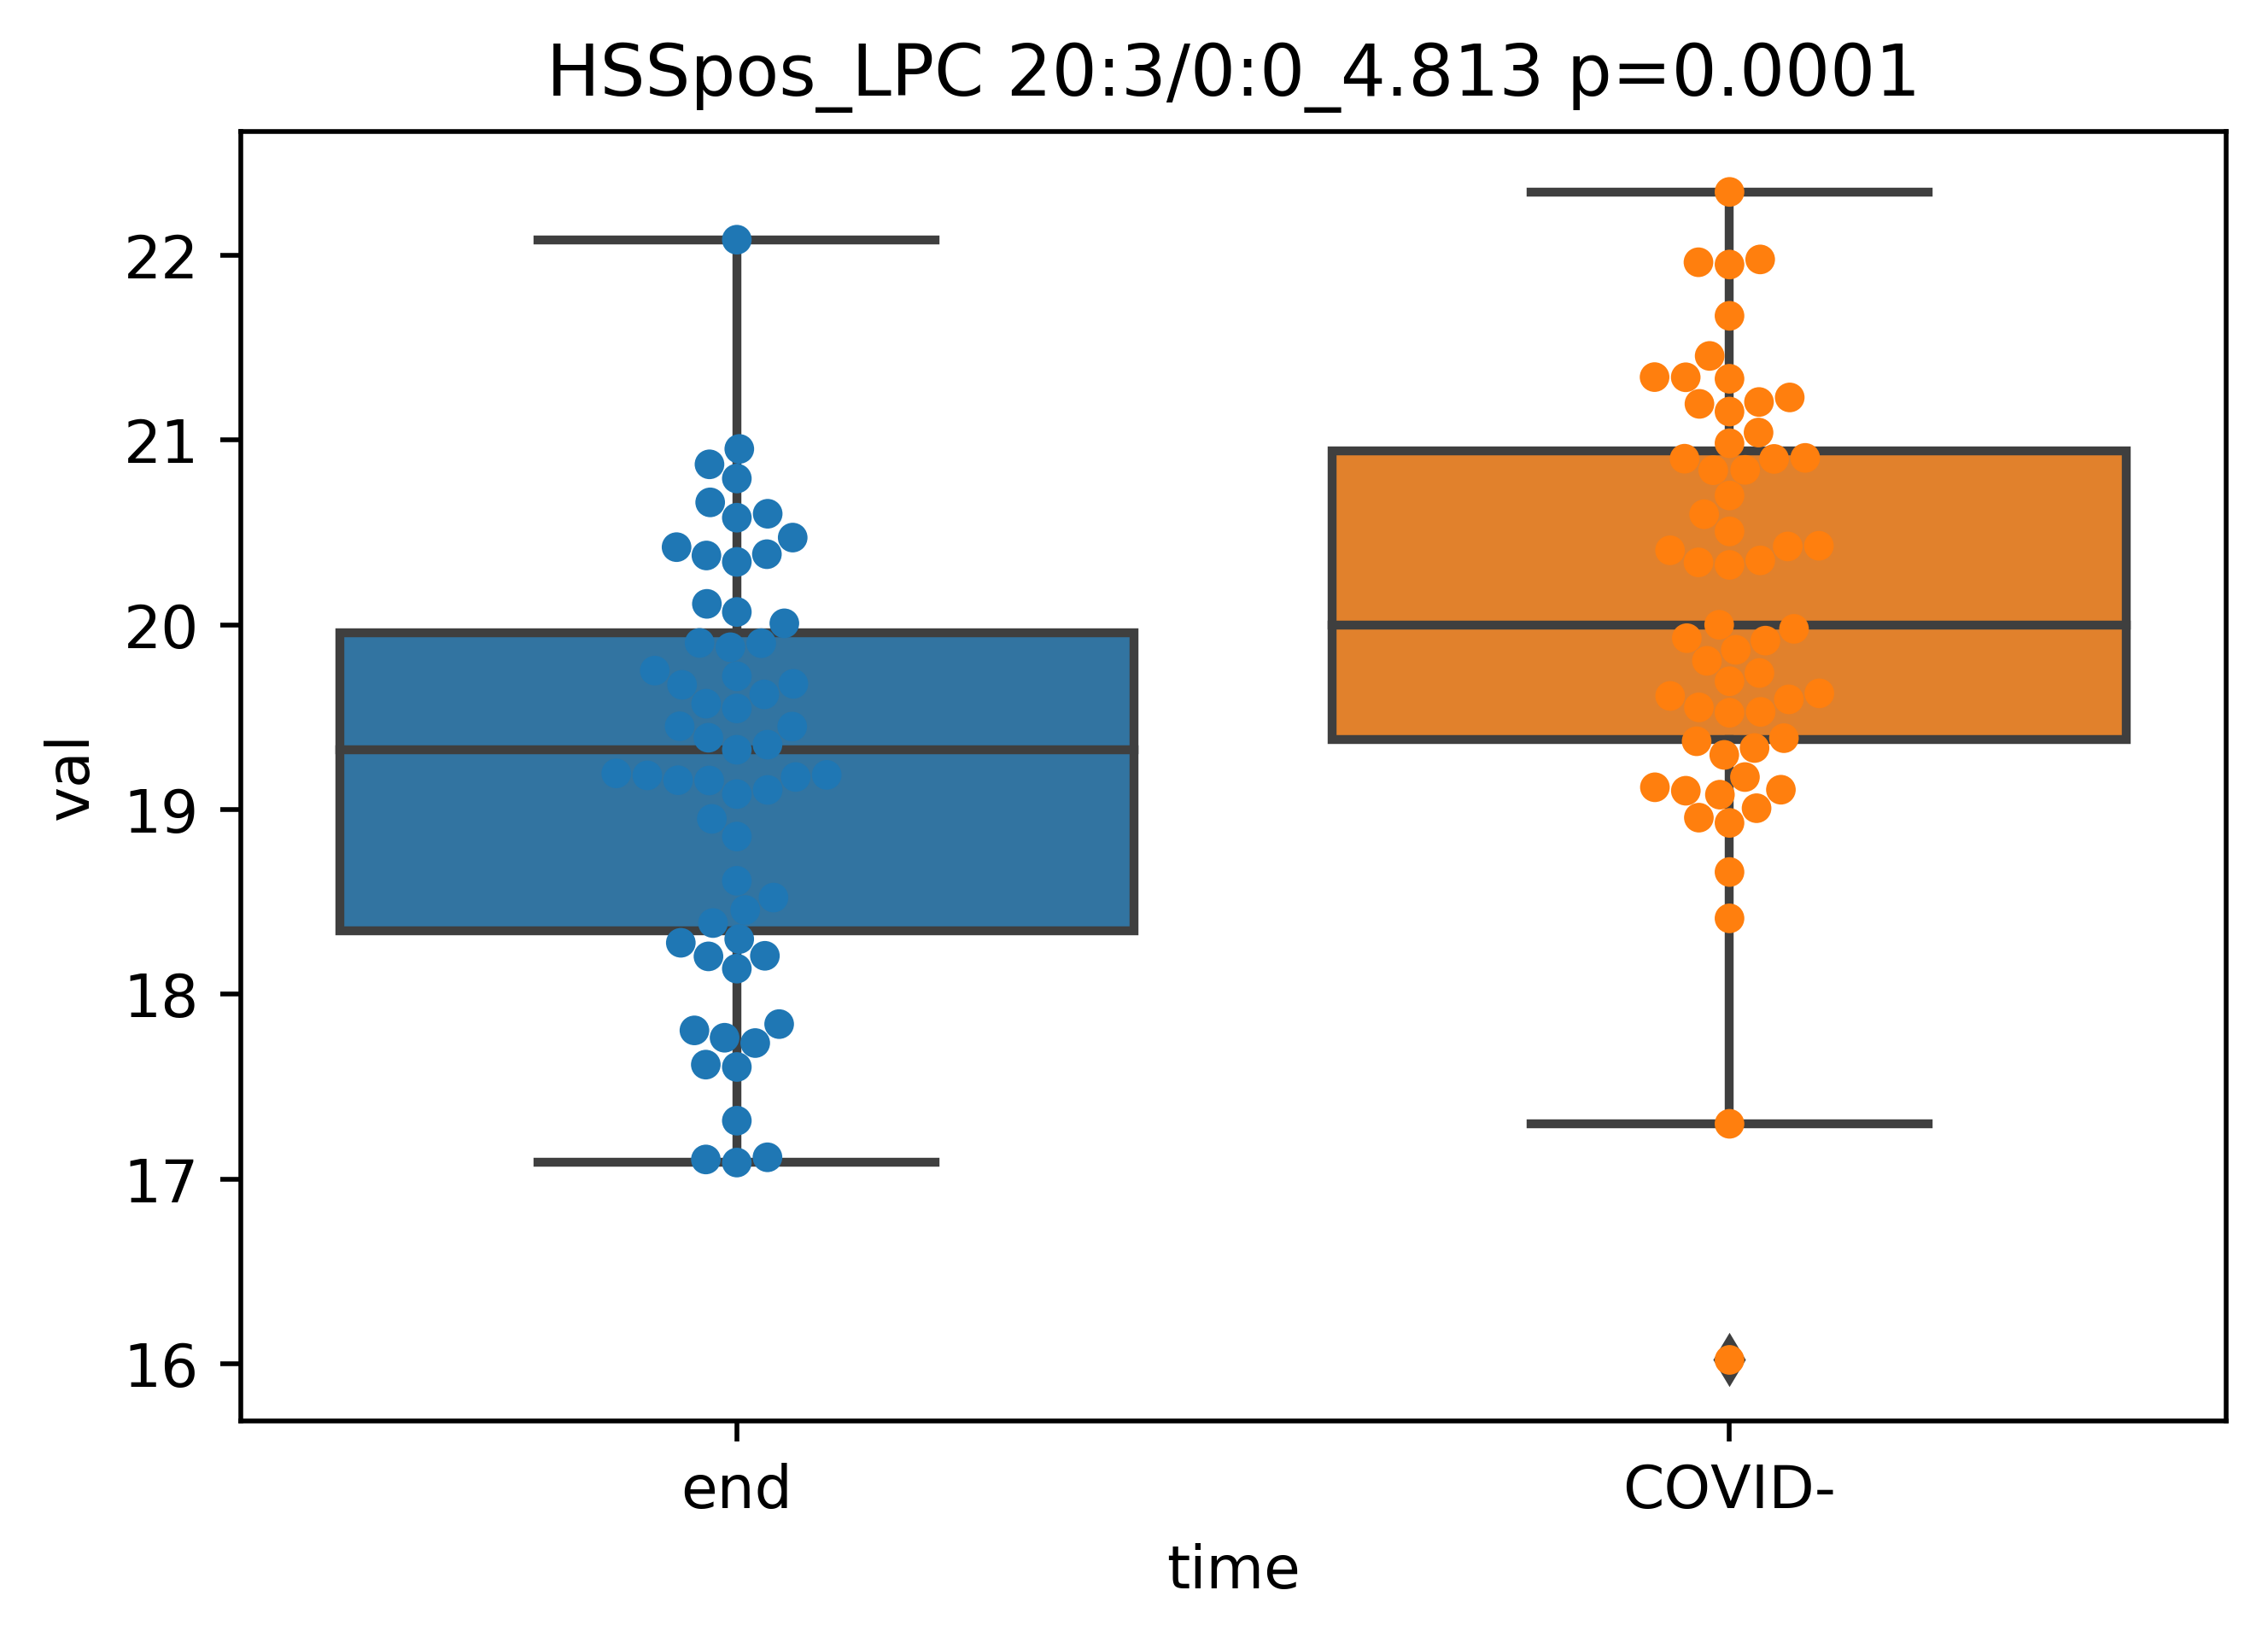

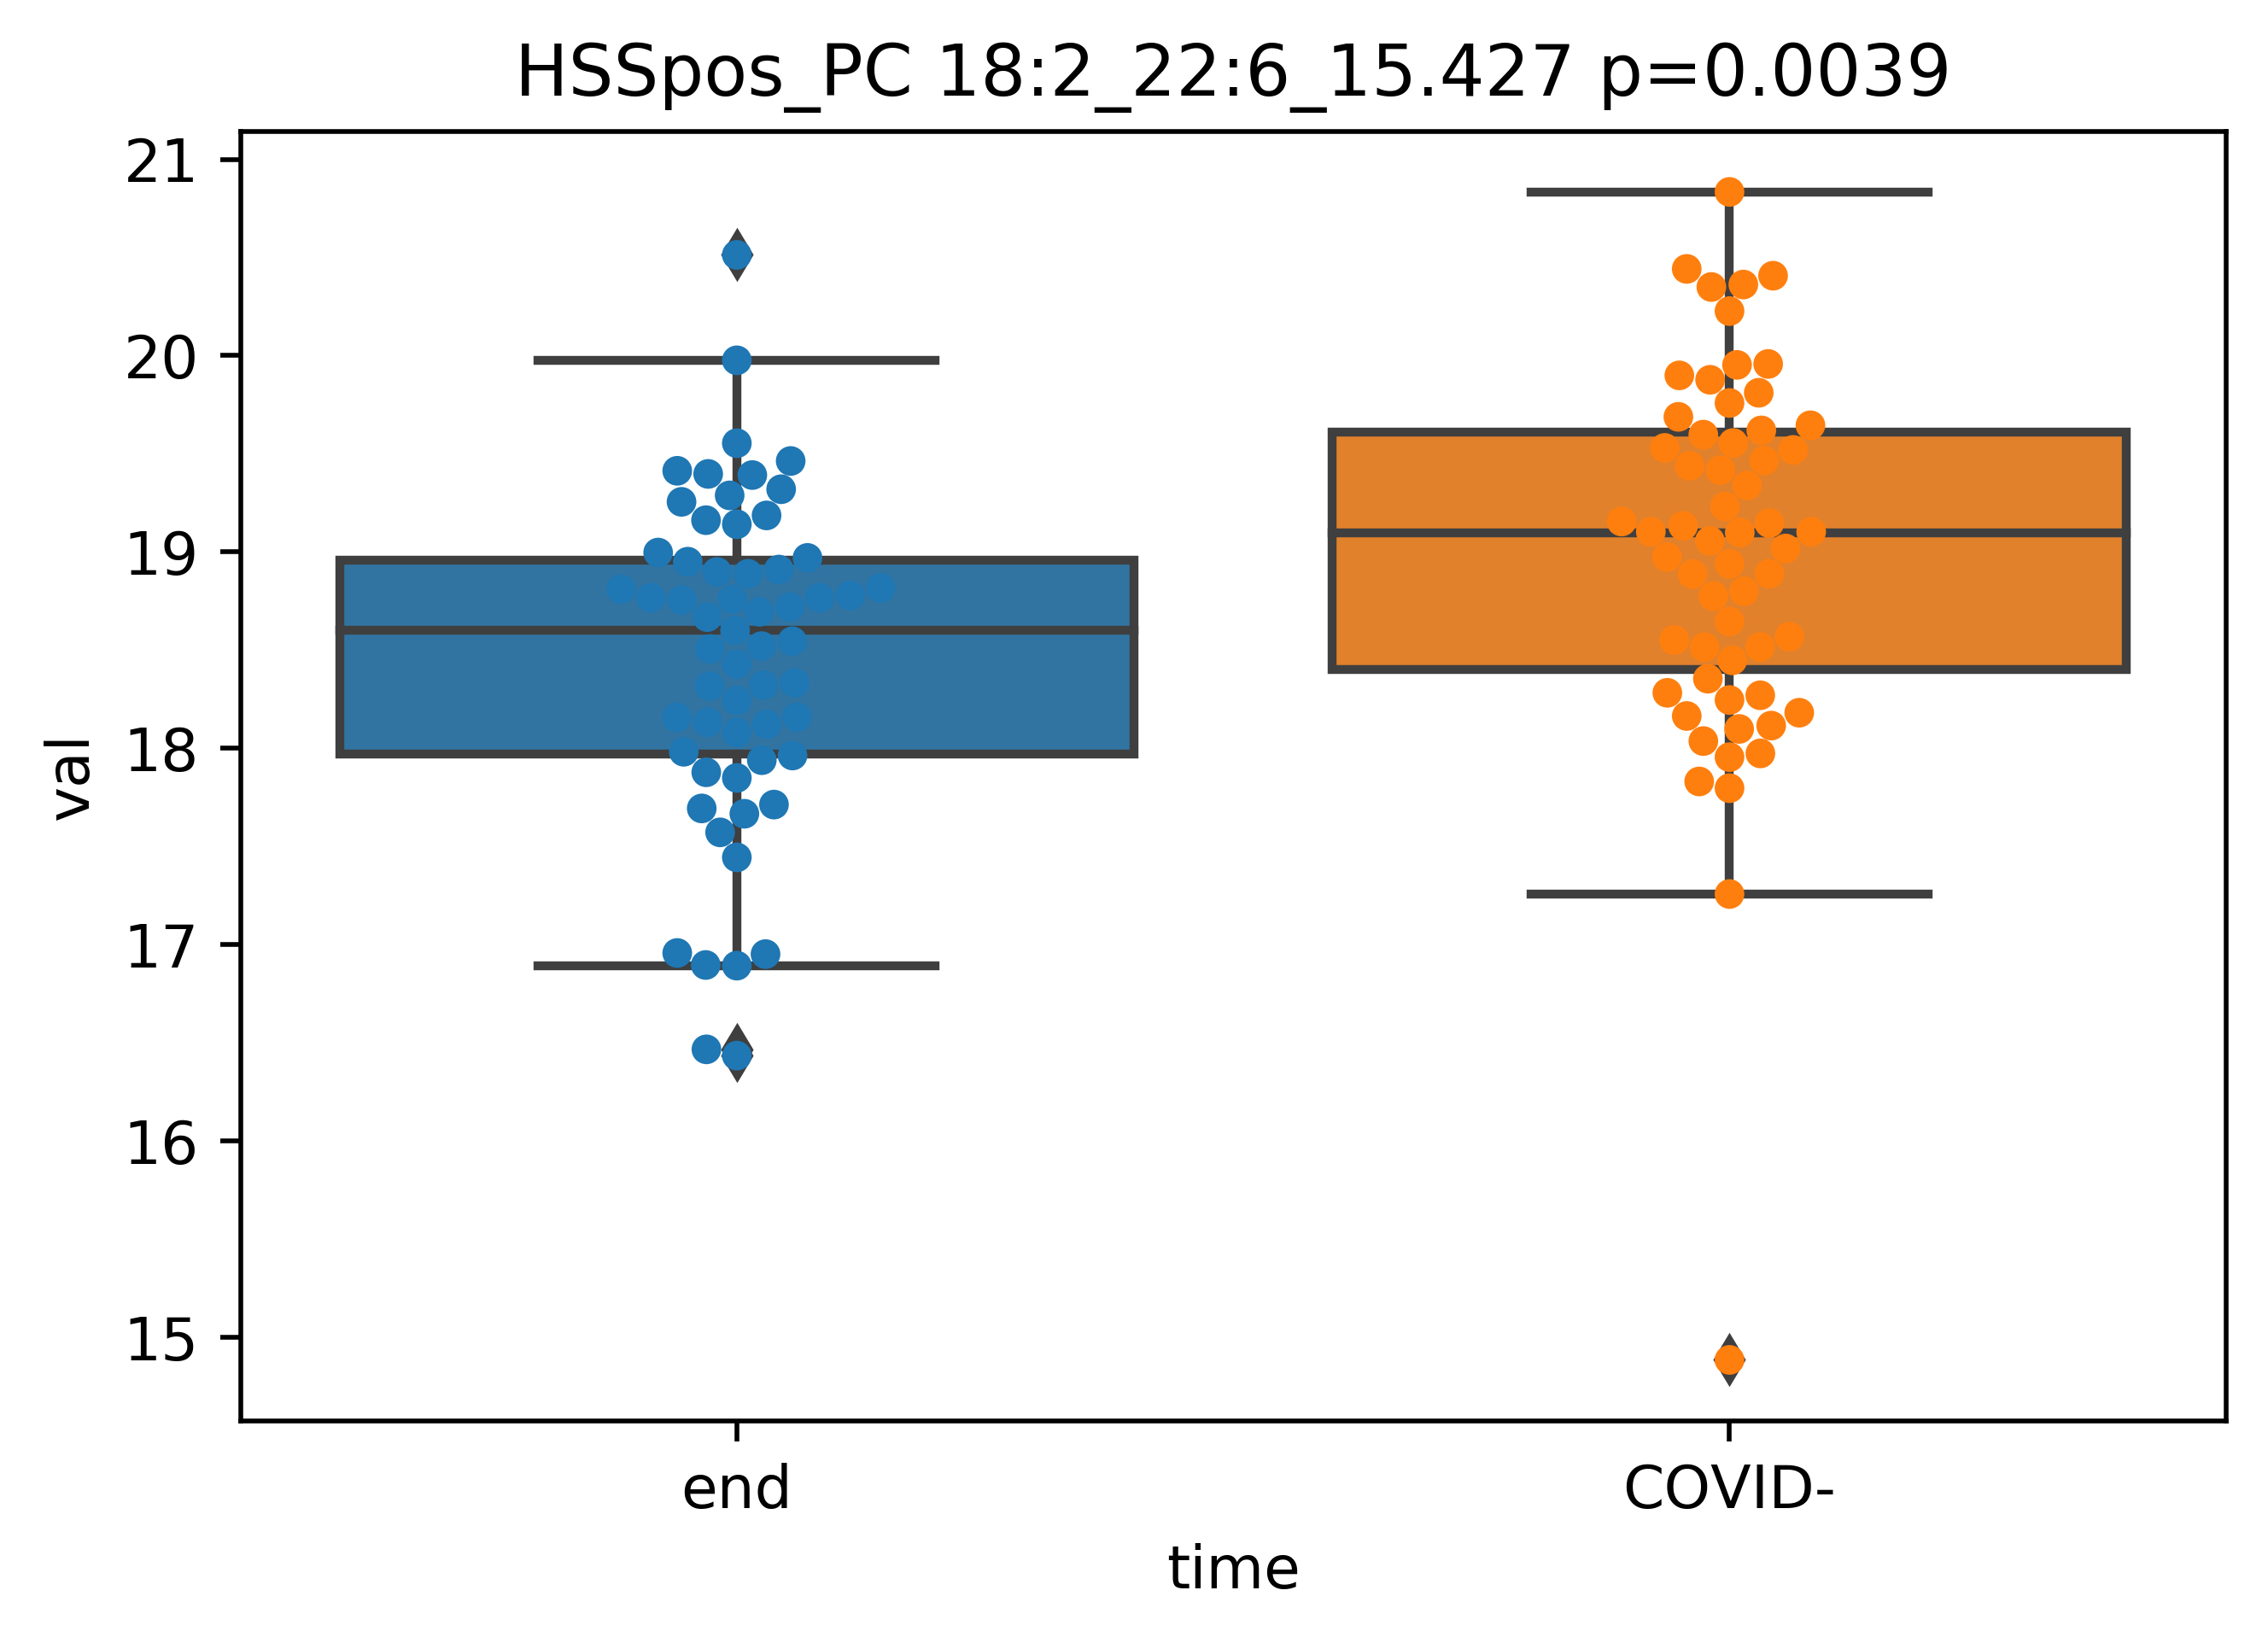

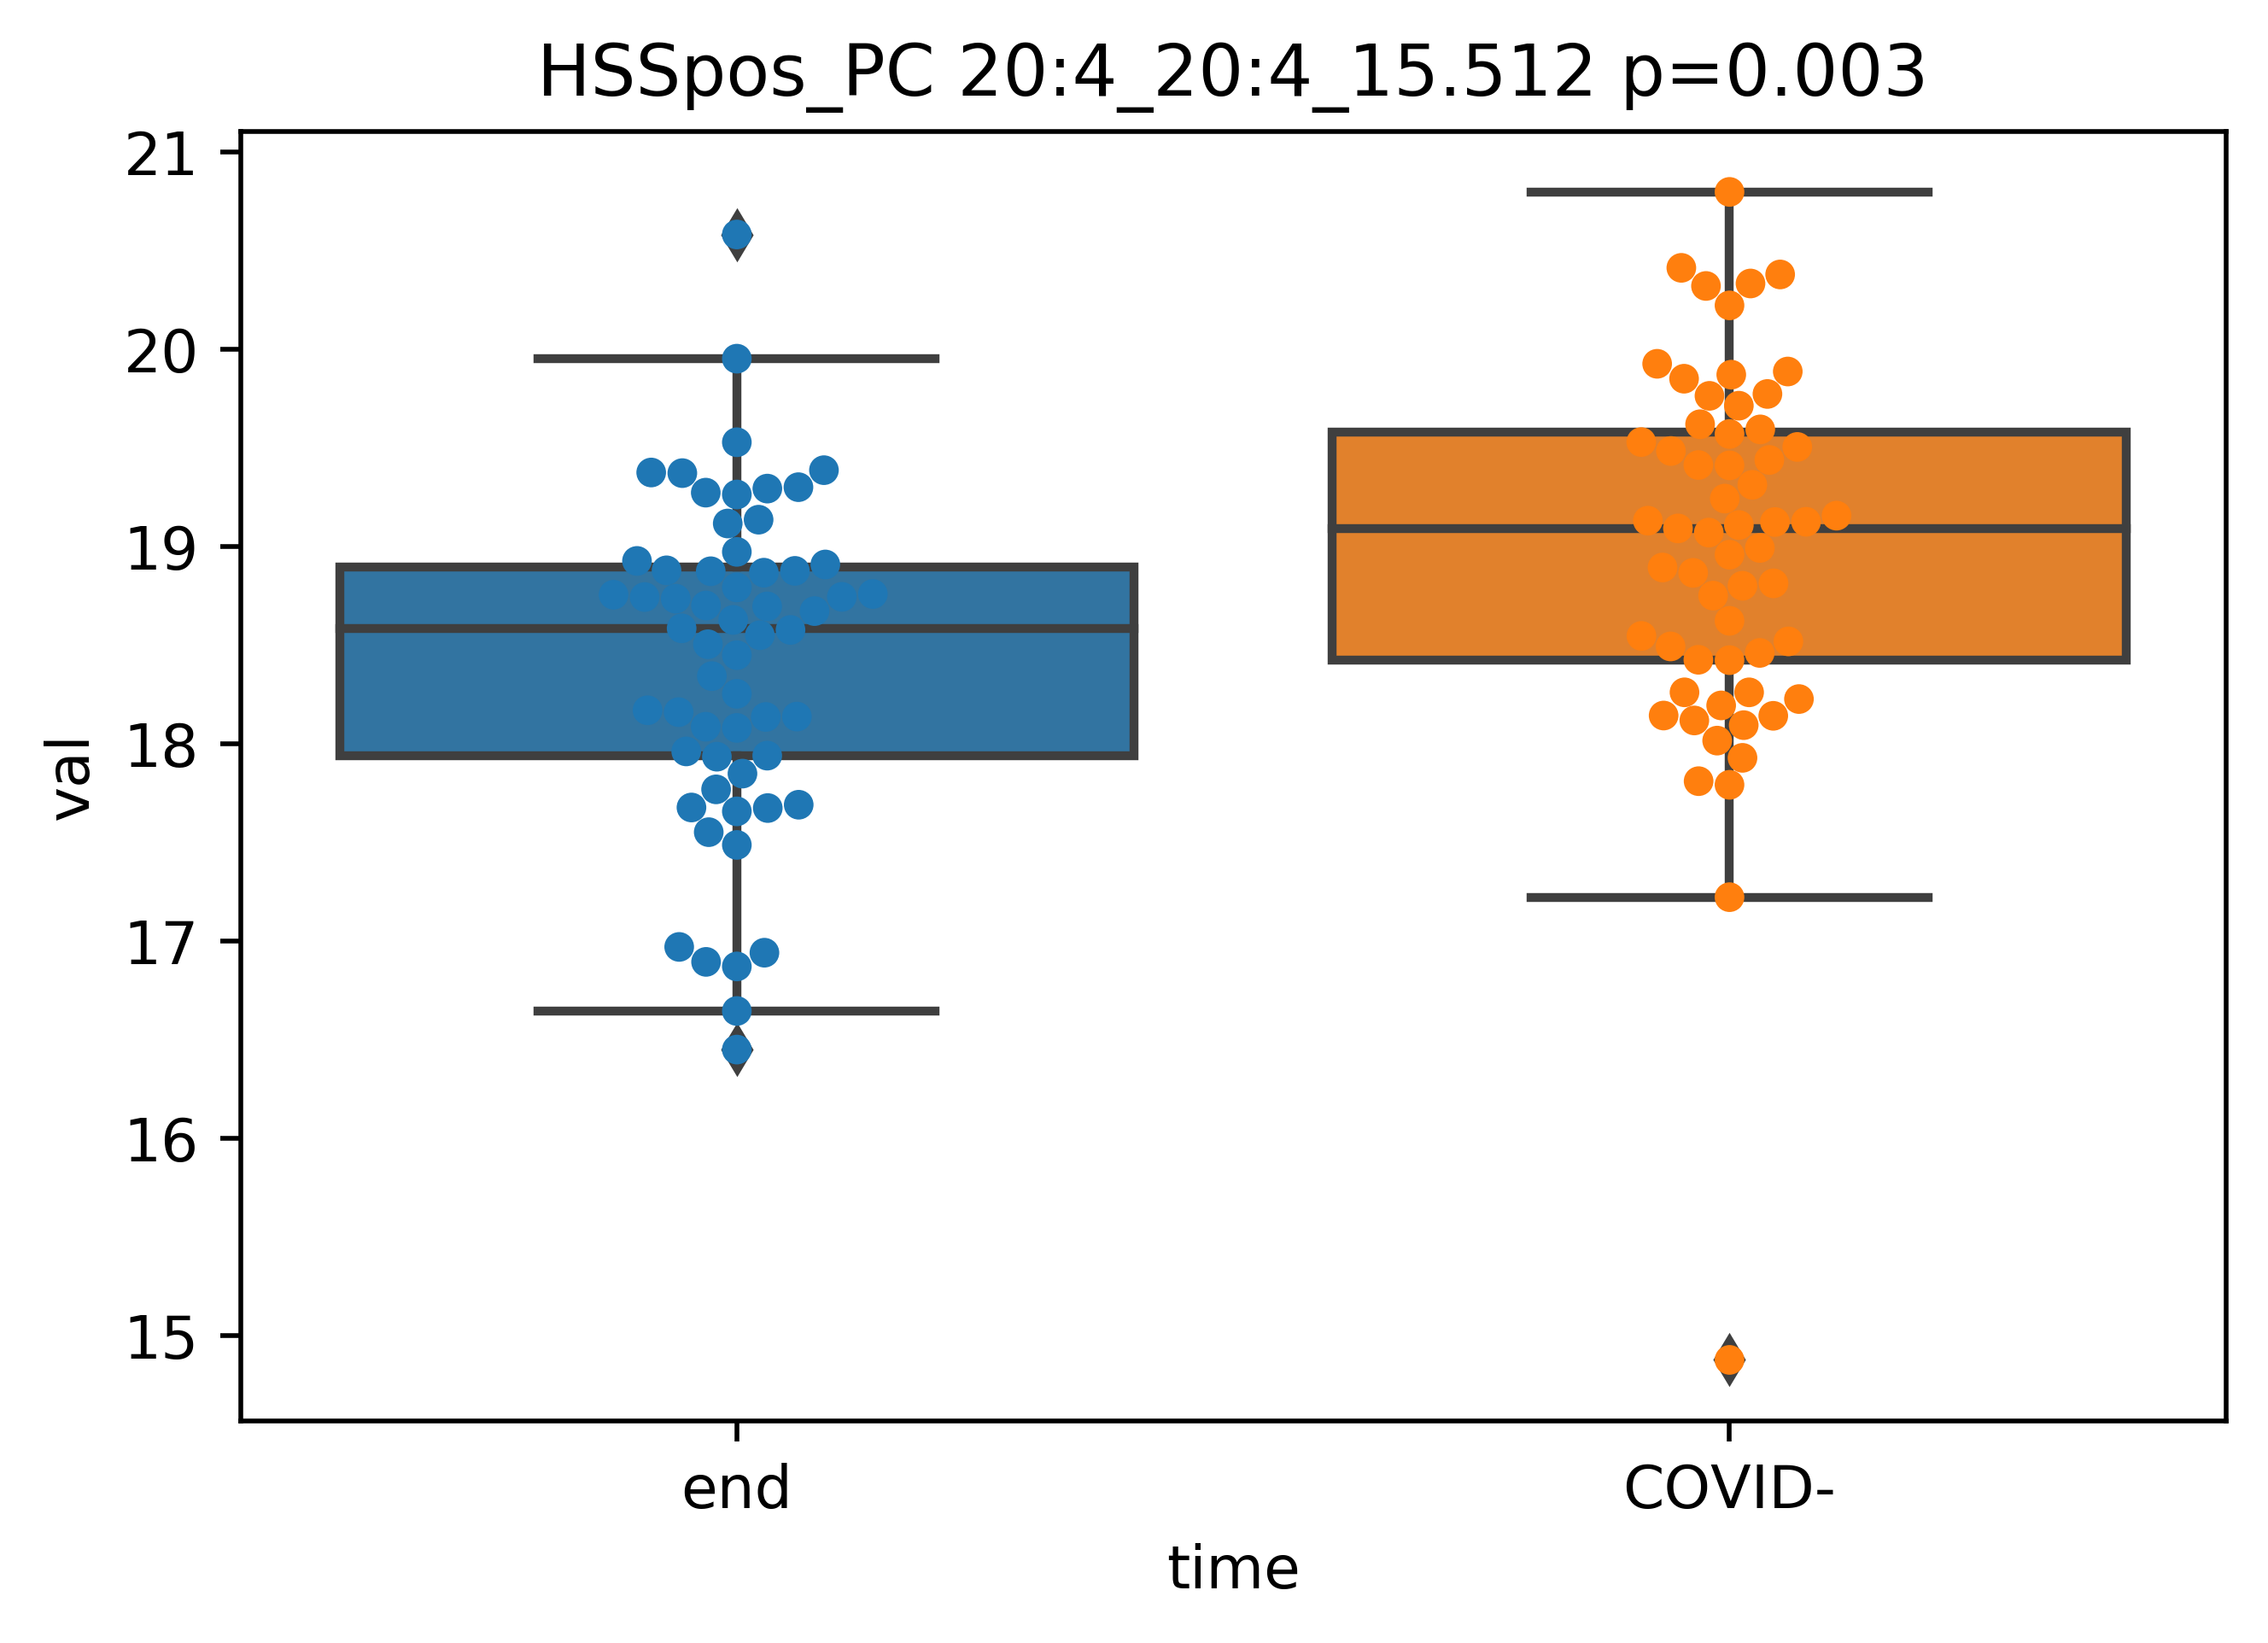

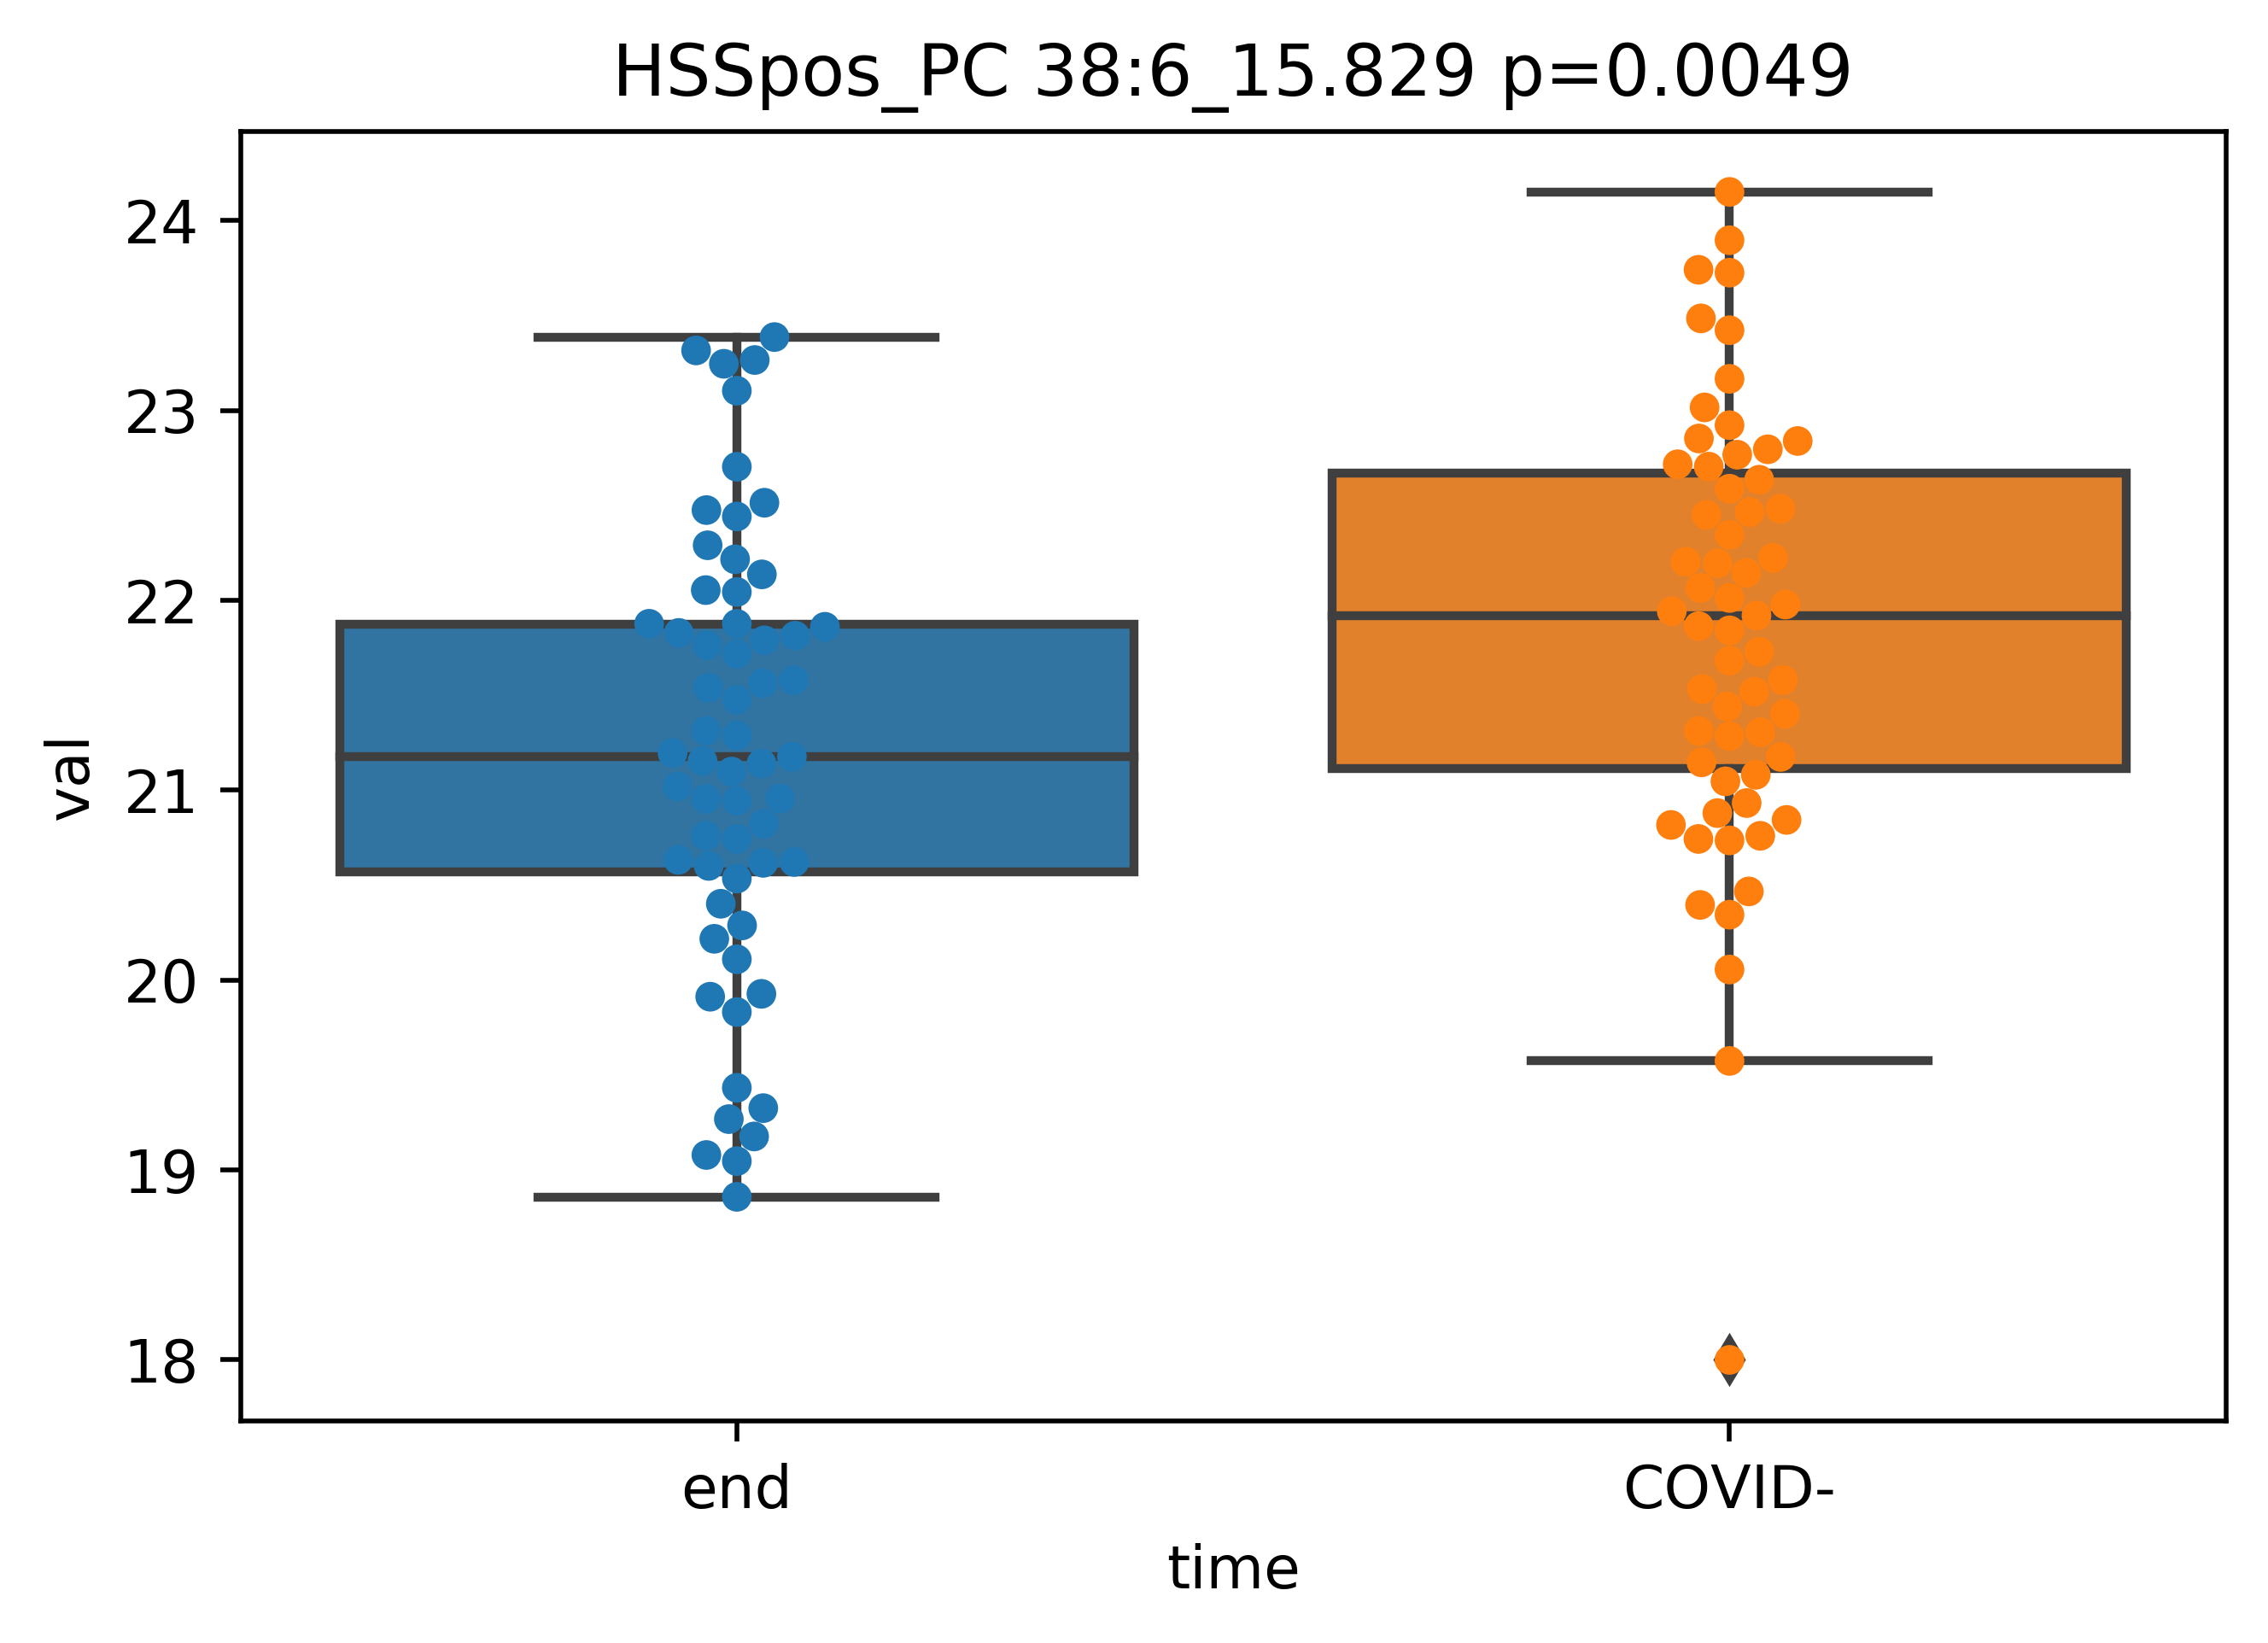

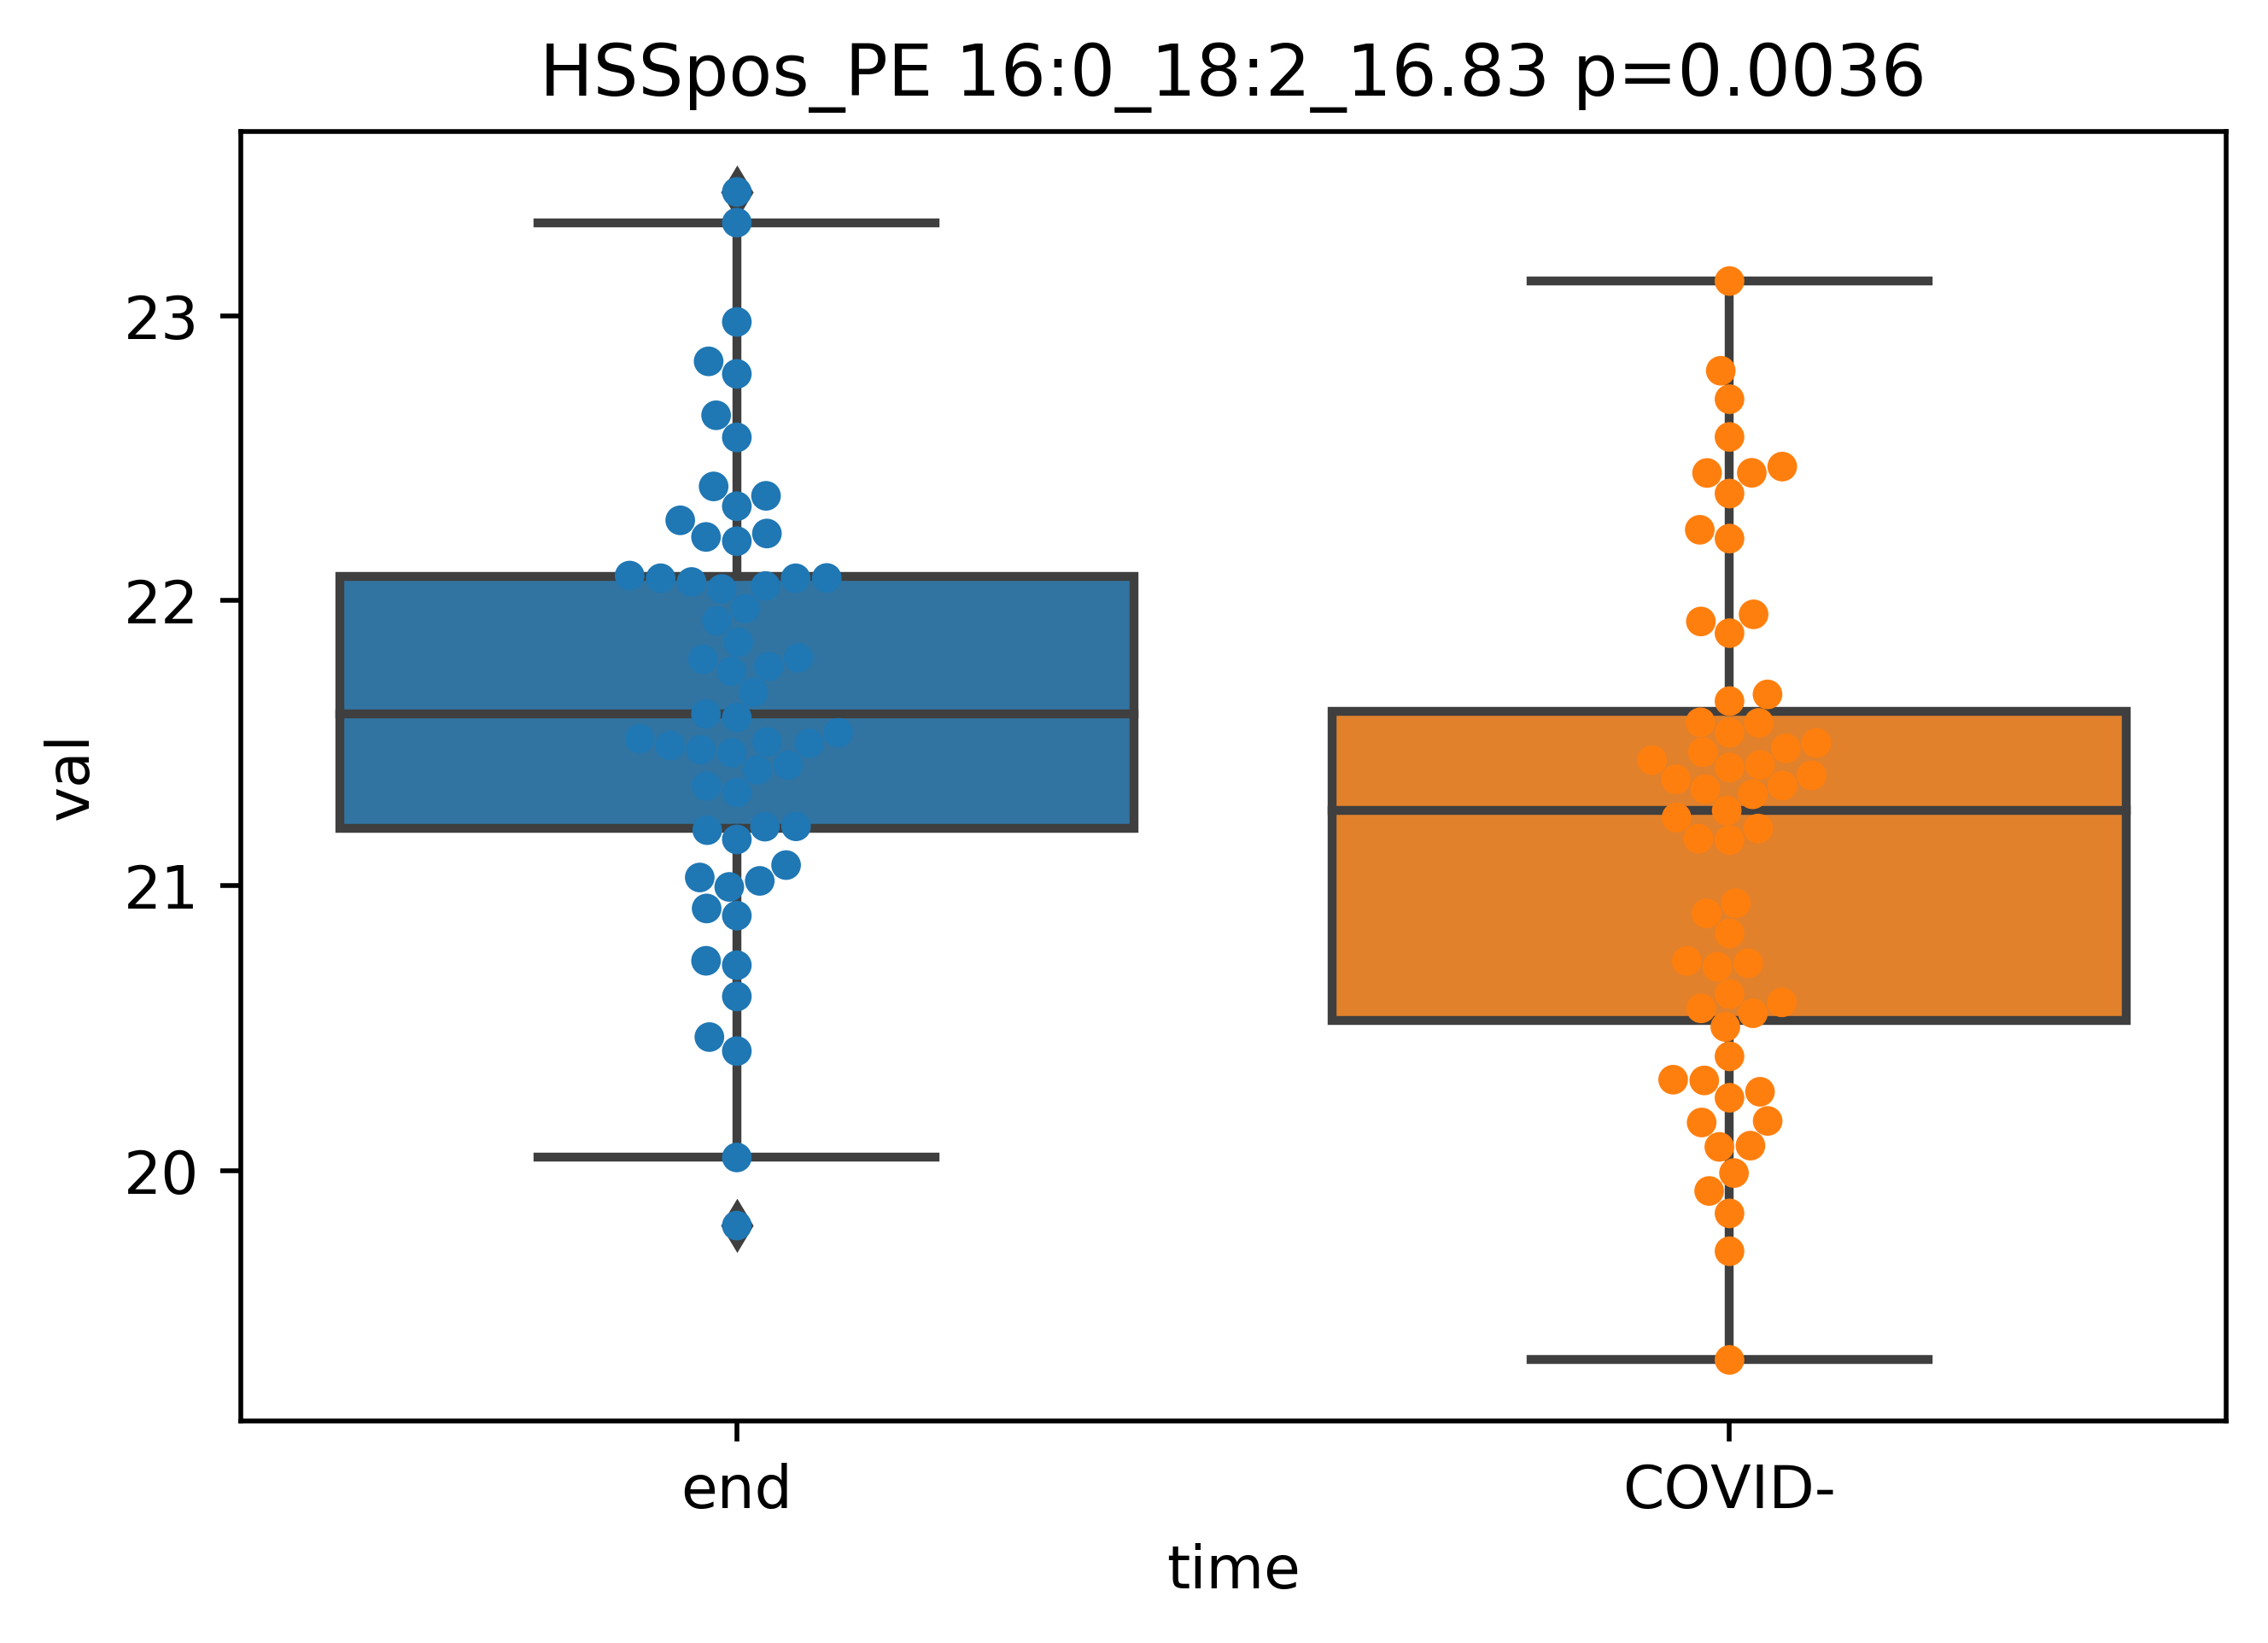

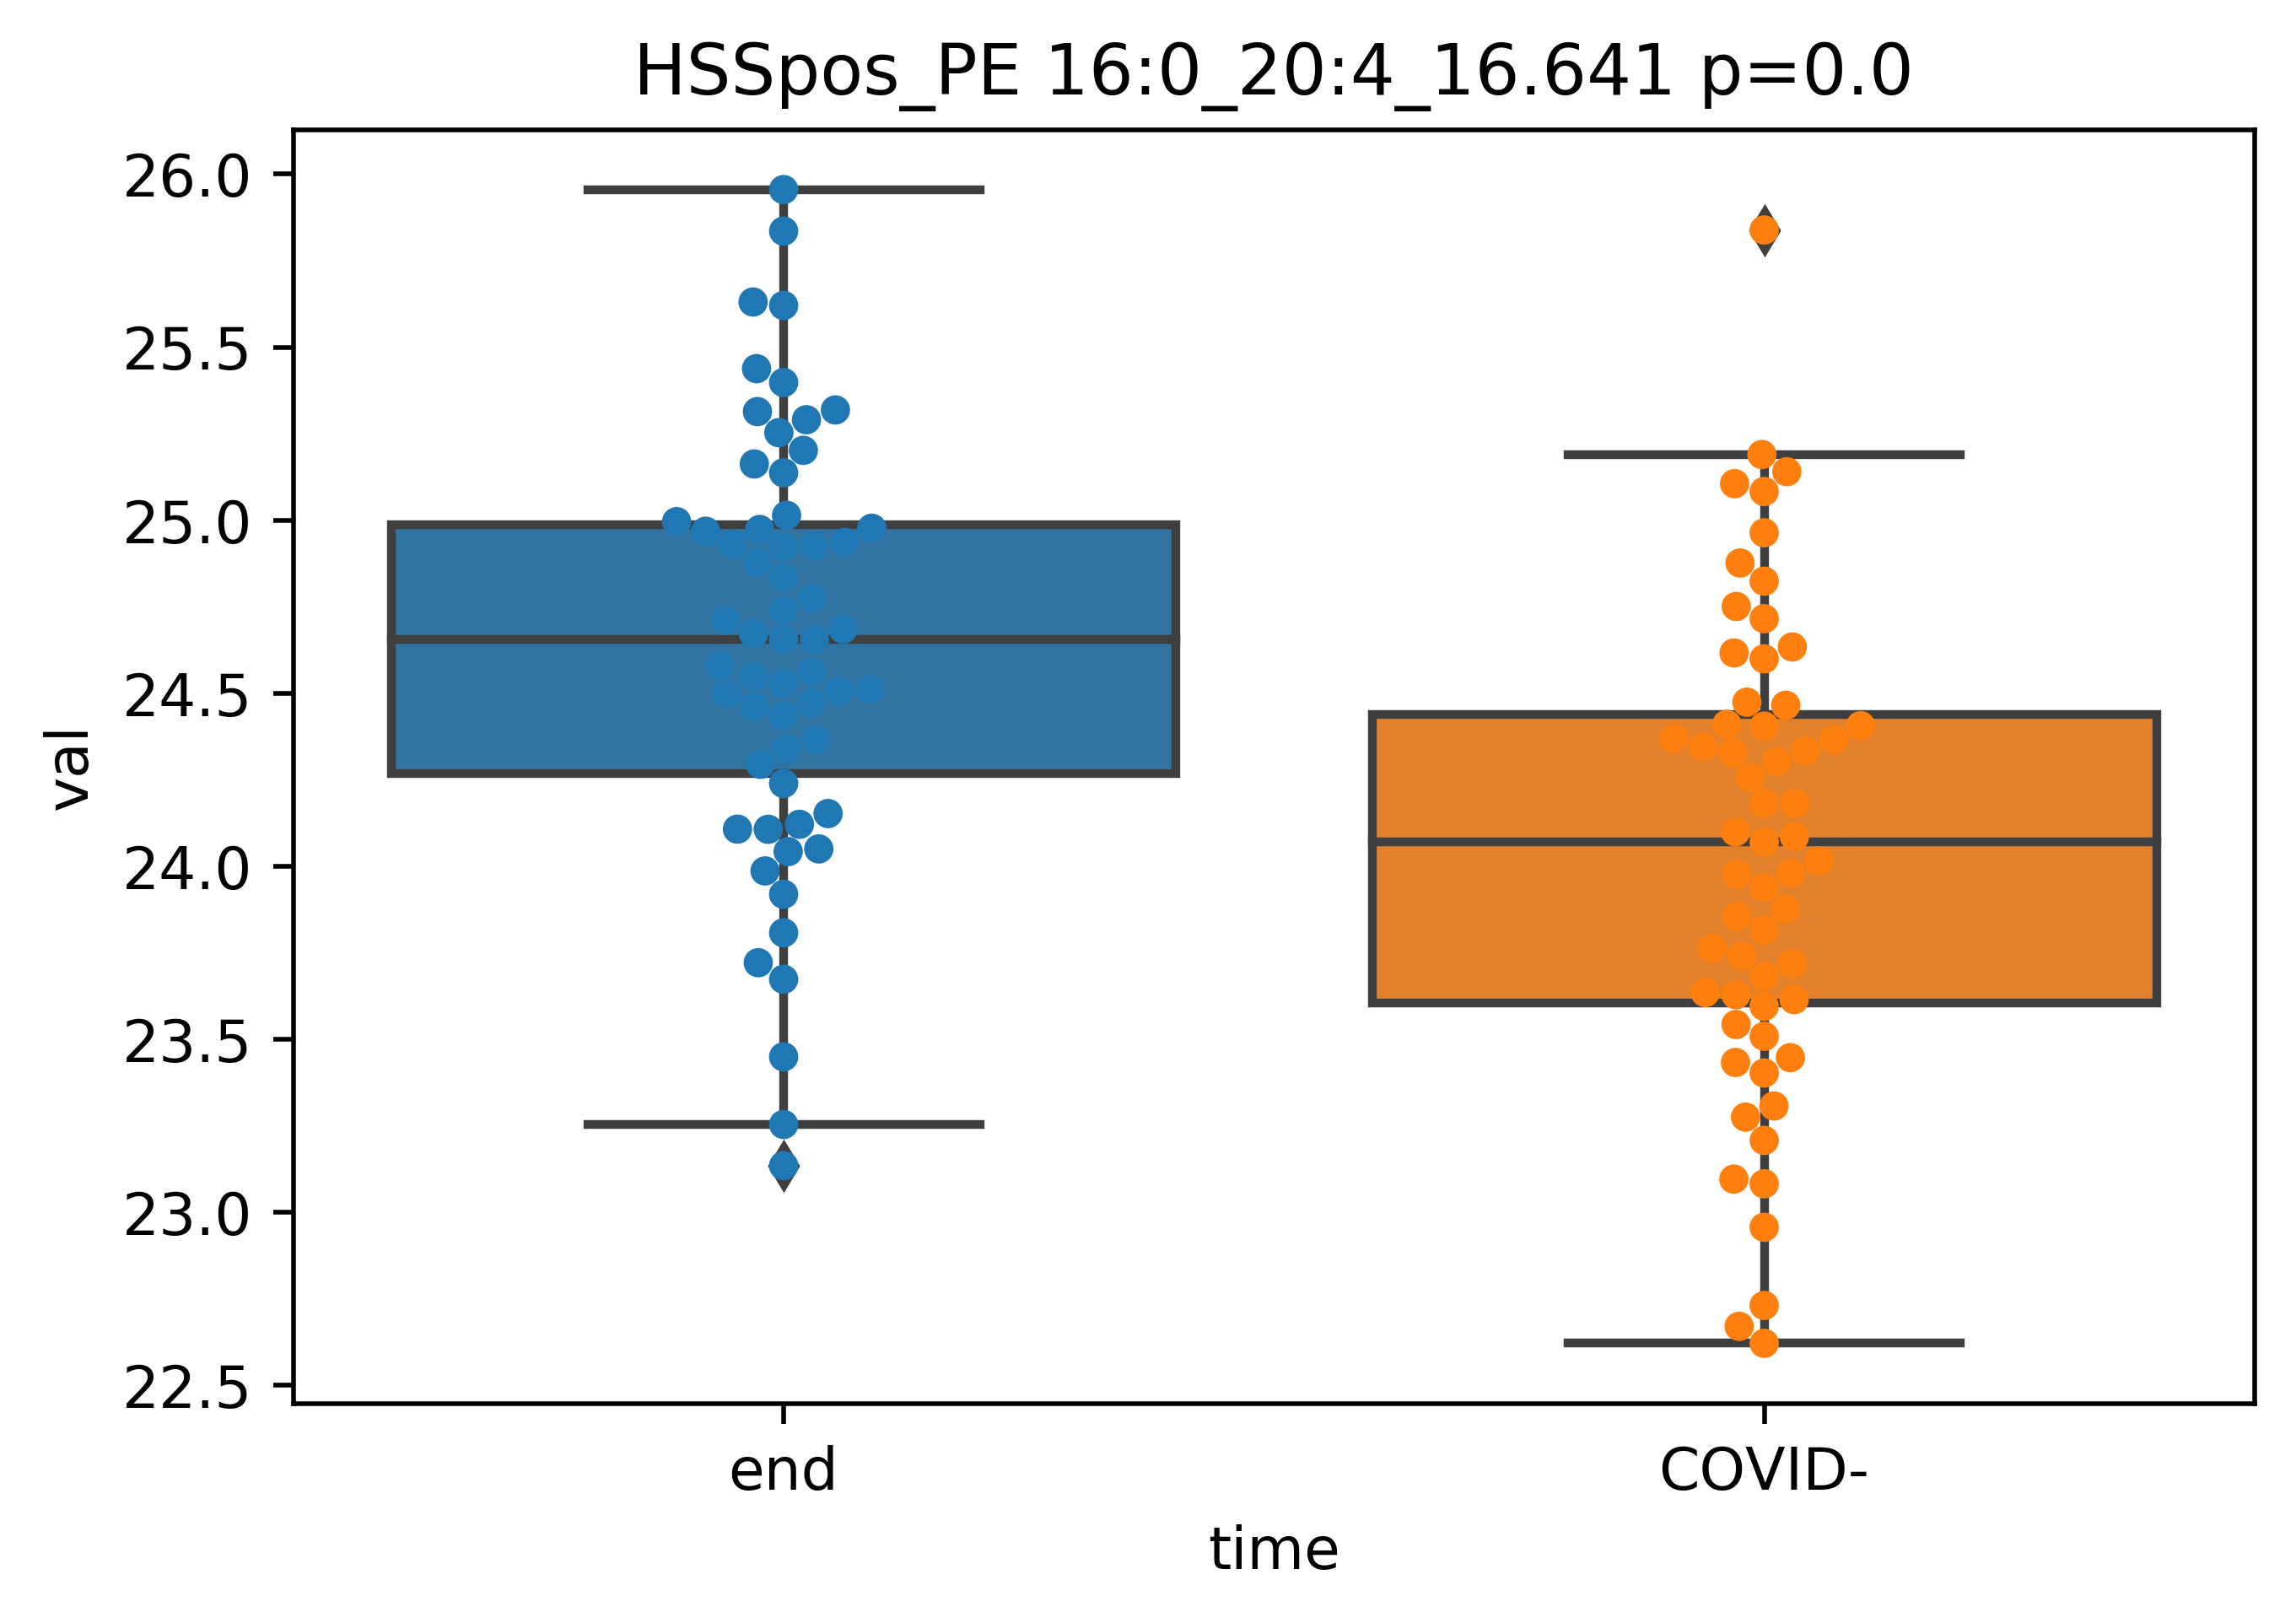

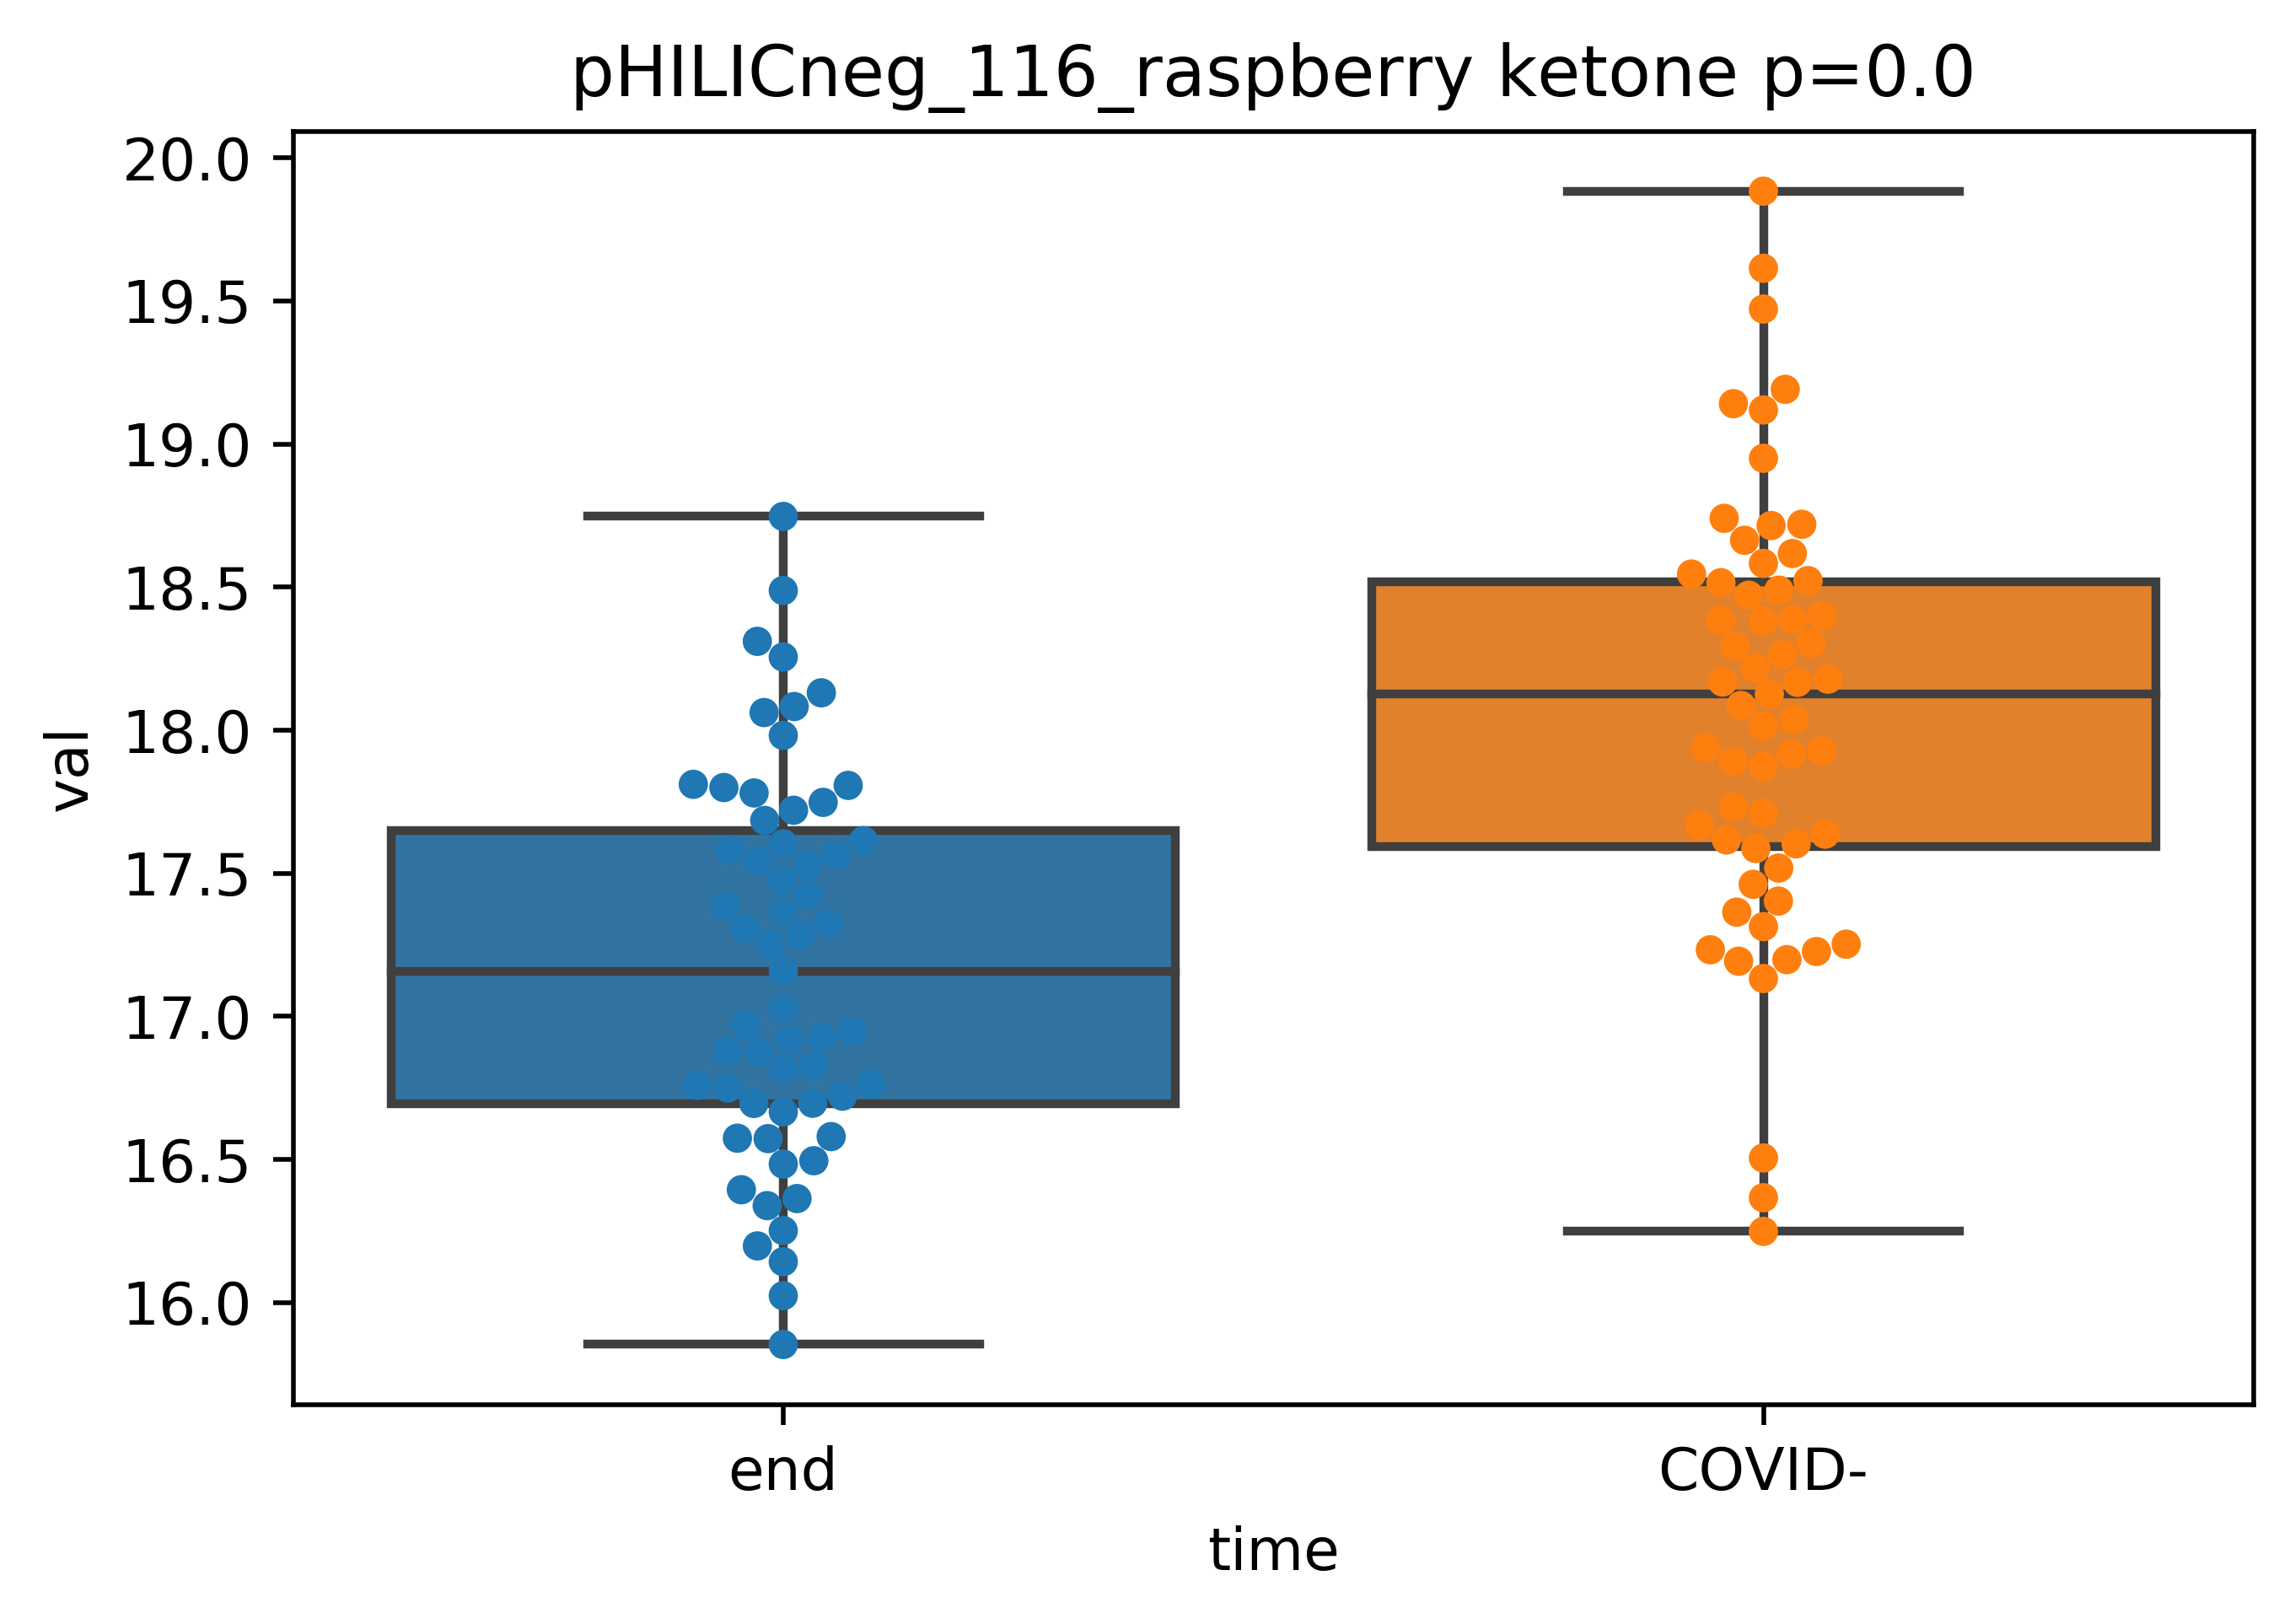

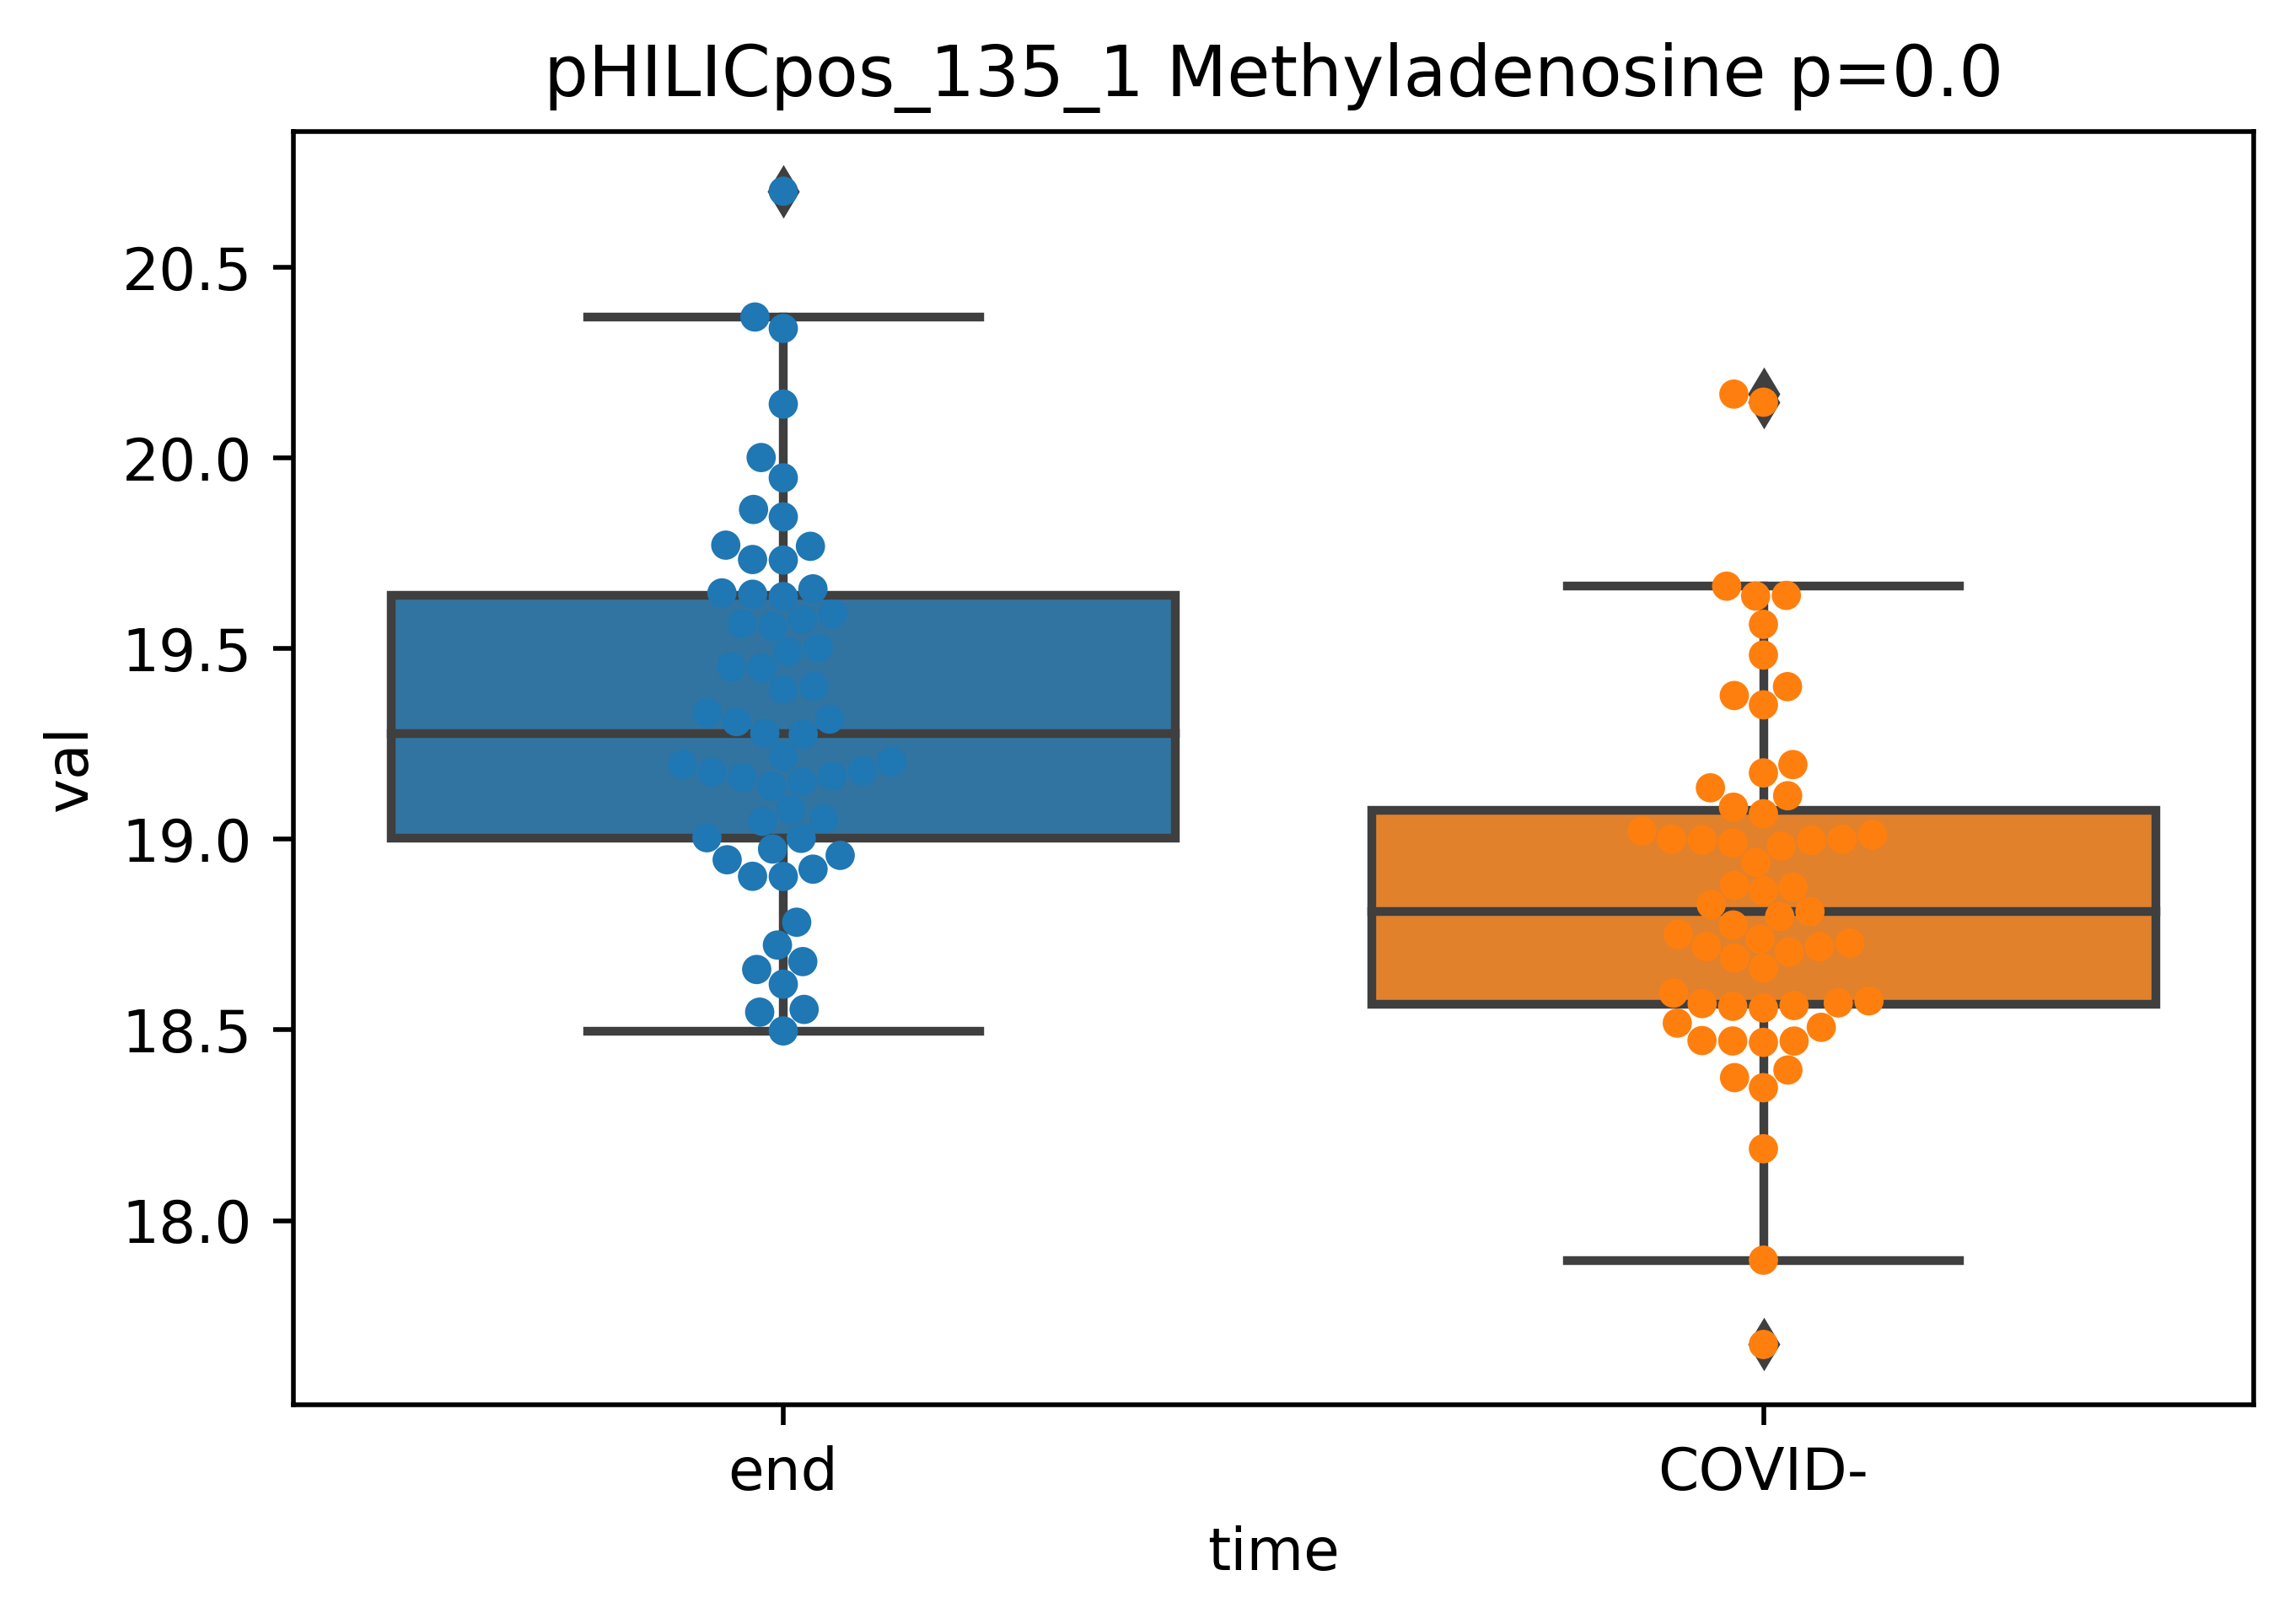

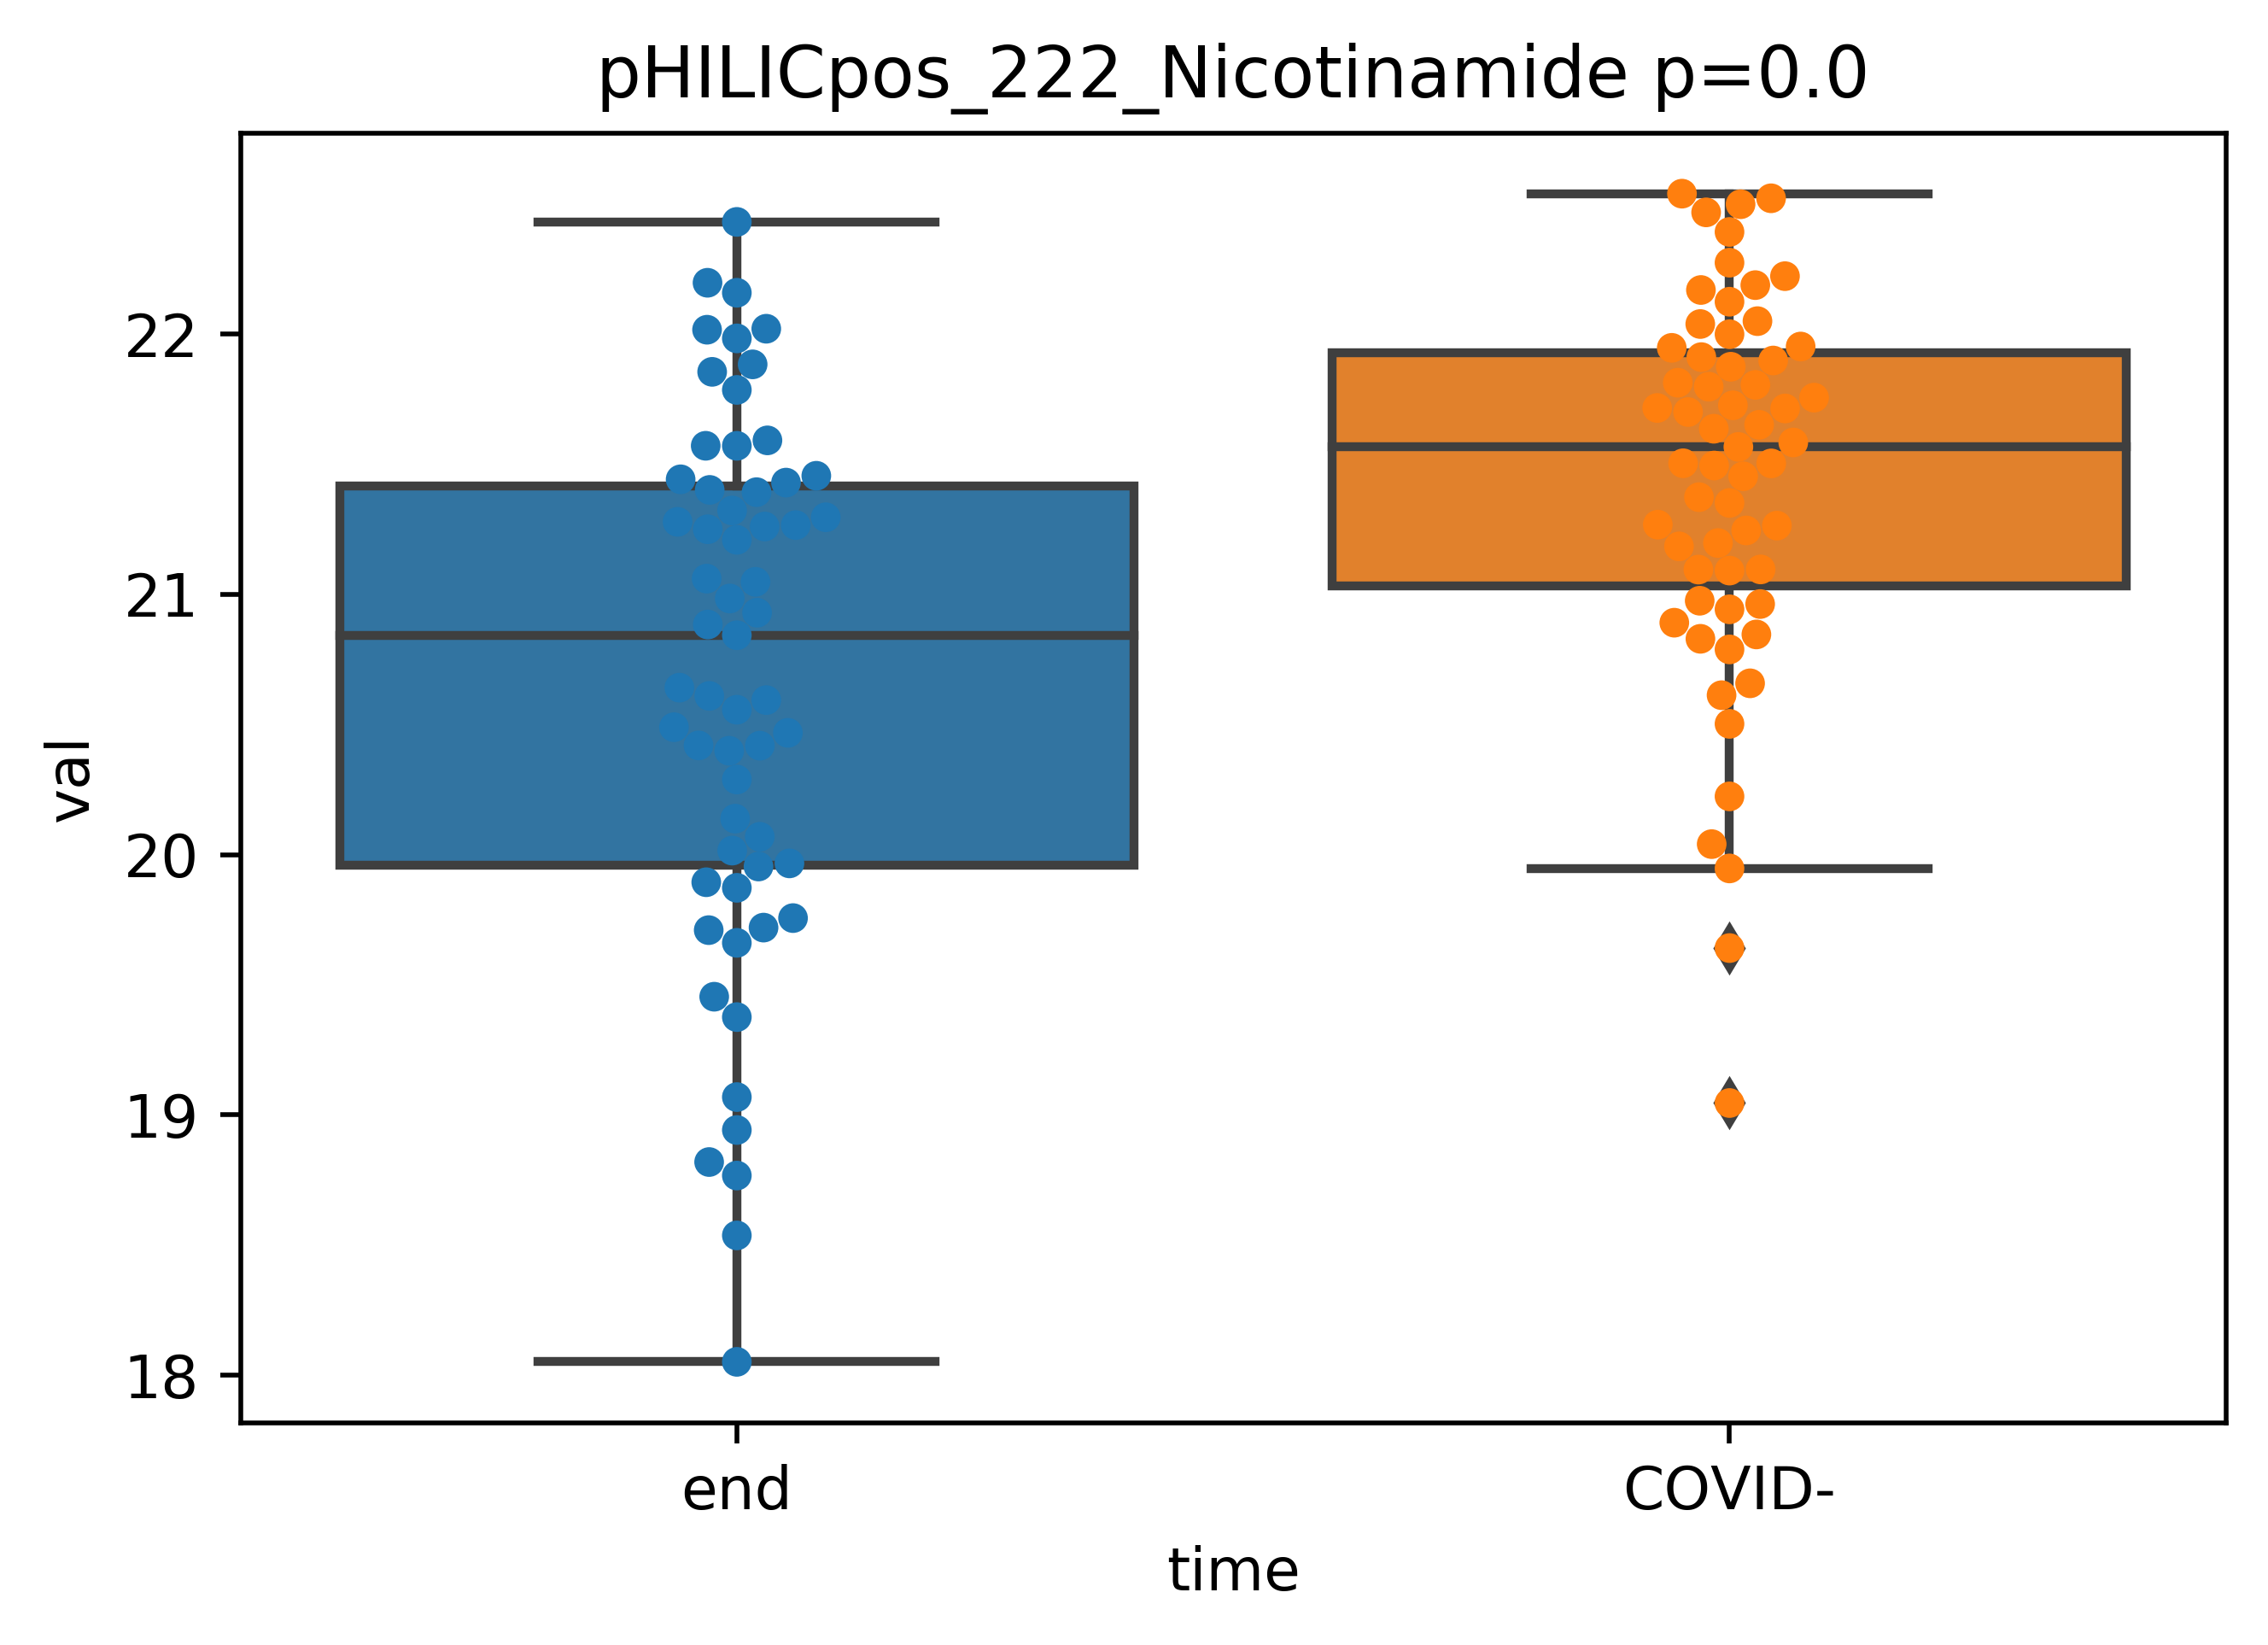

In [24]:

reject,pvals_corr,_,_ = multipletests(pvals,alpha,method="fdr_bh")
for name,p,plot_df in zip(var_imp.index.values,pvals_corr,plot_dfs):
     if p < alpha:
        print(name,p)
        plt.figure()
        sb.boxplot(data=plot_df,x="time",y="val")
        sb.swarmplot(data=plot_df,x="time",y="val")
        plt.title(name + " p=" + str(np.round(p,4)))


In [14]:
uniquePatients = list(set([x for x in sampleInfoDict["patient"]]))
goodPatients = [x for x in uniquePatients if len([y for y in sampleInfoDict["patient"].values if y == x]) > 1]
pvals = []
alpha = 0.05
plot_dfs = []
for met in range(len(var_imp)):
    starts = []
    icus = []
    ends = []
    for pat in goodPatients:
        subset = sampleInfoDict[sampleInfoDict["patient"] == pat]
        relsamples = subset["index"].values
        times = subset["sample_day"].values
        ICU = subset["ICU"].values[0]
        mort = subset["death"].values[0]
        if not ICU and mort == "Alive":
            tmp = samp_int[relsamples,met]
            order = list(range(len(times)))
            order.sort(key=lambda x:times[x])
            tmp = tmp[order]
            #tmp = tmp - tmp[0]
            times = [times[x] for x in order]
            ends.append(tmp[-1])
    df = dict()
    ind = 0
    ps = 0
    for e in ends:
        df[ind] = {"time":"end","val":e}
        ind += 1
        
    for v in val_int[:,met]:
        df[ind] = {"time":"COVID-","val":v}
        ind += 1

    df = pd.DataFrame.from_dict(df,orient="index")
    plot_dfs.append(df)
    _,p = stats.ttest_ind(df[df["time"] == "end"]["val"].values,df[df["time"] == "COVID-"]["val"].values,equal_var=False)
    pvals.append(p)


HSSpos_LPC 0:0/14:0_3.126 0.0007008948425065583
HSSpos_LPC 0:0/16:0_4.715 0.015464343389165339
HSSpos_LPC 0:0/18:0_6.997 0.015464343389165339
HSSpos_LPC 14:0/0:0_3.387 0.0007008948425065583
HSSpos_LPC 15:0/0:0_4.164 0.021682067952424187
HSSpos_LPC 16:0/0:0_5.147 0.021682067952424187
HSSpos_LPC 16:1/0:0_3.734 0.0007747510626918817
HSSpos_LPC 18:0/0:0_7.547 0.021682067952424187
HSSpos_LPC 18:1/0:0_5.589 0.042891980030503436
HSSpos_LPC 20:2/0:0_6.105 0.0007747510626918817
HSSpos_LPC 20:3/0:0_4.813 0.00763323122514324
HSSpos_PC 18:2_22:6_15.427 0.015464343389165339
HSSpos_PC 20:4_20:4_15.512 0.015464343389165339
HSSpos_PC 38:6_15.829 0.0008988545813752213
pHILICneg_116_raspberry ketone 0.009479660293902733
pHILICpos_135_1 Methyladenosine 0.014107935907053677
pHILICpos_222_Nicotinamide 0.0007747510626918817


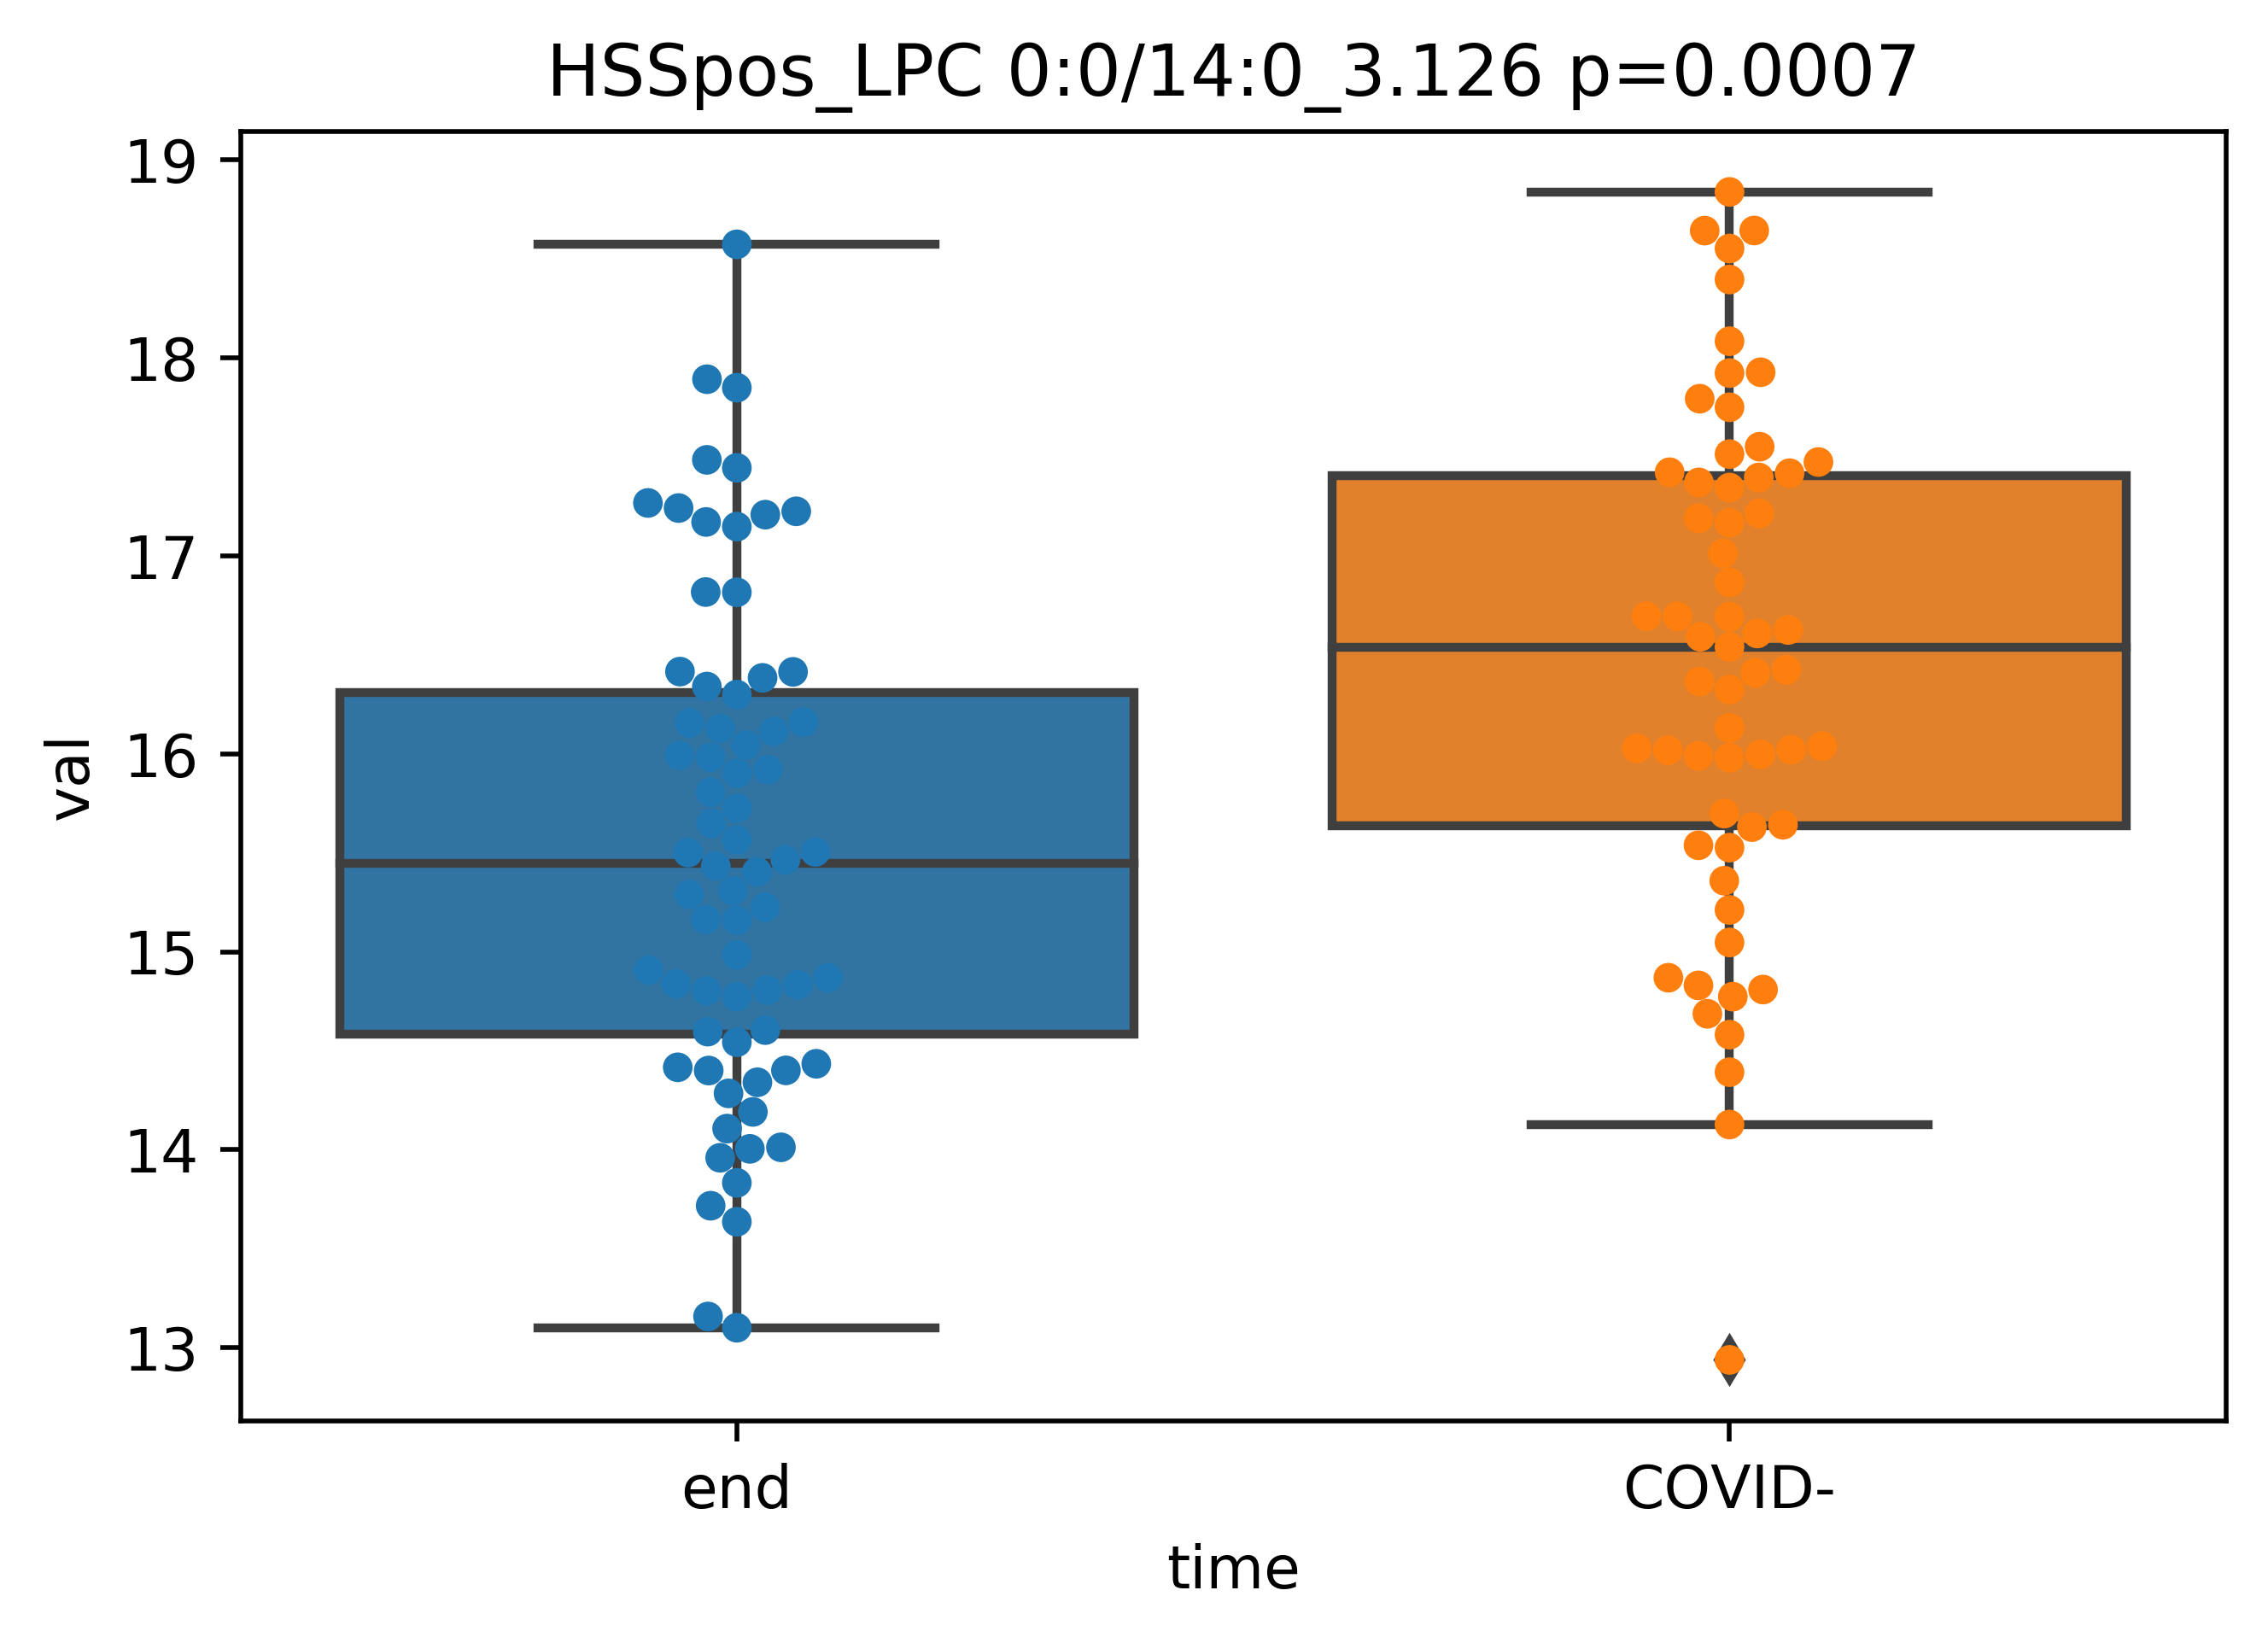

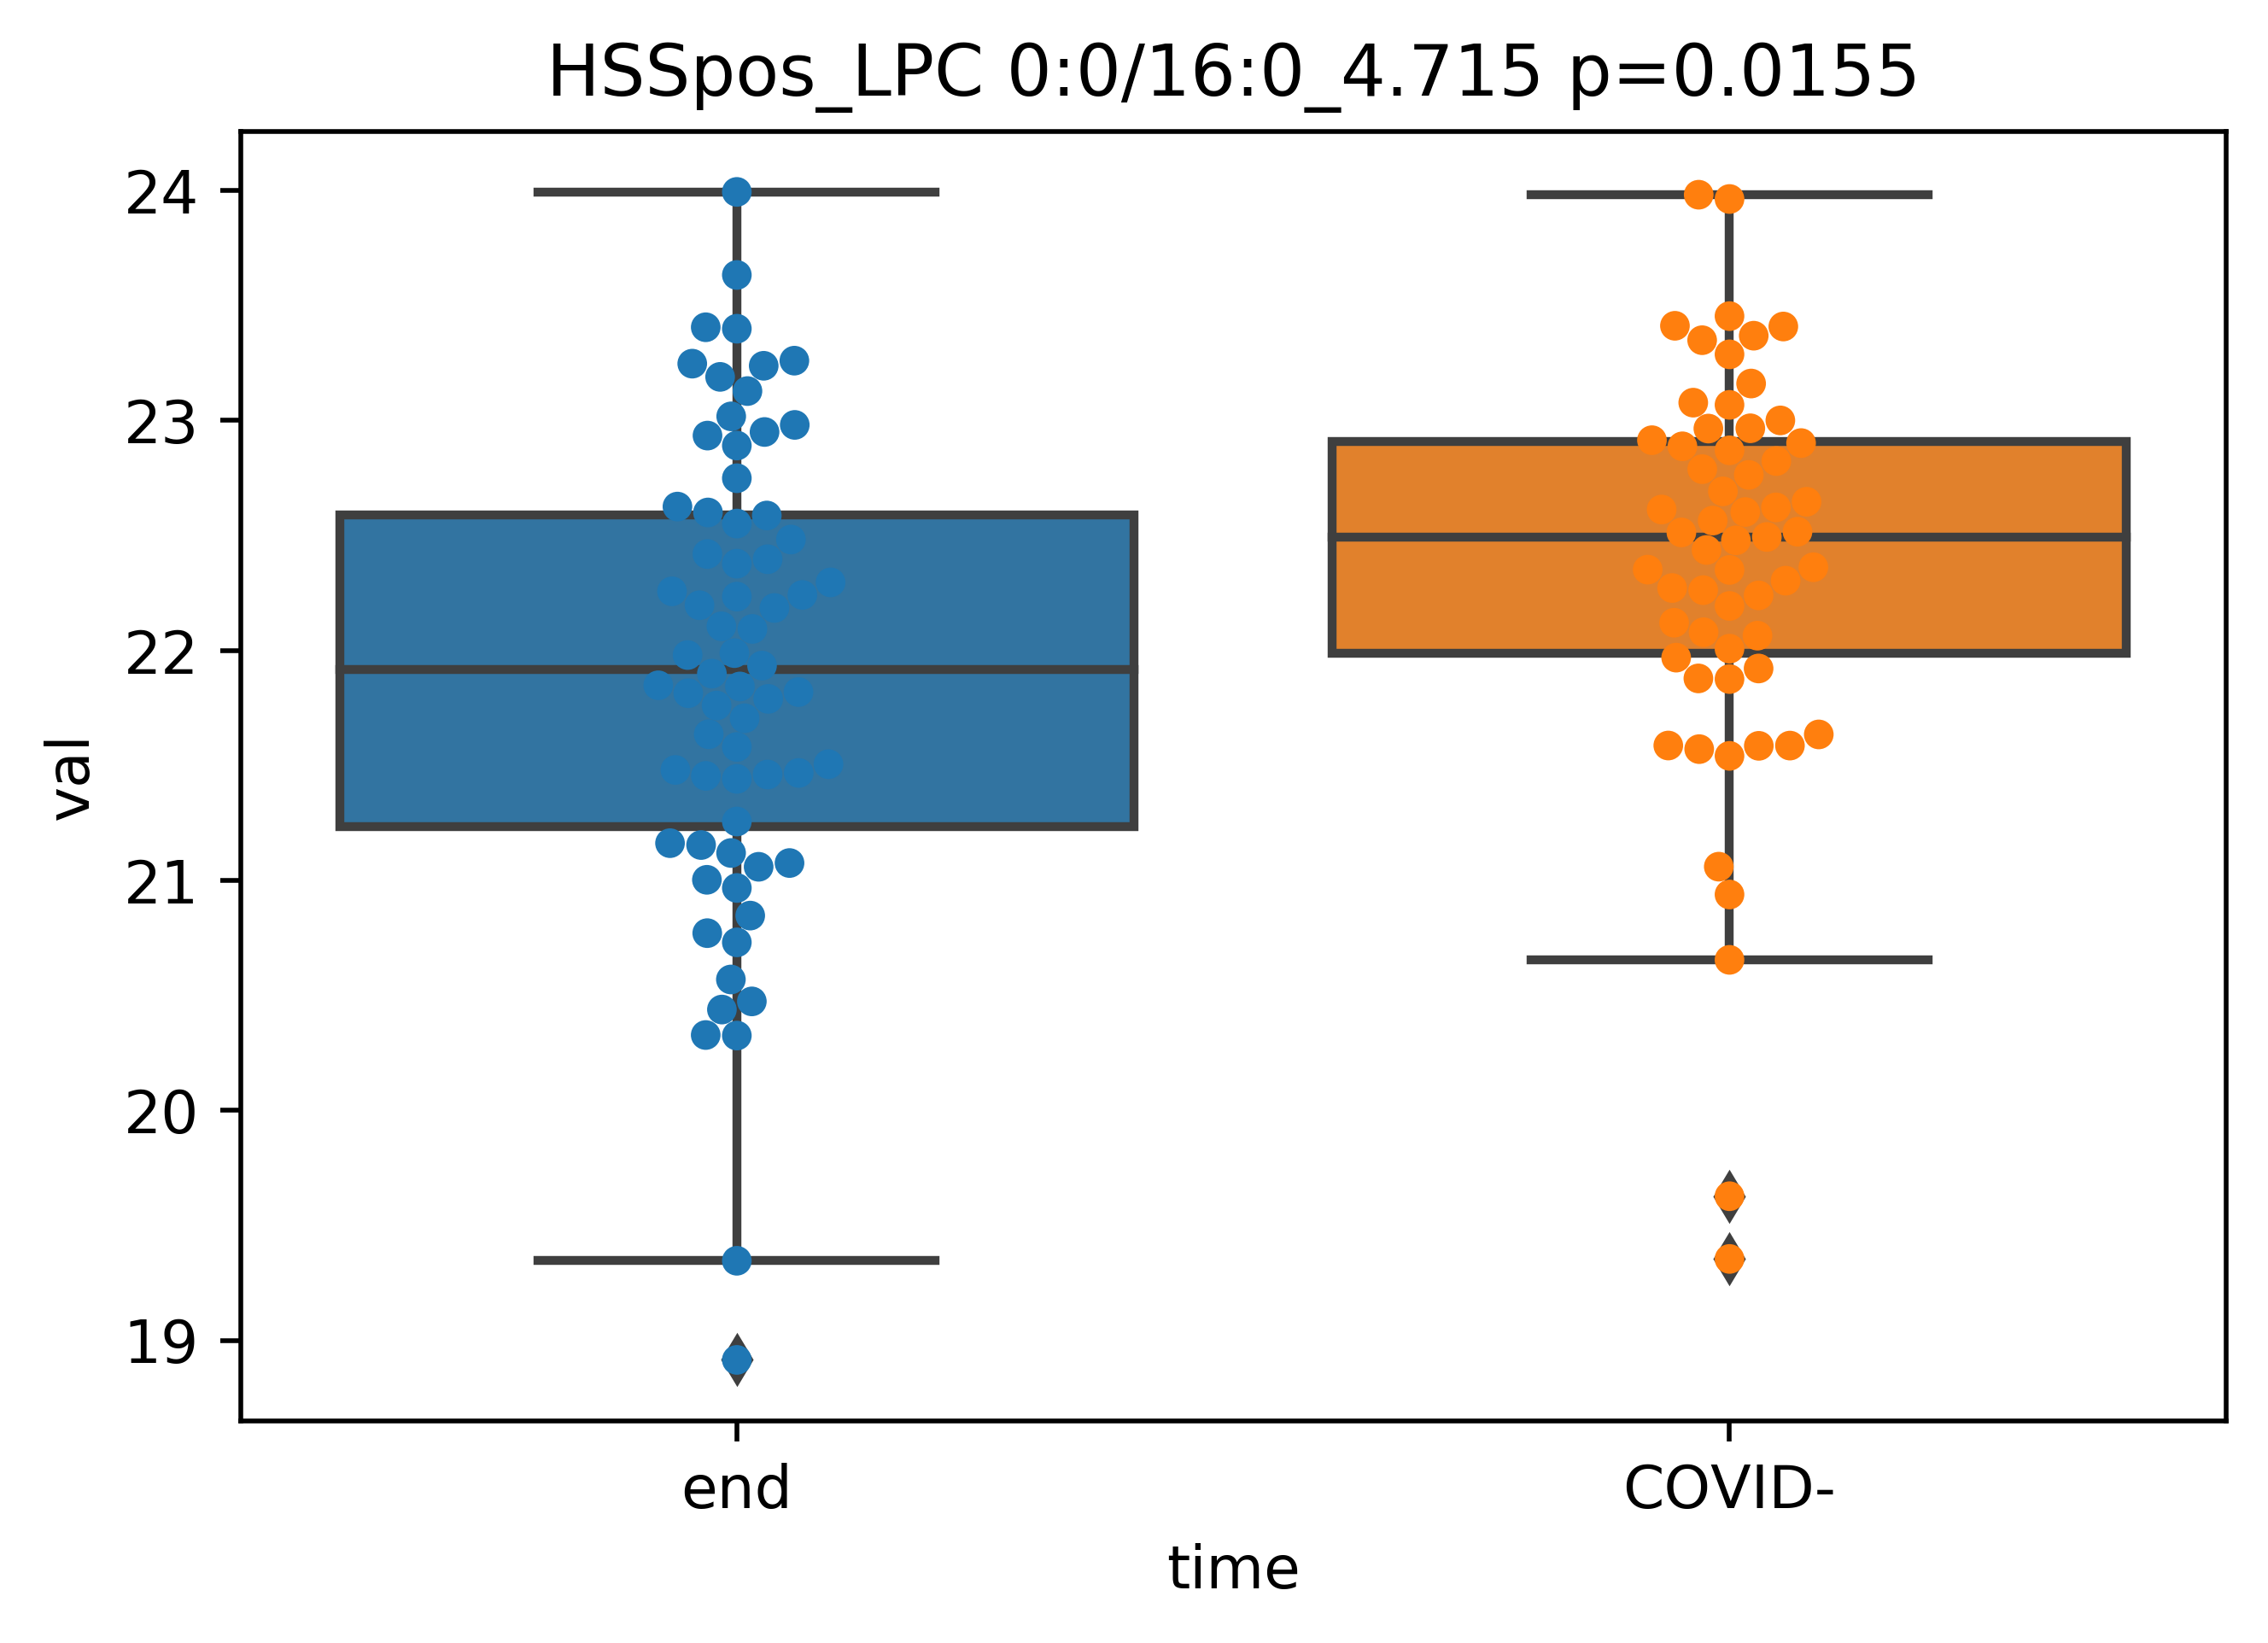

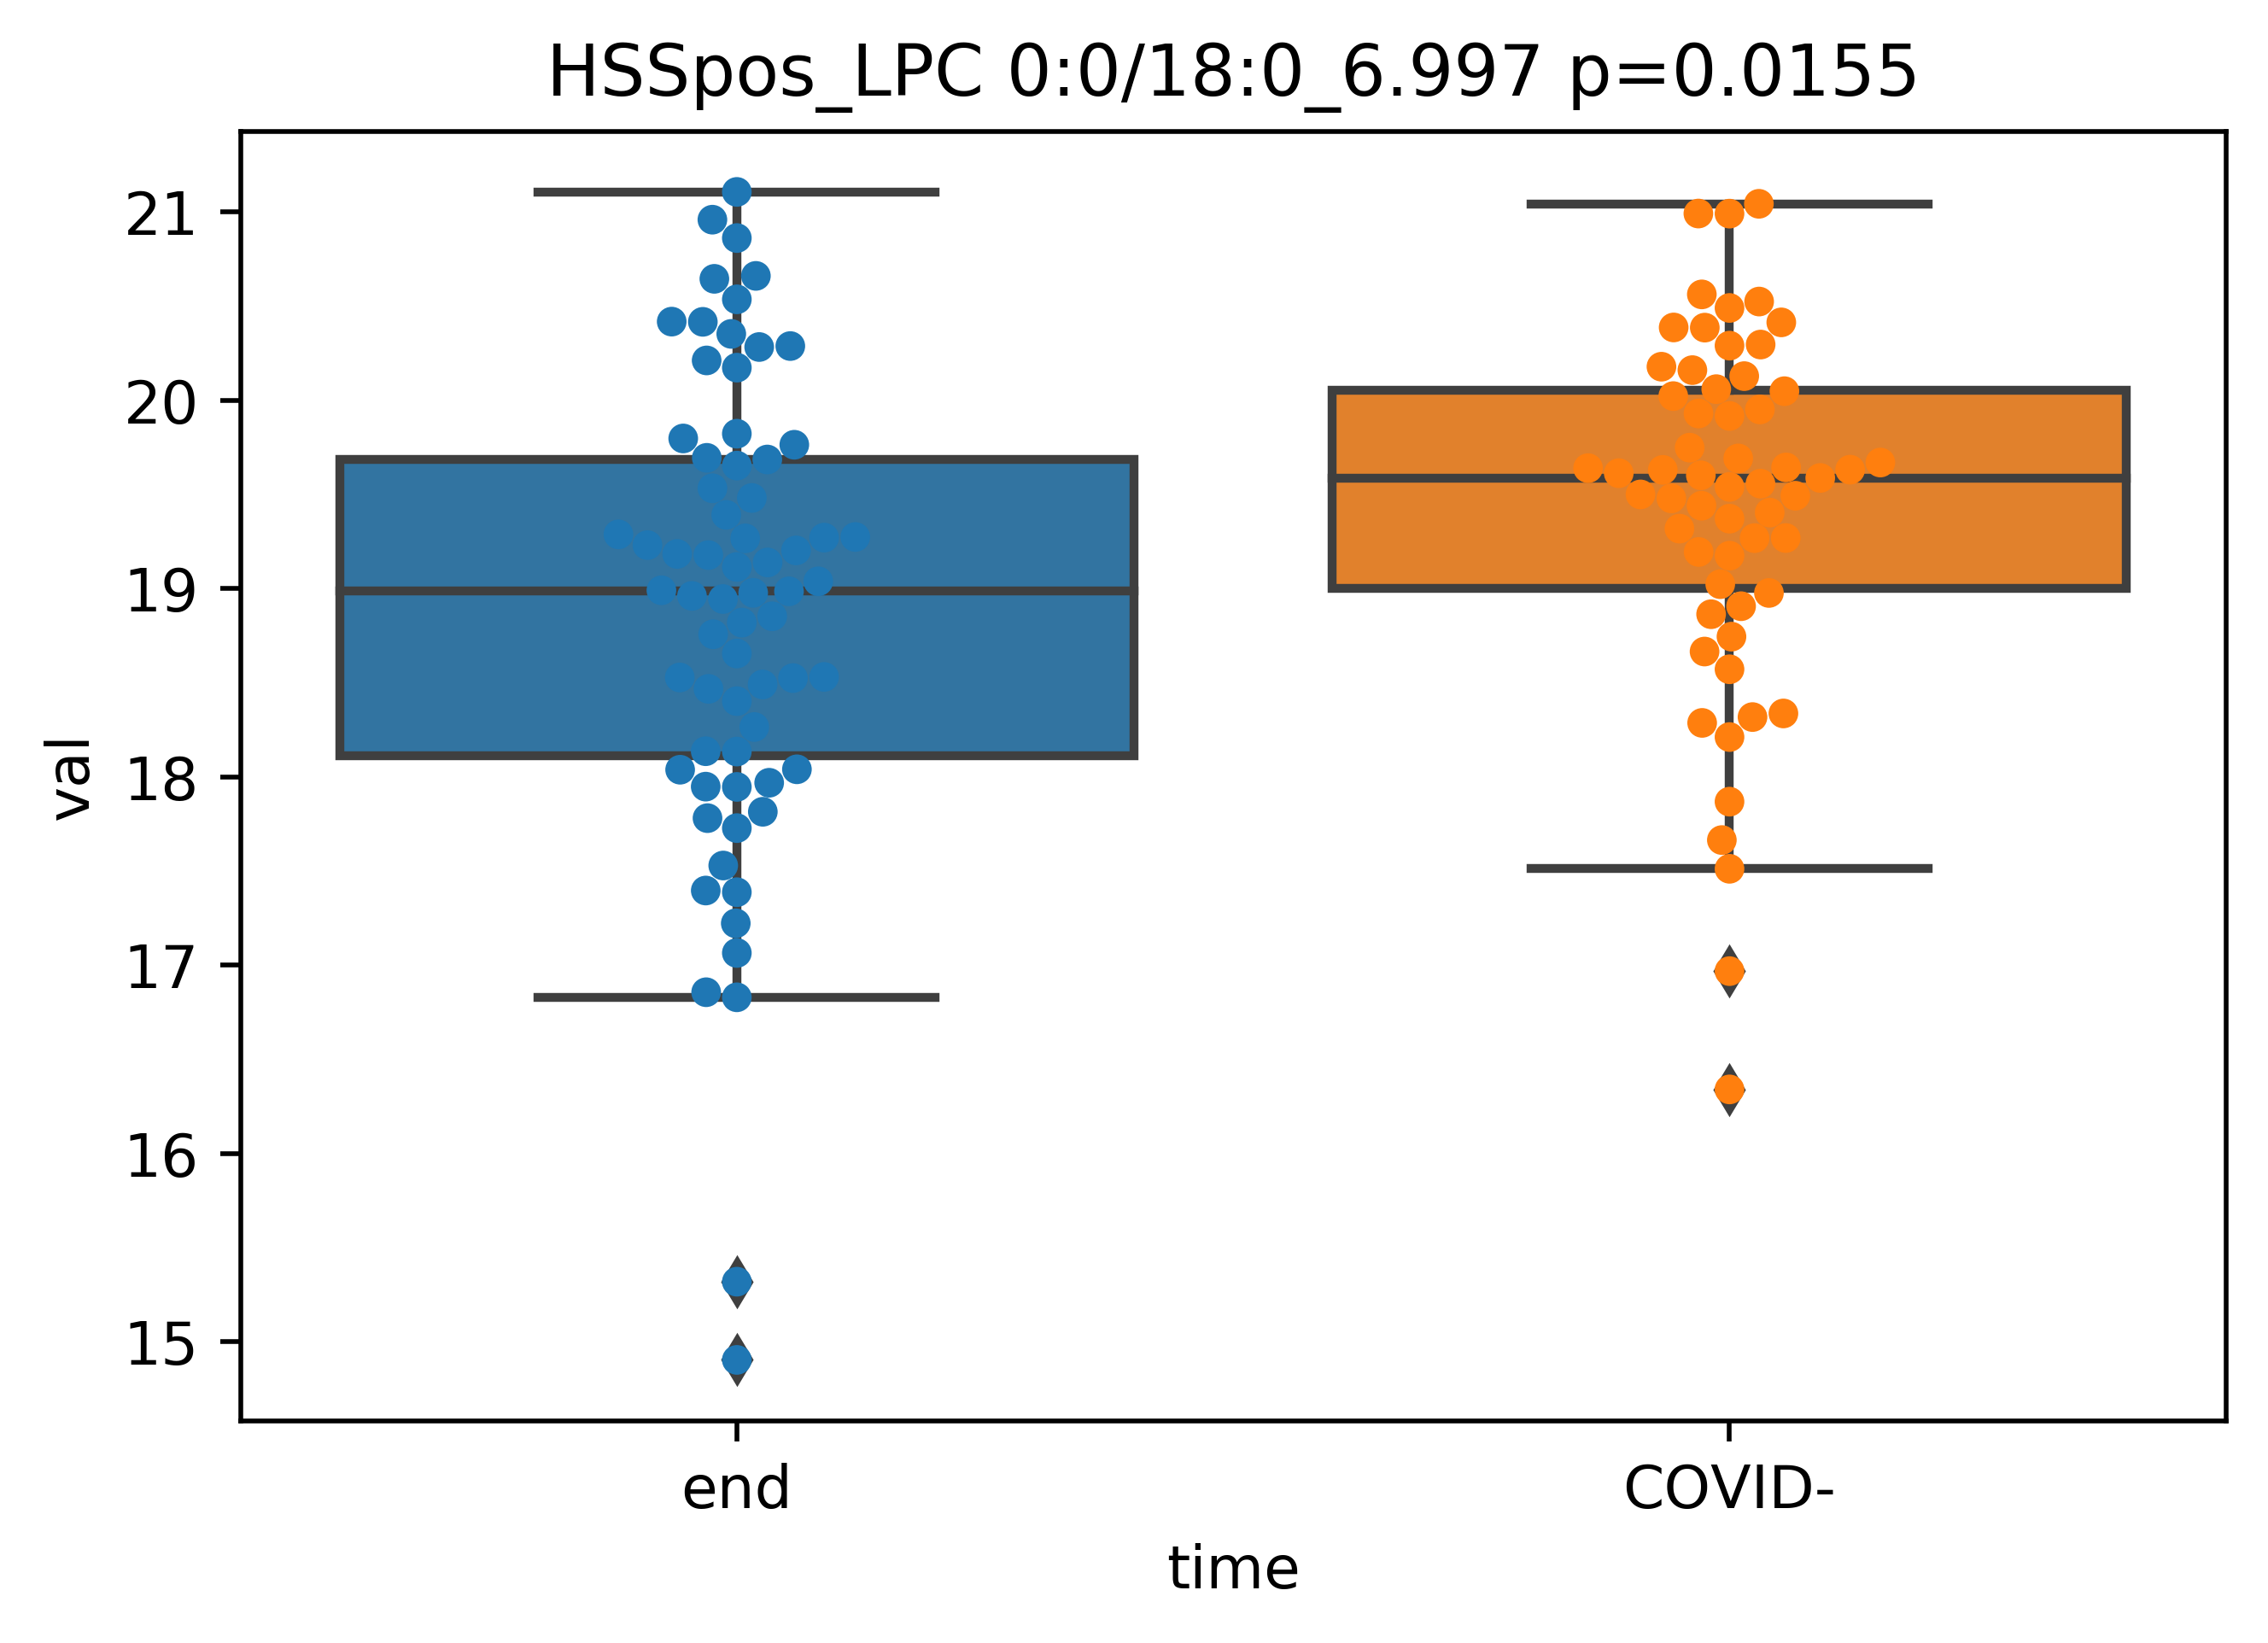

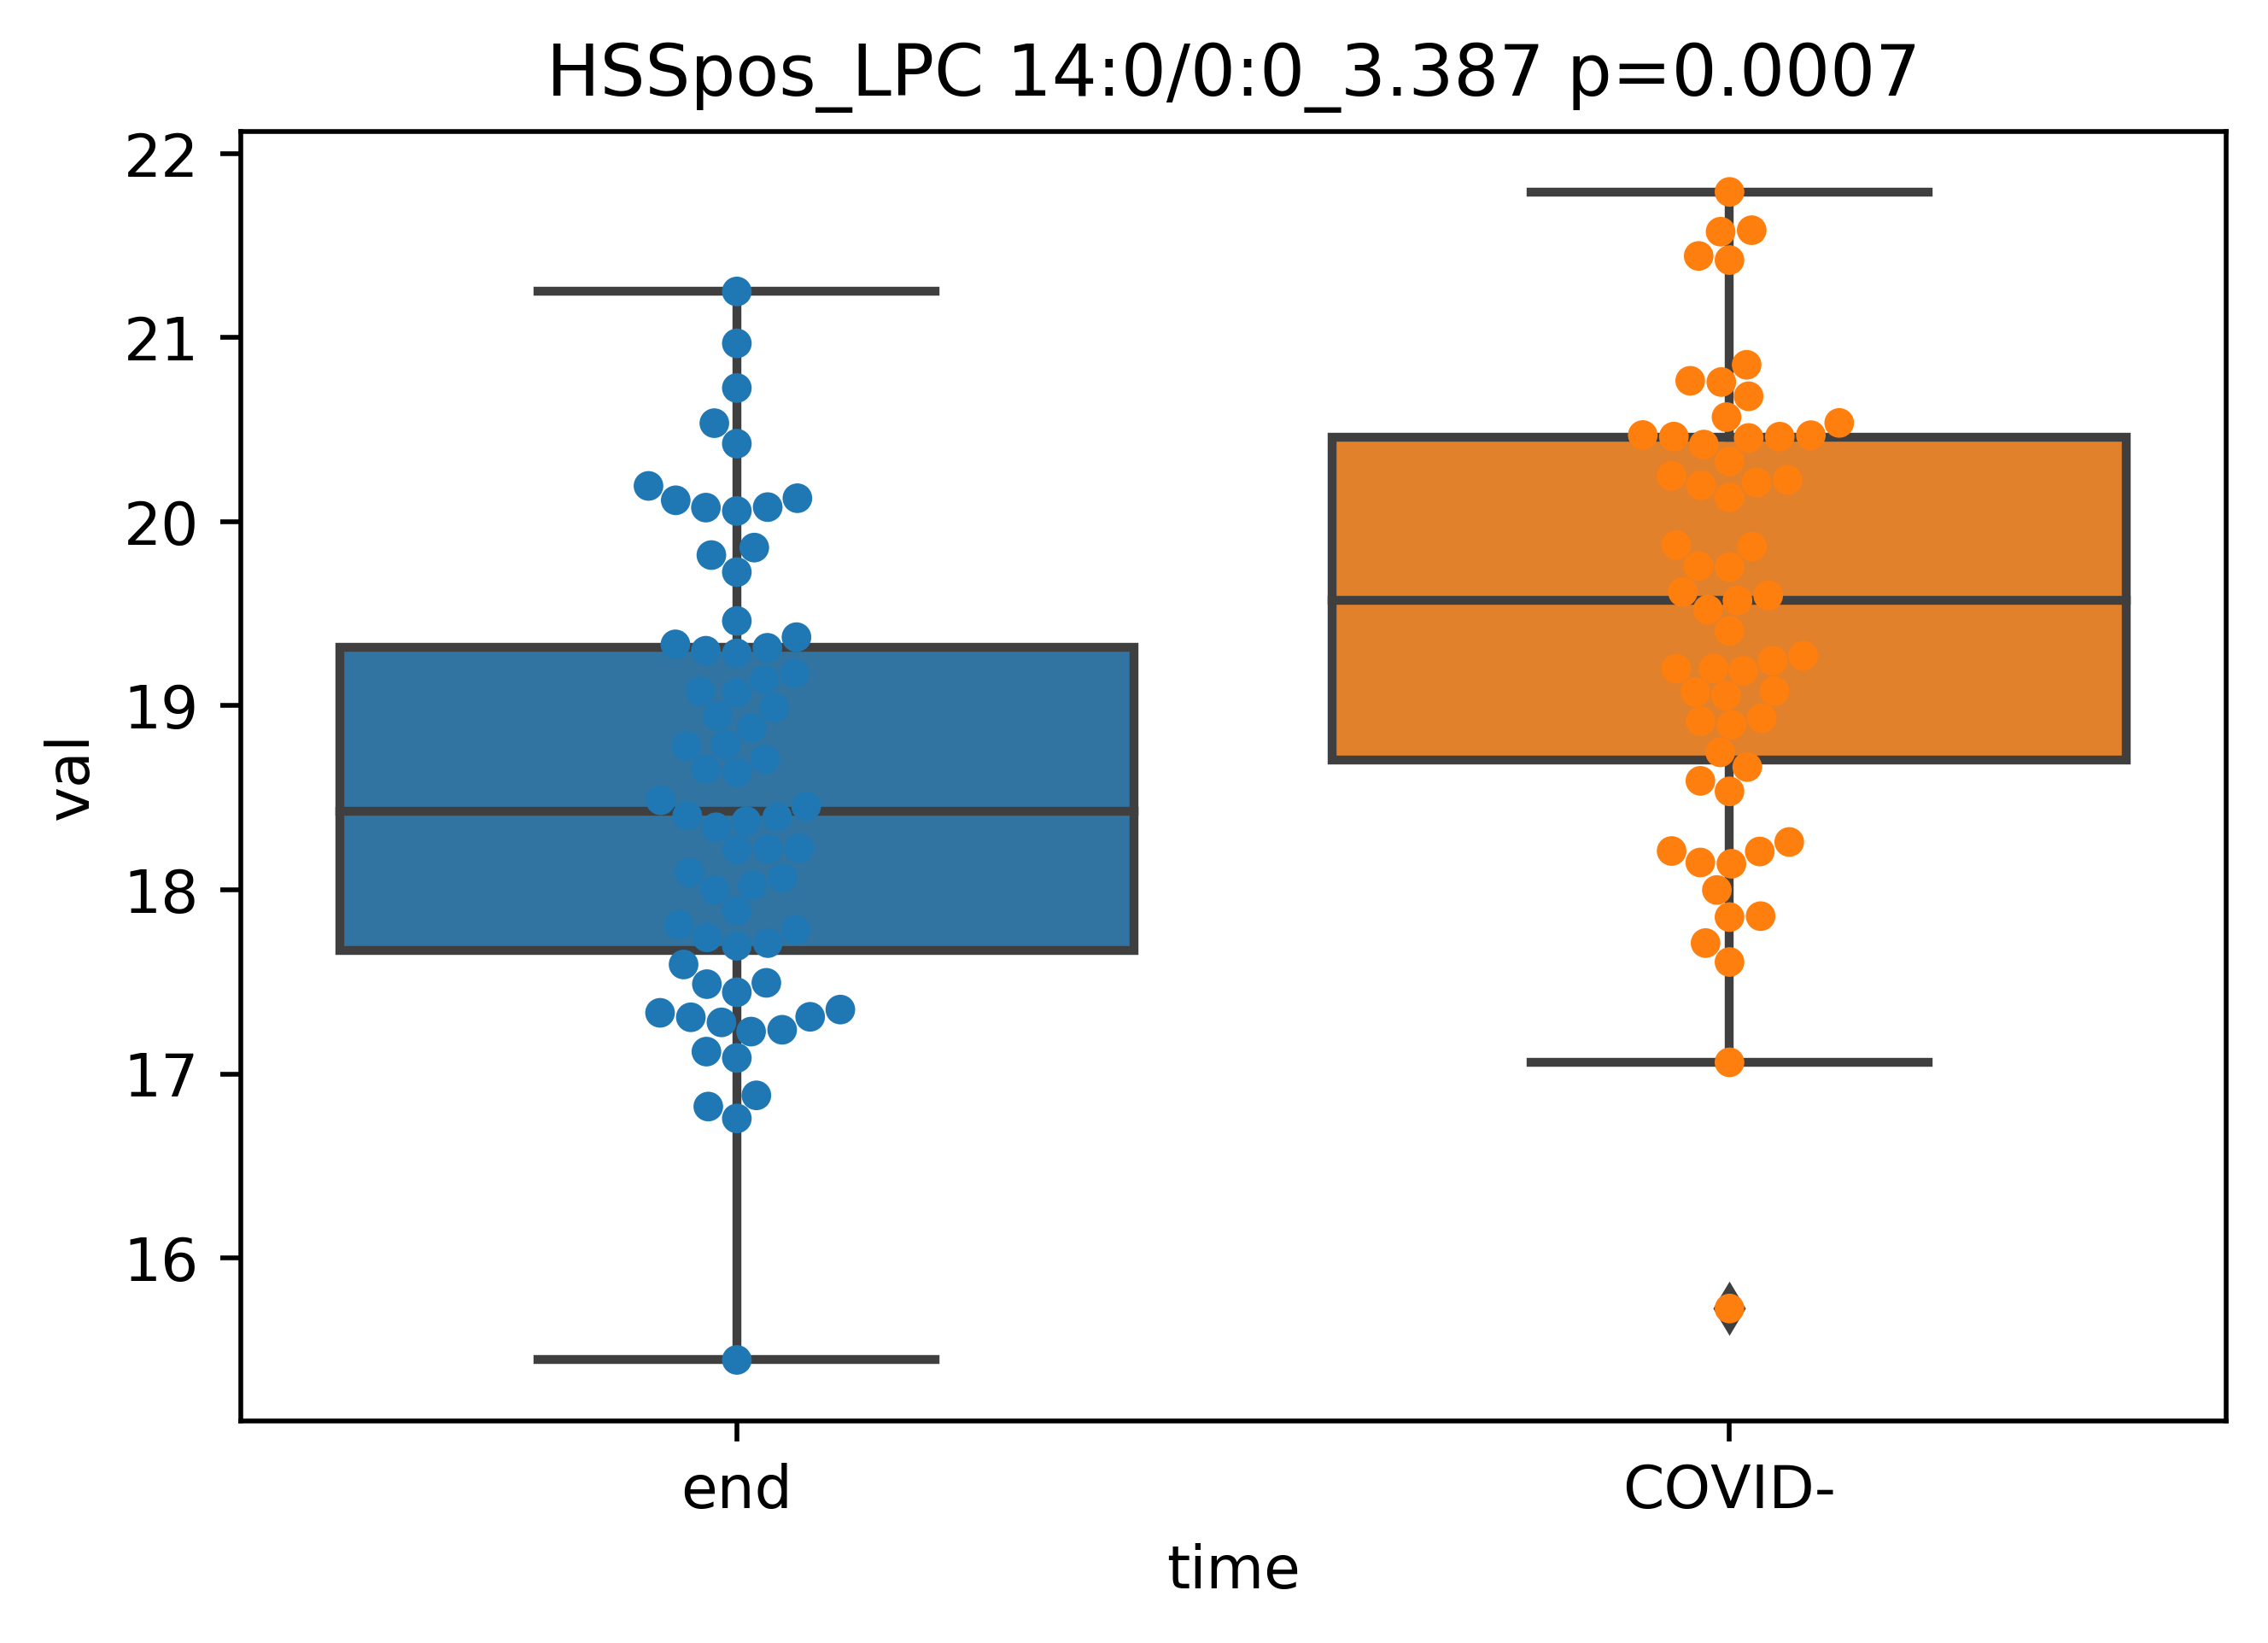

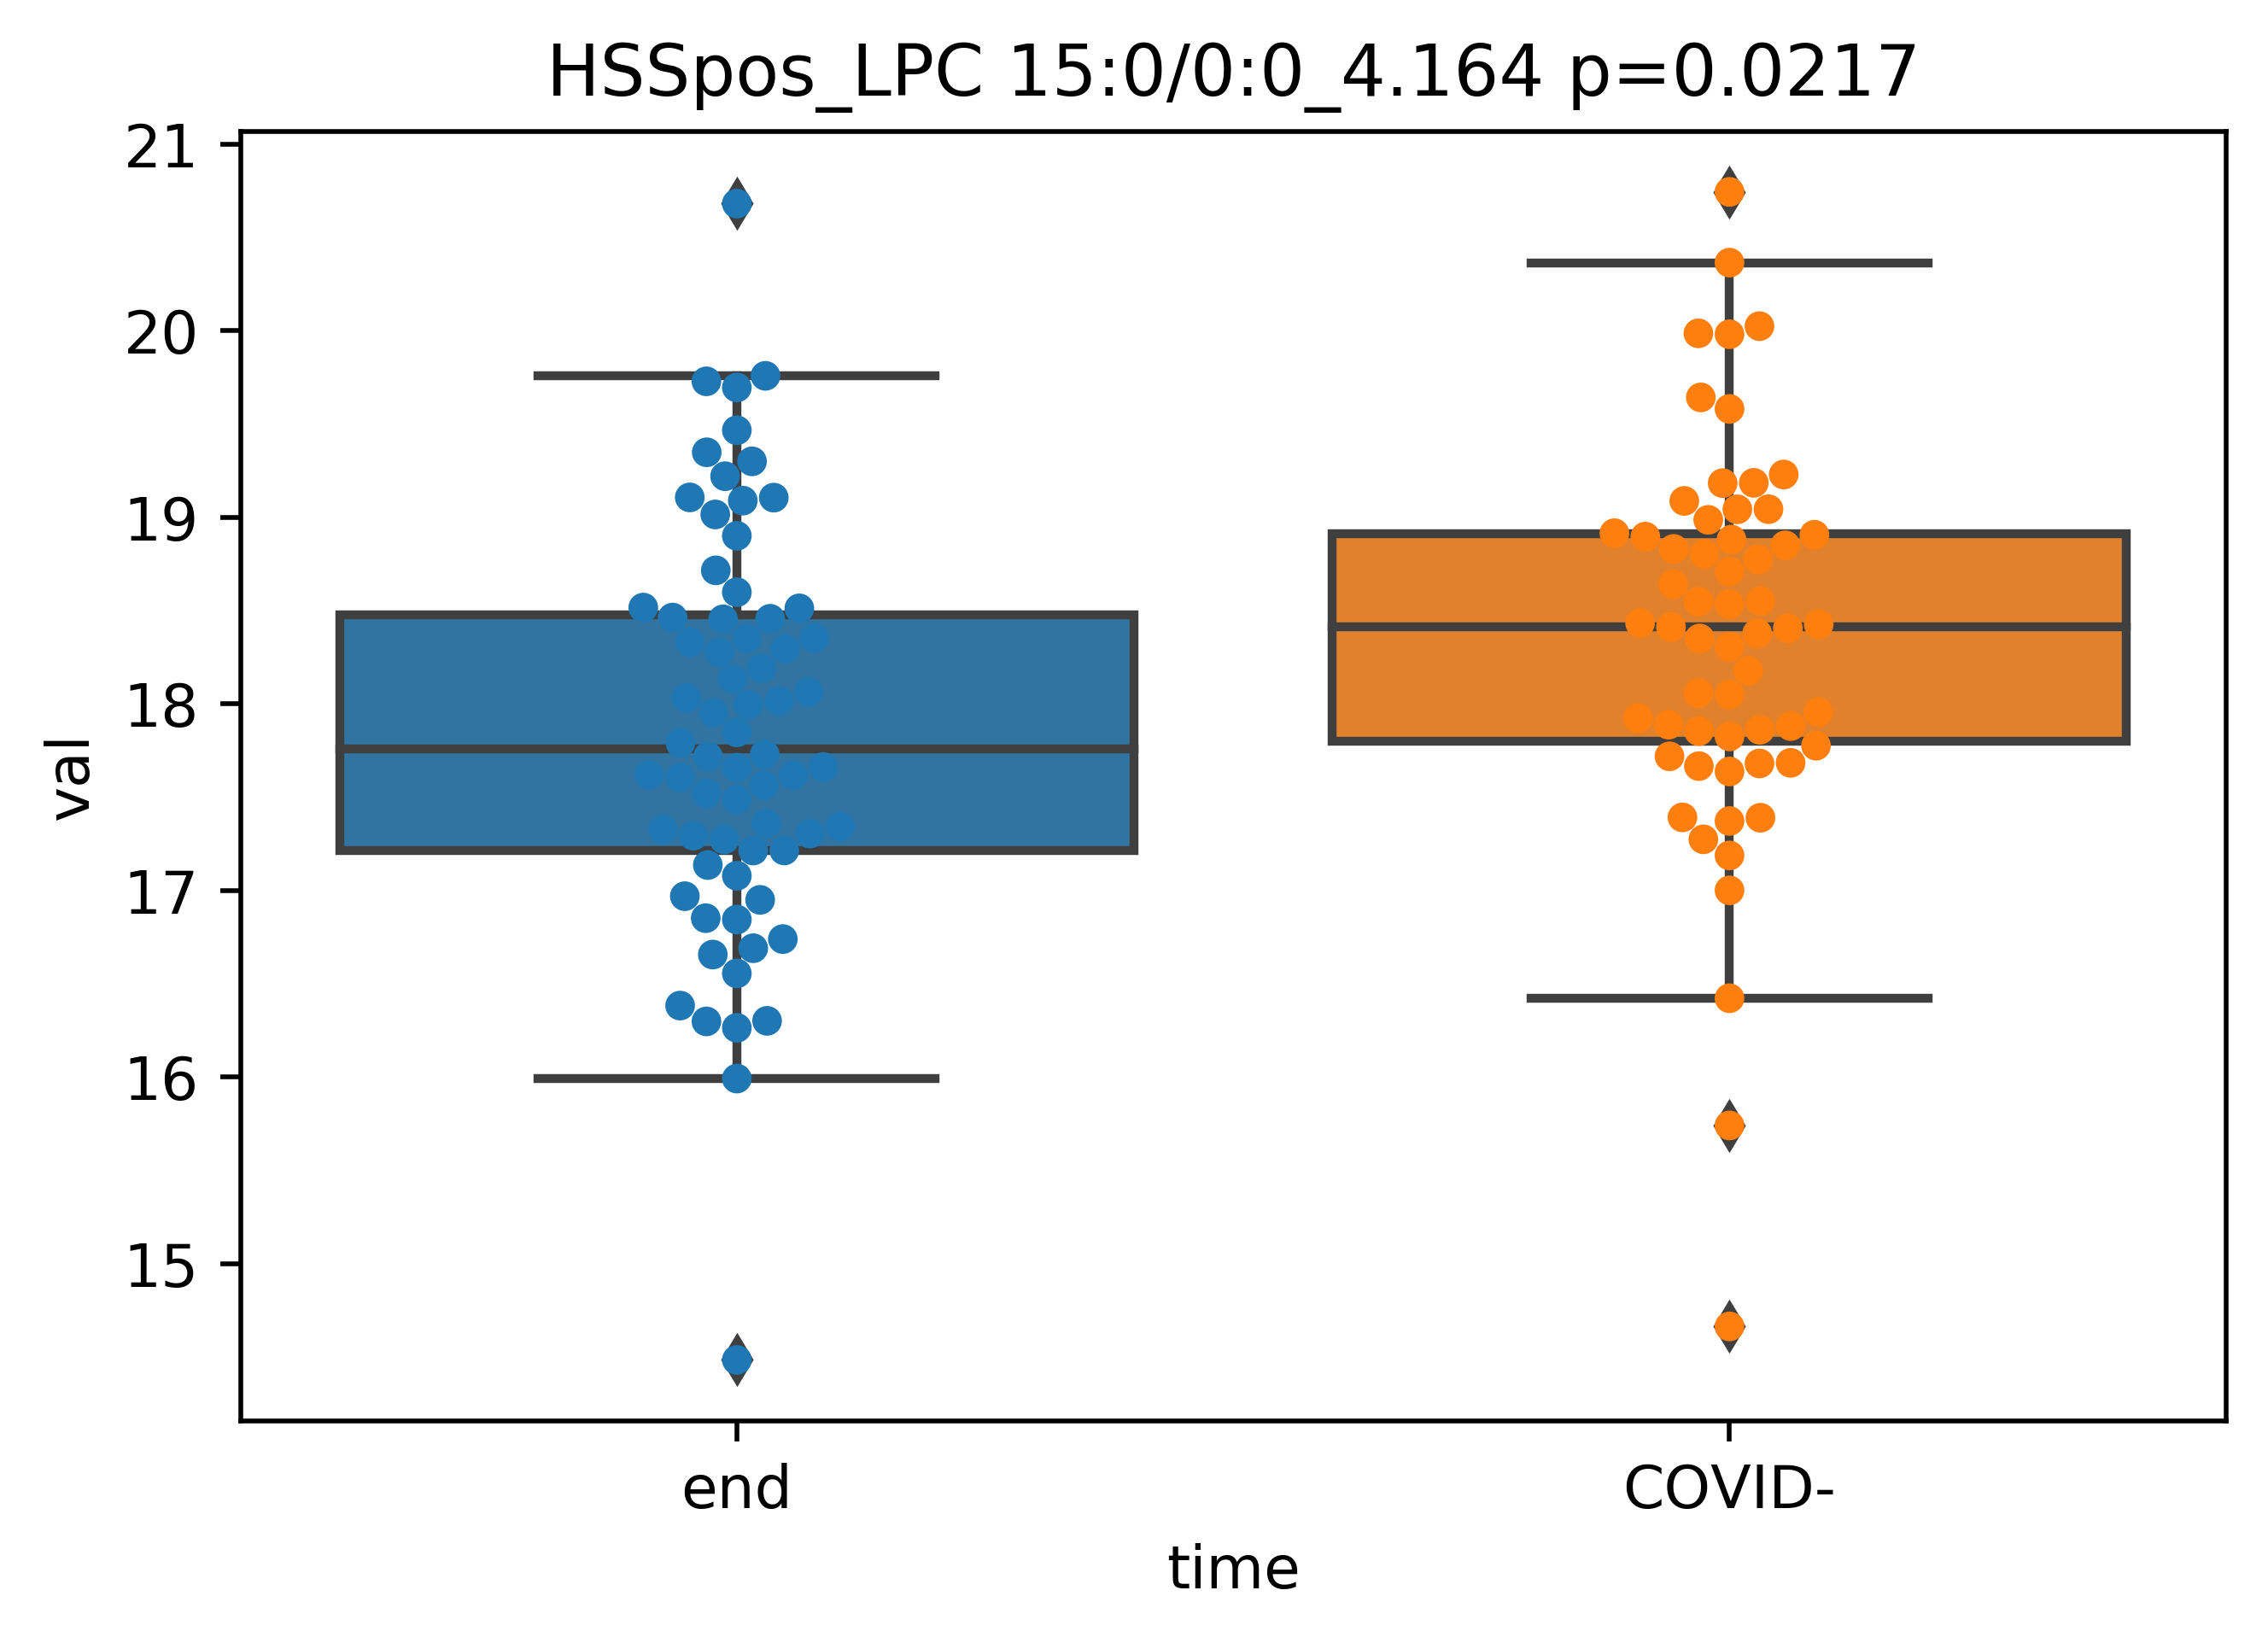

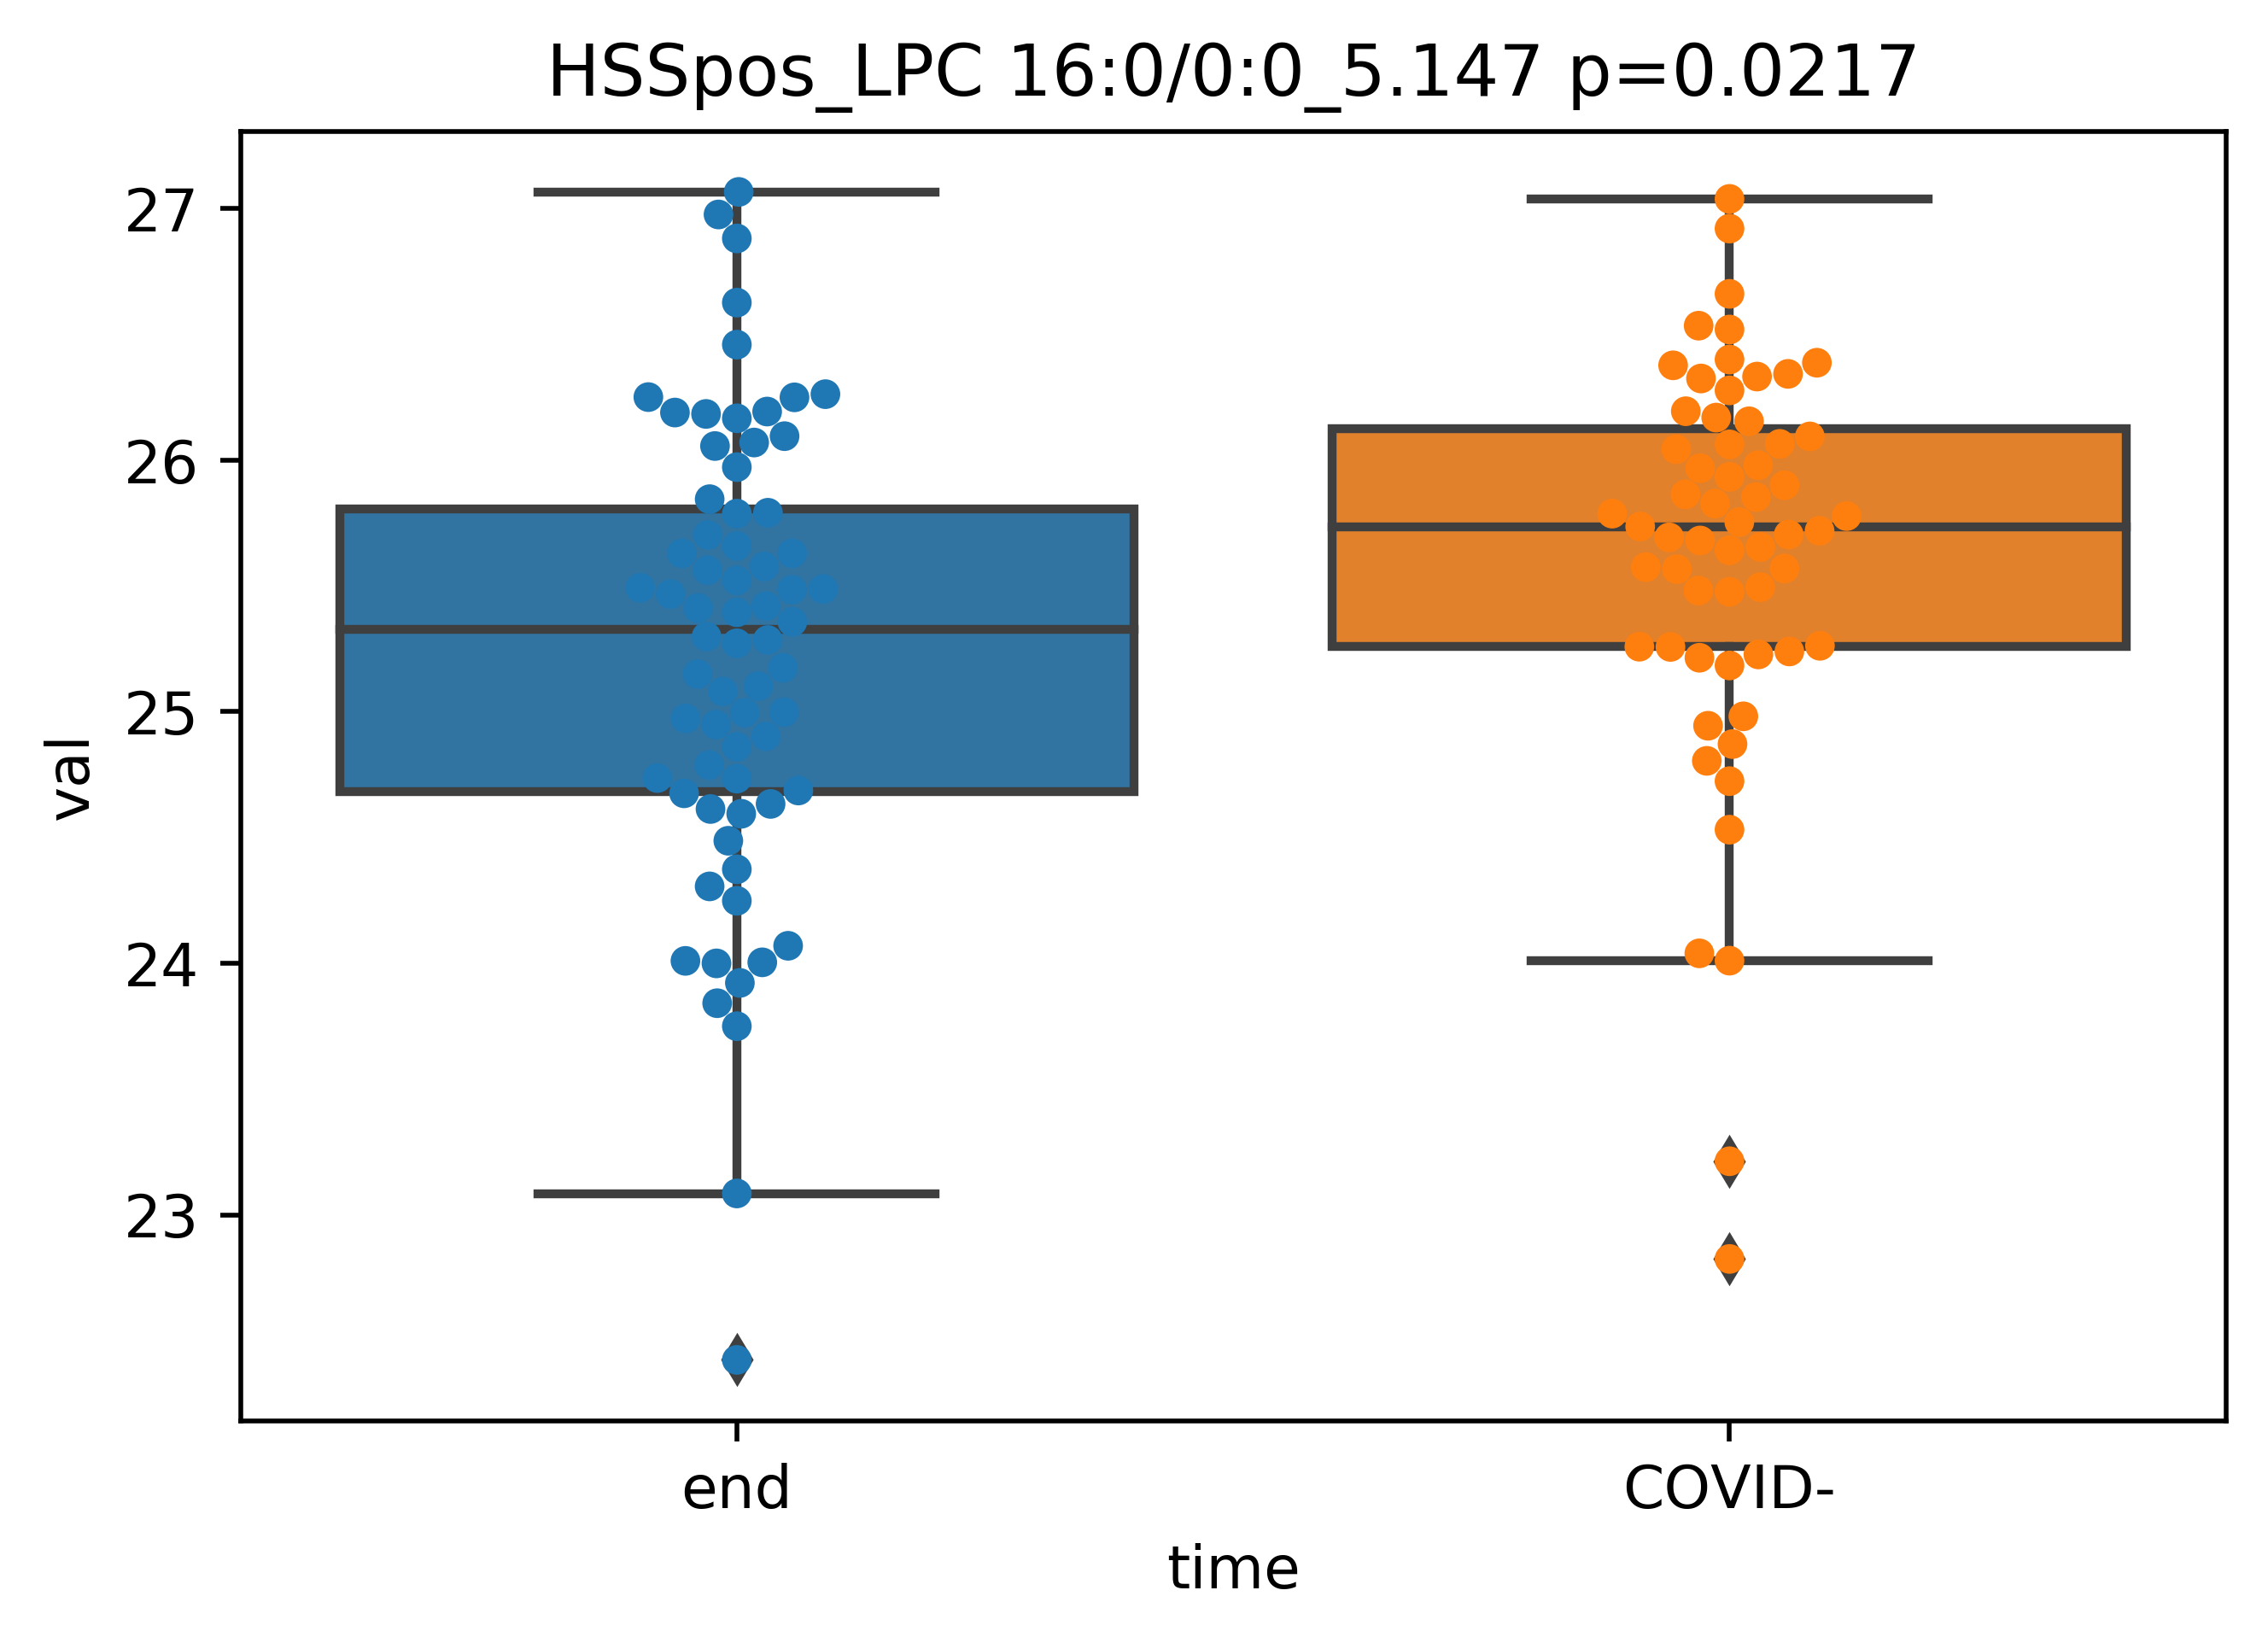

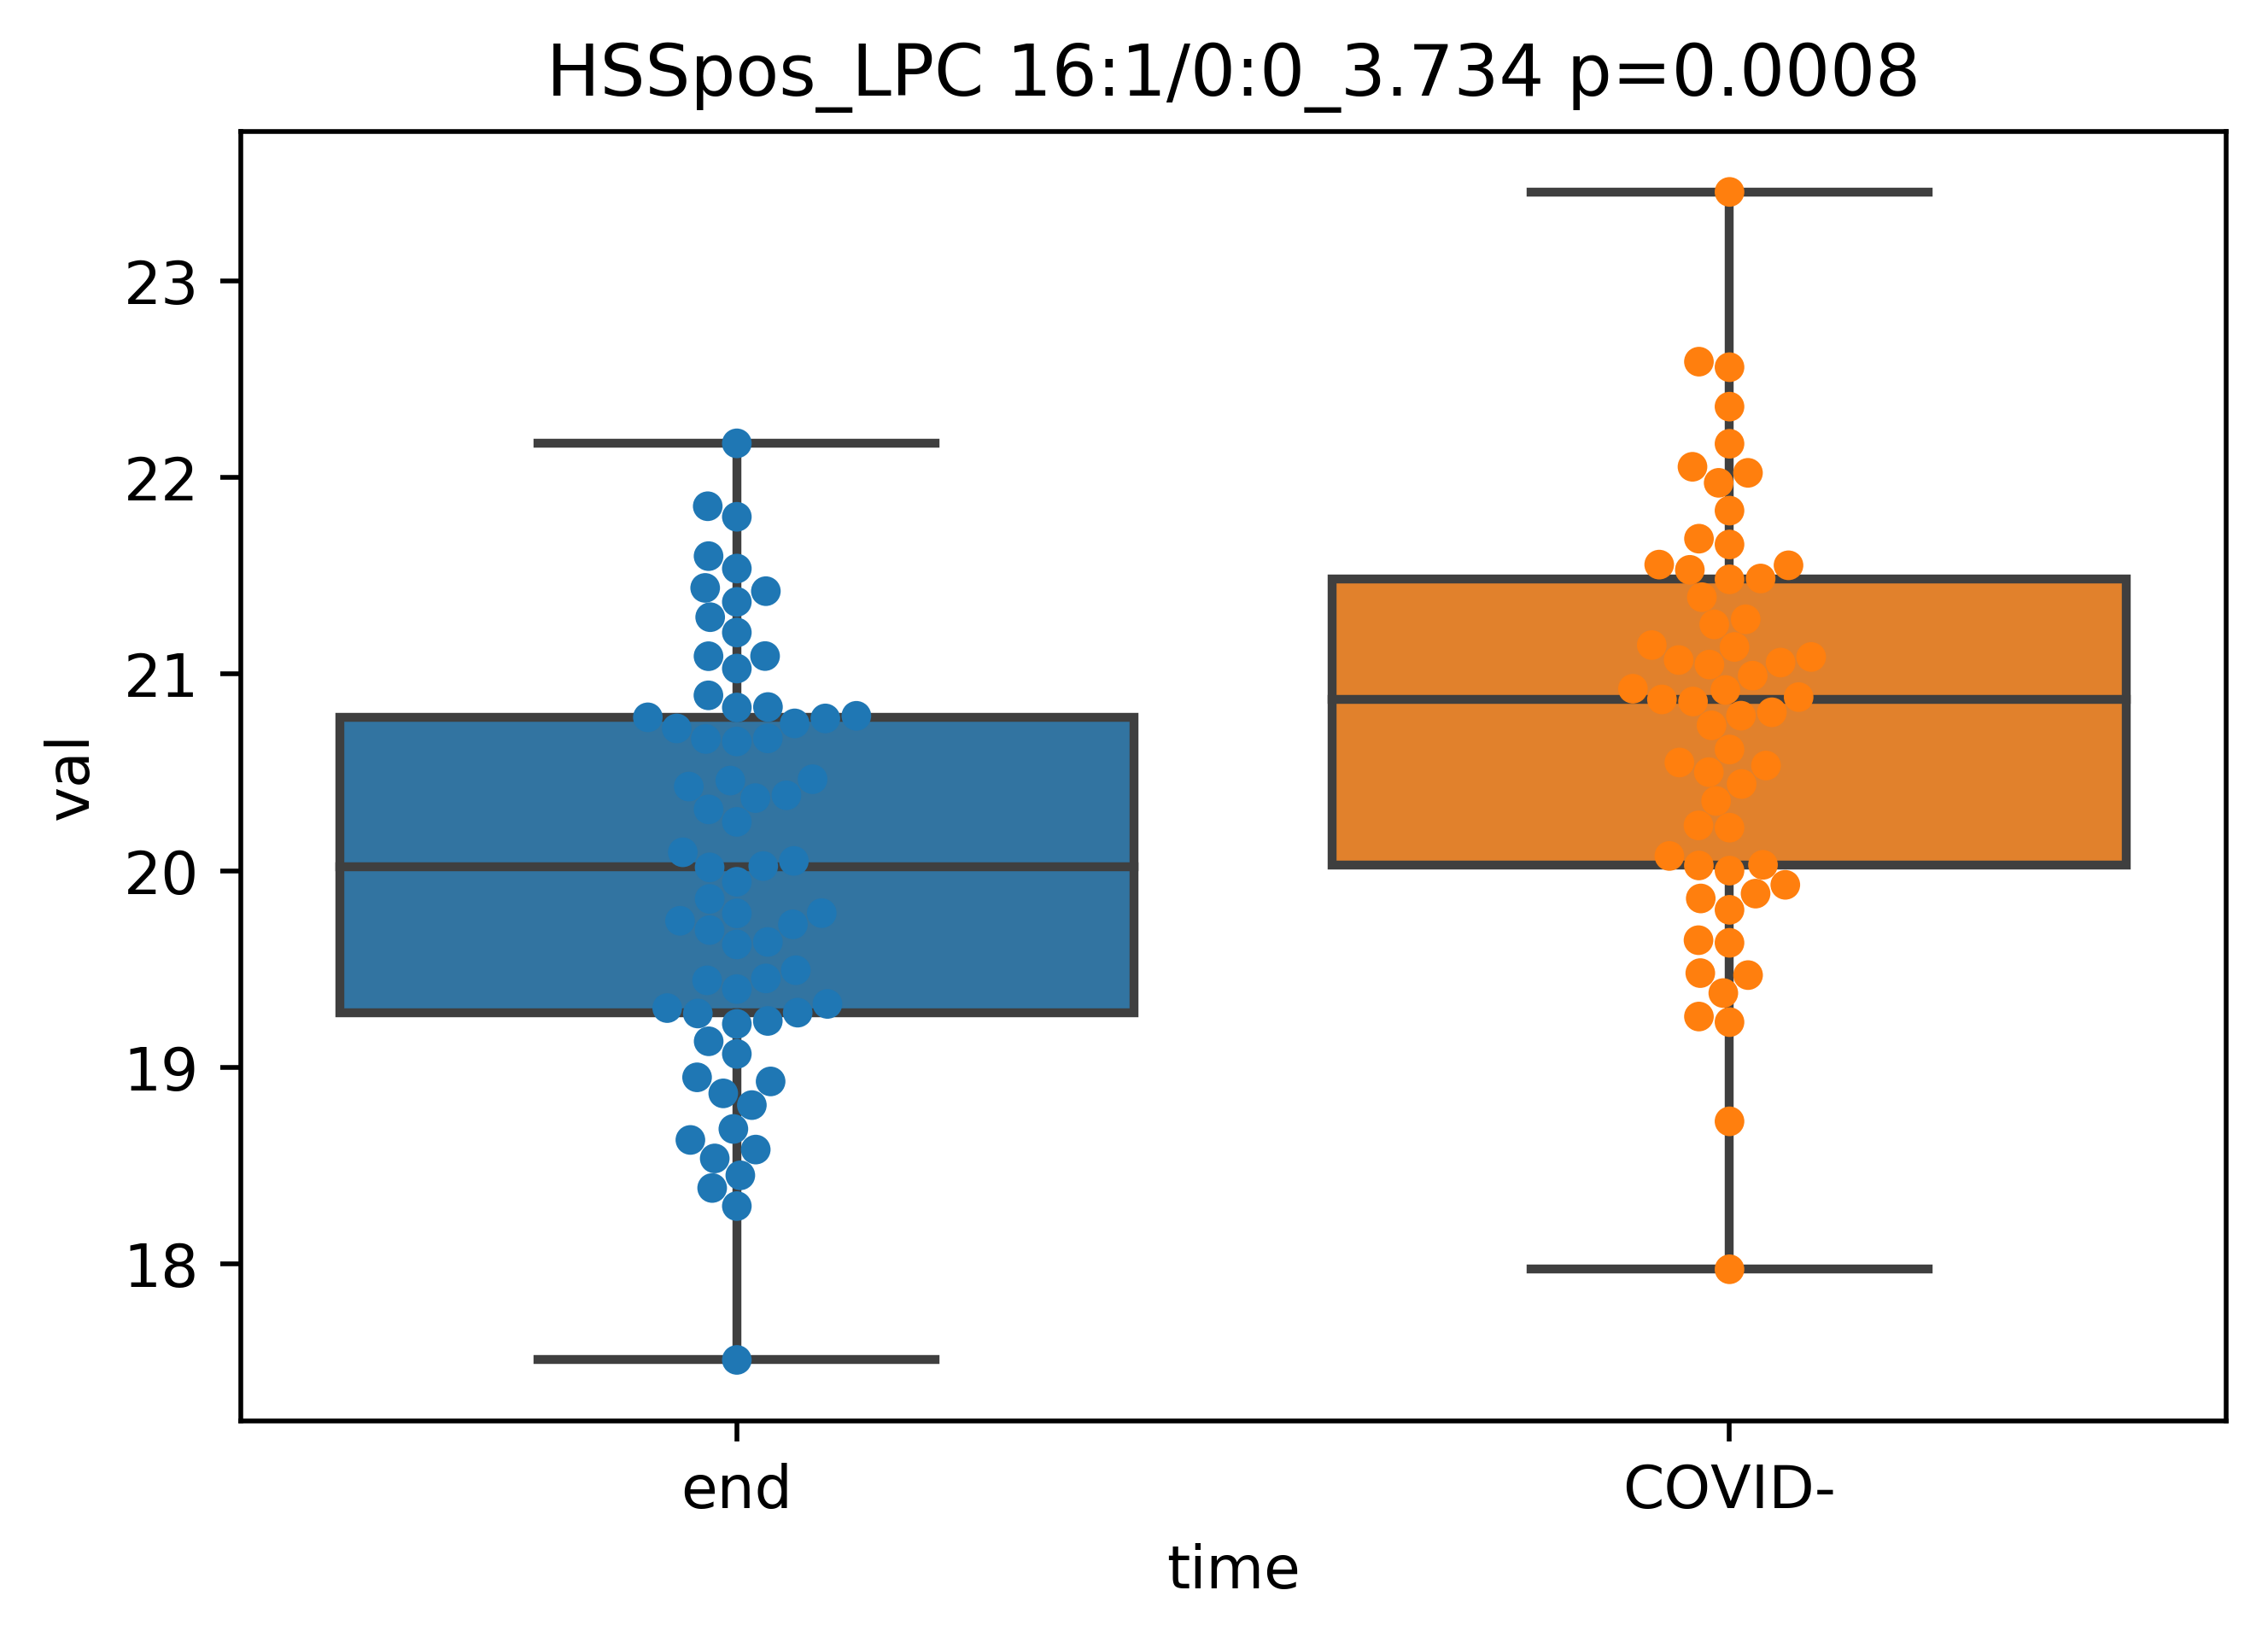

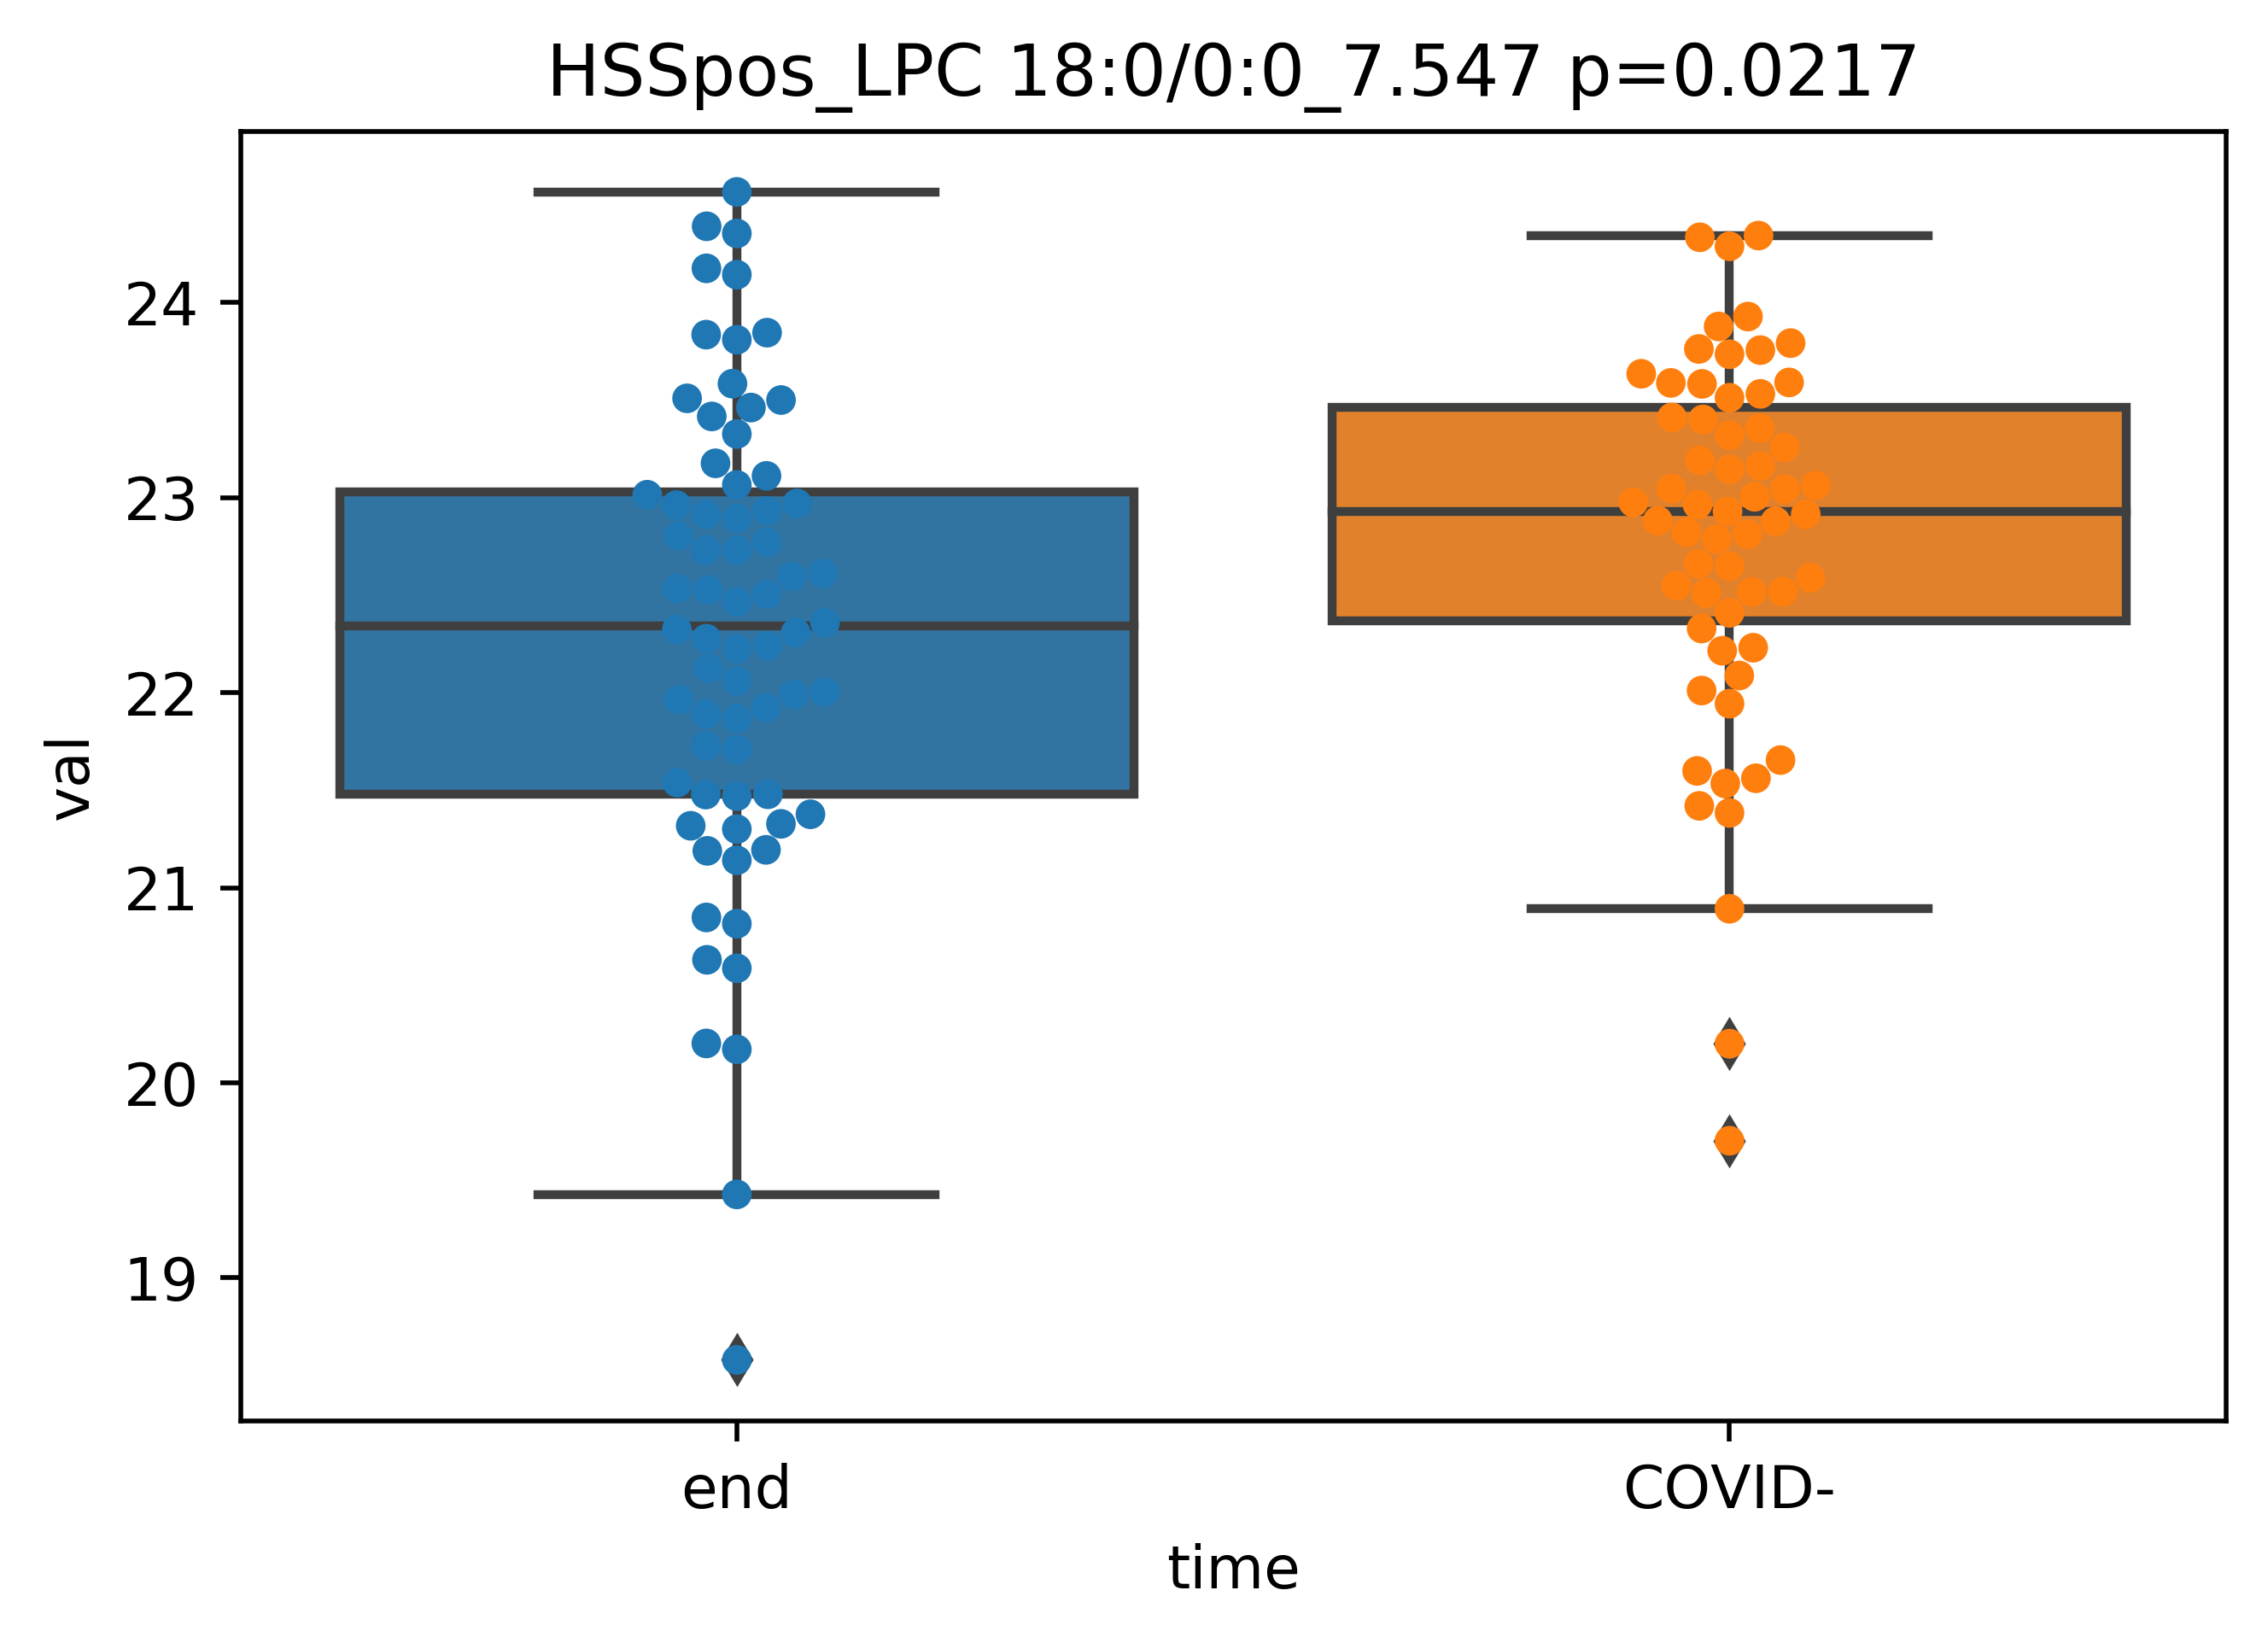

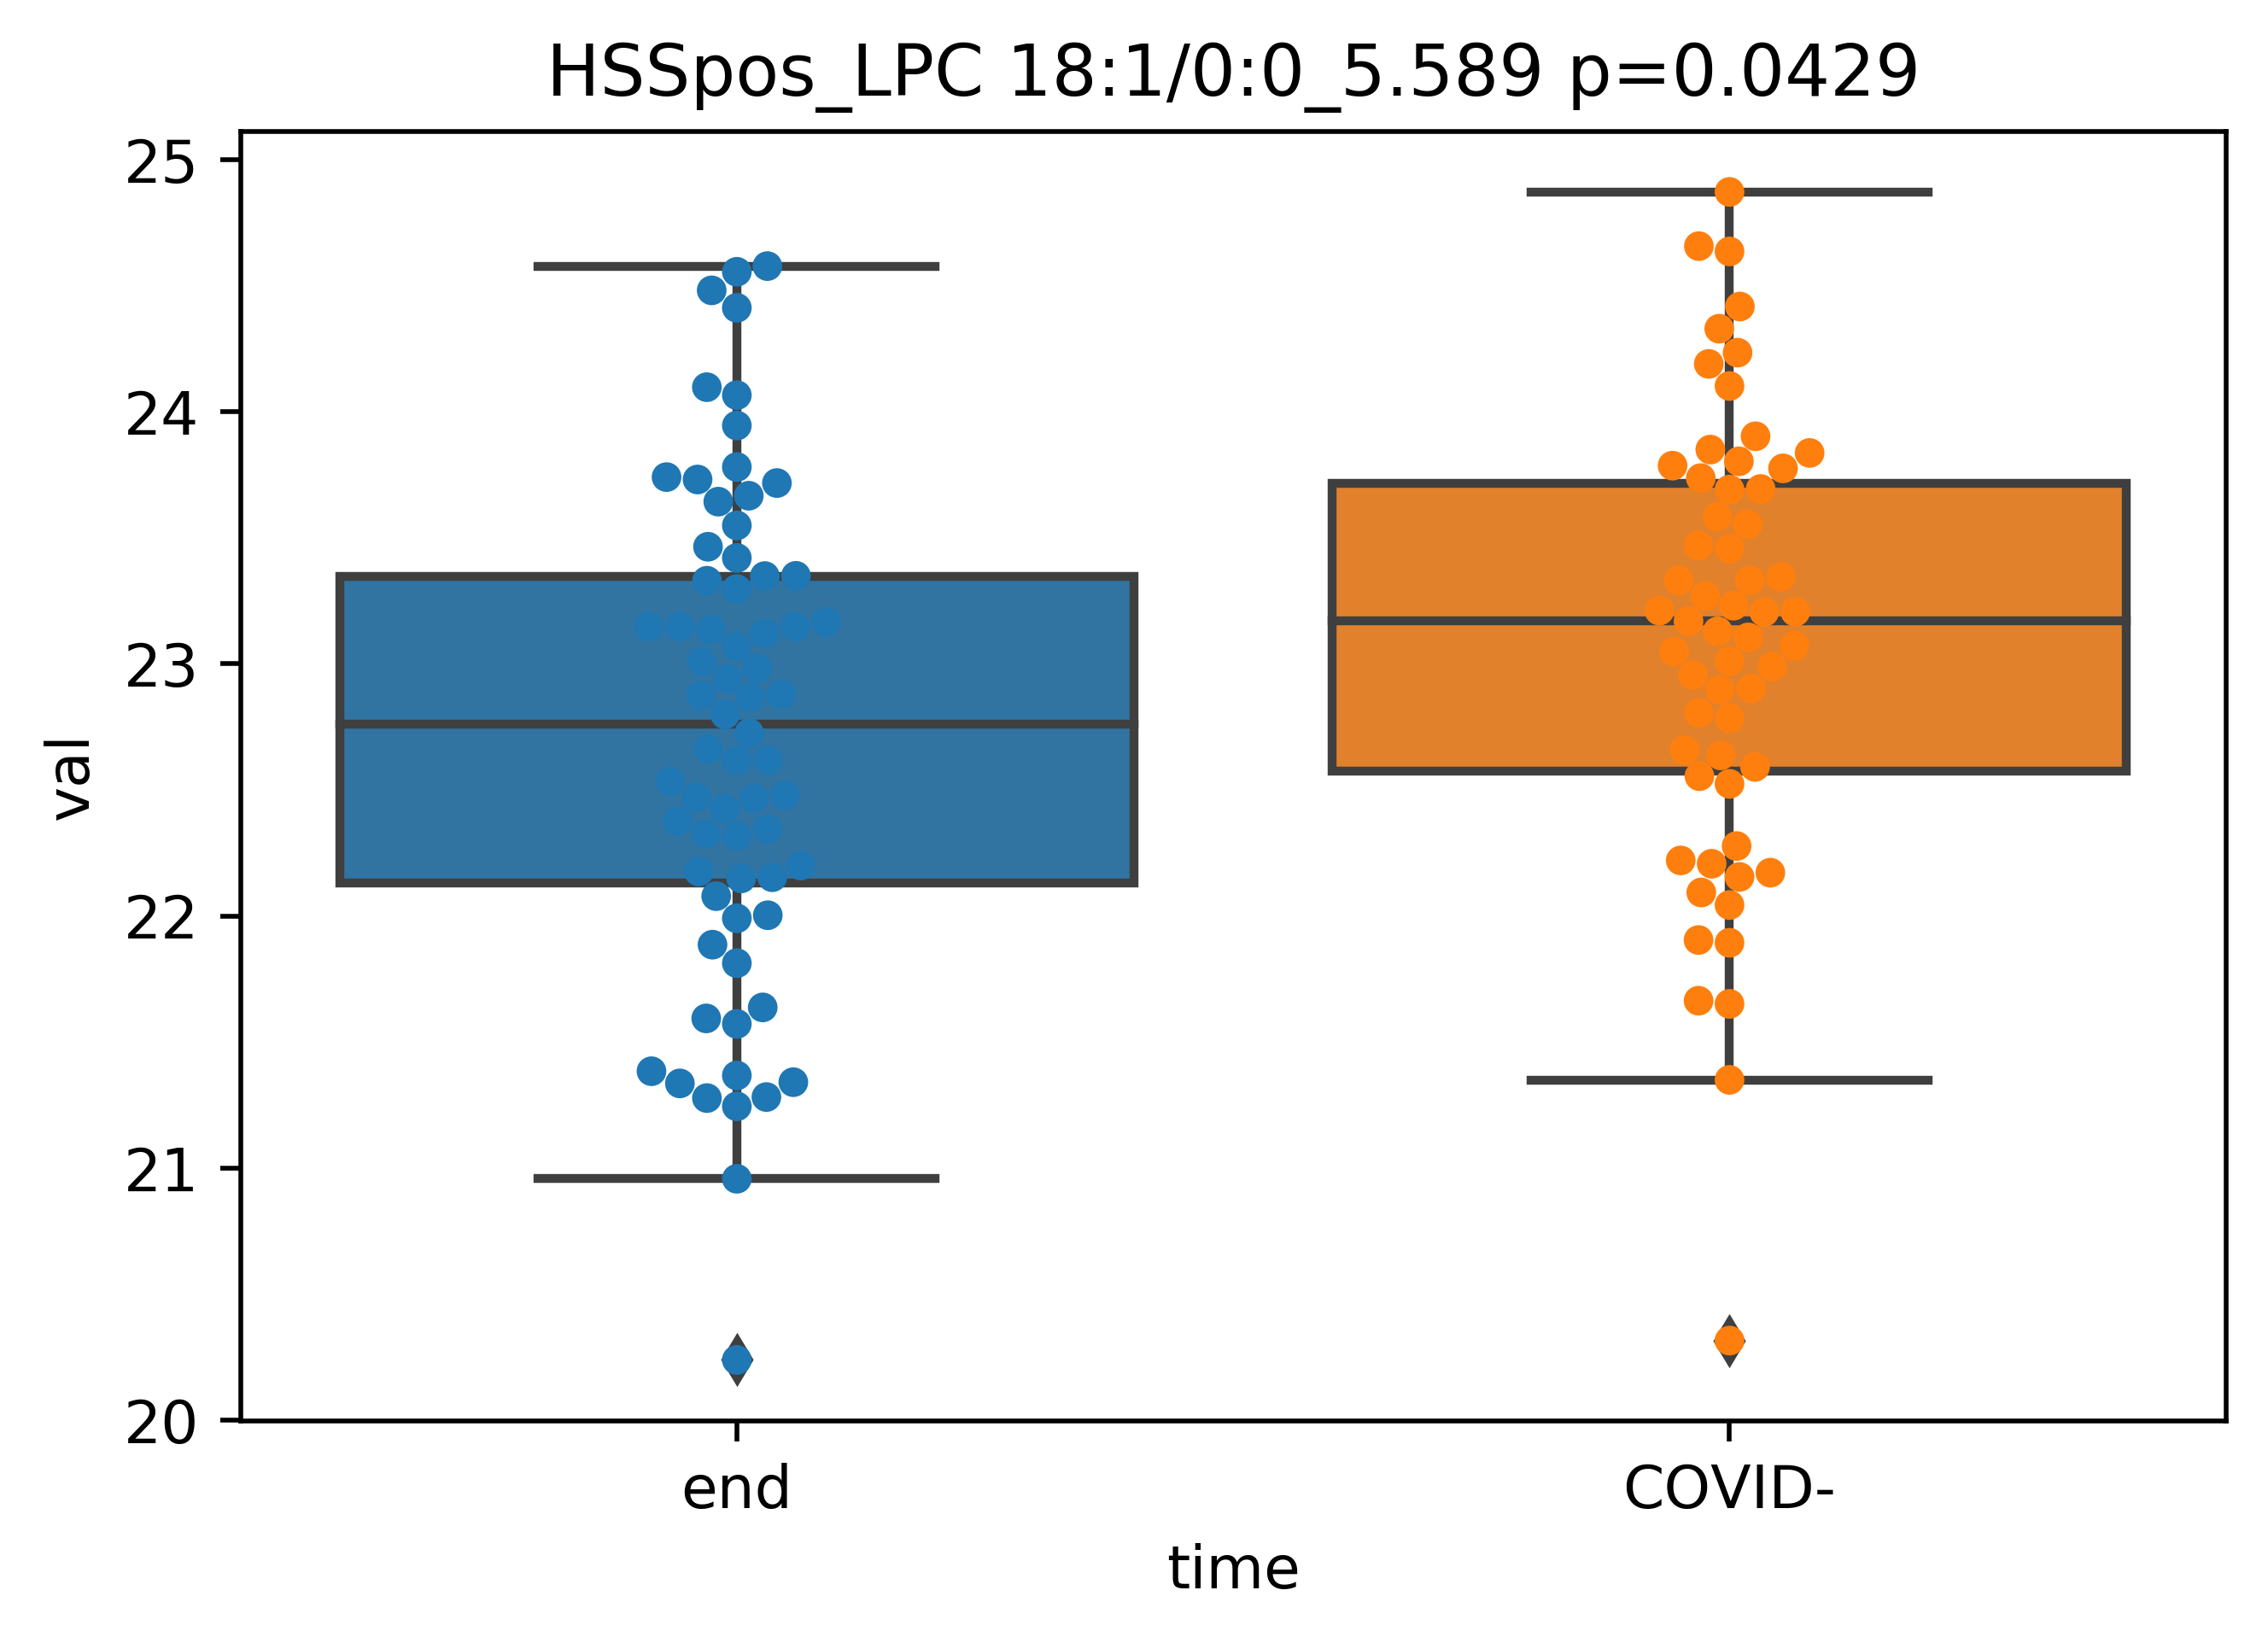

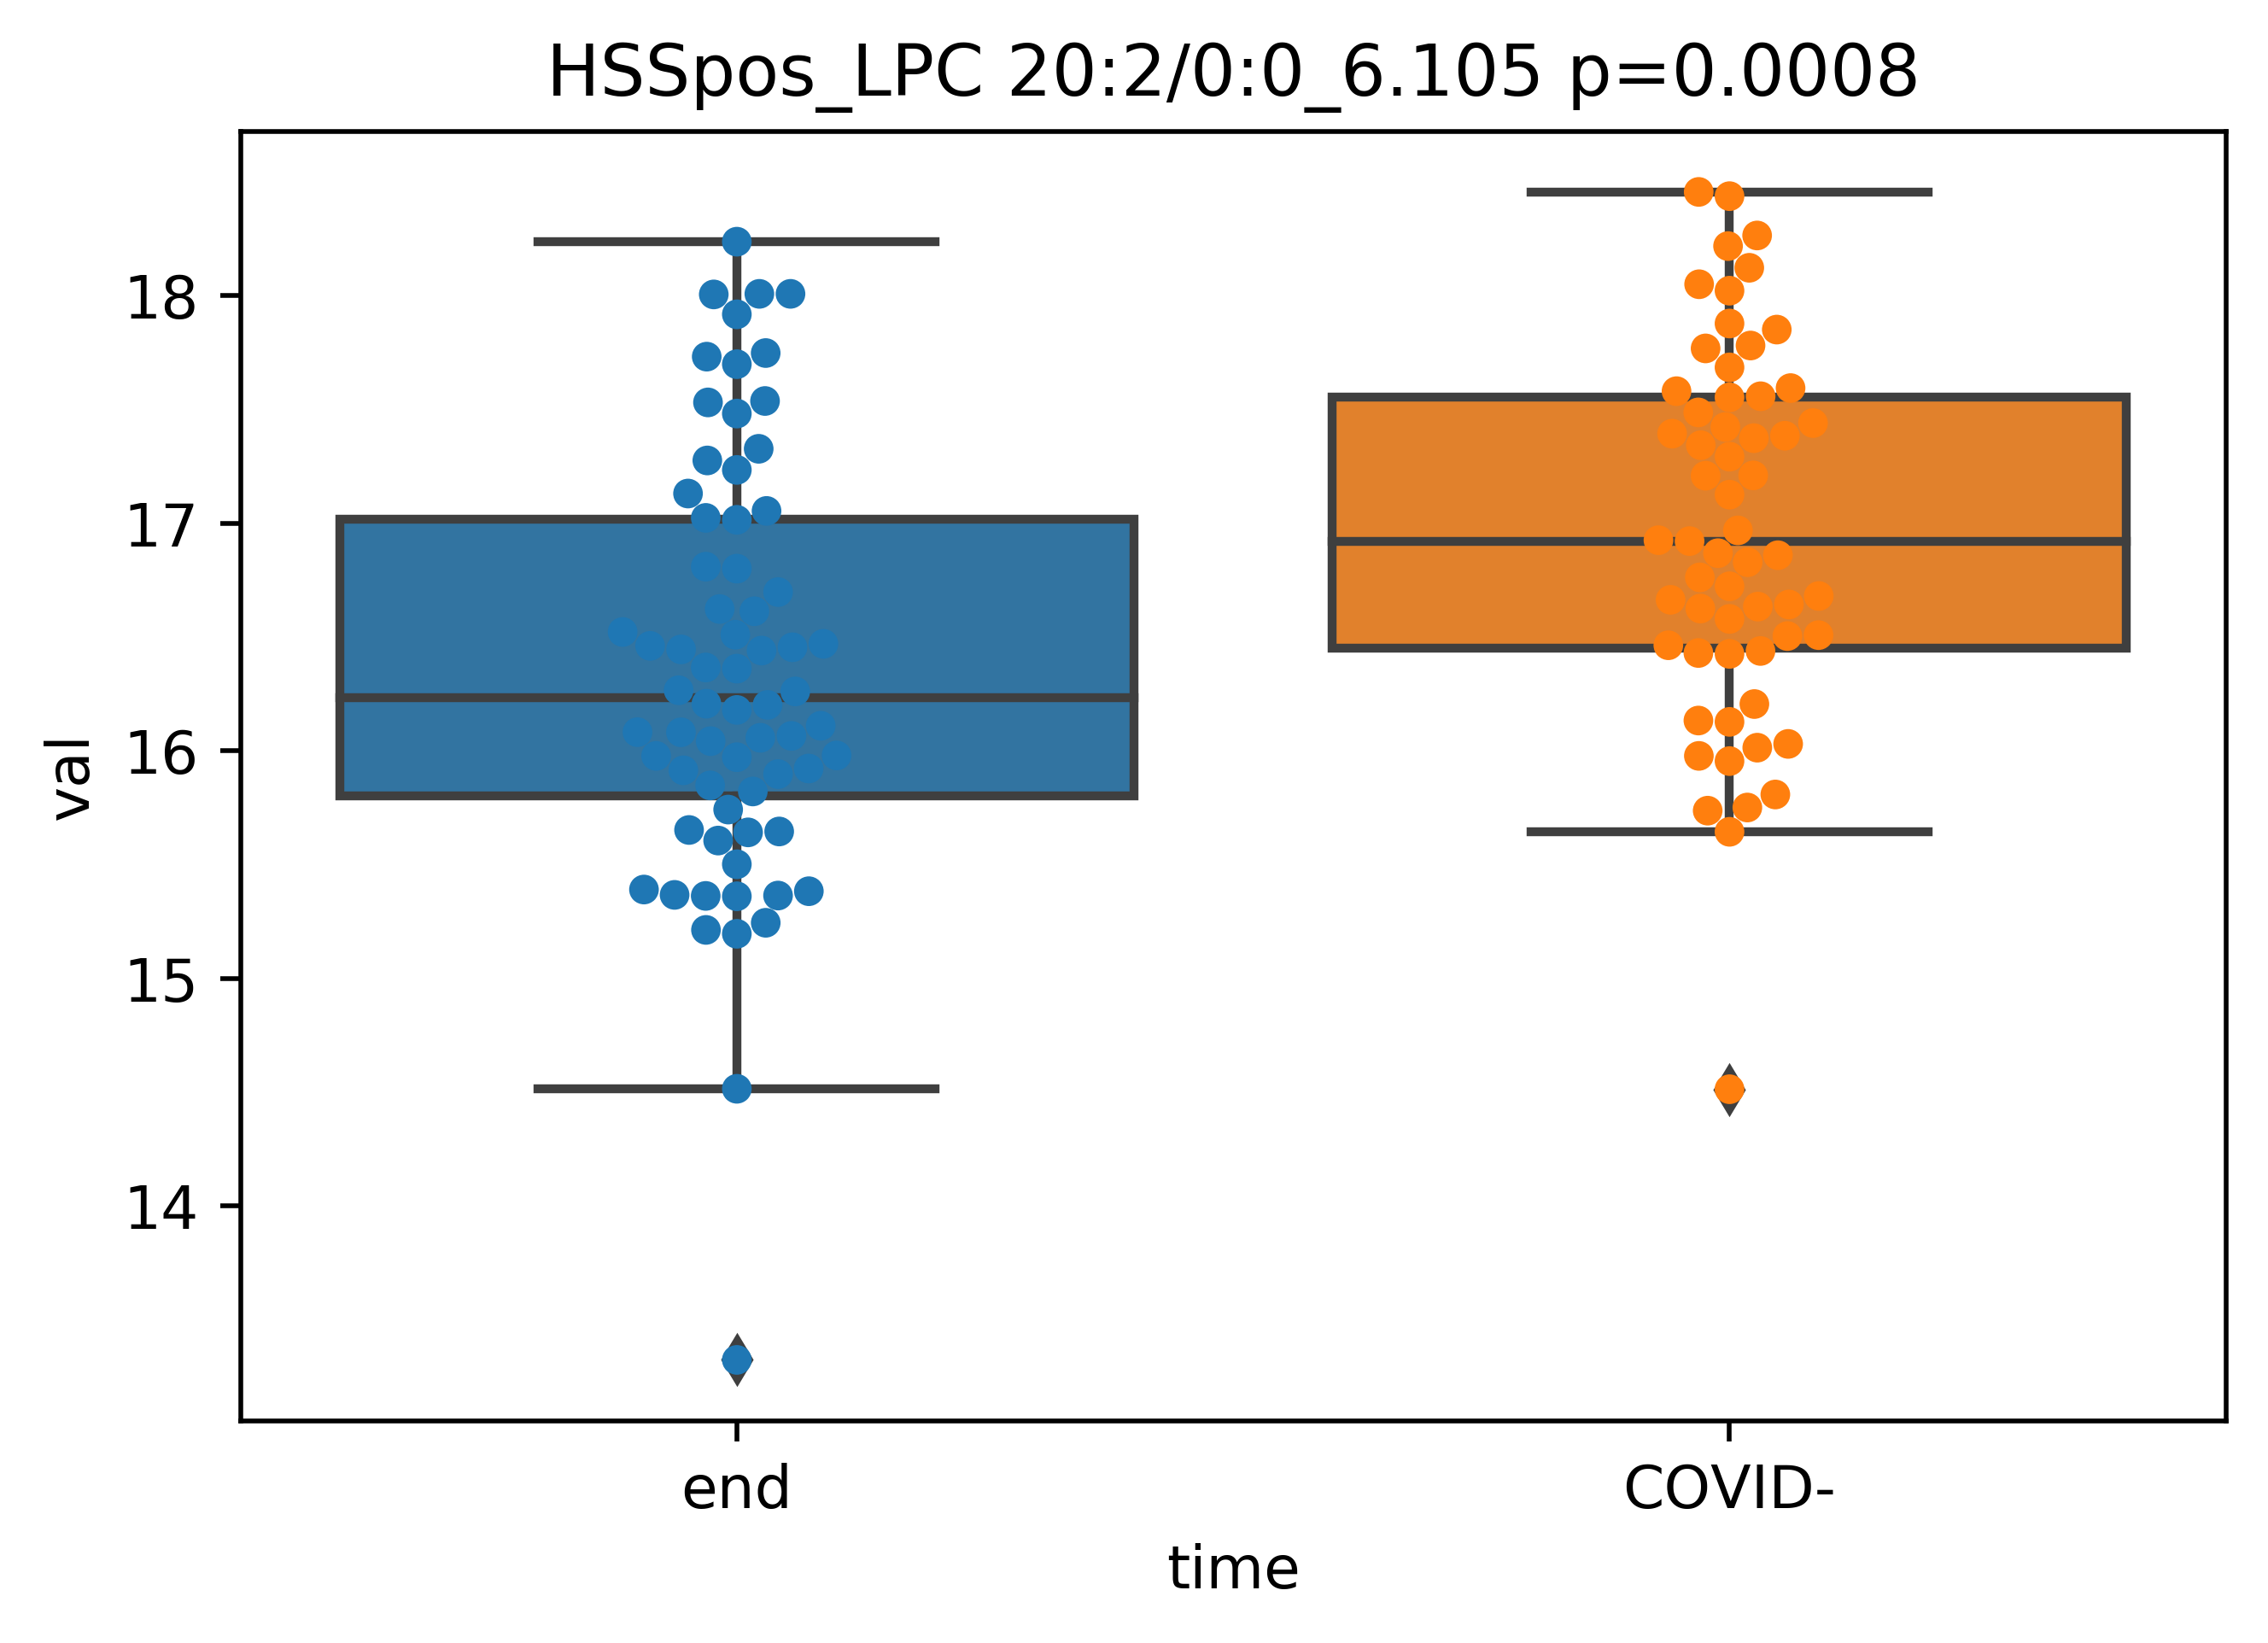

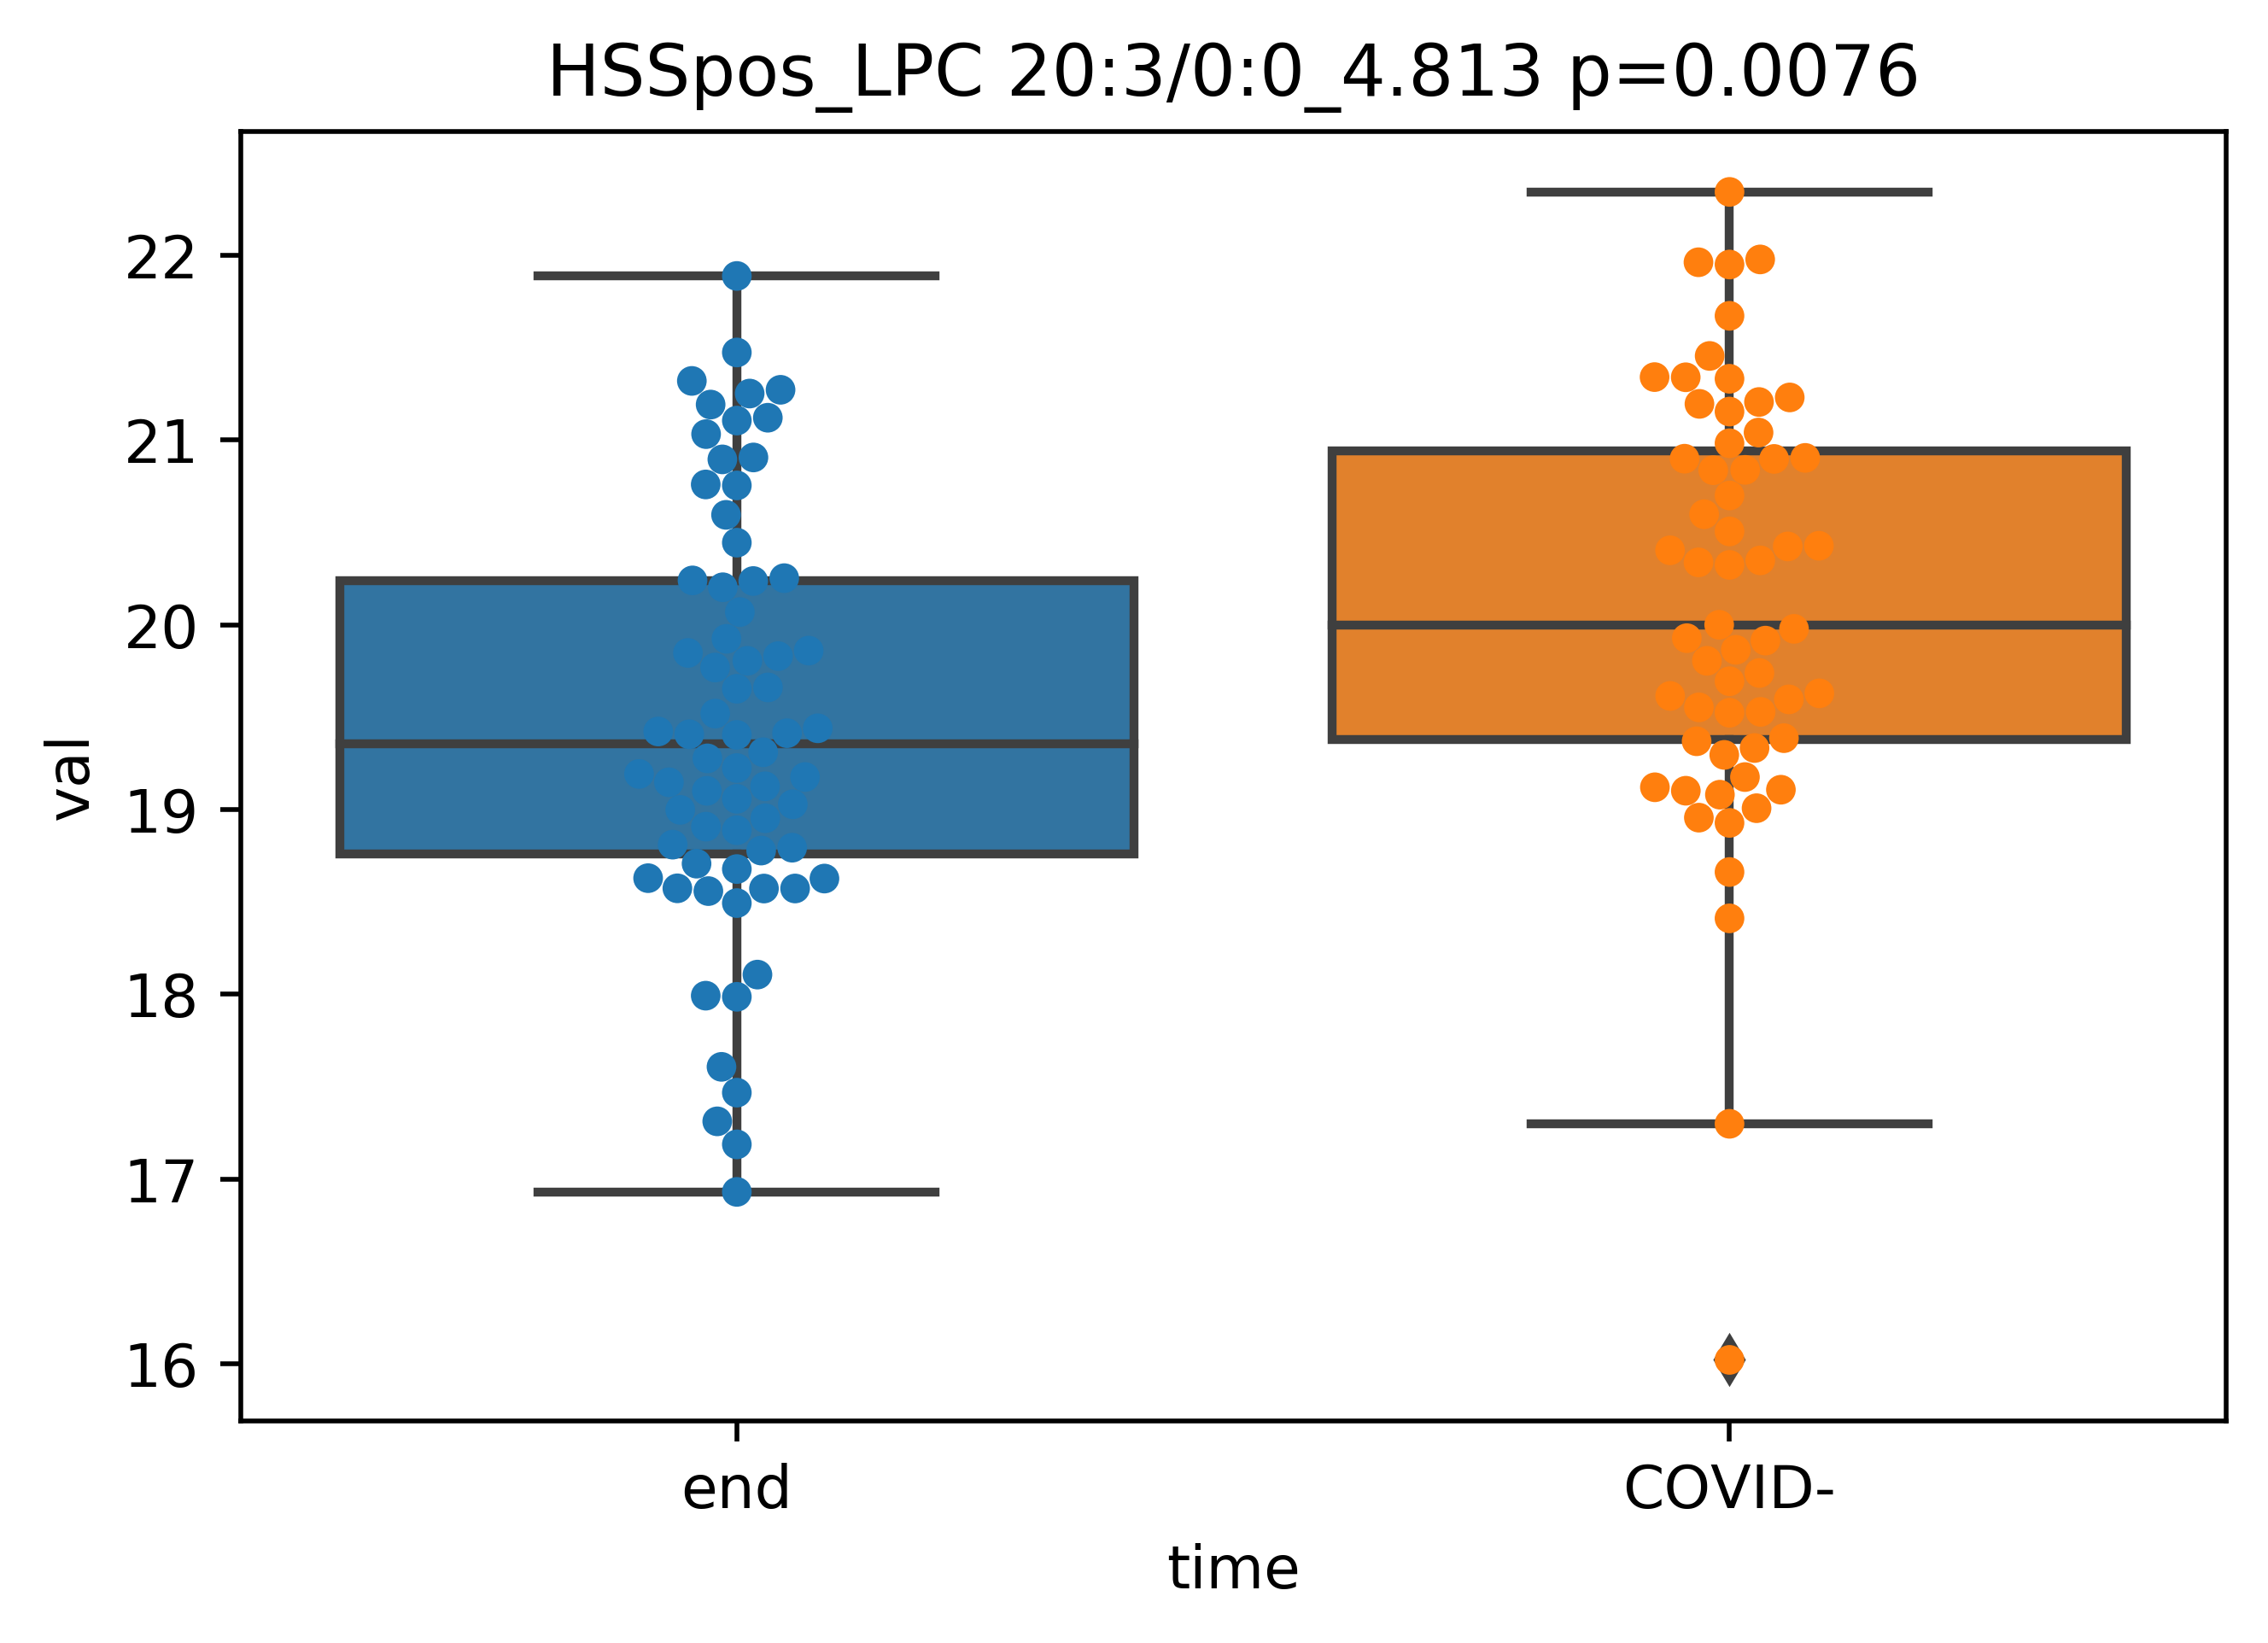

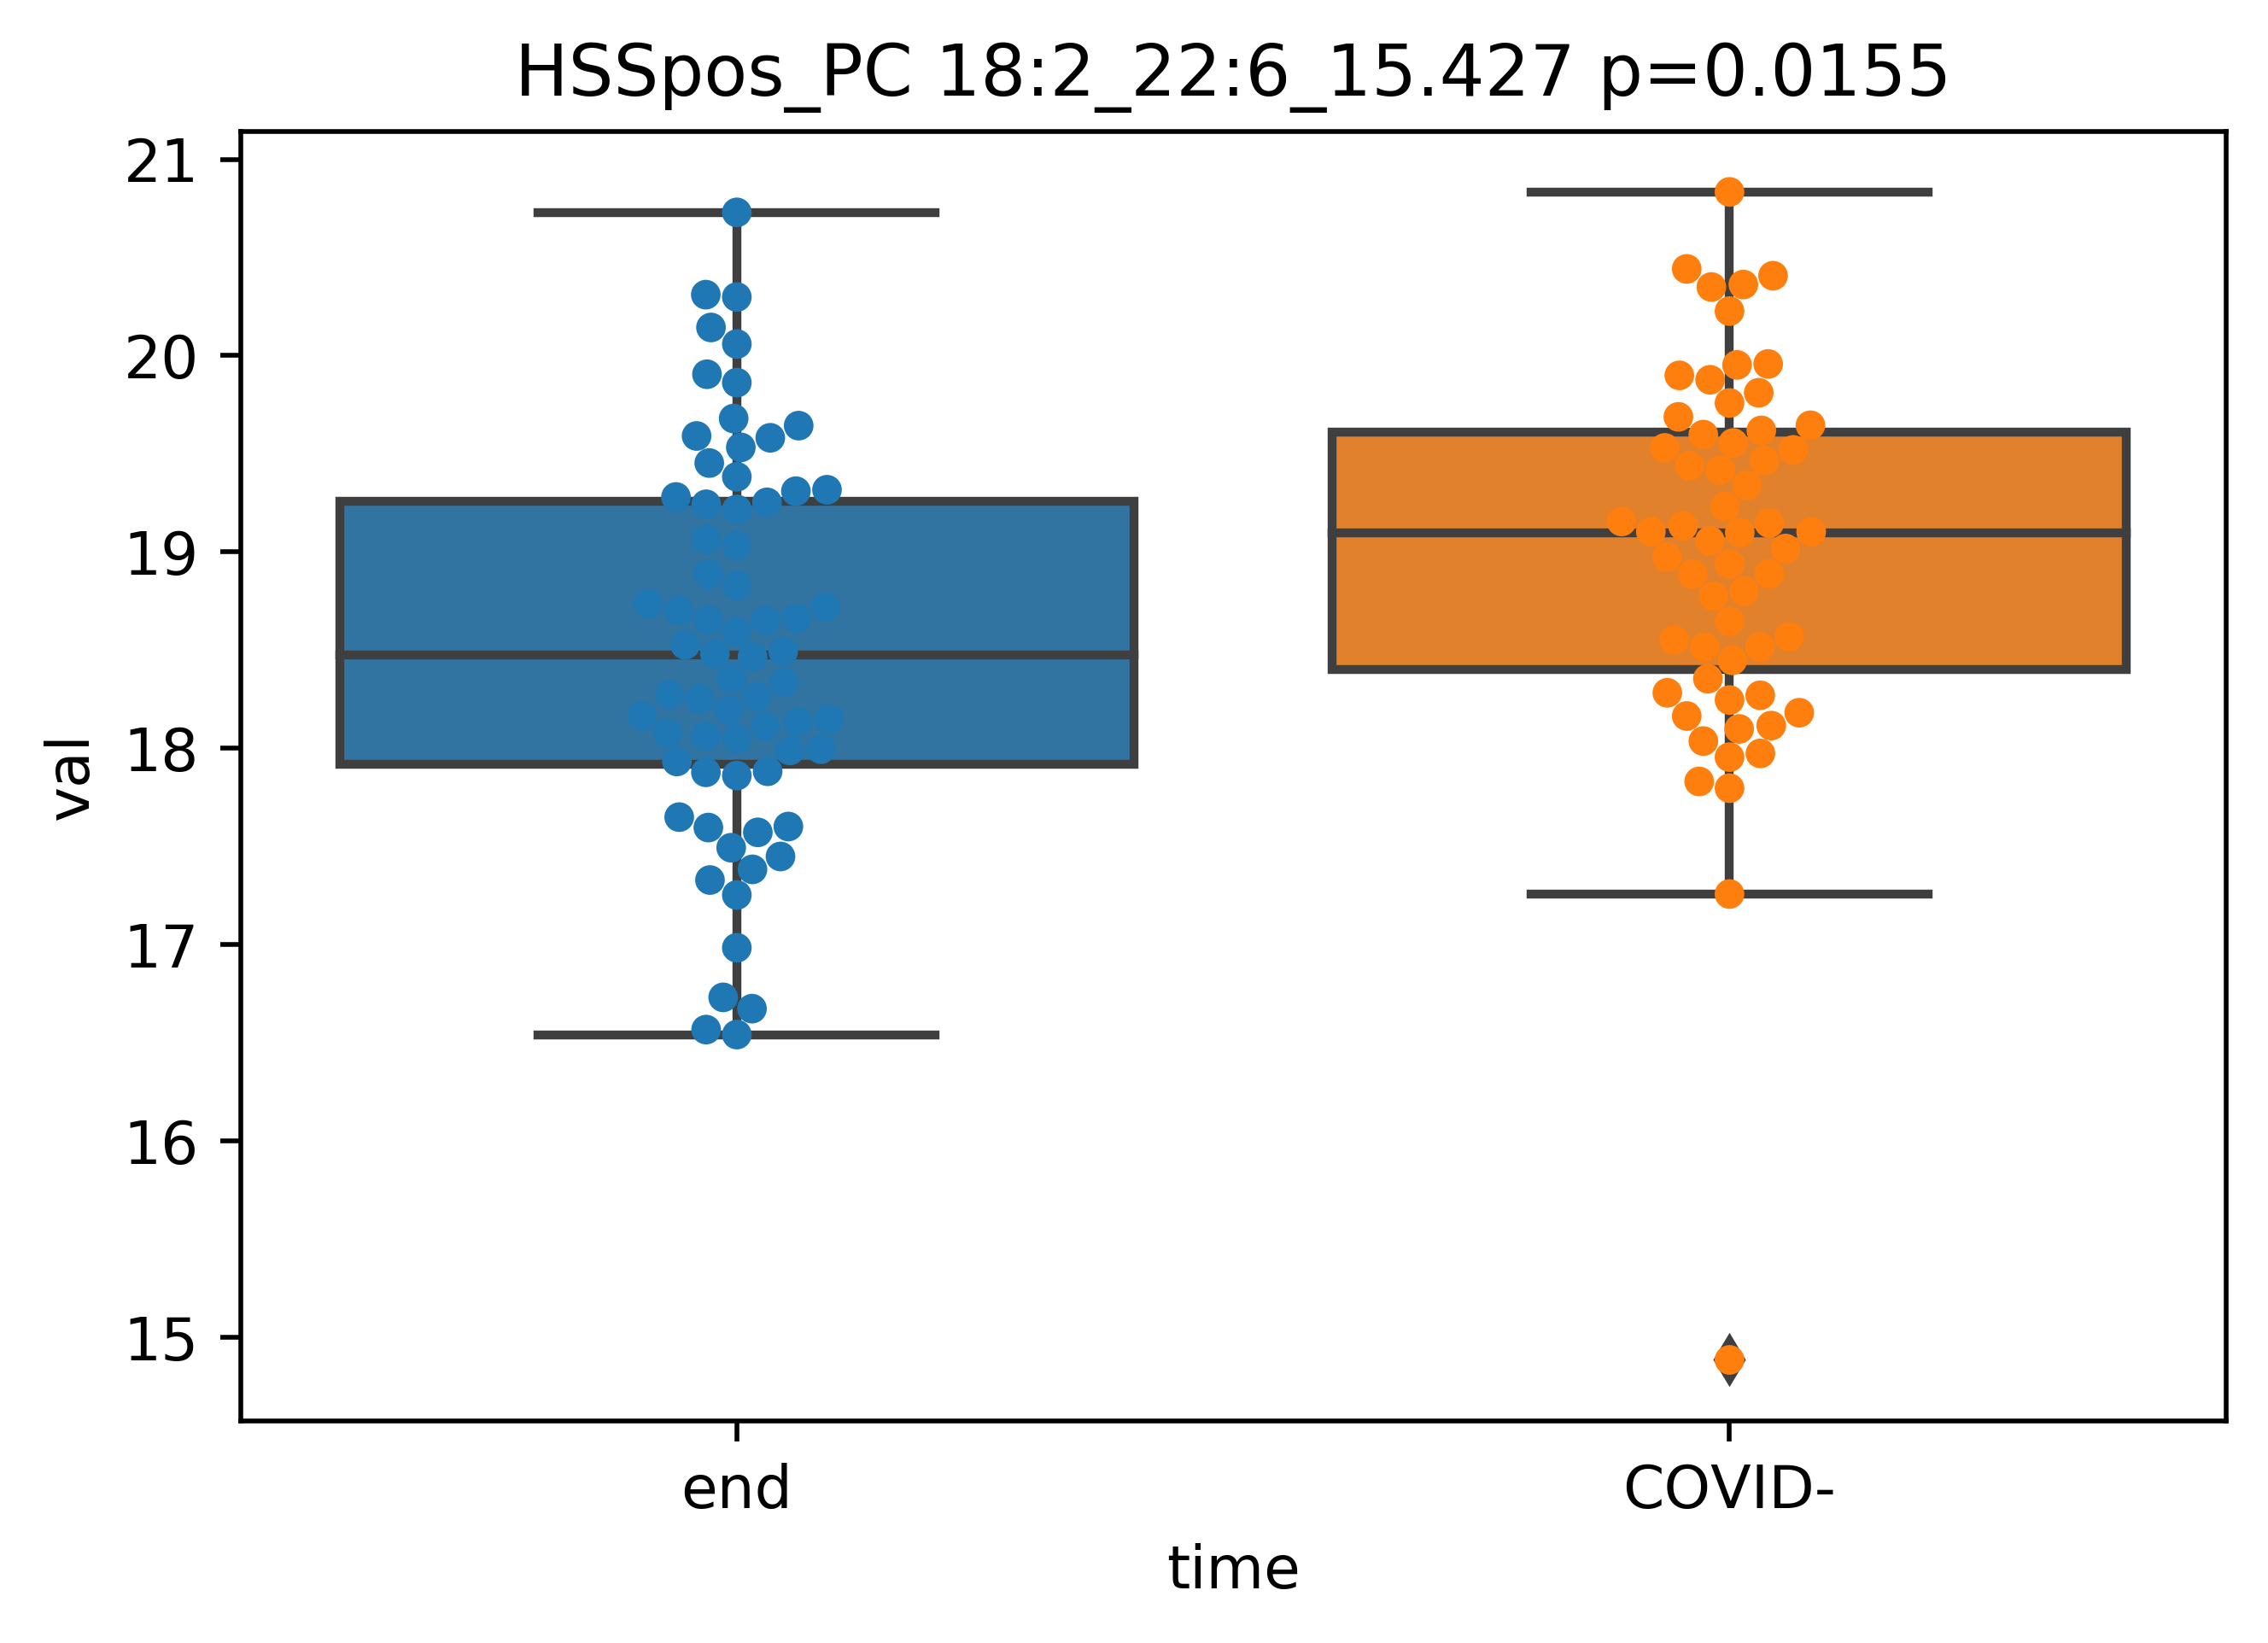

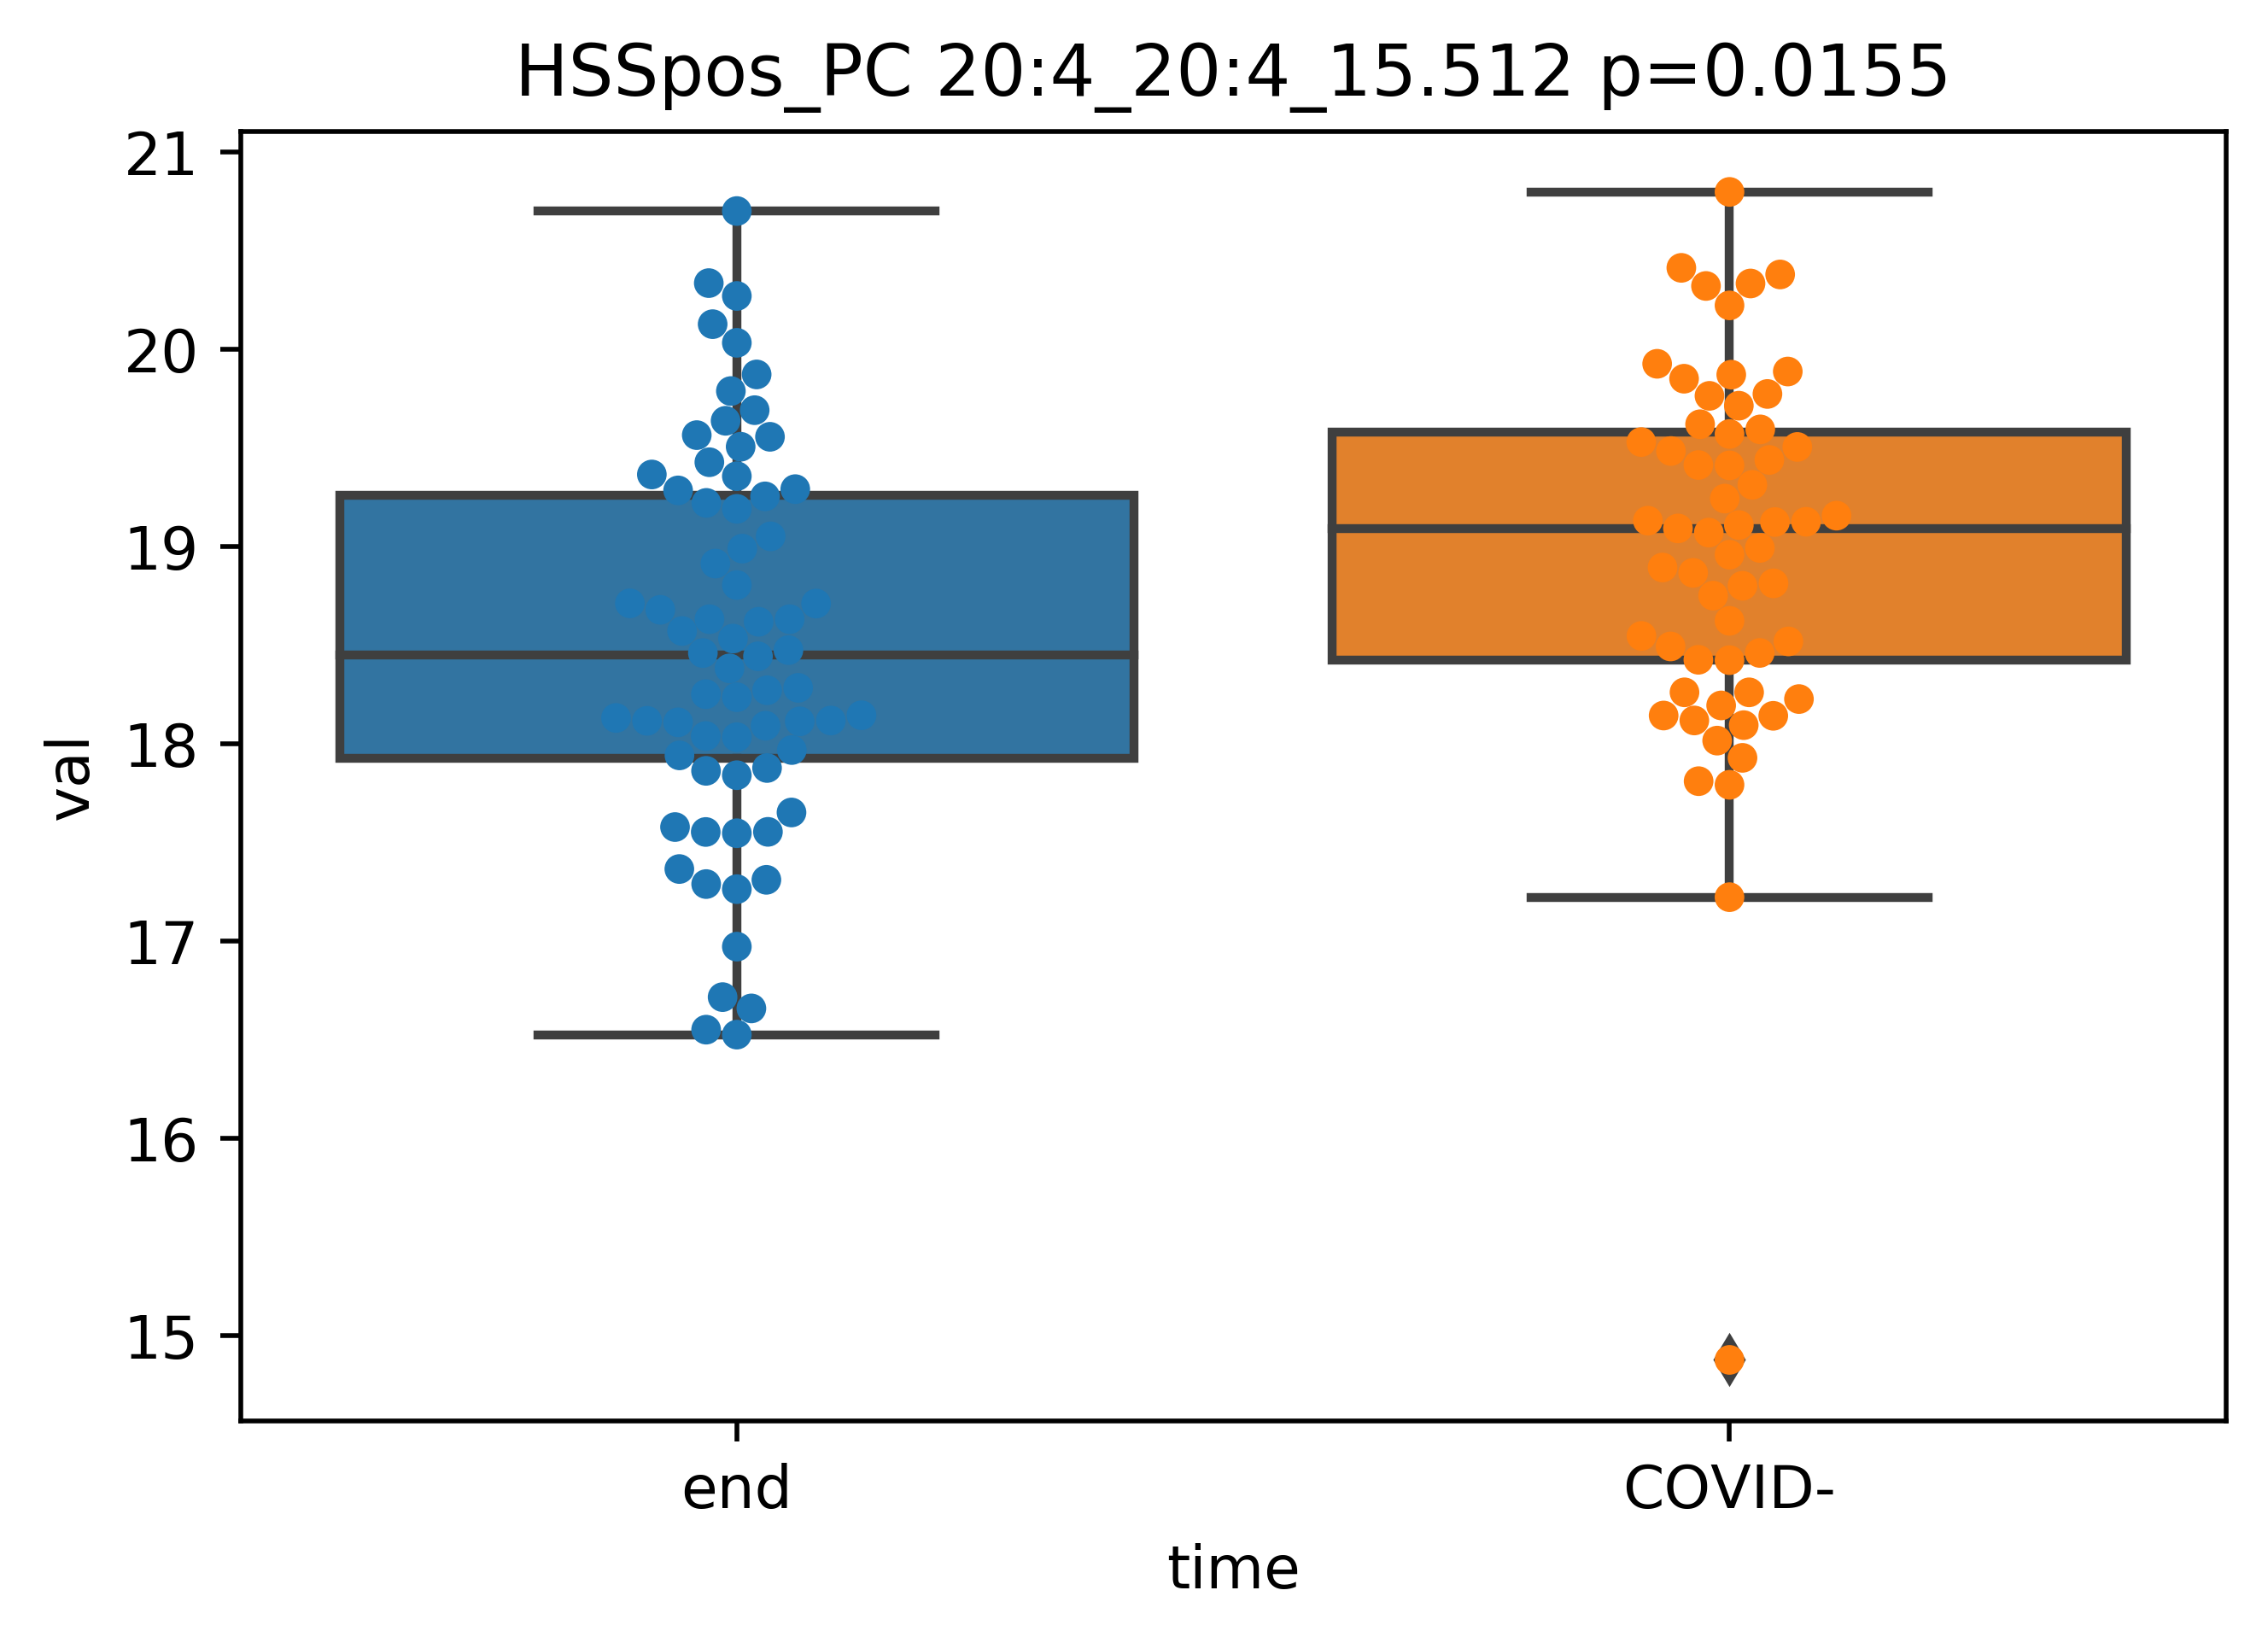

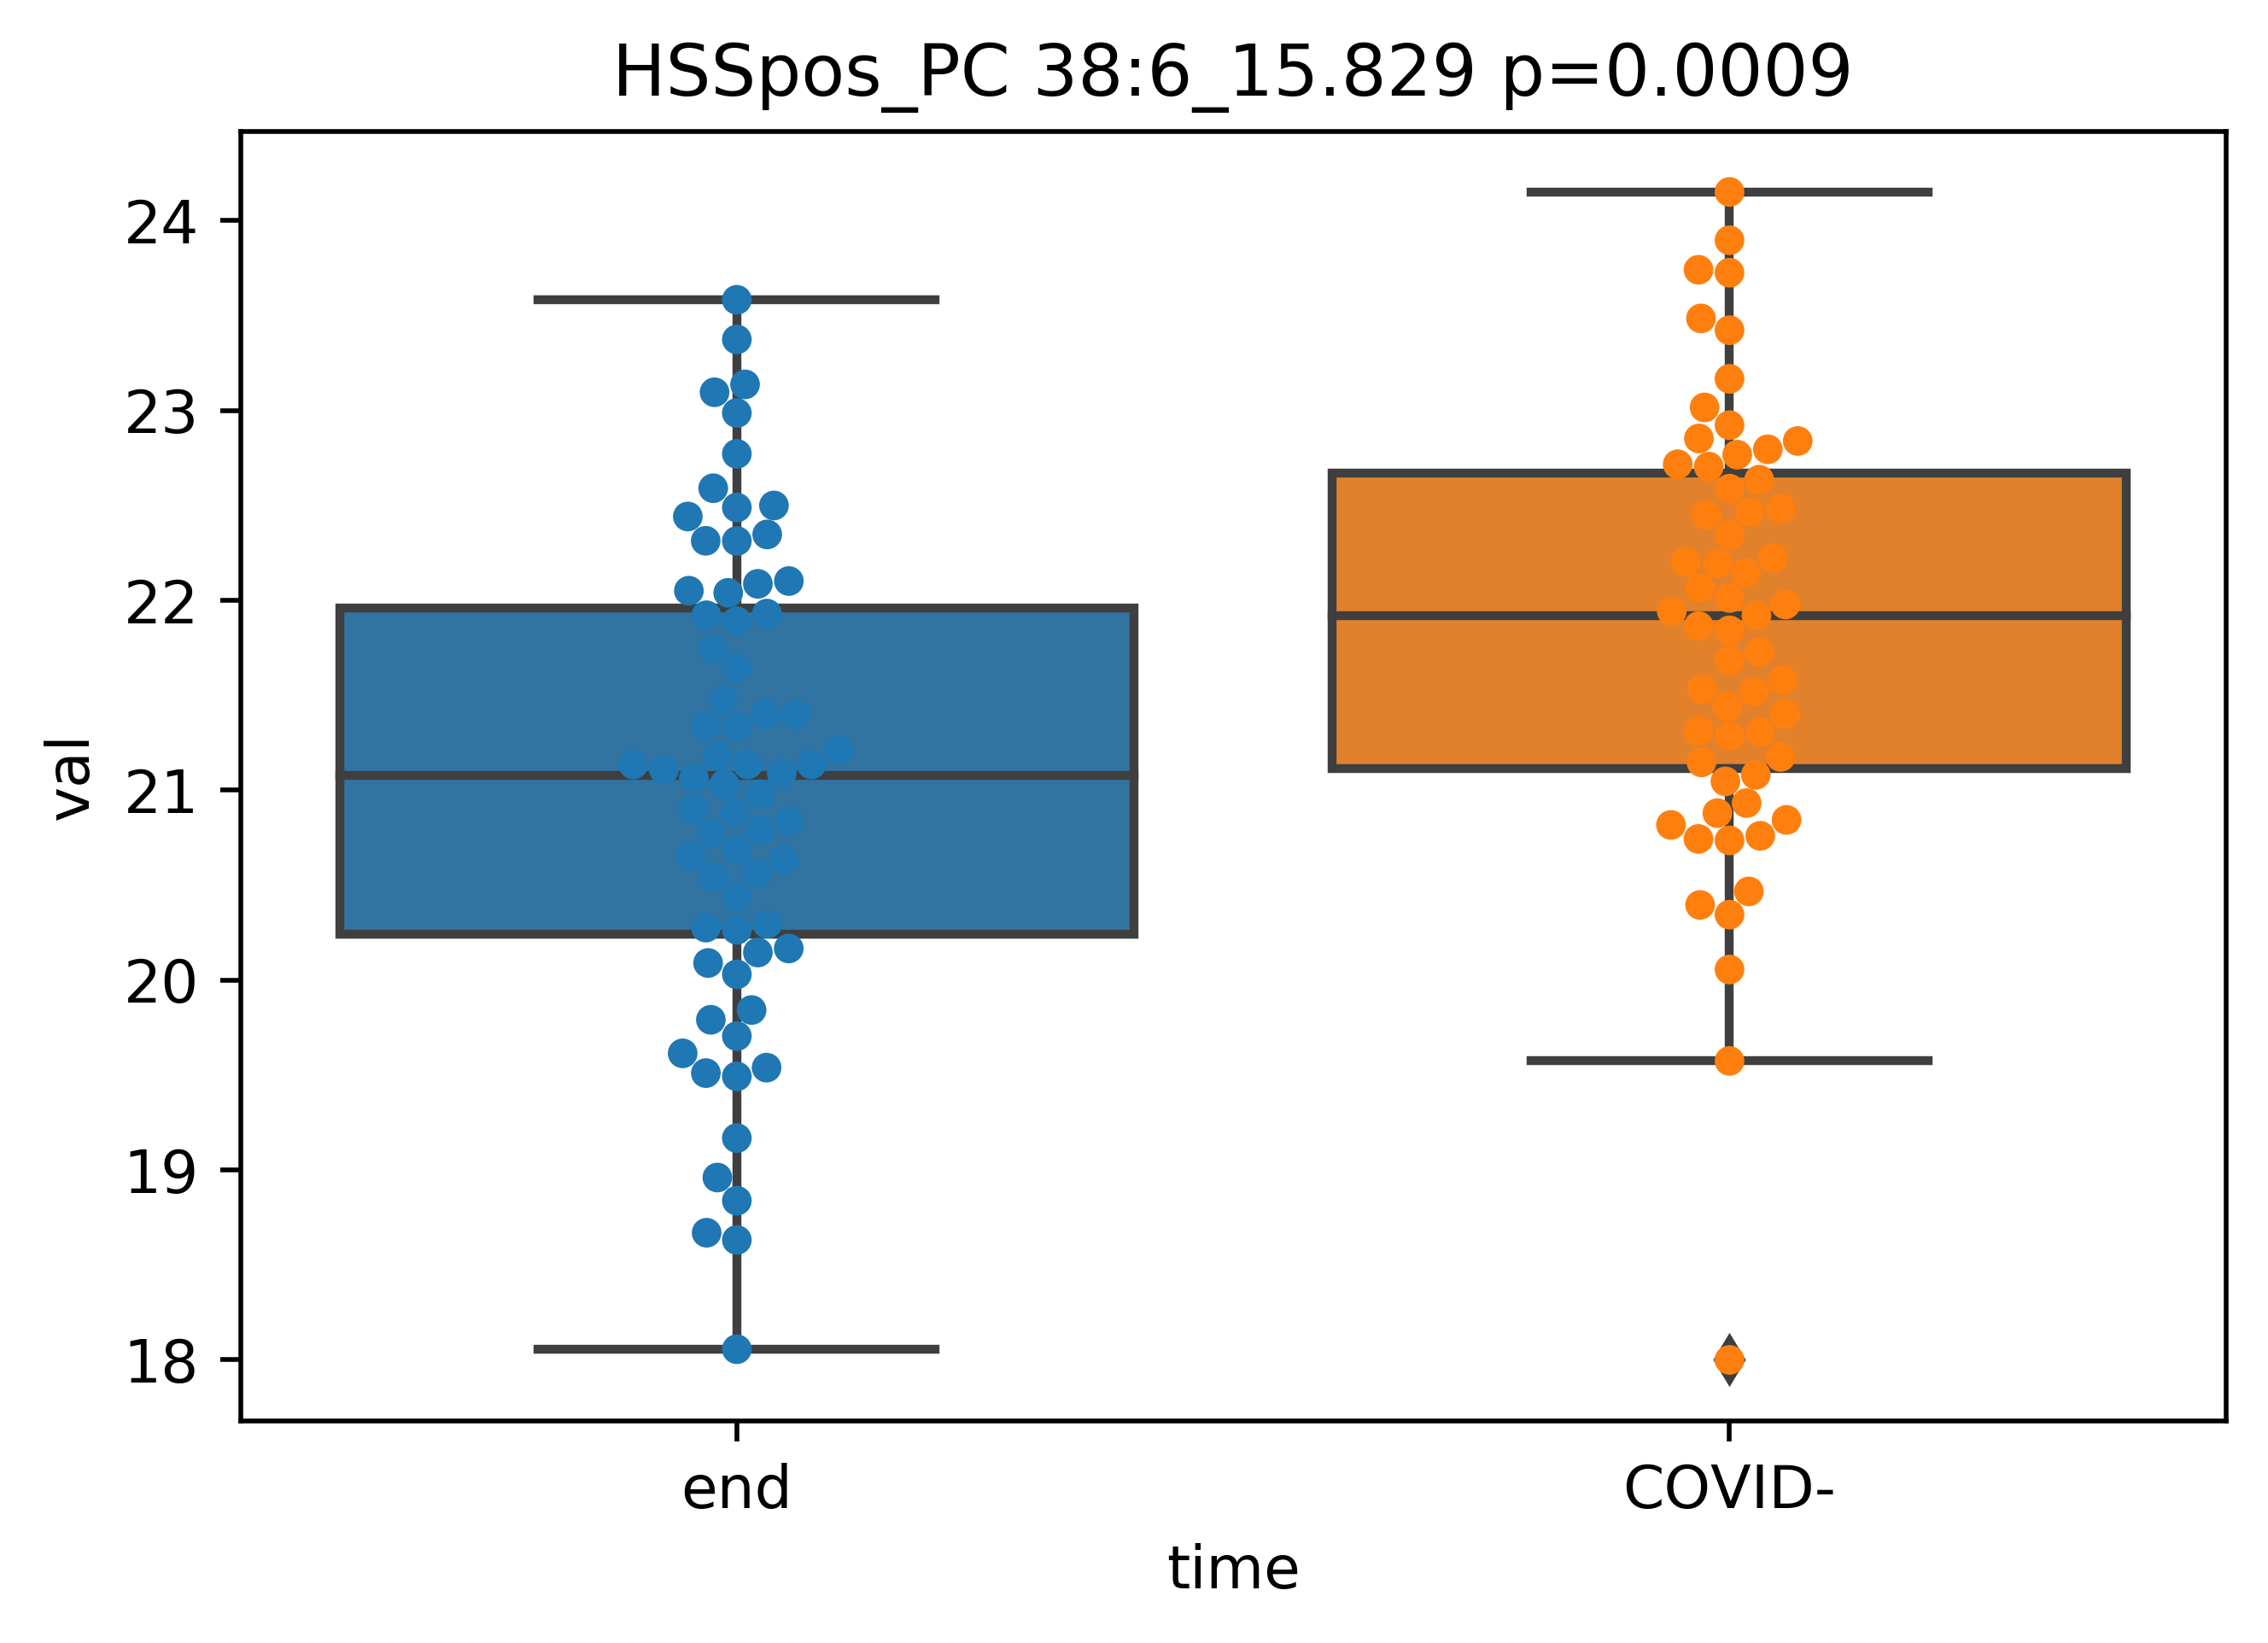

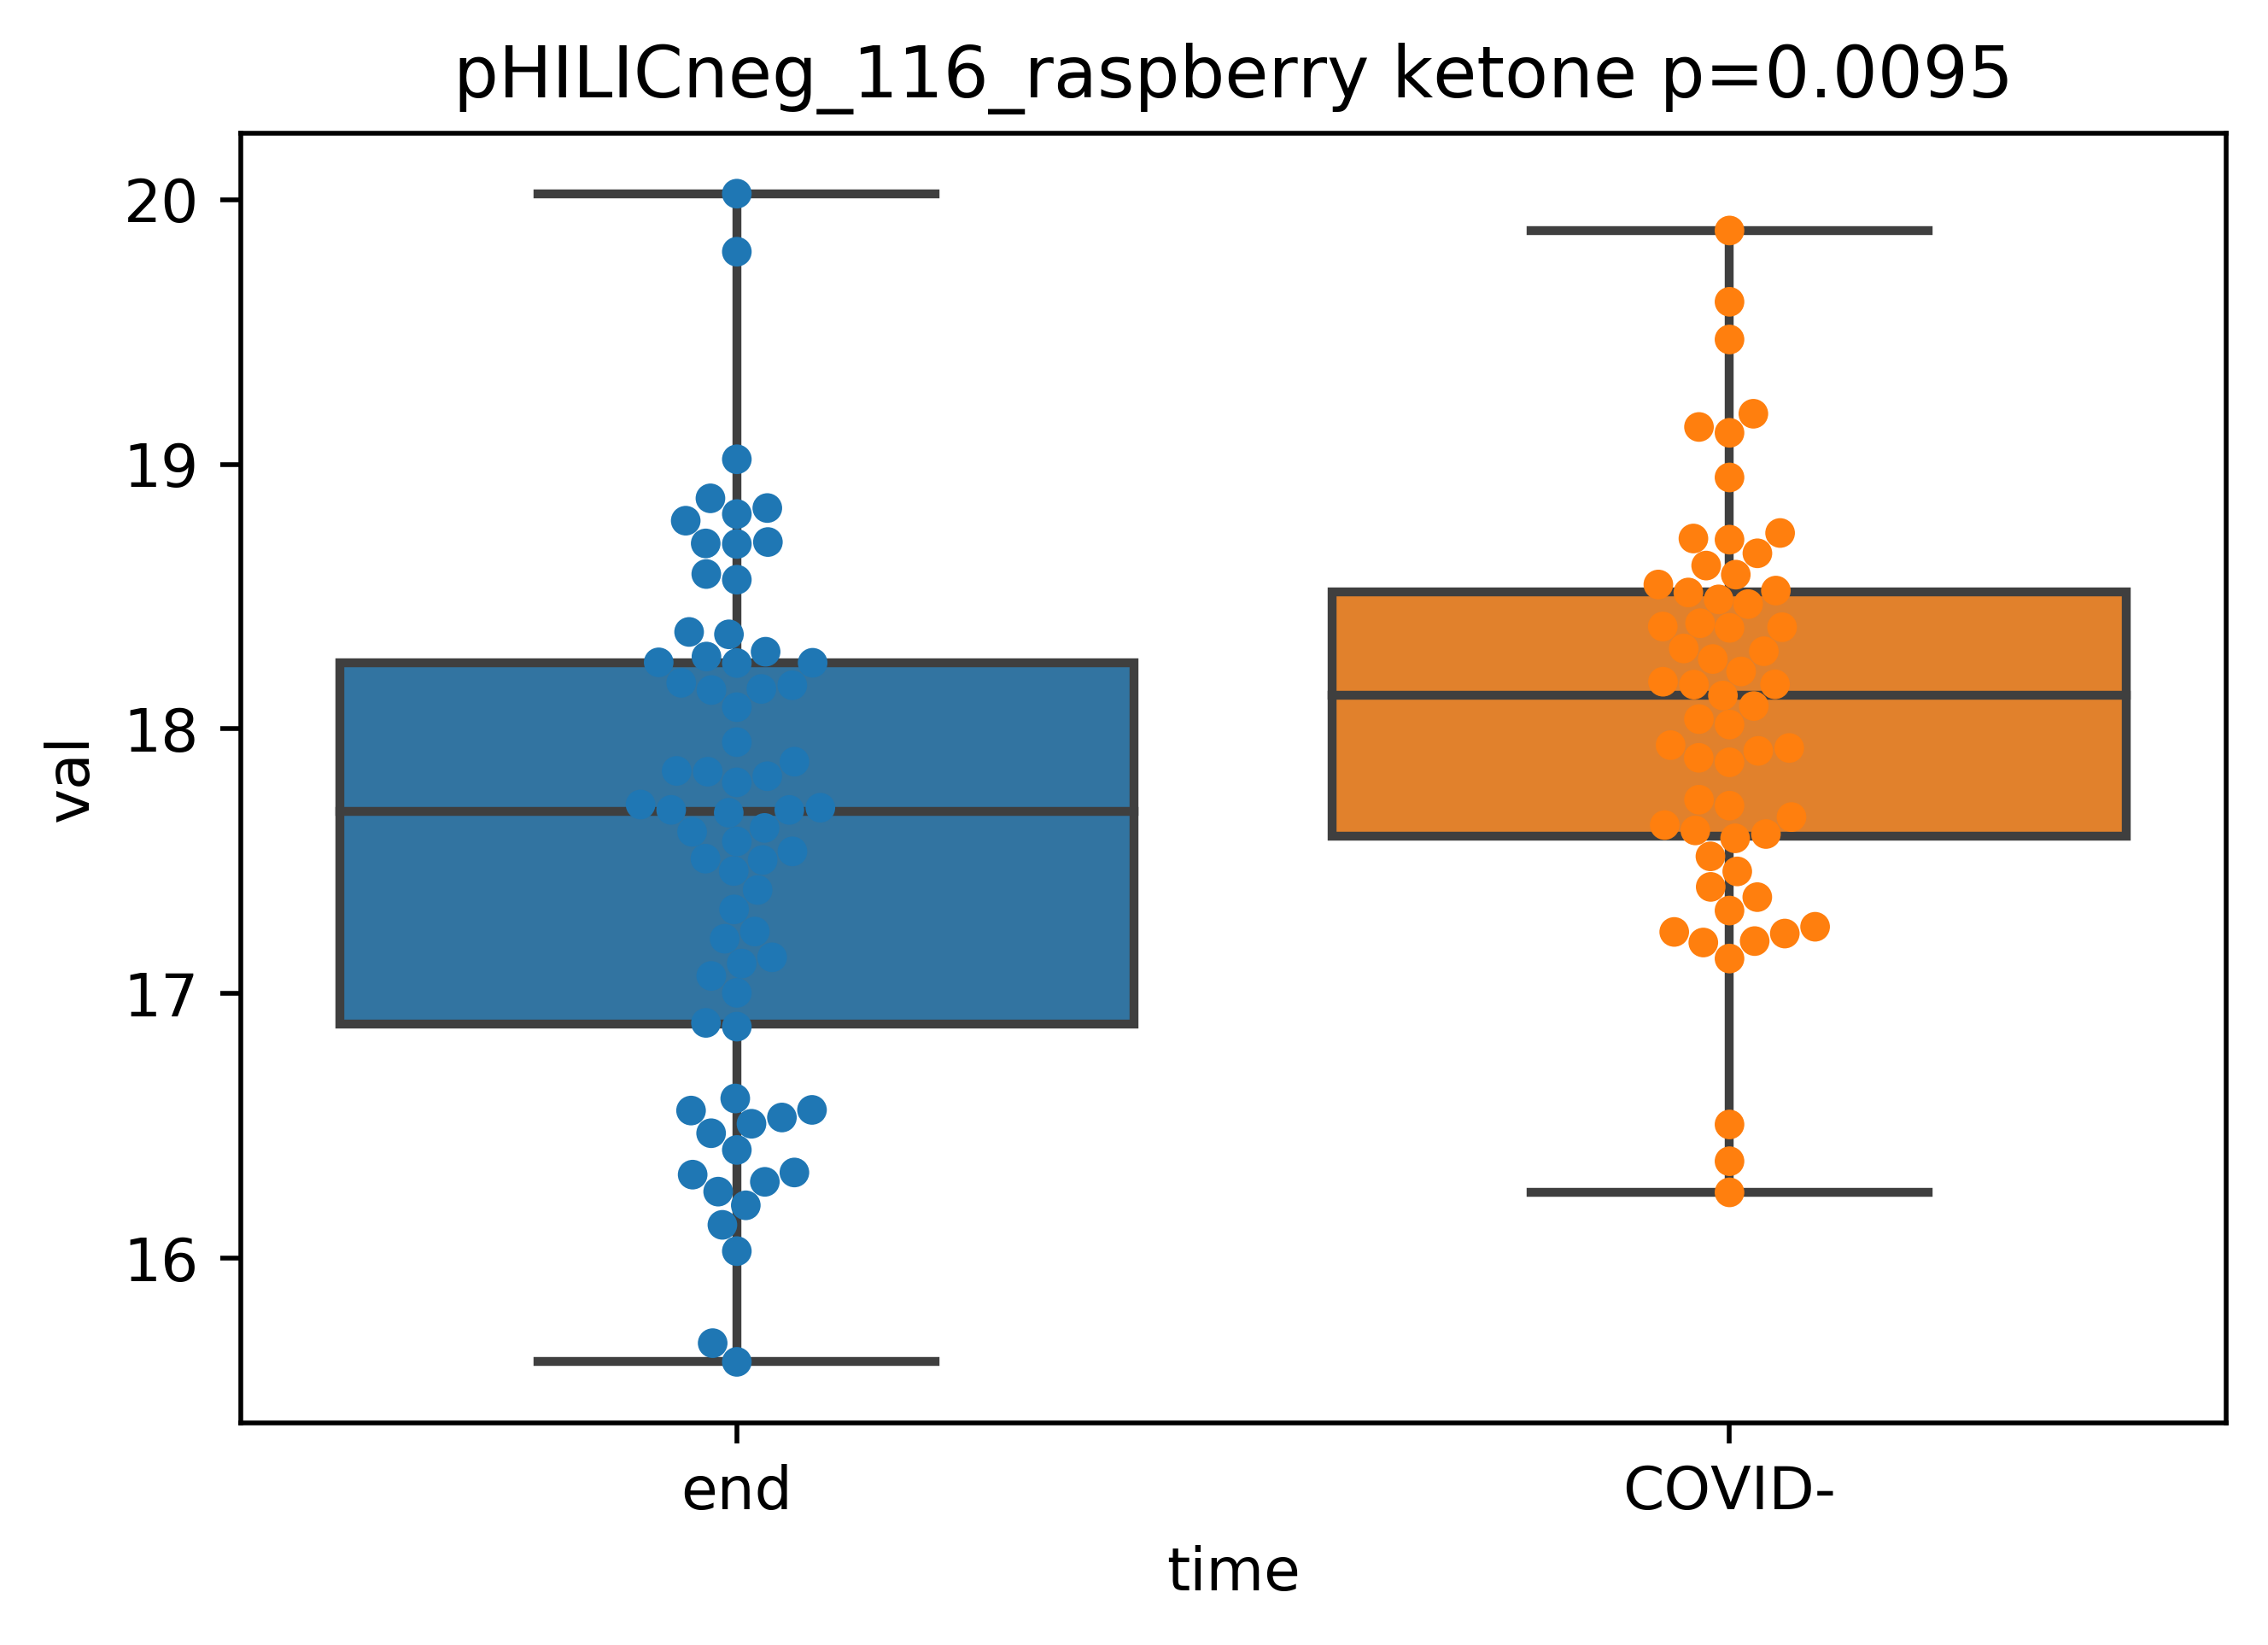

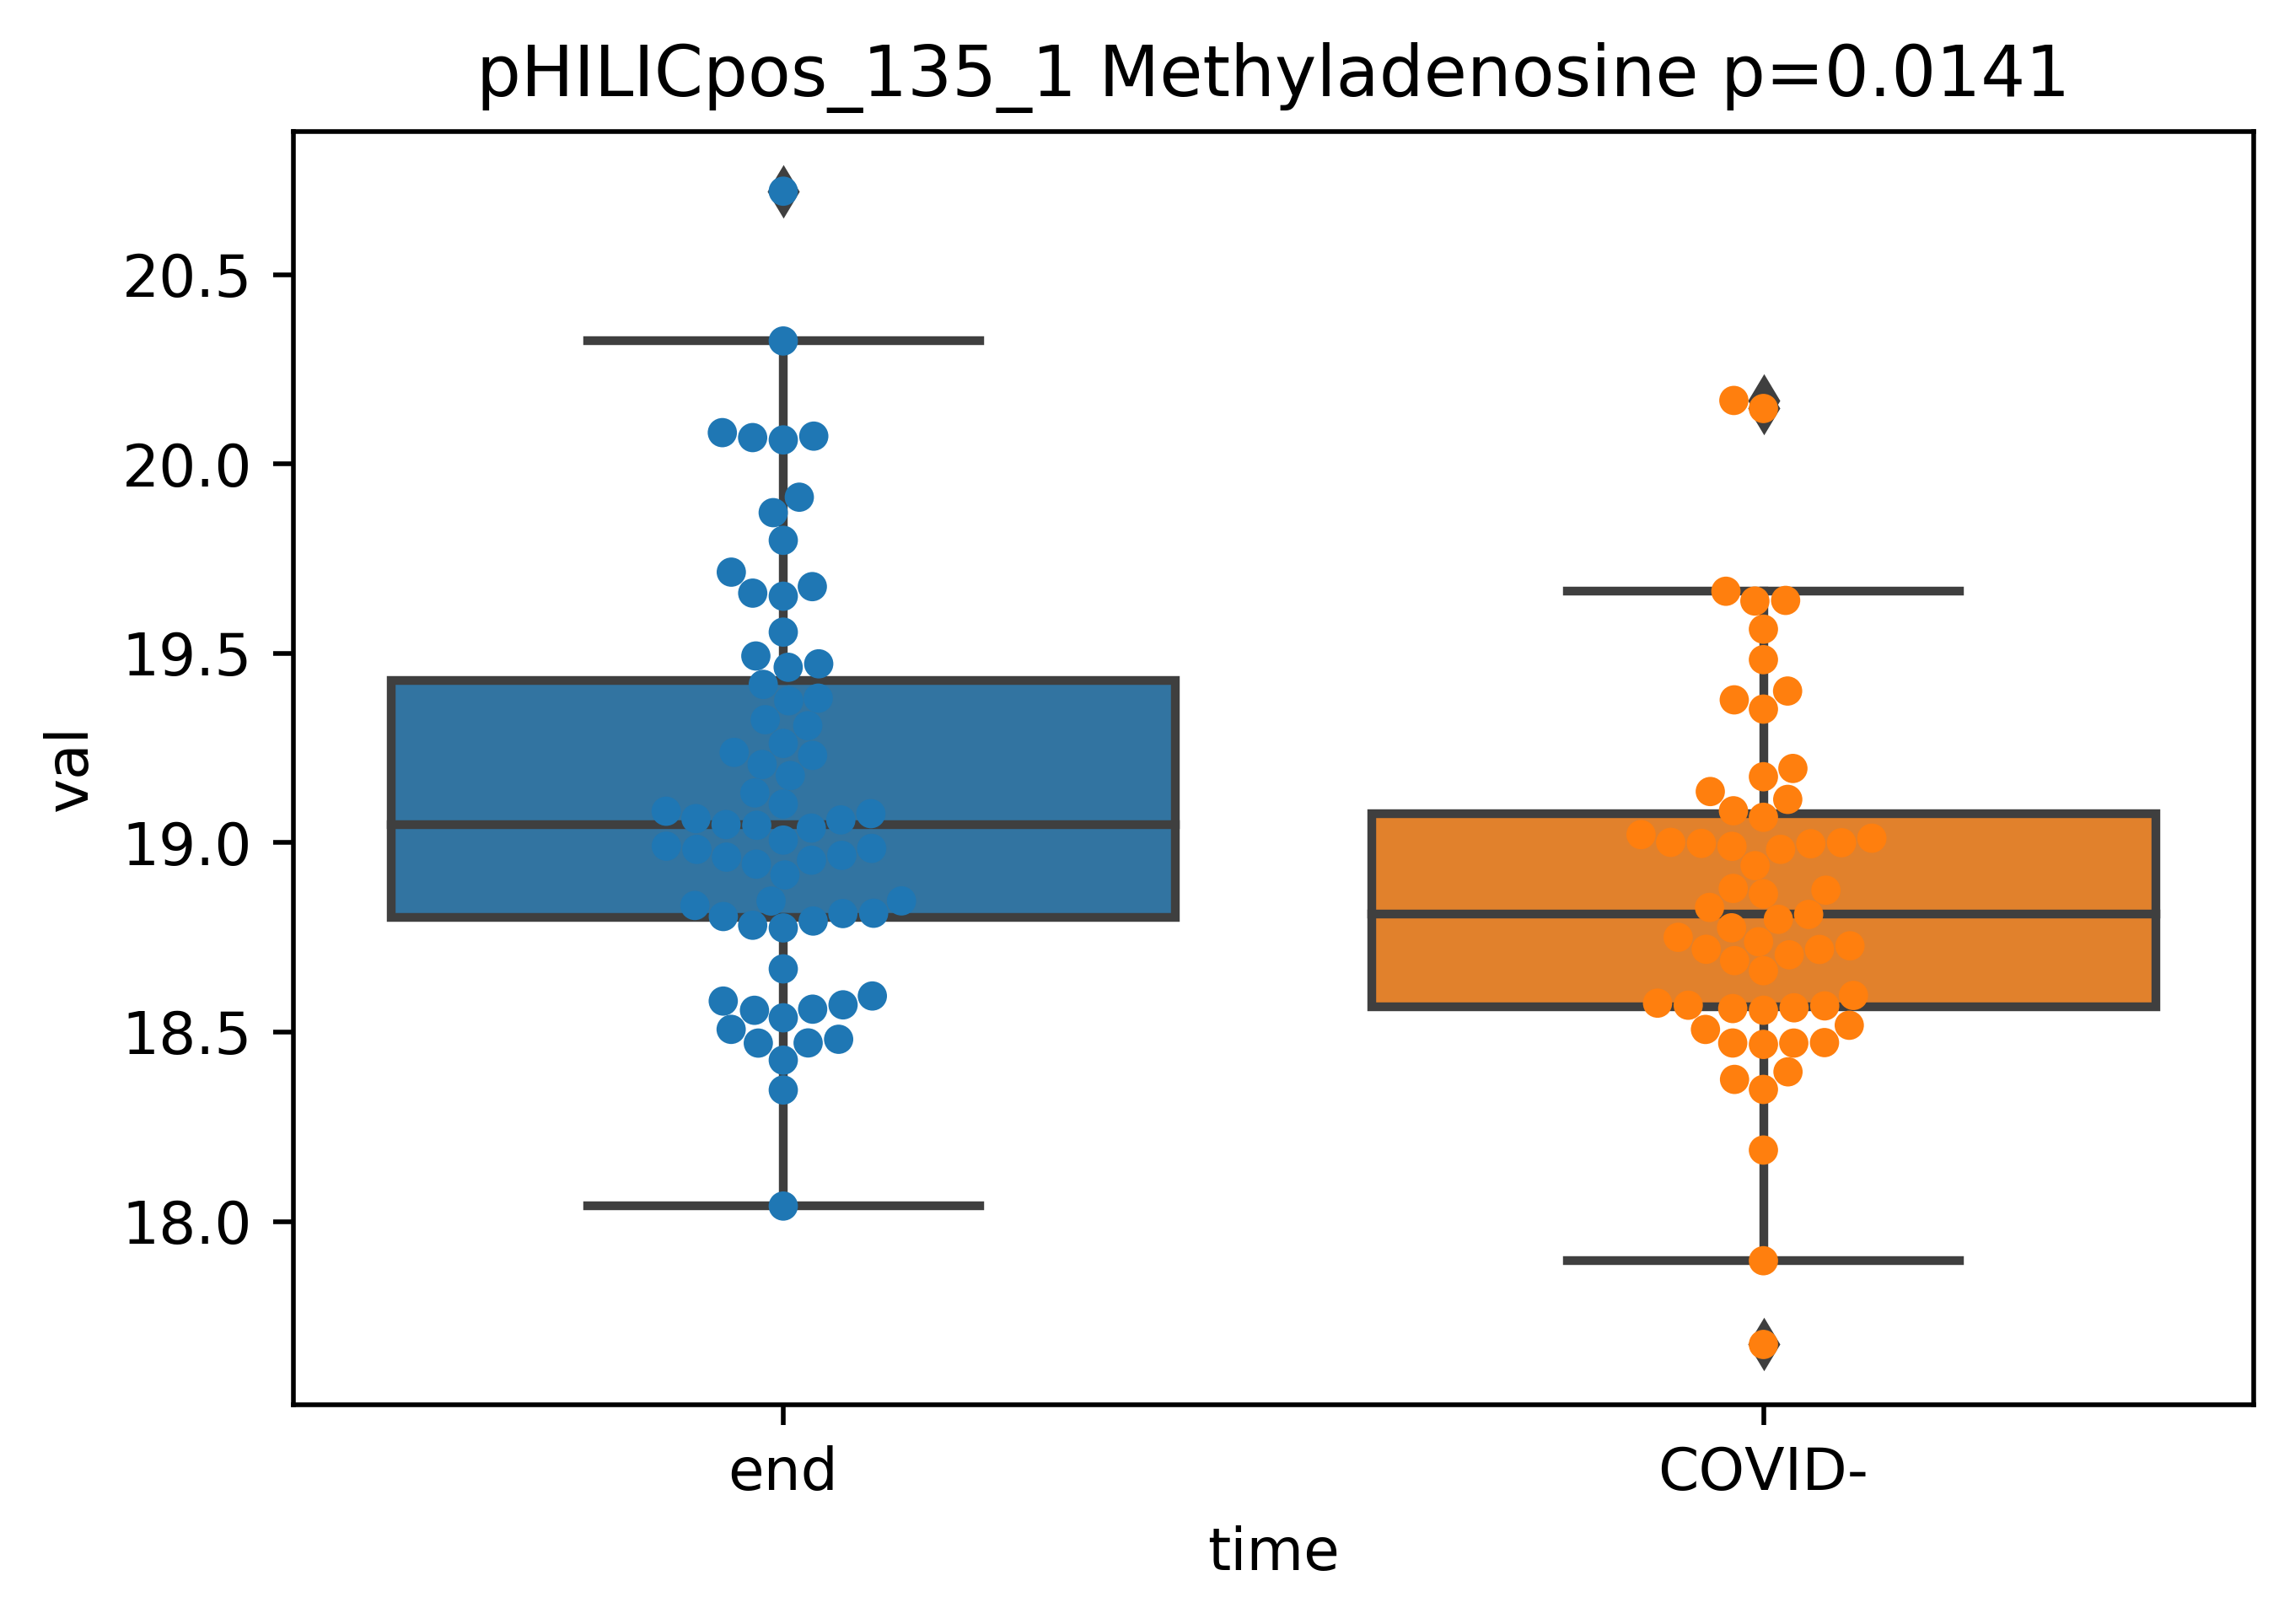

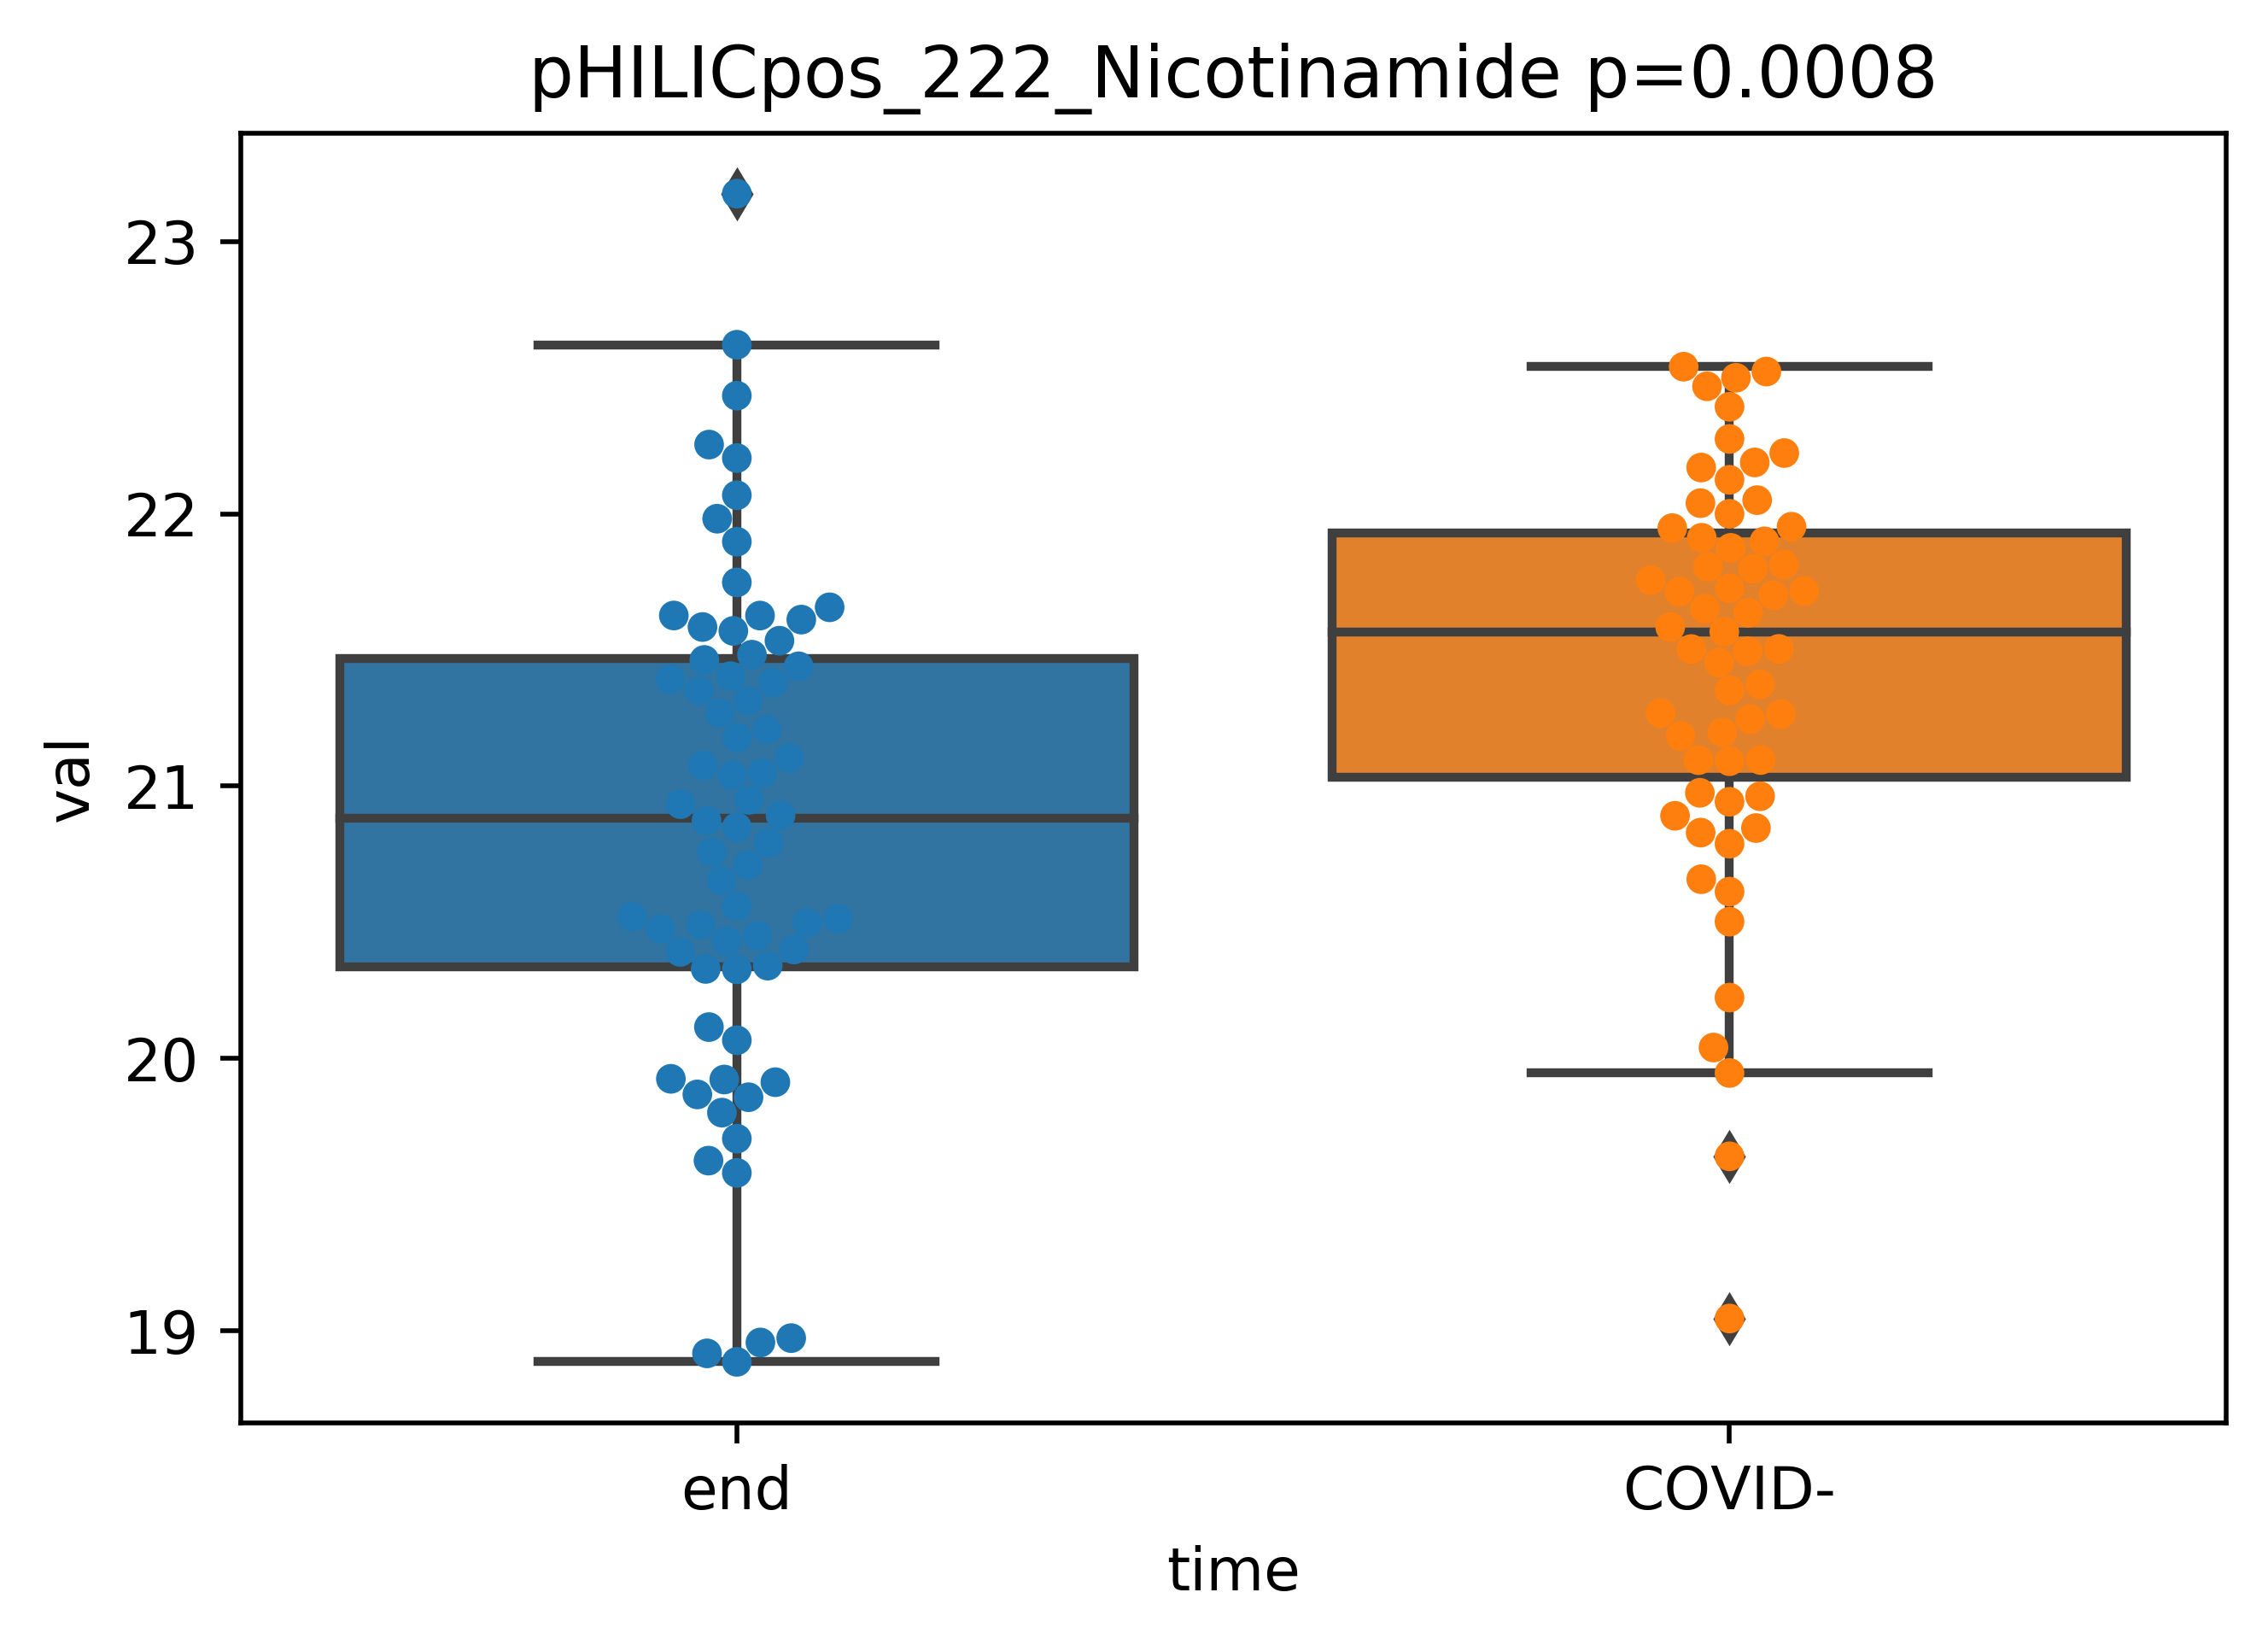

In [15]:
reject,pvals_corr,_,_ = multipletests(pvals,alpha,method="fdr_bh")
for name,p,plot_df in zip(var_imp.index.values,pvals_corr,plot_dfs):
     if p < alpha:
        print(name,p)
        plt.figure()
        sb.boxplot(data=plot_df,x="time",y="val")
        sb.swarmplot(data=plot_df,x="time",y="val")
        plt.title(name + " p=" + str(np.round(p,4)))

In [37]:
uniquePatients = list(set([x for x in sampleInfoDict["patient"]]))
goodPatients = [x for x in uniquePatients if len([y for y in sampleInfoDict["patient"].values if y == x]) > 1]
pvals = []
alpha = 0.05
plot_dfs = []
for met in range(len(var_imp)):
    starts = []
    icus = []
    ends = []
    for pat in goodPatients:
        subset = sampleInfoDict[sampleInfoDict["patient"] == pat]
        relsamples = subset["index"].values
        times = subset["sample_day"].values
        ICU = subset["ICU"].values[0]
        mort = subset["death"].values[0]
        if mort == "Alive":
            tmp = samp_int[relsamples,met]
            order = list(range(len(times)))
            order.sort(key=lambda x:times[x])
            tmp = tmp[order]
            #tmp = tmp - tmp[0]
            times = [times[x] for x in order]
            ends.append(tmp[-1])
            icus.append(ICU)
    df = dict()
    ind = 0
    ps = 0
    for e,ICU in zip(ends,icus):
        df[ind] = {"time":ICU,"val":e}
        ind += 1
        
    
    df = pd.DataFrame.from_dict(df,orient="index")
    plot_dfs.append(df)
    _,p = stats.ttest_ind(df[df["time"] == 0]["val"].values,df[df["time"] == 1]["val"].values,equal_var=False)
    pvals.append(p)

HSSpos_PE 16:0_18:2_16.83 0.030853760182889288
HSSpos_PE 16:0_20:4_16.641 0.030853760182889288


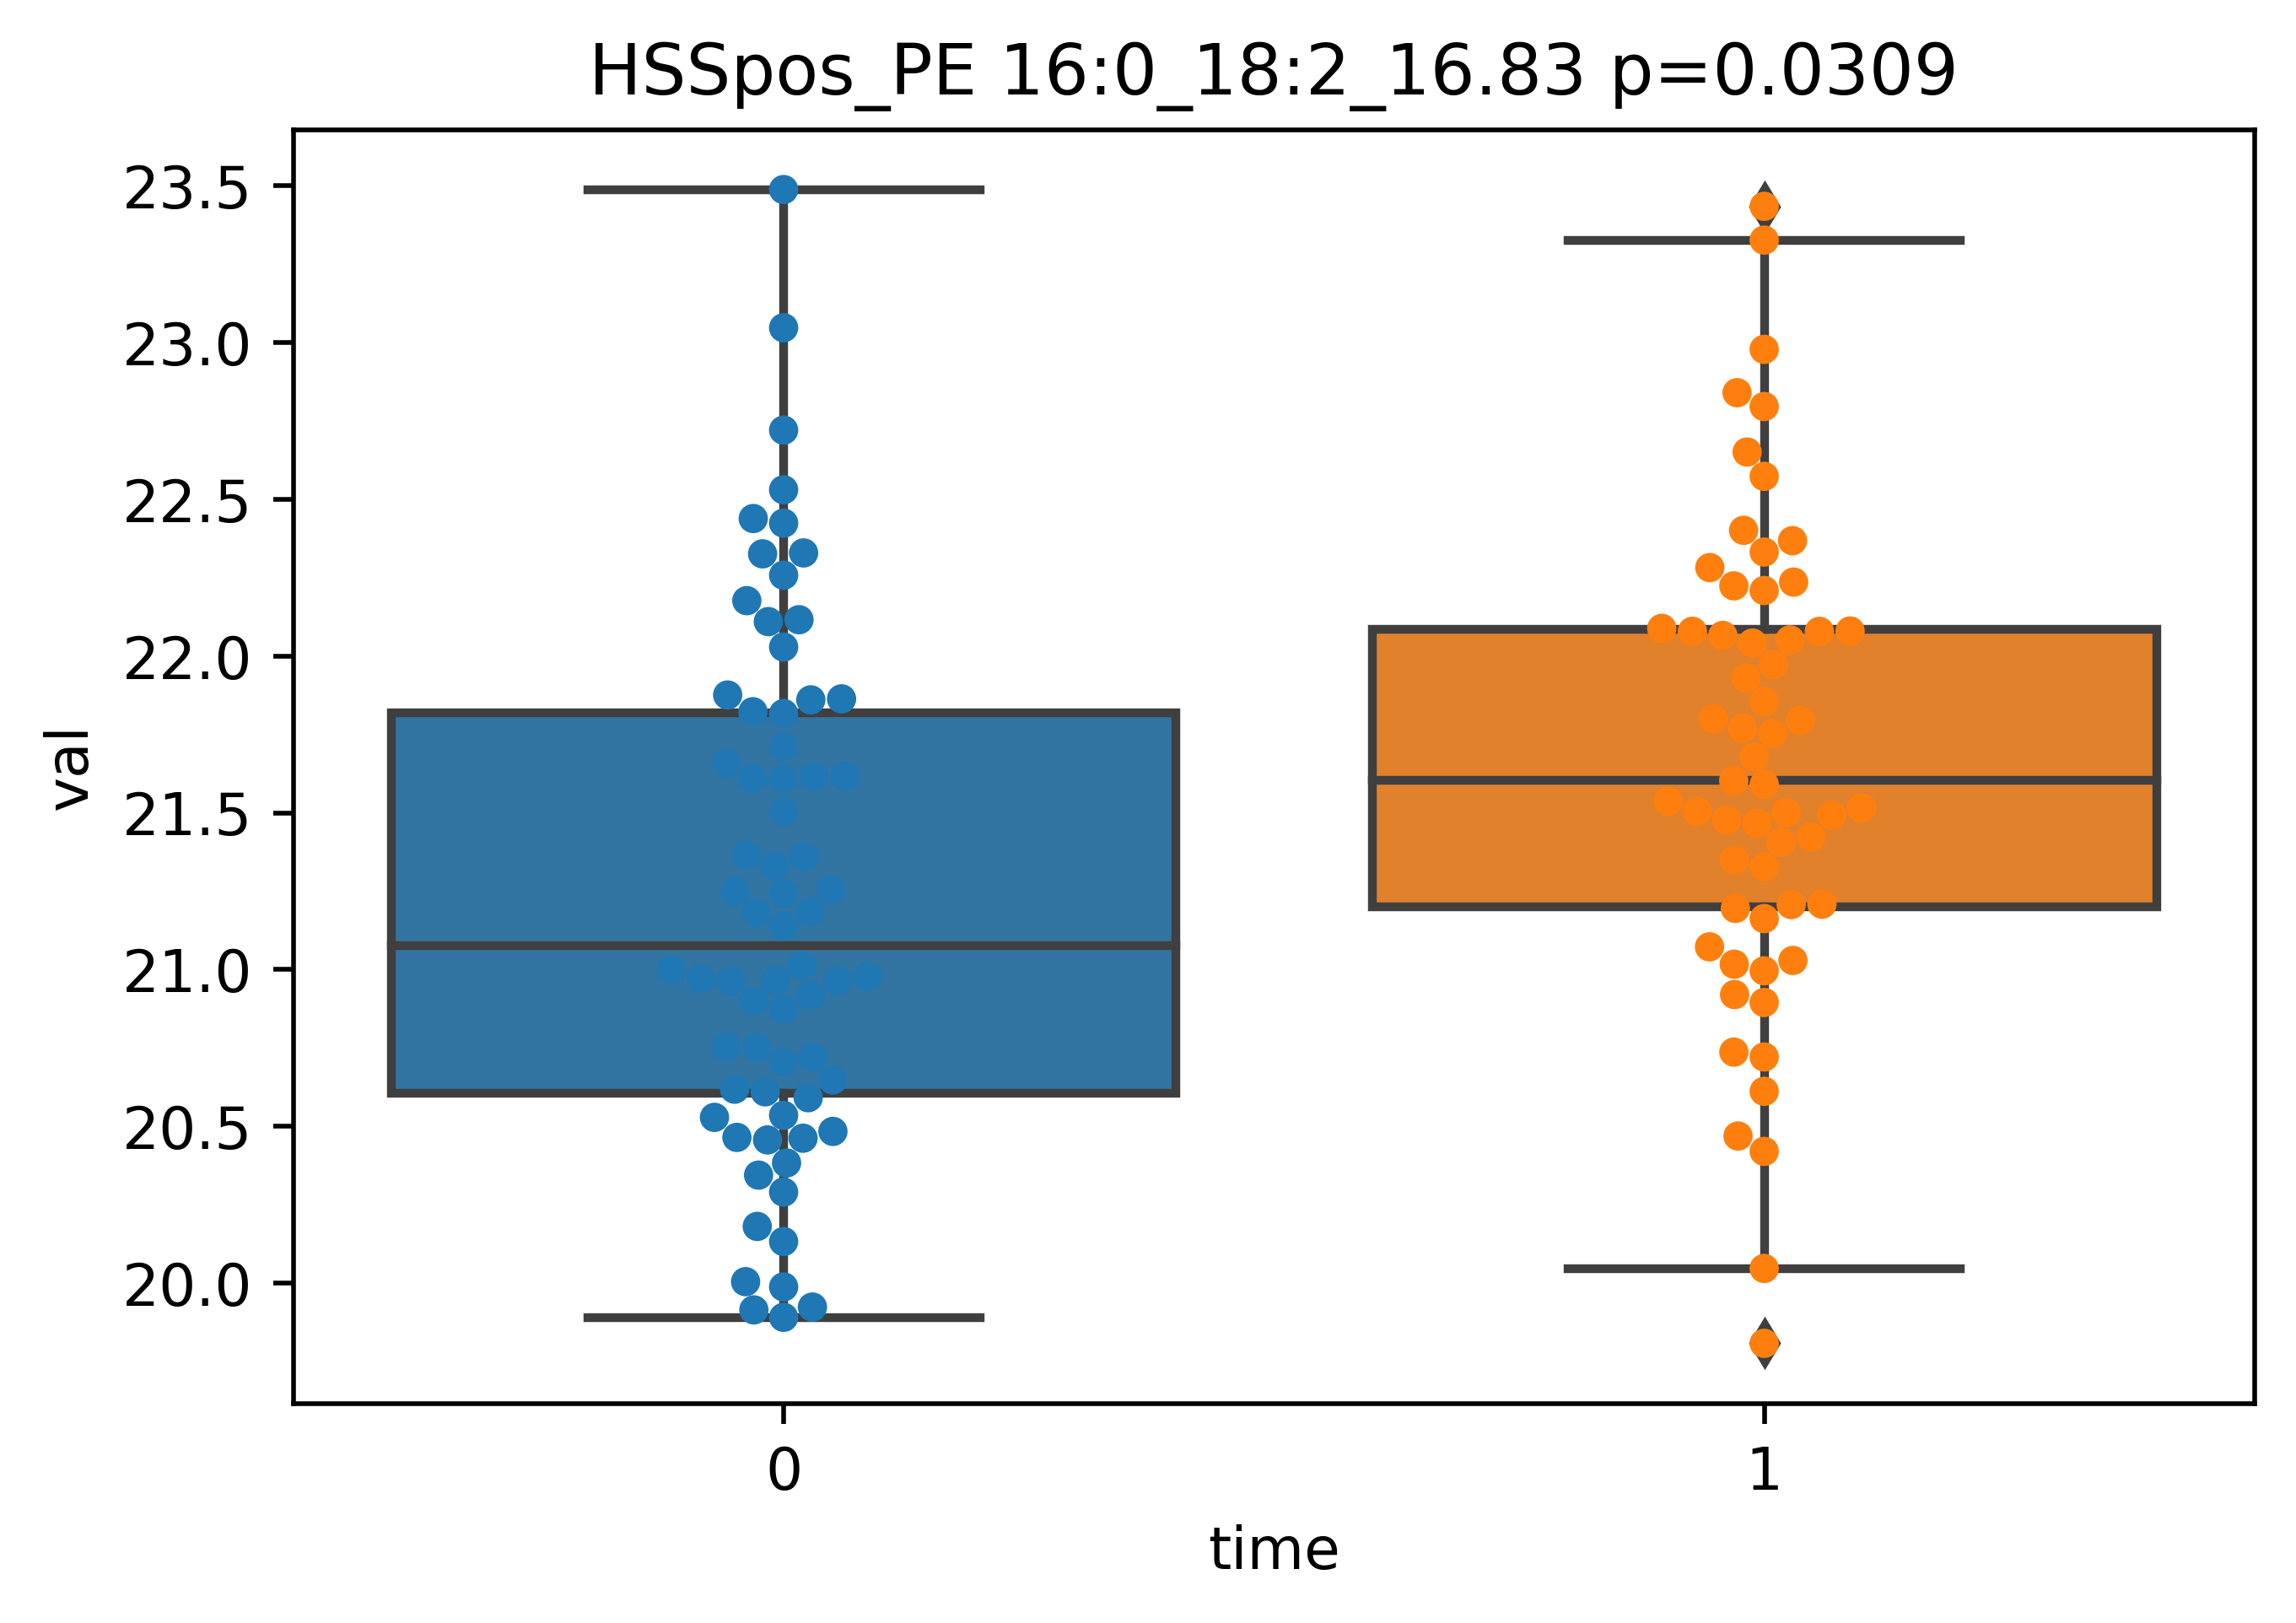

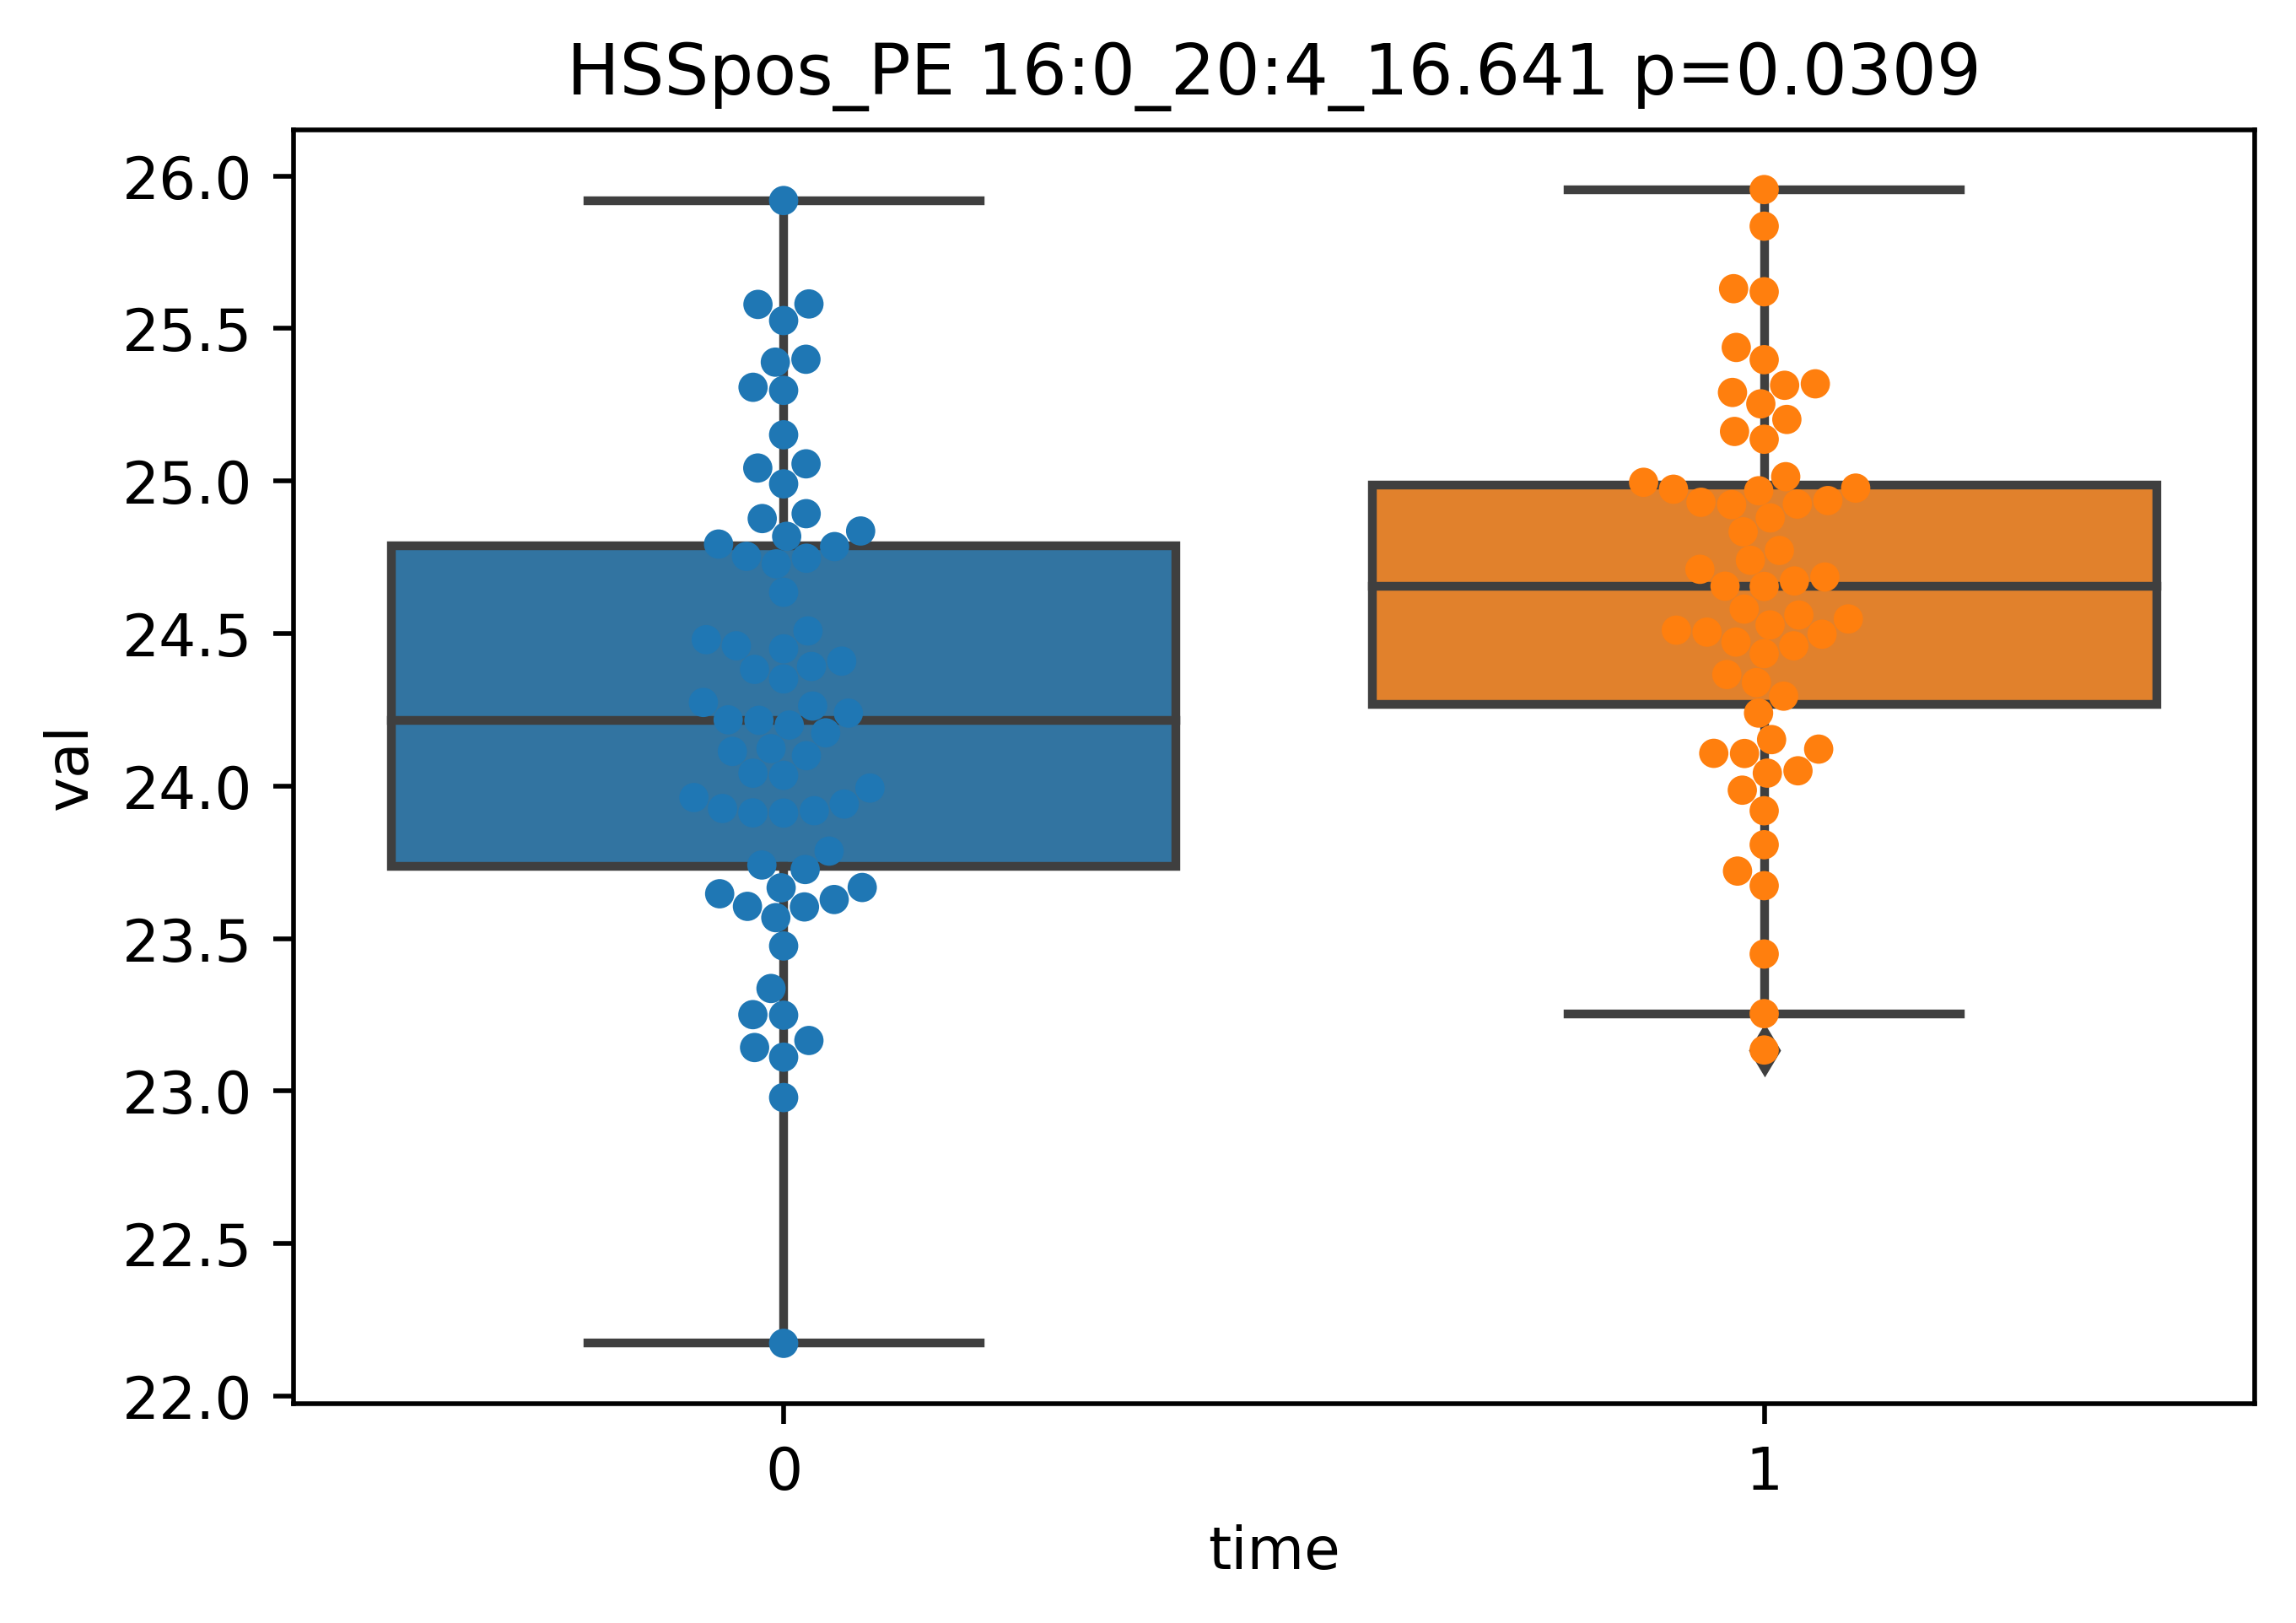

In [38]:
reject,pvals_corr,_,_ = multipletests(pvals,alpha,method="fdr_bh")
for name,p,plot_df in zip(var_imp.index.values,pvals_corr,plot_dfs):
     if p < alpha:
        print(name,p)
        plt.figure()
        sb.boxplot(data=plot_df,x="time",y="val")
        sb.swarmplot(data=plot_df,x="time",y="val")
        plt.title(name + " p=" + str(np.round(p,4)))